In [1]:
import modeller
import fitter

import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from importlib import reload

In [2]:
plt.rcParams['figure.figsize'] = [13, 8.]

In [3]:
p_true = [2, 0.75]
tspan = [0, 20]
def system(t, y, p):
    return [
        -p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]),
        p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]) - p[1]*y[1],
        p[1]*y[1]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [9999, 1, 0], dense_output=True) 

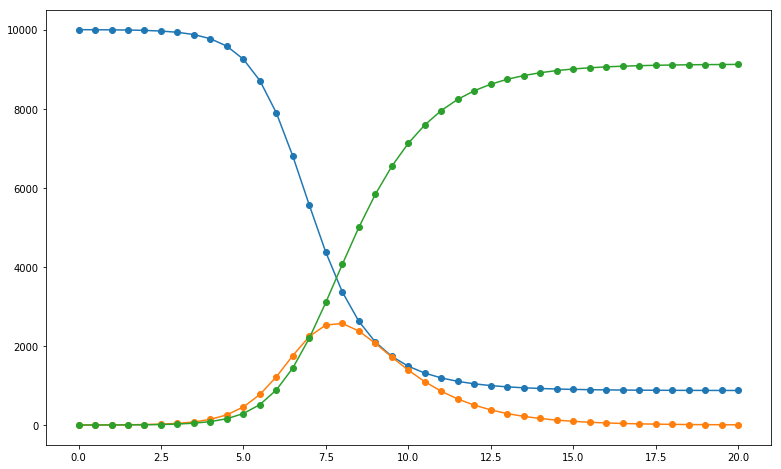

In [4]:
tofsol = np.linspace(0, 20, 41)
plt.plot(tofsol, sol.sol(tofsol).T, 'o-');

In [5]:
raw_data = sol.sol(tofsol)[2, :]
gendata = sol.sol(tofsol)[1, :]
randdata = np.random.multivariate_normal(gendata, 10000*np.exp(-1/(2*2**2)*np.abs(tofsol.reshape(1,-1)-tofsol.reshape(-1,1))**2)).reshape(1,-1)
randdata[randdata < 0] = 0
data = (np.cumsum(randdata)*p_true[1]*np.gradient(tofsol)).reshape(1, -1)
# data = raw_data.reshape(1,-1)
data_pd = np.array([i for i in data.T])

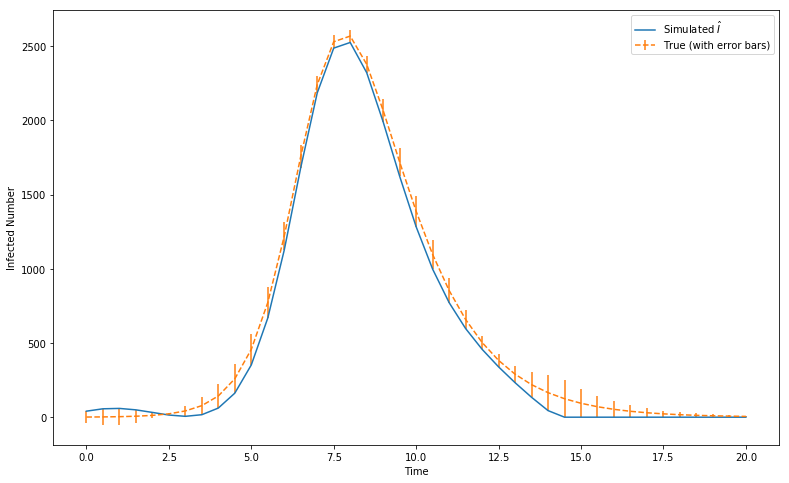

In [6]:
# plt.plot(tofsol, gendata.T)
plt.plot(tofsol, randdata.T)
plt.errorbar(tofsol, gendata.T, (randdata-gendata).flatten(), linestyle='--')
plt.xlabel('Time')
plt.ylabel("Infected Number")
plt.legend([r'Simulated $\hat{I}$', 'True (with error bars)'])

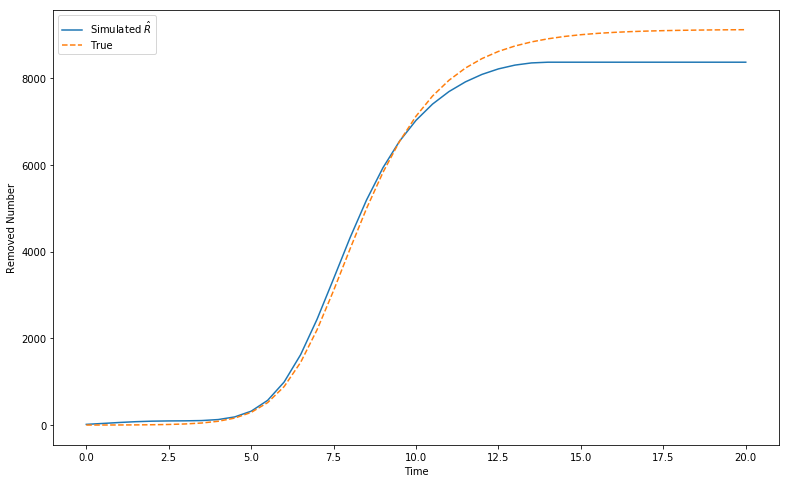

In [7]:
plt.plot(tofsol, data.T)
plt.plot(tofsol, raw_data.T, '--')
plt.xlabel('Time')
plt.ylabel("Removed Number")
plt.legend([r"Simulated $\hat{R}$", "True"])

In [9]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

opts = {
    'ipopt': {'max_iter': 300}
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, opts)

In [10]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getp', [solver_setup['x']], model.ps)

In [11]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])

In [12]:
def build_config(t,y):
    return {
    "grid_size": 120,
    "basis_number": 60,
    "model_form": {
        "state": 3,
        "parameters": 2
    },
    "time_span": tspan,
    "knot_function": None,
    "model": system,
    "dataset": {"y": y, "t": t},
    "observation_vector": [2],
    "weightings":[
        [1]*3,
        [1]*len(t)
    ],
    "regularisation_value": [0]*len(p_true),
}

In [13]:
p0 = np.ones(2)
c0 = [c*np.linspace(1, 0, config['basis_number'])+d for c,d in zip([10000, 1, -10000], [0, 0, 10000])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*3) + [0]*len(config['regularisation_value'])

testn = 5
js = list(range(0,len(tofsol),int(len(tofsol)//(testn+1))))[1:-1]

fcv_vals = []

for j in js:
    times_slice = tofsol[0:j]
    data_pd_slice = data_pd[0:j]
    config = build_config(times_slice, data_pd_slice)
    model = modeller.Model(config)
    objective = fitter.Objective()
    objective.make(config, config['dataset'], model)

    solver_setup = {
        'f': objective.objective,
        'x': ca.vcat(objective.input_list),
        'p': ca.hcat([objective.rho, objective.alpha]),
        'g': ca.vcat(model.xs),
    }

    opts = {
        'ipopt': {'max_iter': 300}
    }

    solver = ca.nlpsol('solver', 'ipopt', solver_setup, opts)
    x0 = np.hstack([*c0, p0])
    pure_data = solver(x0=x0, p=[1e-14, 1e-14], lbx=lbx, lbg=0);
    x0 = list(np.array(pure_data['x'][:-2]).flatten()) + list(p0)
    prange = np.logspace(-6, 6, num=50)
    solutions = []
    fcv_vals.append(solutions)
    xguess = x0
    for p in prange:
        solutions.append(solver(x0=xguess, p=[p, 0.5], lbx=lbx, lbg=0))
        xguess = np.array(solutions[-1]['x']).flatten()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

  45 5.4883320e-003 0.00e+000 2.13e-003  -8.6 2.75e+003 -14.8 1.00e+000 1.00e+000h  1
  46 4.6427746e-003 0.00e+000 1.43e-003  -8.6 3.96e+003 -15.2 1.00e+000 1.00e+000h  1
  47 3.7023774e-003 0.00e+000 4.87e-004  -8.6 8.42e+003 -15.7 1.00e+000 1.00e+000h  1
  48 3.1669142e-003 0.00e+000 2.15e-003  -8.6 6.54e+003 -16.2 1.00e+000 5.00e-001h  2
  49 2.8345130e-003 0.00e+000 5.90e-003  -8.6 1.23e+004 -15.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.8460868e-003 0.00e+000 4.65e-004  -8.6 1.39e+003 -14.4 1.00e+000 1.00e+000h  1
  51 1.5698340e-003 0.00e+000 5.50e-004  -8.6 2.00e+003 -14.9 1.00e+000 1.00e+000h  1
  52 1.1454094e-003 0.00e+000 1.24e-003  -8.6 4.12e+003 -15.4 1.00e+000 1.00e+000h  1
  53 2.8332970e-003 0.00e+000 1.13e-002  -8.6 1.47e+004 -15.9 1.00e+000 1.00e+000H  1
  54 3.8253454e-004 0.00e+000 2.74e-003  -8.6 4.06e+003 -14.5 1.00e+000 1.00e+000h  1
  55 2.1236878e-004 0.00e+000 5.15e-005  -8.6 1.13e+003 -15

  45 3.6039473e-003 0.00e+000 2.43e+000  -5.7 1.82e+004 -13.4 1.00e+000 5.00e-001f  2
  46 3.2786596e-003 0.00e+000 3.98e+000  -5.7 4.54e+003 -12.0 1.00e+000 1.00e+000f  1
  47 2.0742896e-003 0.00e+000 5.63e-001  -5.7 1.27e+004 -12.5 1.00e+000 5.00e-001f  2
  48 1.5292953e-003 0.00e+000 8.27e-001  -5.7 6.21e+003 -13.0 1.00e+000 1.00e+000f  1
  49 1.2531941e-003 0.00e+000 1.39e+000  -5.7 7.40e+003 -12.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 9.8539890e-004 0.00e+000 2.46e-002  -5.7 1.06e+003 -12.1 1.00e+000 1.00e+000f  1
  51 7.3529698e-004 0.00e+000 7.62e-001  -5.7 3.09e+003 -12.6 1.00e+000 1.00e+000f  1
  52 5.4482019e-004 0.00e+000 7.03e-001  -5.7 2.06e+004 -13.1 1.00e+000 2.50e-001f  3
  53 4.3573178e-004 0.00e+000 1.60e+000  -5.7 3.88e+003 -12.7 1.00e+000 1.00e+000f  1
  54 2.6252014e-004 0.00e+000 1.65e-002  -5.7 8.56e+002 -12.2 1.00e+000 1.00e+000f  1
  55 1.9067794e-004 0.00e+000 5.46e-001  -5.7 2.04e+004    

  45 1.2313790e-002 0.00e+000 8.68e-001  -5.7 6.37e+003 -12.8 1.00e+000 1.00e+000f  1
  46 1.2048229e-002 0.00e+000 3.62e+000  -5.7 1.55e+005 -13.3 5.90e-001 3.11e-002f  5
  47 1.0474941e-002 0.00e+000 3.18e+000  -5.7 8.00e+003 -12.9 1.00e+000 1.00e+000f  1
  48 9.4650044e-003 0.00e+000 2.73e+000  -5.7 2.29e+003 -11.6 1.00e+000 1.00e+000f  1
  49 8.6411249e-003 0.00e+000 4.85e-001  -5.7 1.57e+003 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 8.0088814e-003 0.00e+000 1.78e+000  -5.7 4.08e+003 -12.5 1.00e+000 5.00e-001f  2
  51 7.3091835e-003 0.00e+000 2.05e+000  -5.7 1.55e+004 -13.0 1.00e+000 5.00e-001f  2
  52 6.4680883e-003 0.00e+000 1.22e+000  -5.7 1.59e+003 -11.7 1.00e+000 1.00e+000f  1
  53 5.8549779e-003 0.00e+000 1.06e+000  -5.7 1.98e+003 -12.1 1.00e+000 1.00e+000f  1
  54 5.1049068e-003 0.00e+000 9.76e-001  -5.7 4.35e+003 -12.6 1.00e+000 1.00e+000f  1
  55 4.5583489e-003 0.00e+000 3.14e+000  -5.7 7.70e+003 -13

  24 2.0067743e+000 0.00e+000 9.51e-003  -5.7 1.32e+002  -6.4 1.00e+000 1.00e+000f  1
  25 1.8065144e+000 0.00e+000 3.52e-002  -5.7 2.48e+002  -6.9 1.00e+000 1.00e+000f  1
  26 1.5076140e+000 0.00e+000 9.50e-002  -5.7 4.03e+002  -7.3 1.00e+000 1.00e+000f  1
  27 1.2335159e+000 0.00e+000 1.22e-001  -5.7 4.91e+002  -7.8 1.00e+000 1.00e+000f  1
  28 1.1110715e+000 0.00e+000 1.60e-002  -5.7 3.14e+002  -8.3 1.00e+000 1.00e+000f  1
  29 1.0647493e+000 0.00e+000 1.19e-001  -5.7 3.55e+002  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 9.8846641e-001 0.00e+000 7.33e-001  -5.7 9.37e+002  -9.2 1.00e+000 1.00e+000f  1
  31 8.1793496e-001 0.00e+000 4.96e+000  -5.7 2.36e+003  -9.7 1.00e+000 1.00e+000f  1
  32 5.6883663e-001 0.00e+000 1.82e+001  -5.7 4.50e+003 -10.2 1.00e+000 1.00e+000f  1
  33 3.4556610e-001 0.00e+000 9.00e+000  -5.7 8.39e+003 -10.7 1.00e+000 1.00e+000f  1
  34 1.9098230e-001 0.00e+000 1.02e+001  -5.7 1.38e+004 -11

  55 7.5698873e-004 0.00e+000 7.56e-002  -5.7 4.47e+002 -11.9 1.00e+000 1.00e+000h  1
  56 6.8274745e-004 0.00e+000 4.85e-001  -5.7 1.19e+003 -12.4 1.00e+000 1.00e+000f  1
  57 5.7168574e-004 0.00e+000 7.33e-001  -5.7 2.83e+003 -12.8 1.00e+000 1.00e+000f  1
  58 5.4597519e-004 0.00e+000 2.56e+000  -5.7 9.88e+003 -13.3 1.00e+000 2.50e-001f  3
  59 4.6946154e-004 0.00e+000 7.32e-003  -5.7 3.54e+002 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 4.6420672e-004 0.00e+000 1.22e+000  -5.7 2.46e+005    -  4.55e-001 1.15e-002f  6
  61 4.1418849e-004 0.00e+000 1.62e+000  -5.7 1.86e+003 -12.5 1.00e+000 1.00e+000f  1
  62 3.8052295e-004 0.00e+000 3.27e-003  -5.7 3.28e+002 -12.0 1.00e+000 1.00e+000h  1
  63 3.7541413e-004 0.00e+000 9.01e-001  -5.7 1.56e+005    -  6.98e-001 1.47e-002f  6
  64 3.3644551e-004 0.00e+000 8.30e-001  -5.7 1.41e+003 -12.5 1.00e+000 1.00e+000h  1
  65 3.0400877e-004 0.00e+000 9.38e-001  -5.7 4.08e+003 -13

  97 3.6780159e-004 0.00e+000 2.41e-006  -8.6 6.87e+000    -  1.00e+000 1.00e+000h  1
  98 3.6780174e-004 0.00e+000 3.57e-005  -8.6 2.33e+001    -  1.00e+000 1.00e+000h  1
  99 3.6780174e-004 0.00e+000 1.47e-009  -8.6 1.68e-001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 99

                                   (scaled)                 (unscaled)
Objective...............:  3.6780174022573884e-004   3.6780174022573884e-004
Dual infeasibility......:  1.4749326908659292e-009   1.4749326908659292e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-009


Number of objective function evaluations             = 160
Number of objective gradient evaluations             = 100
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 160
Number of equality 

 149 6.4610072e-004 0.00e+000 1.01e-002  -8.6 2.94e+002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 6.4609784e-004 0.00e+000 7.88e-002  -8.6 1.66e+003    -  1.00e+000 5.00e-001h  2
 151 6.4606704e-004 0.00e+000 4.61e-003  -8.6 1.83e+002    -  1.00e+000 1.00e+000h  1
 152 6.4605461e-004 0.00e+000 2.72e-002  -8.6 3.65e+003    -  1.00e+000 1.25e-001h  4
 153 6.4603787e-004 0.00e+000 3.41e-002  -8.6 5.45e+002    -  1.00e+000 1.00e+000h  1
 154 6.4602024e-004 0.00e+000 2.07e-002  -8.6 4.16e+002    -  1.00e+000 1.00e+000h  1
 155 6.4600751e-004 0.00e+000 5.37e-002  -8.6 6.79e+002    -  1.00e+000 1.00e+000h  1
 156 6.4598582e-004 0.00e+000 7.68e-003  -8.6 2.40e+002    -  1.00e+000 1.00e+000h  1
 157 6.4597345e-004 0.00e+000 2.94e-002  -8.6 1.78e+003    -  1.00e+000 2.50e-001h  3
 158 6.4595602e-004 0.00e+000 2.31e-002  -8.6 4.30e+002    -  1.00e+000 1.00e+000h  1
 159 6.4593976e-004 0.00e+000 3.54e-002  -8.6 5.32e+002    

  52 1.1397994e-003 0.00e+000 6.97e-001  -5.7 1.70e+004    -  1.00e+000 1.25e-001h  4
  53 1.1394814e-003 0.00e+000 8.29e-004  -5.7 2.55e+001 -12.9 1.00e+000 1.00e+000h  1
  54 1.1397410e-003 0.00e+000 8.07e-001  -5.7 1.28e+004    -  1.00e+000 2.50e-001h  3
  55 1.1395246e-003 0.00e+000 1.27e-003  -5.7 4.69e+001 -13.4 1.00e+000 1.00e+000h  1
  56 1.1408577e-003 0.00e+000 2.11e+000  -5.7 1.04e+004    -  1.00e+000 5.00e-001h  2
  57 1.1395981e-003 0.00e+000 5.92e-004  -5.7 1.26e+001 -13.0 1.00e+000 1.00e+000h  1
  58 1.1397442e-003 0.00e+000 6.45e-001  -5.7 6.11e+003    -  1.00e+000 5.00e-001h  2
  59 1.1396341e-003 0.00e+000 1.92e-004  -5.7 1.38e+001 -13.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.1398030e-003 0.00e+000 7.36e-001  -5.7 3.34e+003    -  1.00e+000 1.00e+000h  1
  61 1.1396675e-003 0.00e+000 5.02e-005  -5.7 3.31e+000 -14.0 1.00e+000 1.00e+000h  1
  62 1.1396698e-003 0.00e+000 9.55e-004  -5.7 1.15e+002    

  17 3.0732702e-001 0.00e+000 1.82e-002  -8.6 2.01e+002  -7.8 1.00e+000 1.00e+000f  1
  18 2.1695253e-001 0.00e+000 1.27e-001  -8.6 5.07e+002  -8.3 1.00e+000 1.00e+000f  1
  19 9.1235109e-002 0.00e+000 5.09e-001  -8.6 9.56e+002  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.5783346e-002 0.00e+000 7.66e-001  -8.6 1.08e+003  -9.2 1.00e+000 1.00e+000f  1
  21 2.6903199e-003 0.00e+000 2.45e-001  -8.6 5.74e+002  -9.7 1.00e+000 1.00e+000f  1
  22 2.2440301e-003 0.00e+000 1.53e-002  -8.6 1.20e+002 -10.2 1.00e+000 1.00e+000f  1
  23 2.2370448e-003 0.00e+000 5.28e-003  -8.6 4.87e+001 -10.7 1.00e+000 1.00e+000h  1
  24 2.2230517e-003 0.00e+000 3.37e-002  -8.6 1.35e+002 -11.2 1.00e+000 1.00e+000h  1
  25 2.1945157e-003 0.00e+000 1.56e-001  -8.6 3.37e+002 -11.6 1.00e+000 1.00e+000h  1
  26 2.1635846e-003 0.00e+000 4.19e-001  -8.6 4.02e+002 -12.1 1.00e+000 1.00e+000h  1
  27 2.1500042e-003 0.00e+000 1.52e+000  -8.6 1.01e+003 -12

 107 1.9794066e-003 0.00e+000 1.22e-003  -9.0 2.36e+001    -  1.00e+000 1.00e+000h  1
 108 1.9794066e-003 0.00e+000 2.37e-008  -9.0 1.07e+000    -  1.00e+000 1.00e+000h  1
 109 1.9794066e-003 0.00e+000 4.19e-009  -9.0 4.36e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 109

                                   (scaled)                 (unscaled)
Objective...............:  1.9794065600182093e-003   1.9794065600182093e-003
Dual infeasibility......:  4.1899968659335066e-009   4.1899968659335066e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909090909090920e-010   9.0909090909090920e-010
Overall NLP error.......:  4.1899968659335066e-009   4.1899968659335066e-009


Number of objective function evaluations             = 299
Number of objective gradient evaluations             = 110
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 299
Number of equality

 122 3.5134922e-003 0.00e+000 5.72e-002  -5.7 1.59e+002 -14.1 1.00e+000 1.00e+000h  1
 123 3.5136436e-003 0.00e+000 1.22e+000  -5.7 5.37e+003    -  1.00e+000 5.00e-001h  2
 124 3.5137806e-003 0.00e+000 1.58e-001  -5.7 7.61e+002    -  1.00e+000 1.00e+000h  1
 125 3.5136767e-003 0.00e+000 6.38e-002  -5.7 6.87e+003    -  1.00e+000 6.25e-002h  5
 126 3.5137750e-003 0.00e+000 3.25e-001  -5.7 2.10e+003    -  1.00e+000 5.00e-001h  2
 127 3.5138897e-003 0.00e+000 1.61e-004  -5.7 4.35e+001 -14.5 1.00e+000 1.00e+000h  1
 128 3.5139394e-003 0.00e+000 3.28e-001  -5.7 1.28e+003    -  1.00e+000 1.00e+000h  1
 129 3.5139293e-003 0.00e+000 1.19e-004  -5.7 1.59e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 3.5139318e-003 0.00e+000 1.32e-005  -5.7 5.65e+000    -  1.00e+000 1.00e+000h  1
 131 3.5175189e-003 0.00e+000 4.43e+000  -8.6 1.76e+003    -  9.90e-001 9.86e-001h  1
 132 3.5117040e-003 0.00e+000 1.23e-001  -8.6 3.43e+004    

  58 6.1607907e-003 0.00e+000 3.20e+000  -5.7 1.33e+003    -  1.00e+000 1.00e+000h  1
  59 6.1509897e-003 0.00e+000 5.80e-001  -5.7 7.23e+003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 6.1507815e-003 0.00e+000 1.18e-002  -5.7 3.05e+001 -11.8 1.00e+000 1.00e+000h  1
  61 6.1546890e-003 0.00e+000 1.76e+000  -5.7 1.63e+004    -  1.00e+000 6.25e-002h  5
  62 6.1537841e-003 0.00e+000 3.32e-001  -5.7 1.08e+004    -  1.00e+000 1.00e+000h  1
  63 6.1554152e-003 0.00e+000 1.19e+000  -5.7 4.52e+003    -  1.00e+000 2.50e-001h  3
  64 6.1569825e-003 0.00e+000 1.59e+000  -5.7 3.84e+003    -  1.00e+000 1.00e+000h  1
  65 6.1569201e-003 0.00e+000 1.11e+000  -5.7 1.31e+003    -  1.00e+000 1.00e+000h  1
  66 6.1593369e-003 0.00e+000 1.34e+000  -5.7 6.86e+003    -  1.00e+000 7.13e-001H  1
  67 6.1621901e-003 0.00e+000 2.87e+000  -5.7 1.72e+003    -  7.73e-001 1.00e+000f  1
  68 6.1714807e-003 0.00e+000 1.14e+000  -5.7 4.27e+002 -11

 185 6.1572132e-003 0.00e+000 8.99e-002  -8.6 8.40e+003 -13.0 1.00e+000 7.63e-006h 18
 186 6.1569452e-003 0.00e+000 3.51e-001  -8.6 6.68e+003    -  1.00e+000 1.25e-001h  4
 187 6.1566486e-003 0.00e+000 7.93e-001  -8.6 8.17e+003    -  1.00e+000 1.00e+000h  1
 188 6.1560731e-003 0.00e+000 1.51e-001  -8.6 3.71e+003    -  1.00e+000 1.00e+000h  1
 189 6.1562353e-003 0.00e+000 1.24e+000  -8.6 1.97e+003    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 6.1551550e-003 0.00e+000 6.25e-002  -8.6 3.47e+003    -  1.00e+000 1.00e+000h  1
 191 6.1548708e-003 0.00e+000 6.81e-001  -8.6 5.65e+003    -  1.00e+000 1.25e-001h  4
 192 6.1542871e-003 0.00e+000 1.86e-001  -8.6 3.91e+003    -  1.00e+000 1.00e+000h  1
 193 6.1540377e-003 0.00e+000 7.65e-001  -8.6 1.83e+003    -  1.00e+000 5.00e-001h  2
 194 6.1533602e-003 0.00e+000 1.42e-001  -8.6 1.24e+003    -  1.00e+000 1.00e+000h  1
 195 6.1536241e-003 0.00e+000 1.23e+000  -8.6 1.86e+003    

  48 1.0733573e-002 0.00e+000 4.55e-001  -5.7 8.95e+002    -  1.00e+000 2.50e-001h  3
  49 1.0736331e-002 0.00e+000 3.57e-001  -5.7 2.28e+002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.0741278e-002 0.00e+000 6.61e-001  -5.7 3.08e+002    -  1.00e+000 1.00e+000h  1
  51 1.0742233e-002 0.00e+000 2.14e-001  -5.7 1.88e+002    -  1.00e+000 1.00e+000h  1
  52 1.0746907e-002 0.00e+000 6.89e-001  -5.7 5.87e+002    -  1.00e+000 5.00e-001h  2
  53 1.0747926e-002 0.00e+000 2.50e-001  -5.7 2.08e+002    -  1.00e+000 1.00e+000h  1
  54 1.0751960e-002 0.00e+000 6.61e-001  -5.7 5.79e+002    -  1.00e+000 5.00e-001h  2
  55 1.0753512e-002 0.00e+000 3.42e-001  -5.7 2.46e+002    -  1.00e+000 1.00e+000h  1
  56 1.0762729e-002 0.00e+000 1.46e+000  -5.7 4.89e+002    -  1.00e+000 1.00e+000h  1
  57 1.0758995e-002 0.00e+000 7.71e-002  -5.7 1.44e+002    -  1.00e+000 1.00e+000h  1
  58 1.0771758e-002 0.00e+000 1.99e+000  -5.7 2.28e+003    

 217 1.0807303e-002 0.00e+000 8.86e-001  -8.6 2.10e+003    -  1.00e+000 2.50e-001h  3
 218 1.0806118e-002 0.00e+000 5.26e-001  -8.6 4.28e+002    -  1.00e+000 1.00e+000h  1
 219 1.0805571e-002 0.00e+000 1.49e+000  -8.6 7.33e+002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 1.0803769e-002 0.00e+000 1.83e-001  -8.6 2.29e+002    -  1.00e+000 1.00e+000h  1
 221 1.0942541e-002 0.00e+000 1.39e+001  -8.6 2.31e+003    -  1.00e+000 1.00e+000H  1
 222 1.0942541e-002 0.00e+000 1.39e+001  -8.6 1.06e+002 -15.2 1.00e+000 4.99e-012h 38
 223 1.0797896e-002 0.00e+000 1.31e-001  -8.6 1.05e+002 -15.6 1.00e+000 1.00e+000f  1
 224 1.0796780e-002 0.00e+000 8.99e-001  -8.6 5.43e+002 -13.4 1.00e+000 1.00e+000h  1
 225 1.0795188e-002 0.00e+000 4.08e-001  -8.6 6.96e+002    -  1.00e+000 1.00e+000h  1
 226 1.0794187e-002 0.00e+000 7.16e-001  -8.6 7.75e+002    -  1.00e+000 5.00e-001h  2
 227 1.0792639e-002 0.00e+000 6.15e-001  -8.6 4.13e+002    

  40 1.8976567e-002 0.00e+000 5.42e-002  -8.6 2.65e+002 -13.8 1.00e+000 1.00e+000h  1
  41 1.9099485e-002 0.00e+000 2.51e+000  -8.6 1.03e+005    -  1.00e+000 1.00e+000h  1
  42 1.8967022e-002 0.00e+000 1.33e-002  -8.6 5.45e+001 -14.3 1.00e+000 1.00e+000h  1
  43 1.1301023e+000 0.00e+000 2.08e+001  -8.6 1.63e+004 -14.8 1.00e+000 1.00e+000H  1
  44 9.0944061e-001 0.00e+000 1.87e+001  -8.6 2.14e+001  -7.0 1.00e+000 1.05e-001f  1
  45 2.0874328e-002 0.00e+000 5.59e-001  -8.6 3.71e+001  -7.4 1.00e+000 1.00e+000f  1
  46 1.9203464e-002 0.00e+000 1.06e-003  -8.6 8.42e+000  -7.9 1.00e+000 1.00e+000f  1
  47 1.8499087e-002 0.00e+000 2.19e-001  -8.6 2.40e+004    -  8.67e-001 5.00e-001f  2
  48 1.8238585e-002 0.00e+000 1.71e-004  -8.6 9.24e+000  -8.4 1.00e+000 1.00e+000f  1
  49 1.8131040e-002 0.00e+000 1.62e-004  -8.6 8.40e+000  -8.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.8103141e-002 0.00e+000 6.29e-005  -8.6 5.22e+000  -9

  25 5.9304817e-002 0.00e+000 5.77e+001  -3.8 1.58e+003    -  1.00e+000 1.00e+000f  1
  26 5.8798523e-002 0.00e+000 1.65e+001  -3.8 1.17e+003    -  1.00e+000 1.00e+000f  1
  27 5.9306291e-002 0.00e+000 6.46e+001  -3.8 3.22e+003    -  1.00e+000 5.00e-001f  2
  28 5.8856455e-002 0.00e+000 1.98e+001  -3.8 1.44e+003    -  1.00e+000 1.00e+000f  1
  29 5.9299539e-002 0.00e+000 7.25e+001  -3.8 3.63e+003    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 5.8791010e-002 0.00e+000 6.56e-005  -3.8 4.14e-001  -6.4 1.00e+000 1.00e+000f  1
  31 5.8567659e-002 0.00e+000 6.38e-001  -5.7 1.18e+002    -  1.00e+000 1.00e+000f  1
  32 5.8567536e-002 0.00e+000 2.18e-007  -5.7 5.45e-002  -6.9 1.00e+000 1.00e+000h  1
  33 5.8567320e-002 0.00e+000 1.87e-006  -8.6 1.87e-001  -7.3 1.00e+000 1.00e+000h  1
  34 5.8566890e-002 0.00e+000 3.80e-006  -8.6 4.91e-001  -7.8 1.00e+000 1.00e+000h  1
  35 5.8565718e-002 0.00e+000 4.21e-006  -8.6 1.38e+000  -8

 121 5.4710176e-002 0.00e+000 6.80e-001  -8.6 5.35e+001    -  1.00e+000 1.00e+000f  1
 122 5.4568600e-002 0.00e+000 1.70e+000  -8.6 1.67e+002    -  1.00e+000 5.00e-001f  2
 123 5.4297852e-002 0.00e+000 6.59e-001  -8.6 5.05e+001    -  1.00e+000 1.00e+000f  1
 124 5.4134621e-002 0.00e+000 1.51e+000  -8.6 1.50e+002    -  1.00e+000 5.00e-001f  2
 125 5.3838332e-002 0.00e+000 6.82e-001  -8.6 4.99e+001    -  1.00e+000 1.00e+000f  1
 126 5.3648458e-002 0.00e+000 1.21e+000  -8.6 1.22e+002    -  1.00e+000 5.00e-001f  2
 127 5.3337311e-002 0.00e+000 8.64e-001  -8.6 5.60e+001    -  1.00e+000 1.00e+000f  1
 128 5.3090802e-002 0.00e+000 1.51e+000  -8.6 7.66e+001    -  1.00e+000 1.00e+000f  1
 129 5.2679597e-002 0.00e+000 4.23e-001  -8.6 3.40e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 5.2571231e-002 0.00e+000 1.75e+000  -8.6 1.55e+002    -  1.00e+000 5.00e-001f  2
 131 5.1989628e-002 0.00e+000 2.44e-001  -8.6 2.19e+001    

  59 1.0299156e-001 0.00e+000 2.60e+001  -8.6 5.65e+003    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.0298111e-001 0.00e+000 1.22e+000  -8.6 2.64e+002 -15.0 1.00e+000 1.00e+000h  1
  61 1.0366566e-001 0.00e+000 2.07e+002  -8.6 8.28e+003    -  1.00e+000 5.00e-001h  2
  62 1.0353606e-001 0.00e+000 1.87e+002  -8.6 1.58e+002 -15.5 1.00e+000 9.57e-002f  4
  63 1.0295782e-001 0.00e+000 1.02e+000  -8.6 1.34e+002 -15.9 1.00e+000 1.00e+000f  1
  64 1.0295388e-001 0.00e+000 5.99e+000  -8.6 2.75e+003 -13.7 1.00e+000 2.50e-001h  3
  65 1.0295222e-001 0.00e+000 1.97e+001  -8.6 1.17e+003    -  1.00e+000 1.00e+000h  1
  66 1.0294402e-001 0.00e+000 4.57e+000  -8.6 1.31e+005    -  6.88e-002 7.53e-001h  1
  67 1.0294402e-001 0.00e+000 4.57e+000  -8.6 2.39e+005    -  1.67e-009 4.23e-008f  1
  68 1.0294370e-001 0.00e+000 1.03e+001  -8.6 9.65e+004    -  5.68e-006 2.50e-001f  3
  69 1.0294356e-001 0.00e+000 1.03e+001  -8.6 3.15e+002 -12

 164 9.9167846e-002 0.00e+000 1.27e+000  -8.6 7.02e+001    -  1.00e+000 1.00e+000f  1
 165 9.9049699e-002 0.00e+000 2.72e+000  -8.6 3.73e+002    -  1.00e+000 2.50e-001f  3
 166 9.8876755e-002 0.00e+000 4.35e+000  -8.6 1.41e+002    -  1.00e+000 1.00e+000f  1
 167 9.8626522e-002 0.00e+000 1.57e+000  -8.6 7.61e+001    -  1.00e+000 1.00e+000f  1
 168 9.8483084e-002 0.00e+000 4.14e+000  -8.6 2.44e+002    -  1.00e+000 5.00e-001f  2
 169 9.8203504e-002 0.00e+000 1.52e+000  -8.6 7.20e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 9.8040951e-002 0.00e+000 3.90e+000  -8.6 2.26e+002    -  1.00e+000 5.00e-001f  2
 171 9.7729445e-002 0.00e+000 1.50e+000  -8.6 6.89e+001    -  1.00e+000 1.00e+000f  1
 172 9.7541645e-002 0.00e+000 3.54e+000  -8.6 2.04e+002    -  1.00e+000 5.00e-001f  2
 173 9.7199167e-002 0.00e+000 1.59e+000  -8.6 6.87e+001    -  1.00e+000 1.00e+000f  1
 174 9.6979324e-002 0.00e+000 2.89e+000  -8.6 1.69e+002    

  80 1.8058184e-001 0.00e+000 2.93e+001  -5.7 4.23e+004 -15.1 1.00e+000 3.12e-002h  6
  81 1.8057503e-001 0.00e+000 6.61e+000  -5.7 9.52e+003    -  1.00e+000 1.00e+000h  1
  82 1.8057083e-001 0.00e+000 1.39e+001  -5.7 1.91e+003 -13.8 1.00e+000 5.00e-001h  2
  83 1.8056647e-001 0.00e+000 1.08e+001  -5.7 9.70e+003    -  1.00e+000 1.00e+000h  1
  84 1.8056207e-001 0.00e+000 2.31e+001  -5.7 1.30e+003    -  1.00e+000 1.00e+000h  1
  85 1.8055695e-001 0.00e+000 4.85e+000  -5.7 1.00e+003    -  1.00e+000 1.00e+000h  1
  86 1.8055436e-001 0.00e+000 3.25e+001  -5.7 2.56e+003    -  1.00e+000 5.00e-001h  2
  87 1.8054703e-001 0.00e+000 2.17e+000  -5.7 3.08e+002 -14.3 1.00e+000 1.00e+000h  1
  88 1.8054903e-001 0.00e+000 4.69e+001  -5.7 6.25e+003    -  1.00e+000 2.50e-001h  3
  89 1.8053555e-001 0.00e+000 1.19e+000  -5.7 2.05e+002 -14.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 1.8053107e-001 0.00e+000 1.51e+001  -5.7 1.36e+004    

 186 1.7772512e-001 0.00e+000 1.11e+001  -5.7 2.57e+002    -  1.00e+000 1.00e+000f  1
 187 1.7759235e-001 0.00e+000 3.53e+000  -5.7 1.33e+002    -  1.00e+000 1.00e+000f  1
 188 1.7751790e-001 0.00e+000 1.16e+001  -5.7 4.75e+002    -  1.00e+000 5.00e-001f  2
 189 1.7736732e-001 0.00e+000 3.05e+000  -5.7 1.18e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 1.7731500e-001 0.00e+000 1.43e+001  -5.7 5.29e+002    -  1.00e+000 5.00e-001f  2
 191 1.7711236e-001 0.00e+000 1.90e+000  -5.7 8.47e+001    -  1.00e+000 1.00e+000f  1
 192 1.7702955e-001 0.00e+000 1.15e+001  -5.7 9.09e+002    -  1.00e+000 2.50e-001f  3
 193 1.7684270e-001 0.00e+000 2.70e+000  -5.7 1.03e+002    -  1.00e+000 1.00e+000f  1
 194 1.7682706e-001 0.00e+000 1.60e+001  -5.7 5.34e+002    -  1.00e+000 5.00e-001f  2
 195 1.7652373e-001 0.00e+000 1.34e+000  -5.7 6.19e+001    -  1.00e+000 1.00e+000f  1
 196 1.7640108e-001 0.00e+000 7.29e+000  -5.7 1.32e+003    

  52 2.8674695e+000 0.00e+000 5.55e+002  -1.0 1.45e+003  -8.6 1.00e+000 1.00e+000f  1
  53 2.8874738e+000 0.00e+000 6.79e+002  -1.0 7.65e+003  -9.1 1.00e+000 2.50e-001f  3
  54 2.8760095e+000 0.00e+000 2.77e+002  -1.0 2.13e+003  -8.6 1.00e+000 2.50e-001f  3
  55 3.6469631e+000 0.00e+000 2.40e+003  -1.0 5.00e+003  -9.1 1.00e+000 1.00e+000f  1
  56 3.1645140e+000 0.00e+000 3.86e+002  -1.0 1.27e+003  -7.8 1.00e+000 5.00e-001f  2
  57 2.8944899e+000 0.00e+000 5.74e+001  -1.0 5.56e+002  -8.3 1.00e+000 1.00e+000f  1
  58 2.8711225e+000 0.00e+000 3.47e+002  -1.0 1.57e+003  -8.7 1.00e+000 1.00e+000f  1
  59 2.9524594e+000 0.00e+000 1.28e+003  -1.0 5.21e+003  -9.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.8737647e+000 0.00e+000 3.64e+001  -1.0 1.92e+002  -7.9 1.00e+000 1.00e+000f  1
  61 3.1568568e+000 0.00e+000 1.81e+003  -1.0 8.95e+004    -  4.06e-001 3.23e-002f  5
  62 2.8791838e+000 0.00e+000 4.78e+002  -1.0 6.85e+002  -8

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 3.4458216e+000 0.00e+000 1.90e+003  -1.0 2.45e+003 -10.6 1.00e+000 2.50e-001f  3
 221 3.4322699e+000 0.00e+000 3.46e+002  -1.0 6.70e+002 -10.2 1.00e+000 1.00e+000f  1
 222 3.4518081e+000 0.00e+000 1.08e+003  -1.0 6.98e+003 -10.7 1.00e+000 1.25e-001f  4
 223 3.4514432e+000 0.00e+000 2.84e+002  -1.0 5.15e+002 -10.2 1.00e+000 1.00e+000f  1
 224 3.4494048e+000 0.00e+000 7.97e+002  -1.0 9.90e+002 -10.7 1.00e+000 5.00e-001f  2
 225 3.5050015e+000 0.00e+000 2.04e+003  -1.0 4.67e+003 -11.2 1.00e+000 5.00e-001f  2
 226 3.4755081e+000 0.00e+000 6.49e+002  -1.0 1.50e+003  -9.9 1.00e+000 2.50e-001f  3
 227 3.4386951e+000 0.00e+000 1.23e+003  -1.0 1.14e+003 -10.3 1.00e+000 1.00e+000f  1
 228 3.4890926e+000 0.00e+000 1.33e+003  -1.0 6.97e+002  -9.9 1.00e+000 1.00e+000f  1
 229 3.4160709e+000 0.00e+000 1.51e+003  -1.0 3.15e+003 -10.4 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 166 1.3572665e+000 0.00e+000 3.49e+002  -5.7 1.79e+003 -10.9 1.00e+000 1.25e-001f  4
 167 1.3544743e+000 0.00e+000 3.04e+002  -5.7 6.48e+002 -10.4 1.00e+000 5.00e-001f  2
 168 1.3509110e+000 0.00e+000 2.89e+002  -5.7 3.34e+003 -10.9 1.00e+000 2.50e-001f  3
 169 1.3499501e+000 0.00e+000 3.76e+002  -5.7 2.65e+003 -11.4 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 1.3447332e+000 0.00e+000 3.83e+002  -5.7 2.83e+002 -10.1 1.00e+000 1.00e+000f  1
 171 1.3446201e+000 0.00e+000 3.99e+002  -5.7 1.07e+003 -10.5 1.00e+000 5.00e-001f  2
 172 1.3369822e+000 0.00e+000 5.51e+002  -5.7 4.61e+002 -10.1 1.00e+000 1.00e+000f  1
 173 1.3340656e+000 0.00e+000 3.35e+002  -5.7 3.13e+002  -9.7 1.00e+000 1.00e+000f  1
 174 1.3279142e+000 0.00e+000 5.13e+002  -5.7 4.21e+002 -10.2 1.00e+000 1.00e+000f  1
 175 1.3255665e+000 0.00e+000 3.53e+002  -5.7 3.19e+002  -9.7 1.00e+000 1.00e+000f  1
 176 1.3191271e+000 0.00e+000 5.21e+002  -5.7 4.77e+002 -10

  24 1.5389962e+000 0.00e+000 6.06e+001  -3.8 1.72e+002 -10.4 1.00e+000 1.00e+000f  1
  25 1.5345068e+000 0.00e+000 7.45e+001  -3.8 3.07e+002 -10.8 1.00e+000 1.00e+000f  1
  26 1.5295194e+000 0.00e+000 7.41e+001  -3.8 8.91e+002 -11.3 1.00e+000 1.00e+000f  1
  27 1.5261632e+000 0.00e+000 1.59e+002  -3.8 2.73e+002 -10.0 1.00e+000 1.00e+000f  1
  28 1.5194969e+000 0.00e+000 1.15e+001  -3.8 1.59e+002 -10.5 1.00e+000 1.00e+000f  1
  29 1.5165201e+000 0.00e+000 7.53e+001  -3.8 7.07e+002 -10.9 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.5133635e+000 0.00e+000 7.23e+001  -3.8 4.51e+003 -11.4 1.00e+000 2.50e-001f  3
  31 1.5086866e+000 0.00e+000 3.32e+001  -3.8 3.85e+002 -10.1 1.00e+000 5.00e-001f  2
  32 1.5042620e+000 0.00e+000 5.69e+001  -3.8 1.73e+002 -10.6 1.00e+000 1.00e+000f  1
  33 1.4996782e+000 0.00e+000 6.16e+001  -3.8 5.36e+002 -11.0 1.00e+000 1.00e+000f  1
  34 1.4939098e+000 0.00e+000 3.40e+001  -3.8 6.40e+002 -11

 117 1.1945394e+000 0.00e+000 5.81e+000  -3.8 1.88e+002 -10.5 1.00e+000 1.00e+000f  1
 118 1.1938324e+000 0.00e+000 1.47e+002  -3.8 7.93e+002 -11.0 1.00e+000 5.00e-001f  2
 119 1.1881238e+000 0.00e+000 8.30e-001  -3.8 2.38e+002 -10.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.1859367e+000 0.00e+000 7.66e+001  -3.8 1.17e+003 -11.0 1.00e+000 2.50e-001f  3
 121 1.1826800e+000 0.00e+000 1.36e+001  -3.8 2.44e+002 -10.6 1.00e+000 1.00e+000f  1
 122 1.1802227e+000 0.00e+000 7.15e+001  -3.8 5.80e+002 -11.1 1.00e+000 5.00e-001f  2
 123 1.1768884e+000 0.00e+000 1.27e+001  -3.8 2.47e+002 -10.6 1.00e+000 1.00e+000f  1
 124 1.1744635e+000 0.00e+000 7.71e+001  -3.8 6.21e+002 -11.1 1.00e+000 5.00e-001f  2
 125 1.1708953e+000 0.00e+000 7.66e+000  -3.8 2.82e+002 -10.7 1.00e+000 1.00e+000f  1
 126 1.1692147e+000 0.00e+000 1.13e+002  -3.8 7.39e+002 -11.2 1.00e+000 5.00e-001f  2
 127 1.1643490e+000 0.00e+000 1.60e+001  -3.8 4.30e+002 -10

 235 9.5444577e-001 0.00e+000 1.63e+002  -3.8 1.42e+004    -  1.00e+000 2.50e-001f  3
 236 9.5405889e-001 0.00e+000 1.79e-001  -3.8 2.34e+001 -11.0 1.00e+000 1.00e+000f  1
 237 9.5431338e-001 0.00e+000 1.20e+002  -3.8 1.18e+004    -  1.00e+000 2.50e-001f  3
 238 9.5403115e-001 0.00e+000 1.61e+000  -3.8 7.71e+001 -11.4 1.00e+000 1.00e+000f  1
 239 9.5423316e-001 0.00e+000 6.26e+001  -3.8 1.21e+004    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 9.5411165e-001 0.00e+000 7.70e-002  -3.8 1.67e+001 -11.0 1.00e+000 1.00e+000h  1
 241 9.5418152e-001 0.00e+000 5.38e+001  -3.8 8.21e+003    -  1.00e+000 2.50e-001f  3
 242 9.5414094e-001 0.00e+000 5.42e-002  -3.8 2.45e+001 -11.5 1.00e+000 1.00e+000h  1
 243 9.5437442e-001 0.00e+000 1.28e+002  -3.8 6.45e+003    -  1.00e+000 5.00e-001f  2
 244 9.5418530e-001 0.00e+000 1.55e-002  -3.8 5.46e+000 -11.1 1.00e+000 1.00e+000h  1
 245 9.5444434e-001 0.00e+000 1.44e+002  -3.8 3.54e+003    

  85 1.6310107e+000 0.00e+000 3.22e+001  -5.7 4.07e+002 -14.3 1.00e+000 1.00e+000f  1
  86 1.6309996e+000 0.00e+000 3.52e+002  -5.7 5.68e+003    -  1.00e+000 2.50e-001f  3
  87 1.6309212e+000 0.00e+000 3.39e+001  -5.7 4.14e+002 -14.8 1.00e+000 1.00e+000f  1
  88 1.6309008e+000 0.00e+000 3.06e+002  -5.7 5.17e+003    -  1.00e+000 2.50e-001f  3
  89 1.6308301e+000 0.00e+000 4.31e+001  -5.7 4.67e+002 -15.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 1.6307963e+000 0.00e+000 1.90e+002  -5.7 3.80e+003    -  1.00e+000 2.50e-001f  3
  91 1.6307409e+000 0.00e+000 1.07e+002  -5.7 7.58e+002    -  1.00e+000 1.00e+000f  1
  92 1.6307194e+000 0.00e+000 3.37e+002  -5.7 1.37e+003    -  1.00e+000 1.00e+000f  1
  93 1.6306316e+000 0.00e+000 3.38e+001  -5.7 3.94e+002 -15.8 1.00e+000 1.00e+000f  1
  94 1.6306057e+000 0.00e+000 2.83e+002  -5.7 4.72e+003    -  1.00e+000 2.50e-001f  3
  95 1.6305292e+000 0.00e+000 4.59e+001  -5.7 7.09e+002 -16

 182 1.6144192e+000 0.00e+000 1.36e+002  -5.7 6.59e+002    -  1.00e+000 5.00e-001f  2
 183 1.6136377e+000 0.00e+000 3.32e+001  -5.7 1.59e+002    -  1.00e+000 1.00e+000f  1
 184 1.6134834e+000 0.00e+000 1.76e+002  -5.7 7.57e+002    -  1.00e+000 5.00e-001f  2
 185 1.6123666e+000 0.00e+000 1.90e+001  -5.7 1.09e+002    -  1.00e+000 1.00e+000f  1
 186 1.6121662e+000 0.00e+000 1.66e+002  -5.7 1.44e+003    -  1.00e+000 2.50e-001f  3
 187 1.6110061e+000 0.00e+000 2.00e+001  -5.7 1.09e+002    -  1.00e+000 1.00e+000f  1
 188 1.6106446e+000 0.00e+000 1.40e+002  -5.7 1.26e+003    -  1.00e+000 2.50e-001f  3
 189 1.6095667e+000 0.00e+000 2.59e+001  -5.7 1.25e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 1.6090220e+000 0.00e+000 7.95e+001  -5.7 8.44e+002    -  1.00e+000 2.50e-001f  3
 191 1.6081451e+000 0.00e+000 7.46e+001  -5.7 2.25e+002    -  1.00e+000 1.00e+000f  1
 192 1.6072539e+000 0.00e+000 8.19e+001  -5.7 2.33e+002    

  42 3.6624725e+000 0.00e+000 9.27e+002  -1.0 1.89e+002  -6.8 1.00e+000 1.00e+000f  1
  43 3.8041743e+000 0.00e+000 1.88e+003  -1.0 4.59e+002  -7.3 1.00e+000 1.00e+000f  1
  44 3.6622196e+000 0.00e+000 1.90e+002  -1.0 9.36e+001  -6.8 1.00e+000 1.00e+000f  1
  45 3.6824734e+000 0.00e+000 5.94e+002  -1.0 3.44e+002  -7.3 1.00e+000 1.00e+000f  1
  46 3.8172109e+000 0.00e+000 2.03e+003  -1.0 2.75e+003  -7.8 1.00e+000 1.25e-001f  4
  47 4.5660212e+000 0.00e+000 5.41e+003  -1.0 7.58e+002  -7.4 1.00e+000 1.00e+000f  1
  48 4.3586364e+000 0.00e+000 5.06e+003  -1.0 4.60e+002  -6.9 1.00e+000 1.00e+000f  1
  49 3.6335968e+000 0.00e+000 7.21e+001  -1.0 5.96e+001  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.6408908e+000 0.00e+000 5.43e+001  -1.0 1.26e+002  -7.0 1.00e+000 1.00e+000f  1
  51 3.6537926e+000 0.00e+000 4.11e+002  -1.0 3.59e+002  -7.5 1.00e+000 1.00e+000f  1
  52 3.6674490e+000 0.00e+000 1.12e+003  -1.0 1.11e+003  -8

 257 4.6632438e+000 0.00e+000 2.10e+002  -1.0 1.95e+002  -9.1 1.00e+000 1.00e+000f  1
 258 4.6717073e+000 0.00e+000 1.73e+003  -1.0 3.18e+004    -  1.00e+000 3.12e-002f  6
 259 4.6743190e+000 0.00e+000 1.95e+002  -1.0 1.10e+002  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 4.6836400e+000 0.00e+000 1.67e+003  -1.0 6.06e+004    -  1.00e+000 1.56e-002f  7
 261 4.6917112e+000 0.00e+000 6.23e+001  -1.0 1.01e+003  -9.2 1.00e+000 2.50e-001f  3
 262 4.6987266e+000 0.00e+000 1.98e+003  -1.0 6.38e+002  -9.7 1.00e+000 1.00e+000f  1
 263 4.6973834e+000 0.00e+000 1.39e+002  -1.0 2.01e+002  -9.3 1.00e+000 1.00e+000f  1
 264 4.7039406e+000 0.00e+000 1.36e+003  -1.0 1.59e+004    -  1.00e+000 6.25e-002f  5
 265 4.7080139e+000 0.00e+000 3.43e+002  -1.0 1.32e+002  -8.8 1.00e+000 1.00e+000f  1
 266 4.7143421e+000 0.00e+000 7.56e+002  -1.0 2.86e+002  -9.3 1.00e+000 1.00e+000f  1
 267 4.7220767e+000 0.00e+000 4.82e+002  -1.0 5.98e+002  -9

  27 6.7269388e+000 0.00e+000 2.60e+002  -3.8 3.33e+002 -10.0 1.00e+000 1.00e+000f  1
  28 6.7113808e+000 0.00e+000 4.07e+001  -3.8 2.03e+002 -10.5 1.00e+000 1.00e+000f  1
  29 6.7010457e+000 0.00e+000 1.85e+002  -3.8 5.80e+002 -10.9 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 6.6926597e+000 0.00e+000 2.14e+002  -3.8 5.29e+003 -11.4 1.00e+000 2.50e-001f  3
  31 6.6743506e+000 0.00e+000 6.14e+001  -3.8 4.50e+002 -10.1 1.00e+000 5.00e-001f  2
  32 6.6592624e+000 0.00e+000 8.55e+001  -3.8 1.77e+002 -10.6 1.00e+000 1.00e+000f  1
  33 6.6491798e+000 0.00e+000 1.80e+002  -3.8 6.37e+002 -11.0 1.00e+000 1.00e+000f  1
  34 6.6361478e+000 0.00e+000 2.32e+001  -3.8 3.72e+003 -11.5 1.00e+000 2.50e-001f  3
  35 6.6279917e+000 0.00e+000 9.64e+001  -3.8 1.24e+003 -11.1 1.00e+000 2.50e-001f  3
  36 6.6192396e+000 0.00e+000 1.93e+002  -3.8 2.44e+003 -11.6 1.00e+000 5.00e-001f  2
  37 6.6062252e+000 0.00e+000 1.02e+001  -3.8 5.76e+001  -9

 136 5.4323136e+000 0.00e+000 1.40e+002  -3.8 3.30e+002 -10.5 1.00e+000 1.00e+000f  1
 137 5.4305261e+000 0.00e+000 3.58e+002  -3.8 1.21e+003 -11.0 1.00e+000 1.00e+000f  1
 138 5.4069307e+000 0.00e+000 2.13e+001  -3.8 1.23e+002  -9.7 1.00e+000 1.00e+000f  1
 139 5.4000502e+000 0.00e+000 5.59e+001  -3.8 2.05e+002 -10.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 5.3898258e+000 0.00e+000 1.25e+002  -3.8 3.60e+002 -10.6 1.00e+000 1.00e+000f  1
 141 5.3798297e+000 0.00e+000 1.39e+002  -3.8 1.74e+003 -11.1 1.00e+000 5.00e-001f  2
 142 5.3715660e+000 0.00e+000 1.56e+001  -3.8 1.09e+002  -9.8 1.00e+000 1.00e+000f  1
 143 5.3636674e+000 0.00e+000 8.52e+001  -3.8 2.58e+002 -10.2 1.00e+000 1.00e+000f  1
 144 5.3518391e+000 0.00e+000 5.62e+001  -3.8 4.46e+002 -10.7 1.00e+000 1.00e+000f  1
 145 5.3393812e+000 0.00e+000 1.14e+002  -3.8 8.93e+002 -11.2 1.00e+000 1.00e+000f  1
 146 5.3322946e+000 0.00e+000 1.80e+002  -3.8 1.84e+003 -10

  42 7.0638641e+000 0.00e+000 4.32e-002  -5.7 4.40e+001 -12.4 1.00e+000 1.00e+000h  1
  43 7.0638458e+000 0.00e+000 3.91e-001  -5.7 1.32e+002 -12.8 1.00e+000 1.00e+000h  1
  44 7.0637911e+000 0.00e+000 3.52e+000  -5.7 3.98e+002 -13.3 1.00e+000 1.00e+000h  1
  45 7.0636903e+000 0.00e+000 1.99e+001  -5.7 1.26e+004    -  1.00e+000 1.25e-001h  4
  46 7.0635989e+000 0.00e+000 8.71e+000  -5.7 2.20e+004    -  1.00e+000 3.59e-001h  2
  47 7.0635095e+000 0.00e+000 3.97e+001  -5.7 5.94e+003    -  1.00e+000 5.00e-001h  2
  48 7.0633659e+000 0.00e+000 3.89e+000  -5.7 2.69e+003    -  1.00e+000 1.00e+000h  1
  49 7.0633203e+000 0.00e+000 5.43e+001  -5.7 5.96e+003    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 7.0630787e+000 0.00e+000 2.20e+000  -5.7 2.72e+002 -13.8 1.00e+000 1.00e+000h  1
  51 7.0630162e+000 0.00e+000 4.88e+001  -5.7 1.13e+004    -  1.00e+000 1.25e-001h  4
  52 7.0627915e+000 0.00e+000 3.39e+000  -5.7 3.45e+002 -14

 162 6.9815228e+000 0.00e+000 1.13e+001  -5.7 2.39e+002    -  1.00e+000 1.00e+000f  1
 163 6.9787812e+000 0.00e+000 1.18e+001  -5.7 2.41e+002    -  1.00e+000 1.00e+000f  1
 164 6.9758671e+000 0.00e+000 1.05e+001  -5.7 2.23e+002    -  1.00e+000 1.00e+000f  1
 165 6.9729823e+000 0.00e+000 1.28e+001  -5.7 2.45e+002    -  1.00e+000 1.00e+000f  1
 166 6.9697121e+000 0.00e+000 8.30e+000  -5.7 1.91e+002    -  1.00e+000 1.00e+000f  1
 167 6.9675263e+000 0.00e+000 1.97e+001  -5.7 3.00e+002    -  1.00e+000 1.00e+000f  1
 168 6.9630391e+000 0.00e+000 3.37e+000  -5.7 1.10e+002    -  1.00e+000 1.00e+000f  1
 169 6.9606741e+000 0.00e+000 1.18e+001  -5.7 8.07e+002    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 6.9568985e+000 0.00e+000 8.76e+000  -5.7 1.86e+002    -  1.00e+000 1.00e+000f  1
 171 6.9537137e+000 0.00e+000 1.57e+001  -5.7 2.52e+002    -  1.00e+000 1.00e+000f  1
 172 6.9491010e+000 0.00e+000 4.67e+000  -5.7 1.26e+002    

  35 1.2775171e+001 0.00e+000 7.99e+002  -1.0 1.32e+002  -6.3 1.00e+000 5.00e-001f  2
  36 1.2521312e+001 0.00e+000 9.58e+001  -1.0 5.93e+001  -5.9 1.00e+000 1.00e+000f  1
  37 1.2916154e+001 0.00e+000 1.28e+003  -1.0 1.48e+002  -6.4 1.00e+000 5.00e-001f  2
  38 1.2480872e+001 0.00e+000 2.76e+002  -1.0 7.87e+001  -5.9 1.00e+000 1.00e+000f  1
  39 1.2821069e+001 0.00e+000 1.44e+003  -1.0 3.10e+002  -6.4 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.2379644e+001 0.00e+000 3.07e+002  -1.0 8.40e+001  -6.0 1.00e+000 1.00e+000f  1
  41 1.2552154e+001 0.00e+000 1.29e+003  -1.0 3.11e+002  -6.5 1.00e+000 2.50e-001f  3
  42 1.2264033e+001 0.00e+000 2.23e+002  -1.0 7.99e+001  -6.0 1.00e+000 1.00e+000f  1
  43 1.2220571e+001 0.00e+000 5.02e+002  -1.0 2.19e+002  -6.5 1.00e+000 2.50e-001f  3
  44 1.2750410e+001 0.00e+000 1.39e+003  -1.0 5.94e+003  -7.0 3.16e-001 3.12e-002f  6
  45 1.2377415e+001 0.00e+000 1.82e+002  -1.0 2.78e+001  -5

 152 1.1834236e+001 0.00e+000 2.20e+003  -1.0 2.05e+002  -7.7 1.00e+000 1.00e+000f  1
 153 1.1873763e+001 0.00e+000 2.19e+003  -1.0 2.64e+003  -8.2 1.00e+000 1.25e-001f  4
 154 1.1922804e+001 0.00e+000 9.27e+003  -1.0 3.14e+002  -7.8 1.00e+000 1.00e+000f  1
 155 1.1835238e+001 0.00e+000 6.80e+002  -1.0 1.48e+002  -7.3 1.00e+000 1.00e+000f  1
 156 1.1858174e+001 0.00e+000 7.16e+003  -1.0 2.84e+002  -7.8 1.00e+000 1.00e+000f  1
 157 1.1810922e+001 0.00e+000 5.48e+002  -1.0 1.45e+002  -7.4 1.00e+000 1.00e+000f  1
 158 1.1841410e+001 0.00e+000 7.80e+003  -1.0 3.02e+002  -7.9 1.00e+000 1.00e+000f  1
 159 1.1790699e+001 0.00e+000 9.27e+002  -1.0 1.76e+002  -7.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.1909540e+001 0.00e+000 1.28e+004  -1.0 3.79e+002  -7.9 1.00e+000 1.00e+000f  1
 161 1.1807451e+001 0.00e+000 5.37e+003  -1.0 3.78e+002  -7.5 1.00e+000 1.00e+000f  1
 162 1.1775818e+001 0.00e+000 2.11e+002  -1.0 4.79e+001  -7

  69 1.4743103e+001 0.00e+000 6.93e+001  -3.8 2.41e+002 -10.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.4726549e+001 0.00e+000 1.17e+002  -3.8 1.33e+003 -10.6 1.00e+000 2.50e-001f  3
  71 1.4702910e+001 0.00e+000 7.05e+001  -3.8 2.61e+002 -10.2 1.00e+000 1.00e+000f  1
  72 1.4687580e+001 0.00e+000 8.54e+001  -3.8 1.20e+003 -10.7 1.00e+000 2.50e-001f  3
  73 1.4664971e+001 0.00e+000 5.46e+001  -3.8 2.46e+002 -10.3 1.00e+000 1.00e+000f  1
  74 1.4658141e+001 0.00e+000 3.02e+002  -3.8 9.39e+002 -10.7 1.00e+000 5.00e-001f  2
  75 1.4631407e+001 0.00e+000 7.26e-001  -3.8 3.99e+001  -9.4 1.00e+000 1.00e+000f  1
  76 1.4628447e+001 0.00e+000 2.17e+002  -3.8 2.85e+004    -  1.00e+000 1.92e-002f  4
  77 1.4608758e+001 0.00e+000 2.55e+001  -3.8 1.58e+002  -9.9 1.00e+000 1.00e+000f  1
  78 1.4587215e+001 0.00e+000 9.31e+001  -3.8 3.29e+002 -10.4 1.00e+000 1.00e+000f  1
  79 1.4572453e+001 0.00e+000 1.65e+002  -3.8 9.17e+002 -10

 204 1.4544407e+001 0.00e+000 2.37e+001  -5.7 1.45e+004    -  6.76e-001 1.00e+000h  1
 205 1.4544304e+001 0.00e+000 2.40e+001  -5.7 1.85e+004 -11.1 1.00e+000 9.25e-005f  2
 206 1.4544093e+001 0.00e+000 1.59e-001  -5.7 3.15e+001 -11.6 1.00e+000 1.00e+000h  1
 207 1.4544068e+001 0.00e+000 5.16e-001  -5.7 8.81e+001 -12.0 1.00e+000 1.00e+000h  1
 208 1.4543879e+001 0.00e+000 5.80e+000  -5.7 2.65e+002 -12.5 1.00e+000 1.00e+000h  1
 209 1.4543532e+001 0.00e+000 3.51e+001  -5.7 1.19e+004    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.4542944e+001 0.00e+000 2.38e+001  -5.7 1.80e+004    -  1.00e+000 1.00e+000h  1
 211 1.4542672e+001 0.00e+000 7.84e+001  -5.7 5.30e+003    -  1.00e+000 1.00e+000f  1
 212 1.4541955e+001 0.00e+000 4.44e+000  -5.7 6.62e+003    -  1.00e+000 1.00e+000h  1
 213 1.4541590e+001 0.00e+000 5.82e+001  -5.7 6.48e+003    -  1.00e+000 1.21e-001h  3
 214 1.4540952e+001 0.00e+000 1.17e+001  -5.7 7.73e+003    

  19 1.8535821e+001 0.00e+000 9.02e+001  -3.8 2.62e+004    -  3.14e-001 5.86e-003f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.8534940e+001 0.00e+000 8.93e+001  -3.8 1.58e+002  -8.8 1.00e+000 9.95e-003f  2
  21 1.8531892e+001 0.00e+000 1.26e+002  -3.8 3.05e+002    -  1.00e+000 1.00e+000f  1
  22 1.8528622e+001 0.00e+000 6.41e+001  -3.8 3.53e+002    -  1.00e+000 1.00e+000f  1
  23 1.8525981e+001 0.00e+000 9.88e+001  -3.8 2.65e+002    -  1.00e+000 5.00e-001f  2
  24 1.8522367e+001 0.00e+000 1.08e+002  -3.8 1.66e+002    -  1.00e+000 1.00e+000f  1
  25 1.8518757e+001 0.00e+000 9.21e+001  -3.8 1.51e+002    -  1.00e+000 1.00e+000f  1
  26 1.8514796e+001 0.00e+000 1.32e+002  -3.8 1.81e+002    -  1.00e+000 1.00e+000f  1
  27 1.8511221e+001 0.00e+000 6.51e+001  -3.8 1.24e+002    -  1.00e+000 1.00e+000f  1
  28 1.8508141e+001 0.00e+000 1.05e+002  -3.8 2.66e+002    -  1.00e+000 5.00e-001f  2
  29 1.8504019e+001 0.00e+000 1.06e+002  -3.8 1.58e+002    

 126 1.4097914e+001 0.00e+000 2.15e+001  -3.8 1.94e+001    -  1.00e+000 1.00e+000f  1
 127 1.3908374e+001 0.00e+000 5.41e+001  -3.8 6.36e+001    -  1.00e+000 5.00e-001f  2
 128 1.3543085e+001 0.00e+000 1.88e+001  -3.8 1.75e+001    -  1.00e+000 1.00e+000f  1
 129 1.3344573e+001 0.00e+000 5.49e+001  -3.8 6.43e+001    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.2885064e+001 0.00e+000 1.40e+001  -3.8 1.40e+001    -  1.00e+000 1.00e+000f  1
 131 1.2627011e+001 0.00e+000 3.04e+001  -3.8 8.22e+001    -  1.00e+000 2.50e-001f  3
 132 1.2209236e+001 0.00e+000 3.46e+001  -3.8 2.55e+001    -  1.00e+000 1.00e+000f  1
 133 1.1705845e+001 0.00e+000 2.21e+001  -3.8 1.90e+001    -  1.00e+000 1.00e+000f  1
 134 1.1397337e+001 0.00e+000 4.70e+001  -3.8 3.07e+001    -  1.00e+000 1.00e+000f  1
 135 1.0598063e+001 0.00e+000 8.29e+000  -3.8 9.19e+000    -  1.00e+000 1.00e+000f  1
 136 1.0216030e+001 0.00e+000 1.91e+001  -3.8 1.09e+002    

  83 2.2575368e+001 0.00e+000 1.14e+004  -1.0 1.71e+002  -6.4 6.76e-001 1.00e+000f  1
  84 2.1926182e+001 0.00e+000 2.84e+003  -1.0 3.68e+002  -6.0 1.00e+000 3.22e-001f  2
  85 2.1780615e+001 0.00e+000 9.94e+002  -1.0 7.78e+001  -6.5 1.00e+000 1.00e+000f  1
  86 2.2247549e+001 0.00e+000 8.86e+003  -1.0 3.20e+002  -7.0 6.86e-001 5.00e-001f  2
  87 2.1903624e+001 0.00e+000 1.14e+002  -1.0 1.40e+001  -5.6 1.00e+000 1.00e+000f  1
  88 2.2697073e+001 0.00e+000 1.28e+004  -1.0 4.04e+003    -  2.33e-001 6.11e-002f  5
  89 2.2220852e+001 0.00e+000 9.07e+003  -1.0 1.41e+003  -6.1 1.00e+000 8.21e-002f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 2.1959505e+001 0.00e+000 5.23e+003  -1.0 2.62e+002  -6.6 1.00e+000 3.21e-001f  2
  91 2.1983364e+001 0.00e+000 4.86e+003  -1.0 5.76e+002    -  1.00e+000 3.62e-001f  2
  92 2.2368600e+001 0.00e+000 1.29e+004  -1.0 5.06e+002    -  5.43e-001 5.00e-001f  2
  93 2.1904184e+001 0.00e+000 1.30e+002  -1.0 2.71e+001  -6

 223 2.2536459e+001 0.00e+000 1.28e+003  -1.0 9.27e+001  -7.8 1.00e+000 1.00e+000f  1
 224 2.2560496e+001 0.00e+000 1.34e+004  -1.0 2.81e+002  -8.2 1.00e+000 1.00e+000f  1
 225 2.2548637e+001 0.00e+000 1.43e+003  -1.0 9.92e+001  -7.8 1.00e+000 1.00e+000f  1
 226 2.2574319e+001 0.00e+000 1.50e+004  -1.0 3.05e+002  -8.3 1.00e+000 1.00e+000f  1
 227 2.2556539e+001 0.00e+000 3.75e+003  -1.0 1.40e+002  -7.9 1.00e+000 1.00e+000f  1
 228 2.2636823e+001 0.00e+000 3.47e+004  -1.0 4.29e+002  -8.3 1.00e+000 1.00e+000f  1
 229 2.2585151e+001 0.00e+000 2.85e+001  -1.0 1.28e+001  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 2.2675135e+001 0.00e+000 5.31e+004  -1.0 2.45e+004    -  1.00e+000 6.25e-002f  5
 231 2.2586809e+001 0.00e+000 1.31e+003  -1.0 7.64e+001  -7.5 1.00e+000 1.00e+000f  1
 232 2.2589442e+001 0.00e+000 1.15e+003  -1.0 1.12e+002  -8.0 1.00e+000 1.00e+000f  1
 233 2.2586619e+001 0.00e+000 4.42e+003  -1.0 2.98e+002  -8

  22 2.5750044e+001 0.00e+000 1.32e+000  -5.7 8.08e+001 -10.7 1.00e+000 1.00e+000h  1
  23 2.5726260e+001 0.00e+000 9.65e+000  -5.7 2.37e+002 -11.2 1.00e+000 1.00e+000h  1
  24 2.5696846e+001 0.00e+000 5.59e+001  -5.7 8.69e+002 -11.6 1.00e+000 5.00e-001f  2
  25 2.5671200e+001 0.00e+000 1.93e+001  -5.7 5.03e+003 -11.2 1.00e+000 6.25e-002f  5
  26 2.5654197e+001 0.00e+000 2.38e+001  -5.7 2.21e+003 -11.7 1.00e+000 1.25e-001f  4
  27 2.5639497e+001 0.00e+000 1.13e+002  -5.7 4.48e+002 -11.3 1.00e+000 1.00e+000f  1
  28 2.5599617e+001 0.00e+000 3.82e+001  -5.7 2.71e+002 -10.8 1.00e+000 1.00e+000f  1
  29 2.5582335e+001 0.00e+000 8.49e+001  -5.7 1.64e+003 -11.3 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.5553173e+001 0.00e+000 2.71e+001  -5.7 2.37e+002 -10.9 1.00e+000 1.00e+000f  1
  31 2.5543807e+001 0.00e+000 1.16e+002  -5.7 9.18e+002 -11.4 1.00e+000 5.00e-001f  2
  32 2.5521384e+001 0.00e+000 1.43e+002  -5.7 1.17e+003 -10

 118 2.5109046e+001 0.00e+000 1.40e+001  -8.6 7.61e+002    -  1.00e+000 5.00e-001h  2
 119 2.5106075e+001 0.00e+000 1.59e+000  -8.6 3.28e+002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 2.5320923e+001 0.00e+000 1.34e+002  -8.6 1.25e+003    -  1.00e+000 1.00e+000H  1
 121 2.5096804e+001 0.00e+000 3.25e-001  -8.6 2.68e+001 -14.5 1.00e+000 1.00e+000f  1
 122 2.5095168e+001 0.00e+000 6.60e+000  -8.6 2.15e+003 -13.2 1.00e+000 1.25e-001h  4
 123 2.5092997e+001 0.00e+000 6.41e+000  -8.6 2.37e+003    -  1.00e+000 1.00e+000h  1
 124 2.5090842e+001 0.00e+000 6.70e+000  -8.6 1.48e+003    -  1.00e+000 1.00e+000h  1
 125 2.5088593e+001 0.00e+000 6.05e+000  -8.6 2.43e+002    -  1.00e+000 1.00e+000h  1
 126 2.5086427e+001 0.00e+000 7.33e+000  -8.6 2.66e+002    -  1.00e+000 1.00e+000h  1
 127 2.5084000e+001 0.00e+000 4.91e+000  -8.6 2.15e+002    -  1.00e+000 1.00e+000h  1
 128 2.5082343e+001 0.00e+000 1.09e+001  -8.6 3.22e+002    

 239 2.3686947e+001 0.00e+000 9.55e-001  -8.6 3.09e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 2.3657978e+001 0.00e+000 2.32e+000  -8.6 1.74e+002    -  1.00e+000 2.50e-001f  3
 241 2.3614940e+001 0.00e+000 3.39e+000  -8.6 6.17e+001    -  1.00e+000 1.00e+000f  1
 242 2.3559452e+001 0.00e+000 1.51e+000  -8.6 3.90e+001    -  1.00e+000 1.00e+000f  1
 243 2.3524443e+001 0.00e+000 2.74e+000  -8.6 9.30e+001    -  1.00e+000 5.00e-001f  2
 244 2.3469096e+001 0.00e+000 2.14e+000  -8.6 4.65e+001    -  1.00e+000 1.00e+000f  1
 245 2.3420766e+001 0.00e+000 3.37e+000  -8.6 5.88e+001    -  1.00e+000 1.00e+000f  1
 246 2.3354678e+001 0.00e+000 1.29e+000  -8.6 3.41e+001    -  1.00e+000 1.00e+000f  1
 247 2.3314754e+001 0.00e+000 2.99e+000  -8.6 9.71e+001    -  1.00e+000 5.00e-001f  2
 248 2.3246354e+001 0.00e+000 1.50e+000  -8.6 3.64e+001    -  1.00e+000 1.00e+000f  1
 249 2.3202765e+001 0.00e+000 2.28e+000  -8.6 7.60e+001    

  48 2.6510971e+001 0.00e+000 2.82e+003  -1.0 7.36e+002    -  1.00e+000 1.00e+000f  1
  49 2.6318106e+001 0.00e+000 1.21e+003  -1.0 4.49e+001  -6.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.6241379e+001 0.00e+000 1.31e+003  -1.0 4.17e+001  -5.7 1.00e+000 1.00e+000f  1
  51 2.6183451e+001 0.00e+000 1.21e+002  -1.0 1.38e+001  -5.3 1.00e+000 1.00e+000f  1
  52 2.6459636e+001 0.00e+000 4.06e+003  -1.0 4.28e+003    -  3.15e-001 1.92e-002f  3
  53 2.6517765e+001 0.00e+000 1.34e+003  -1.0 4.51e+002  -5.8 4.37e-001 1.25e-001f  4
  54 2.7196451e+001 0.00e+000 6.05e+003  -1.0 1.86e+002    -  1.00e+000 5.00e-001f  2
  55 2.6963038e+001 0.00e+000 3.53e+003  -1.0 1.51e+002  -6.2 1.00e+000 5.00e-001f  2
  56 2.6893811e+001 0.00e+000 4.73e+003  -1.0 7.17e+001  -5.8 1.00e+000 1.00e+000f  1
  57 2.6368253e+001 0.00e+000 6.79e+002  -1.0 2.60e+001  -5.4 1.00e+000 1.00e+000f  1
  58 2.6440193e+001 0.00e+000 1.05e+003  -1.0 4.26e+001  -5

 144 2.7548908e+001 0.00e+000 2.23e+004  -1.0 8.01e+003    -  8.40e-001 3.18e-002f  4
 145 2.7297717e+001 0.00e+000 3.97e+003  -1.0 7.30e+001  -6.4 1.00e+000 1.00e+000f  1
 146 2.7269110e+001 0.00e+000 4.96e+003  -1.0 9.31e+001  -6.9 1.00e+000 1.00e+000f  1
 147 2.7264820e+001 0.00e+000 4.70e+002  -1.0 3.09e+001  -6.4 1.00e+000 1.00e+000f  1
 148 2.7267198e+001 0.00e+000 5.61e+002  -1.0 7.08e+001  -6.9 1.00e+000 1.00e+000f  1
 149 2.7358205e+001 0.00e+000 7.19e+003  -1.0 4.84e+003    -  1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 2.7281131e+001 0.00e+000 8.00e+002  -1.0 3.69e+001  -6.5 1.00e+000 1.00e+000f  1
 151 2.7277526e+001 0.00e+000 4.83e+002  -1.0 7.47e+001  -7.0 1.00e+000 1.00e+000f  1
 152 2.7746588e+001 0.00e+000 2.92e+004  -1.0 2.67e+002  -7.4 1.00e+000 1.00e+000f  1
 153 2.7334128e+001 0.00e+000 2.73e+002  -1.0 1.75e+001  -6.1 1.00e+000 1.00e+000f  1
 154 2.7335884e+001 0.00e+000 1.51e+002  -1.0 3.20e+001  -6

  28 2.8390215e+001 0.00e+000 6.93e+003  -2.5 3.46e+002    -  1.00e+000 1.00e+000f  1
  29 2.8386658e+001 0.00e+000 1.94e+001  -2.5 1.23e+001  -8.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.8397564e+001 0.00e+000 1.40e+004  -2.5 2.02e+004    -  1.00e+000 3.12e-002f  6
  31 2.8388330e+001 0.00e+000 1.34e+002  -2.5 4.00e+001  -9.0 1.00e+000 1.00e+000f  1
  32 2.8393584e+001 0.00e+000 8.67e+003  -2.5 8.12e+004    -  1.13e-001 5.98e-003f  7
  33 2.8391863e+001 0.00e+000 1.07e+001  -2.5 6.03e+000  -7.7 1.00e+000 1.00e+000f  1
  34 2.8404431e+001 0.00e+000 1.59e+004  -2.5 2.20e+004    -  1.00e+000 3.12e-002f  6
  35 2.8393334e+001 0.00e+000 2.69e+001  -2.5 8.30e+000  -8.2 1.00e+000 1.00e+000f  1
  36 2.8396445e+001 0.00e+000 6.42e+003  -2.5 2.79e+004    -  1.00e+000 1.56e-002f  7
  37 2.8393260e+001 0.00e+000 1.63e+002  -2.5 2.24e+001  -8.7 1.00e+000 1.00e+000f  1
  38 2.8398793e+001 0.00e+000 9.39e+003  -2.5 5.16e+005    

 152 2.8447715e+001 0.00e+000 2.02e+002  -2.5 4.40e+001  -9.6 1.00e+000 1.00e+000f  1
 153 2.8448750e+001 0.00e+000 5.70e+003  -2.5 1.13e+005    -  9.83e-002 4.77e-003f  8
 154 2.8450515e+001 0.00e+000 2.81e+003  -2.5 3.46e+001  -9.2 1.00e+000 5.00e-001f  2
 155 2.8448624e+001 0.00e+000 6.37e+002  -2.5 5.56e+001  -9.7 1.00e+000 1.00e+000f  1
 156 2.8449002e+001 0.00e+000 3.84e+002  -2.5 1.07e+002 -10.2 1.00e+000 1.00e+000f  1
 157 2.8449533e+001 0.00e+000 5.59e+003  -2.5 1.67e+004    -  1.00e+000 4.09e-002f  4
 158 2.8451646e+001 0.00e+000 1.01e+004  -2.5 3.40e+003 -10.6 3.31e-001 1.25e-001f  4
 159 2.8448690e+001 0.00e+000 5.99e+001  -2.5 1.76e+001  -8.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 2.8450064e+001 0.00e+000 9.09e+003  -2.5 2.36e+004    -  1.00e+000 3.12e-002f  6
 161 2.8450803e+001 0.00e+000 1.28e+001  -2.5 1.20e+001  -8.9 1.00e+000 1.00e+000f  1
 162 2.8454288e+001 0.00e+000 1.88e+004  -2.5 1.82e+004    

  41 1.2703031e+002 0.00e+000 4.88e+004  -5.7 7.06e+001  -8.7 1.00e+000 3.62e-012h 36
  42 1.2703031e+002 0.00e+000 4.88e+004  -5.7 1.38e+002  -9.1 1.00e+000 4.45e-014h 43
  43 7.2910988e+001 0.00e+000 3.27e+004  -5.7 3.92e+002  -9.6 1.00e+000 3.29e-001f  1
  44 7.2910988e+001 0.00e+000 3.27e+004  -5.7 2.62e+002 -10.1 1.00e+000 5.82e-011h 35
  45 3.9901620e+001 0.00e+000 1.59e+004  -5.7 1.28e+003 -10.6 1.00e+000 5.00e-001f  2
  46 3.1802736e+001 0.00e+000 7.92e+003  -5.7 6.65e+002 -11.0 8.03e-001 5.00e-001f  2
  47 2.9295651e+001 0.00e+000 4.05e+002  -5.7 3.68e+002  -8.8 1.00e+000 1.00e+000f  1
  48 2.9265236e+001 0.00e+000 1.55e-002  -5.7 2.62e+000  -9.3 1.00e+000 1.00e+000f  1
  49 2.9263465e+001 0.00e+000 4.63e-002  -5.7 2.44e+001  -9.8 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.9257935e+001 0.00e+000 1.79e-001  -5.7 7.62e+001 -10.2 1.00e+000 5.00e-001h  2
  51 2.9226478e+001 0.00e+000 1.31e+000  -5.7 2.25e+002 -10

 179 2.9155171e+001 0.00e+000 6.43e+000  -5.7 2.03e+000 -10.1 1.00e+000 8.10e-001H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 2.9154773e+001 0.00e+000 2.32e+001  -5.7 1.92e+003    -  1.00e+000 2.50e-001f  3
 181 2.9154506e+001 0.00e+000 1.52e+001  -5.7 1.31e+003    -  1.00e+000 1.00e+000h  1
 182 2.9153794e+001 0.00e+000 4.50e+001  -5.7 4.43e+003    -  1.00e+000 1.00e+000h  1
 183 2.9153275e+001 0.00e+000 1.16e-002  -5.7 1.78e+000 -10.5 1.00e+000 1.00e+000h  1
 184 2.9153257e+001 0.00e+000 1.79e-002  -5.7 5.32e+000 -11.0 1.00e+000 1.00e+000h  1
 185 2.9153197e+001 0.00e+000 1.67e-001  -5.7 1.60e+001 -11.5 1.00e+000 1.00e+000h  1
 186 2.9153017e+001 0.00e+000 1.51e+000  -5.7 4.80e+001 -12.0 1.00e+000 1.00e+000h  1
 187 4.0611596e+001 0.00e+000 6.21e+003  -5.7 3.26e+003    -  1.00e+000 1.00e+000H  1
 188 4.0611596e+001 0.00e+000 6.21e+003  -5.7 2.55e+001  -8.8 1.00e+000 1.71e-012h 38
 189 3.2638375e+001 0.00e+000 3.43e+003  -5.7 4.96e+001  -9

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 2.9058174e+001 0.00e+000 7.87e+000  -5.7 1.38e+002    -  1.00e+000 1.00e+000h  1
 291 2.9068245e+001 0.00e+000 1.31e+002  -5.7 3.34e+002    -  1.00e+000 1.00e+000H  1
 292 2.9053578e+001 0.00e+000 5.41e-001  -5.7 3.82e+001 -14.4 1.00e+000 1.00e+000f  1
 293 2.9052874e+001 0.00e+000 4.72e+001  -5.7 1.26e+004    -  1.00e+000 1.56e-002f  7
 294 2.9050285e+001 0.00e+000 3.51e+000  -5.7 5.17e+001 -14.8 1.00e+000 1.00e+000h  1
 295 2.9075230e+001 0.00e+000 1.82e+002  -5.7 7.71e+002    -  1.00e+000 5.00e-001h  2
 296 2.9044683e+001 0.00e+000 2.49e-001  -5.7 1.38e+002 -14.4 1.00e+000 1.00e+000f  1
 297 2.9043282e+001 0.00e+000 1.72e+001  -5.7 5.24e+005 -14.0 2.94e-002 2.21e-004f  8
 298 2.9041616e+001 0.00e+000 2.53e+001  -5.7 6.14e+002    -  1.00e+000 1.00e+000h  1
 299 2.9039697e+001 0.00e+000 1.17e+001  -5.7 8.52e+002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  84 2.9404566e+001 0.00e+000 9.81e+000  -5.7 3.12e+002    -  1.00e+000 1.00e+000h  1
  85 2.9402883e+001 0.00e+000 3.64e+001  -5.7 2.22e+002    -  1.00e+000 5.00e-001h  2
  86 2.9399995e+001 0.00e+000 8.78e+000  -5.7 1.31e+002    -  1.00e+000 1.00e+000h  1
  87 2.9398571e+001 0.00e+000 4.35e+001  -5.7 2.18e+002    -  1.00e+000 5.00e-001h  2
  88 2.9395201e+001 0.00e+000 6.10e+000  -5.7 1.06e+002    -  1.00e+000 1.00e+000h  1
  89 2.9393346e+001 0.00e+000 2.55e+001  -5.7 3.17e+002    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 2.9390636e+001 0.00e+000 1.74e+001  -5.7 8.53e+001    -  1.00e+000 1.00e+000h  1
  91 2.9388430e+001 0.00e+000 3.72e+001  -5.7 1.05e+002    -  1.00e+000 1.00e+000h  1
  92 2.9385284e+001 0.00e+000 8.10e+000  -5.7 4.75e+001    -  1.00e+000 1.00e+000h  1
  93 2.9384164e+001 0.00e+000 4.88e+001  -5.7 2.29e+002    -  1.00e+000 5.00e-001h  2
  94 2.9380081e+001 0.00e+000 4.71e+000  -5.7 6.59e+001    

 192 2.8857254e+001 0.00e+000 5.11e+000  -5.7 2.38e+001    -  1.00e+000 1.00e+000f  1
 193 2.8850810e+001 0.00e+000 1.61e+001  -5.7 1.53e+002    -  1.00e+000 2.50e-001f  3
 194 2.8841133e+001 0.00e+000 1.77e+001  -5.7 4.54e+001    -  1.00e+000 1.00e+000f  1
 195 2.8830921e+001 0.00e+000 1.44e+001  -5.7 4.07e+001    -  1.00e+000 1.00e+000f  1
 196 2.8821614e+001 0.00e+000 2.15e+001  -5.7 4.96e+001    -  1.00e+000 1.00e+000f  1
 197 2.8810441e+001 0.00e+000 9.55e+000  -5.7 3.25e+001    -  1.00e+000 1.00e+000f  1
 198 2.8803238e+001 0.00e+000 1.71e+001  -5.7 7.46e+001    -  1.00e+000 5.00e-001f  2
 199 2.8792504e+001 0.00e+000 1.48e+001  -5.7 4.04e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 2.8782321e+001 0.00e+000 1.94e+001  -5.7 4.63e+001    -  1.00e+000 1.00e+000f  1
 201 2.8770786e+001 0.00e+000 1.11e+001  -5.7 3.44e+001    -  1.00e+000 1.00e+000f  1
 202 2.8765451e+001 0.00e+000 3.40e+001  -5.7 6.10e+001    

   9 3.7201922e+001 0.00e+000 1.51e+002  -1.0 1.51e+001  -5.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.9941439e+001 0.00e+000 4.03e+003  -1.0 5.50e+002    -  1.00e+000 1.25e-001f  4
  11 3.8636789e+001 0.00e+000 3.19e+003  -1.0 7.91e+002    -  8.23e-001 5.00e-001f  2
  12 3.2946702e+001 0.00e+000 3.49e+002  -1.0 1.99e+001  -5.5 1.00e+000 1.00e+000f  1
  13 3.4401070e+001 0.00e+000 2.12e+003  -1.0 1.07e+003    -  1.00e+000 6.96e-002f  3
  14 4.4562312e+001 0.00e+000 7.43e+003  -1.0 1.70e+002  -6.0 4.74e-001 5.00e-001f  2
  15 3.5356494e+001 0.00e+000 3.99e+003  -1.0 6.57e+001  -5.5 1.00e+000 1.00e+000f  1
  16 3.2096598e+001 0.00e+000 2.26e+002  -1.0 1.38e+001  -5.1 1.00e+000 1.00e+000f  1
  17 3.1788728e+001 0.00e+000 8.03e+002  -1.0 2.92e+001  -5.6 1.00e+000 1.00e+000f  1
  18 3.2685594e+001 0.00e+000 2.32e+003  -1.0 5.90e+001  -6.1 1.00e+000 1.00e+000f  1
  19 3.2133150e+001 0.00e+000 3.49e+002  -1.0 2.32e+001  -5

 128 3.5526795e+001 0.00e+000 1.43e+003  -1.0 5.93e+001  -6.7 1.00e+000 1.00e+000f  1
 129 3.5564065e+001 0.00e+000 2.20e+003  -1.0 1.44e+002  -7.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 3.6418325e+001 0.00e+000 1.26e+004  -1.0 4.19e+002  -7.7 1.00e+000 5.00e-001f  2
 131 3.5629611e+001 0.00e+000 8.71e+001  -1.0 1.96e+001  -6.3 1.00e+000 1.00e+000f  1
 132 3.6801653e+001 0.00e+000 1.32e+004  -1.0 5.19e+004    -  5.83e-002 2.88e-003f  9
 133 3.6117359e+001 0.00e+000 1.18e+004  -1.0 1.11e+002  -6.8 1.00e+000 1.00e+000f  1
 134 3.5643561e+001 0.00e+000 7.35e+002  -1.0 3.57e+001  -6.4 1.00e+000 1.00e+000f  1
 135 3.5686393e+001 0.00e+000 2.05e+003  -1.0 7.63e+001  -6.9 1.00e+000 1.00e+000f  1
 136 3.8743958e+001 0.00e+000 2.91e+004  -1.0 1.97e+002  -7.3 1.00e+000 1.00e+000f  1
 137 3.5618934e+001 0.00e+000 1.77e+002  -1.0 1.52e+001  -6.0 1.00e+000 1.00e+000f  1
 138 3.5621177e+001 0.00e+000 4.47e+002  -1.0 3.30e+001  -6

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 3.6894868e+001 0.00e+000 6.92e+003  -1.0 1.50e+002  -7.5 1.00e+000 1.00e+000f  1
 271 3.6863323e+001 0.00e+000 1.99e+002  -1.0 4.71e+001  -7.1 1.00e+000 1.00e+000f  1
 272 3.6917130e+001 0.00e+000 6.78e+003  -1.0 1.59e+002  -7.6 1.00e+000 1.00e+000f  1
 273 3.6886643e+001 0.00e+000 1.89e+002  -1.0 5.19e+001  -7.2 1.00e+000 1.00e+000f  1
 274 3.6960932e+001 0.00e+000 8.36e+003  -1.0 1.77e+002  -7.6 1.00e+000 1.00e+000f  1
 275 3.6910218e+001 0.00e+000 2.39e+002  -1.0 5.50e+001  -7.2 1.00e+000 1.00e+000f  1
 276 3.7043816e+001 0.00e+000 1.19e+004  -1.0 2.03e+002  -7.7 1.00e+000 1.00e+000f  1
 277 3.6933698e+001 0.00e+000 2.05e+003  -1.0 5.65e+001  -7.3 1.00e+000 1.00e+000f  1
 278 3.7443609e+001 0.00e+000 2.44e+004  -1.0 2.62e+002  -7.7 1.00e+000 1.00e+000f  1
 279 3.7238276e+001 0.00e+000 6.20e+003  -1.0 1.36e+003  -7.3 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  69 3.9631039e+001 0.00e+000 7.93e+000  -3.8 1.47e+002 -10.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 3.9626991e+001 0.00e+000 5.00e-001  -3.8 5.18e+001 -10.2 1.00e+000 1.00e+000h  1
  71 3.9652295e+001 0.00e+000 9.81e+000  -3.8 1.64e+002 -10.6 1.00e+000 1.00e+000f  1
  72 3.9643454e+001 0.00e+000 2.95e-001  -3.8 5.63e+001 -10.2 1.00e+000 1.00e+000h  1
  73 3.9680082e+001 0.00e+000 1.29e+001  -3.8 1.85e+002 -10.7 1.00e+000 1.00e+000f  1
  74 3.9660358e+001 0.00e+000 8.28e-001  -3.8 5.98e+001 -10.3 1.00e+000 1.00e+000h  1
  75 3.9733141e+001 0.00e+000 2.01e+001  -3.8 2.14e+002 -10.7 1.00e+000 1.00e+000f  1
  76 3.9679445e+001 0.00e+000 7.31e+000  -3.8 6.27e+001 -10.3 1.00e+000 1.00e+000h  1
  77 4.0175917e+001 0.00e+000 5.79e+001  -3.8 3.08e+002 -10.8 1.00e+000 1.00e+000f  1
  78 3.9714625e+001 0.00e+000 1.57e-002  -3.8 9.82e+000  -9.5 1.00e+000 1.00e+000f  1
  79 3.9942483e+001 0.00e+000 2.61e+001  -3.8 5.17e+004    

 172 4.0536315e+001 0.00e+000 1.64e-001  -3.8 6.54e+001 -10.4 1.00e+000 1.00e+000h  1
 173 4.0581737e+001 0.00e+000 1.63e+001  -3.8 2.22e+002 -10.9 1.00e+000 1.00e+000h  1
 174 4.0553697e+001 0.00e+000 3.38e+000  -3.8 6.69e+001 -10.5 1.00e+000 1.00e+000h  1
 175 4.0680570e+001 0.00e+000 3.17e+001  -3.8 2.74e+002 -11.0 1.00e+000 1.00e+000f  1
 176 4.0579877e+001 0.00e+000 1.84e-002  -3.8 1.10e+001  -9.6 1.00e+000 1.00e+000h  1
 177 4.0581218e+001 0.00e+000 3.82e-001  -3.8 3.47e+001 -10.1 1.00e+000 1.00e+000h  1
 178 4.0591190e+001 0.00e+000 3.31e+000  -3.8 1.03e+002 -10.6 1.00e+000 1.00e+000h  1
 179 4.0611716e+001 0.00e+000 1.18e+001  -3.8 2.66e+002 -11.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 4.0605893e+001 0.00e+000 9.00e+000  -3.8 1.38e+002 -10.6 1.00e+000 1.00e+000h  1
 181 4.0612605e+001 0.00e+000 3.70e-001  -3.8 4.11e+001 -10.2 1.00e+000 1.00e+000h  1
 182 4.0624423e+001 0.00e+000 5.10e+000  -3.8 1.29e+002 -10

  24 3.7205544e+001 0.00e+000 1.92e+003  -2.5 5.42e+003 -10.4 1.00e+000 1.56e-002f  7
  25 3.7171046e+001 0.00e+000 1.87e+001  -2.5 3.23e+001  -9.0 1.00e+000 1.00e+000f  1
  26 3.7175228e+001 0.00e+000 1.45e+003  -2.5 7.37e+001  -9.5 1.00e+000 1.00e+000f  1
  27 3.7158756e+001 0.00e+000 1.07e+001  -2.5 3.37e+001  -9.1 1.00e+000 1.00e+000f  1
  28 3.7170268e+001 0.00e+000 1.78e+003  -2.5 8.20e+001  -9.6 1.00e+000 1.00e+000f  1
  29 3.7146486e+001 0.00e+000 4.96e+001  -2.5 4.36e+001  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.7140873e+001 0.00e+000 7.46e+002  -2.5 1.03e+002  -9.6 1.00e+000 5.00e-001f  2
  31 3.7136215e+001 0.00e+000 3.20e+001  -2.5 3.72e+001  -9.2 1.00e+000 1.00e+000f  1
  32 3.7157710e+001 0.00e+000 2.15e+003  -2.5 9.55e+001  -9.7 1.00e+000 1.00e+000f  1
  33 3.7127488e+001 0.00e+000 2.28e+002  -2.5 7.48e+001  -9.2 1.00e+000 1.00e+000f  1
  34 3.7116371e+001 0.00e+000 6.31e+002  -2.5 8.30e+002  -9

 118 3.7023658e+001 0.00e+000 6.23e+002  -2.5 6.31e+001  -9.6 1.00e+000 1.00e+000f  1
 119 3.7041485e+001 0.00e+000 6.48e+002  -2.5 1.22e+003 -10.1 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 3.7036175e+001 0.00e+000 3.36e+001  -2.5 1.12e+001  -8.7 1.00e+000 1.00e+000f  1
 121 3.7032197e+001 0.00e+000 1.83e+002  -2.5 2.83e+001  -9.2 1.00e+000 1.00e+000f  1
 122 3.7029898e+001 0.00e+000 5.28e+002  -2.5 8.60e+001  -9.7 1.00e+000 1.00e+000f  1
 123 3.7046113e+001 0.00e+000 4.87e+002  -2.5 2.12e+003 -10.2 1.00e+000 6.25e-002f  5
 124 3.7042122e+001 0.00e+000 5.07e+001  -2.5 1.38e+001  -8.8 1.00e+000 1.00e+000f  1
 125 3.7037633e+001 0.00e+000 2.69e+002  -2.5 3.49e+001  -9.3 1.00e+000 1.00e+000f  1
 126 3.7038720e+001 0.00e+000 1.78e+002  -2.5 1.24e+002  -9.8 1.00e+000 1.00e+000f  1
 127 3.7030677e+001 0.00e+000 7.86e+002  -2.5 3.83e+002 -10.3 1.00e+000 1.25e-001f  4
 128 3.7039115e+001 0.00e+000 3.73e+002  -2.5 2.67e+002  -9

 275 3.6807682e+001 0.00e+000 1.22e+003  -2.5 1.41e+002  -9.5 1.00e+000 5.00e-001f  2
 276 3.6796636e+001 0.00e+000 1.08e+001  -2.5 1.73e+001  -9.1 1.00e+000 1.00e+000f  1
 277 3.6791623e+001 0.00e+000 5.52e+002  -2.5 5.02e+001  -9.6 1.00e+000 1.00e+000f  1
 278 3.6809240e+001 0.00e+000 8.92e+002  -2.5 3.40e+002 -10.1 1.00e+000 5.00e-001f  2
 279 3.6801737e+001 0.00e+000 2.08e+001  -2.5 9.06e+000  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 3.6798838e+001 0.00e+000 9.68e+001  -2.5 2.11e+001  -9.2 1.00e+000 1.00e+000h  1
 281 3.6794724e+001 0.00e+000 5.38e+002  -2.5 5.71e+001  -9.7 1.00e+000 1.00e+000f  1
 282 3.6811001e+001 0.00e+000 7.32e+002  -2.5 6.24e+002 -10.2 1.00e+000 2.50e-001f  3
 283 3.6805453e+001 0.00e+000 3.10e+001  -2.5 1.11e+001  -8.8 1.00e+000 1.00e+000f  1
 284 3.6801994e+001 0.00e+000 1.48e+002  -2.5 2.62e+001  -9.3 1.00e+000 1.00e+000h  1
 285 3.6798927e+001 0.00e+000 5.45e+002  -2.5 7.32e+001  -9

  67 3.7935731e+001 0.00e+000 2.26e+002  -2.5 5.75e+002 -10.1 1.00e+000 2.50e-001f  3
  68 3.7933717e+001 0.00e+000 3.45e+001  -2.5 4.77e+001  -9.6 1.00e+000 1.00e+000f  1
  69 3.7951481e+001 0.00e+000 5.24e+002  -2.5 1.60e+002 -10.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 3.7943363e+001 0.00e+000 5.25e-001  -2.5 7.13e+000  -8.8 1.00e+000 1.00e+000f  1
  71 3.7944819e+001 0.00e+000 9.06e+000  -2.5 2.28e+001  -9.2 1.00e+000 1.00e+000h  1
  72 3.7948973e+001 0.00e+000 7.66e+001  -2.5 6.75e+001  -9.7 1.00e+000 1.00e+000f  1
  73 3.7942798e+001 0.00e+000 2.83e+002  -2.5 3.05e+002 -10.2 1.00e+000 1.25e-001f  4
  74 3.7958707e+001 0.00e+000 6.44e+002  -2.5 4.24e+003 -10.7 1.00e+000 3.12e-002f  6
  75 3.7954097e+001 0.00e+000 2.03e+001  -2.5 2.47e+001  -9.4 1.00e+000 1.00e+000f  1
  76 3.7959627e+001 0.00e+000 1.37e+002  -2.5 8.61e+001  -9.8 1.00e+000 1.00e+000f  1
  77 3.7960098e+001 0.00e+000 8.57e+000  -2.5 2.98e+001  -9

 197 3.8371178e+001 0.00e+000 4.38e-001  -2.5 5.93e+000  -8.8 1.00e+000 1.00e+000f  1
 198 3.8372606e+001 0.00e+000 5.96e+000  -2.5 1.90e+001  -9.3 1.00e+000 1.00e+000h  1
 199 3.8376628e+001 0.00e+000 5.22e+001  -2.5 5.63e+001  -9.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 3.8377909e+001 0.00e+000 6.79e+002  -2.5 1.35e+002 -10.2 1.00e+000 1.00e+000f  1
 201 3.8379781e+001 0.00e+000 2.13e+002  -2.5 7.74e+001  -9.8 1.00e+000 1.00e+000f  1
 202 3.8382581e+001 0.00e+000 6.19e+000  -2.5 2.24e+001  -9.4 1.00e+000 1.00e+000h  1
 203 3.8387728e+001 0.00e+000 8.11e+001  -2.5 7.03e+001  -9.9 1.00e+000 1.00e+000h  1
 204 3.8388815e+001 0.00e+000 9.57e+000  -2.5 2.53e+001  -9.4 1.00e+000 1.00e+000h  1
 205 3.8394775e+001 0.00e+000 9.95e+001  -2.5 7.83e+001  -9.9 1.00e+000 1.00e+000f  1
 206 3.8395666e+001 0.00e+000 1.06e+001  -2.5 2.78e+001  -9.5 1.00e+000 1.00e+000h  1
 207 3.8402488e+001 0.00e+000 1.23e+002  -2.5 8.72e+001 -10

  84 4.4058118e+001 0.00e+000 2.41e+000  -2.5 3.95e+000  -8.7 1.00e+000 1.00e+000f  1
  85 4.4108713e+001 0.00e+000 1.04e+003  -2.5 4.10e+004    -  1.00e+000 3.91e-003f  9
  86 4.4085565e+001 0.00e+000 3.35e+001  -2.5 1.43e+001  -9.1 1.00e+000 1.00e+000f  1
  87 4.4089290e+001 0.00e+000 1.30e+002  -2.5 3.56e+001  -9.6 1.00e+000 1.00e+000h  1
  88 4.4108752e+001 0.00e+000 2.51e+002  -2.5 9.04e+001 -10.1 1.00e+000 1.00e+000f  1
  89 4.4141766e+001 0.00e+000 1.11e+003  -2.5 1.74e+002 -10.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 4.4133493e+001 0.00e+000 1.12e+002  -2.5 2.31e+001  -9.2 1.00e+000 1.00e+000f  1
  91 4.4137604e+001 0.00e+000 1.38e+002  -2.5 4.30e+001  -9.7 1.00e+000 1.00e+000h  1
  92 4.4160836e+001 0.00e+000 2.03e+002  -2.5 1.06e+002 -10.2 1.00e+000 1.00e+000f  1
  93 4.4189299e+001 0.00e+000 1.15e+003  -2.5 1.73e+002 -10.7 1.00e+000 1.00e+000f  1
  94 4.4206750e+001 0.00e+000 5.86e+002  -2.5 4.88e+001  -9

 217 4.5681443e+001 0.00e+000 1.22e+002  -2.5 8.46e+001 -10.2 1.00e+000 1.00e+000h  1
 218 4.5706888e+001 0.00e+000 3.60e+002  -2.5 1.27e+002 -10.7 1.00e+000 1.00e+000f  1
 219 4.5750157e+001 0.00e+000 8.47e+002  -2.5 1.67e+002 -10.3 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 4.5709930e+001 0.00e+000 1.32e+000  -2.5 3.06e+001  -9.8 1.00e+000 1.00e+000f  1
 221 4.5752716e+001 0.00e+000 7.14e+002  -2.5 1.25e+002 -10.3 1.00e+000 5.00e-001f  2
 222 4.5738547e+001 0.00e+000 1.07e+001  -2.5 3.83e+001  -9.9 1.00e+000 1.00e+000f  1
 223 4.5797035e+001 0.00e+000 9.59e+002  -2.5 1.35e+002 -10.4 1.00e+000 5.00e-001f  2
 224 4.5764813e+001 0.00e+000 4.65e+001  -2.5 4.63e+001 -10.0 1.00e+000 1.00e+000f  1
 225 4.5798343e+001 0.00e+000 6.51e+002  -2.5 2.03e+002 -10.4 1.00e+000 2.50e-001f  3
 226 4.5791251e+001 0.00e+000 3.51e+001  -2.5 5.40e+001 -10.0 1.00e+000 1.00e+000f  1
 227 4.5812375e+001 0.00e+000 4.18e+002  -2.5 1.63e+002 -10

   7 8.0273029e+004 0.00e+000 4.00e+002  -1.0 4.67e+001    -  9.26e-001 1.00e+000f  1
   8 3.1198925e+004 0.00e+000 1.15e+004  -1.0 1.31e+002    -  3.78e-001 1.00e+000f  1
   9 1.0895362e+004 0.00e+000 4.75e+002  -1.0 1.10e+002    -  8.99e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.6546149e+003 0.00e+000 4.68e+003  -1.0 3.95e+002    -  8.21e-001 1.00e+000f  1
  11 1.8728290e+003 0.00e+000 6.88e+004  -1.0 1.46e+003    -  6.73e-001 1.00e+000f  1
  12 1.3852485e+003 0.00e+000 7.85e-002  -1.0 2.03e+000  -4.0 1.00e+000 1.00e+000f  1
  13 1.1332737e+003 0.00e+000 3.15e-001  -2.5 4.96e+000  -4.5 1.00e+000 1.00e+000f  1
  14 7.8590047e+002 0.00e+000 1.48e+000  -2.5 8.66e+000  -5.0 1.00e+000 1.00e+000f  1
  15 5.7568164e+002 0.00e+000 1.45e+000  -2.5 8.66e+000  -5.4 1.00e+000 1.00e+000f  1
  16 5.6342021e+002 0.00e+000 6.38e-002  -2.5 4.19e+000  -5.9 1.00e+000 1.00e+000f  1
  17 5.5117154e+002 0.00e+000 5.51e-001  -2.5 1.28e+001  -6

 141 1.4191690e+002 0.00e+000 6.69e+002  -2.5 1.39e+002 -10.5 1.00e+000 5.00e-001f  2
 142 1.4173381e+002 0.00e+000 7.11e+001  -2.5 2.38e+001 -10.0 1.00e+000 1.00e+000f  1
 143 1.4207713e+002 0.00e+000 8.62e+002  -2.5 1.54e+002 -10.5 1.00e+000 5.00e-001f  2
 144 1.4177520e+002 0.00e+000 4.86e+001  -2.5 2.03e+001 -10.1 1.00e+000 1.00e+000f  1
 145 1.4186826e+002 0.00e+000 3.82e+002  -2.5 1.97e+002 -10.6 1.00e+000 2.50e-001f  3
 146 1.4190897e+002 0.00e+000 1.58e+002  -2.5 1.85e+002 -11.0 1.00e+000 1.00e+000f  1
 147 1.4200057e+002 0.00e+000 2.21e+002  -2.5 3.88e+001  -9.7 1.00e+000 1.00e+000f  1
 148 1.4201120e+002 0.00e+000 5.01e+002  -2.5 6.20e+001 -10.2 1.00e+000 1.00e+000f  1
 149 1.4192712e+002 0.00e+000 1.47e+002  -2.5 3.59e+001 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.4204364e+002 0.00e+000 4.50e+002  -2.5 1.08e+002 -11.1 1.00e+000 5.00e-001f  2
 151 1.4198517e+002 0.00e+000 1.76e+002  -2.5 3.89e+001 -10

 265 1.4510706e+002 0.00e+000 5.53e+002  -2.5 6.31e+001 -10.9 1.00e+000 1.00e+000f  1
 266 1.4497187e+002 0.00e+000 9.59e+001  -2.5 2.57e+001 -10.5 1.00e+000 1.00e+000f  1
 267 1.4534702e+002 0.00e+000 8.56e+002  -2.5 1.48e+002 -11.0 1.00e+000 5.00e-001f  2
 268 1.4500818e+002 0.00e+000 3.85e+001  -2.5 2.71e+001 -10.5 1.00e+000 1.00e+000f  1
 269 1.4529373e+002 0.00e+000 7.46e+002  -2.5 2.74e+002 -11.0 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 1.4505647e+002 0.00e+000 5.09e+001  -2.5 3.49e+001 -10.6 1.00e+000 1.00e+000f  1
 271 1.4519257e+002 0.00e+000 4.68e+002  -2.5 2.12e+002 -11.1 1.00e+000 2.50e-001f  3
 272 1.4512787e+002 0.00e+000 1.49e+002  -2.5 3.34e+001 -10.6 1.00e+000 1.00e+000f  1
 273 1.4522842e+002 0.00e+000 3.92e+002  -2.5 9.09e+001 -11.1 1.00e+000 5.00e-001f  2
 274 1.4519705e+002 0.00e+000 2.03e+002  -2.5 3.85e+001 -10.7 1.00e+000 1.00e+000f  1
 275 1.4550343e+002 0.00e+000 6.71e+002  -2.5 9.15e+001 -11

  52 2.9710018e+002 0.00e+000 4.43e+001  -2.5 1.11e+002 -10.4 1.00e+000 1.00e+000f  1
  53 2.9731616e+002 0.00e+000 4.96e+002  -2.5 4.74e+002 -10.9 1.00e+000 1.25e-001f  4
  54 2.9732199e+002 0.00e+000 2.18e+002  -2.5 1.02e+002 -10.5 1.00e+000 1.00e+000f  1
  55 2.9773539e+002 0.00e+000 9.29e+002  -2.5 3.33e+002 -11.0 1.00e+000 1.00e+000f  1
  56 2.9694392e+002 0.00e+000 9.93e+001  -2.5 4.60e+002 -10.5 1.00e+000 5.00e-001f  2
  57 2.9698883e+002 0.00e+000 5.11e+002  -2.5 3.99e+002 -11.0 1.00e+000 2.50e-001f  3
  58 2.9713901e+002 0.00e+000 1.49e+002  -2.5 1.44e+002 -10.6 1.00e+000 1.00e+000f  1
  59 2.9773782e+002 0.00e+000 9.37e+002  -2.5 2.89e+002 -11.1 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.9735272e+002 0.00e+000 5.56e+001  -2.5 2.13e+001  -9.7 1.00e+000 1.00e+000f  1
  61 2.9795272e+002 0.00e+000 8.82e+002  -2.5 1.49e+002 -10.2 1.00e+000 5.00e-001f  2
  62 2.9846072e+002 0.00e+000 1.01e+003  -2.5 4.24e+002 -10

 189 3.0093766e+002 0.00e+000 2.85e+002  -2.5 1.51e+002 -10.3 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 3.0120311e+002 0.00e+000 5.68e+002  -2.5 8.36e+001 -10.8 1.00e+000 1.00e+000f  1
 191 3.0100004e+002 0.00e+000 1.38e+002  -2.5 2.92e+001 -10.4 1.00e+000 1.00e+000f  1
 192 3.0132737e+002 0.00e+000 5.82e+002  -2.5 1.37e+002 -10.8 1.00e+000 5.00e-001f  2
 193 3.0104880e+002 0.00e+000 1.06e+002  -2.5 3.12e+001 -10.4 1.00e+000 1.00e+000f  1
 194 3.0172792e+002 0.00e+000 8.43e+002  -2.5 1.51e+002 -10.9 1.00e+000 5.00e-001f  2
 195 3.0111163e+002 0.00e+000 5.96e+001  -2.5 3.38e+001 -10.5 1.00e+000 1.00e+000f  1
 196 3.0162007e+002 0.00e+000 7.62e+002  -2.5 2.51e+002 -10.9 1.00e+000 2.50e-001f  3
 197 3.0118219e+002 0.00e+000 8.83e+001  -2.5 3.89e+001 -10.5 1.00e+000 1.00e+000f  1
 198 3.0137901e+002 0.00e+000 4.43e+002  -2.5 1.80e+002 -11.0 1.00e+000 2.50e-001f  3
 199 3.0126834e+002 0.00e+000 2.32e+002  -2.5 5.03e+001 -10

  56 1.9695096e+002 0.00e+000 7.39e-001  -3.8 5.10e+000  -9.7 1.00e+000 1.00e+000h  1
  57 1.9701211e+002 0.00e+000 4.35e+000  -3.8 1.22e+001 -10.2 1.00e+000 1.00e+000h  1
  58 1.9710216e+002 0.00e+000 2.73e+001  -3.8 3.13e+001 -10.7 1.00e+000 1.00e+000h  1
  59 1.9703648e+002 0.00e+000 1.29e+001  -3.8 2.75e+001 -11.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.9734768e+002 0.00e+000 4.98e+001  -3.8 5.22e+001 -11.7 1.00e+000 1.00e+000h  1
  61 1.9712353e+002 0.00e+000 3.90e+000  -3.8 1.57e+001 -11.2 1.00e+000 1.00e+000h  1
  62 1.9721697e+002 0.00e+000 2.79e+001  -3.8 1.27e+002 -11.7 1.00e+000 2.50e-001h  3
  63 1.9723478e+002 0.00e+000 1.35e+001  -3.8 2.30e+002 -12.2 1.00e+000 1.00e+000h  1
  64 1.9711095e+002 0.00e+000 1.20e+001  -3.8 1.11e+002 -10.9 1.00e+000 2.50e-001h  3
  65 1.9720724e+002 0.00e+000 4.72e+001  -3.8 5.51e+001 -11.3 1.00e+000 1.00e+000h  1
  66 1.9715753e+002 0.00e+000 2.06e+000  -3.8 8.42e+001 -11

 248 2.0348303e+002 0.00e+000 5.81e+000  -3.8 1.46e+001 -11.4 1.00e+000 1.00e+000h  1
 249 2.0389915e+002 0.00e+000 6.01e+001  -3.8 1.08e+002 -11.9 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 2.0353236e+002 0.00e+000 2.10e+000  -3.8 1.10e+001 -11.5 1.00e+000 1.00e+000h  1
 251 2.0359255e+002 0.00e+000 1.92e+001  -3.8 1.94e+002 -11.9 1.00e+000 1.25e-001h  4
 252 2.0372995e+002 0.00e+000 3.77e+001  -3.8 8.84e+001 -12.4 1.00e+000 1.00e+000h  1
 253 2.0362089e+002 0.00e+000 9.59e+000  -3.8 1.56e+001 -11.1 1.00e+000 1.00e+000h  1
 254 2.0461805e+002 0.00e+000 9.35e+001  -3.8 7.07e+001 -11.6 1.00e+000 1.00e+000h  1
 255 2.0369874e+002 0.00e+000 8.31e-001  -3.8 6.24e+000 -11.1 1.00e+000 1.00e+000h  1
 256 2.0447672e+002 0.00e+000 9.80e+001  -3.8 2.21e+002 -11.6 1.00e+000 2.50e-001h  3
 257 2.0372463e+002 0.00e+000 1.22e+000  -3.8 9.15e+000 -11.2 1.00e+000 1.00e+000h  1
 258 2.0380369e+002 0.00e+000 2.25e+001  -3.8 2.02e+002 -11

  28 5.8899795e+002 0.00e+000 8.61e+001  -2.5 2.06e+001 -10.0 1.00e+000 1.00e+000f  1
  29 5.8927921e+002 0.00e+000 3.50e+002  -2.5 1.00e+002 -10.5 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 5.8987612e+002 0.00e+000 4.98e+002  -2.5 5.08e+001 -10.9 1.00e+000 1.00e+000f  1
  31 5.9019754e+002 0.00e+000 3.11e+002  -2.5 2.89e+001 -10.5 1.00e+000 1.00e+000f  1
  32 5.9022895e+002 0.00e+000 7.03e+002  -2.5 1.32e+002 -11.0 1.00e+000 5.00e-001f  2
  33 5.9114277e+002 0.00e+000 6.92e+002  -2.5 8.79e+002 -10.6 1.00e+000 1.25e-001f  4
  34 5.8977814e+002 0.00e+000 1.08e+002  -2.5 2.13e+001 -10.1 1.00e+000 1.00e+000f  1
  35 5.9065527e+002 0.00e+000 8.91e+002  -2.5 9.36e+001 -10.6 1.00e+000 5.00e-001f  2
  36 5.8985226e+002 0.00e+000 6.85e+001  -2.5 1.81e+001 -10.2 1.00e+000 1.00e+000f  1
  37 5.9022796e+002 0.00e+000 5.43e+002  -2.5 1.33e+002 -10.7 1.00e+000 2.50e-001f  3
  38 5.8992281e+002 0.00e+000 1.89e+002  -2.5 2.97e+001 -10

 123 5.9696993e+002 0.00e+000 4.77e+002  -2.5 3.12e+001 -10.2 1.00e+000 1.00e+000f  1
 124 5.9662997e+002 0.00e+000 7.87e+002  -2.5 6.97e+001 -10.6 1.00e+000 1.00e+000f  1
 125 5.9801927e+002 0.00e+000 4.95e+002  -2.5 5.28e+001 -10.2 1.00e+000 1.00e+000f  1
 126 5.9704663e+002 0.00e+000 5.76e+002  -2.5 3.89e+002 -10.7 1.00e+000 1.25e-001f  4
 127 5.9648589e+002 0.00e+000 2.30e+002  -2.5 3.15e+001 -10.3 1.00e+000 1.00e+000f  1
 128 5.9765462e+002 0.00e+000 8.32e+002  -2.5 3.96e+001 -10.7 1.00e+000 1.00e+000f  1
 129 5.9666803e+002 0.00e+000 9.77e+001  -2.5 2.29e+001 -10.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 5.9702483e+002 0.00e+000 4.33e+002  -2.5 1.05e+002 -10.8 1.00e+000 2.50e-001f  3
 131 5.9685594e+002 0.00e+000 3.51e+002  -2.5 4.09e+001 -10.4 1.00e+000 1.00e+000f  1
 132 5.9816237e+002 0.00e+000 6.90e+002  -2.5 8.39e+001 -10.8 1.00e+000 1.00e+000f  1
 133 5.9468444e+002 0.00e+000 4.72e+002  -2.5 4.47e+003 -11

 282 6.1056179e+002 0.00e+000 1.72e+002  -2.5 2.88e+001 -10.2 1.00e+000 1.00e+000f  1
 283 6.1133693e+002 0.00e+000 4.95e+002  -2.5 5.35e+001 -10.6 1.00e+000 5.00e-001f  2
 284 6.1130610e+002 0.00e+000 2.84e+002  -2.5 5.15e+001 -11.1 1.00e+000 1.00e+000f  1
 285 6.1319656e+002 0.00e+000 1.17e+003  -2.5 1.67e+002 -10.7 1.00e+000 5.00e-001f  2
 286 6.0904753e+002 0.00e+000 4.58e+002  -2.5 6.02e+001 -10.3 1.00e+000 1.00e+000f  1
 287 6.1164407e+002 0.00e+000 4.15e+002  -2.5 2.94e+001  -9.8 1.00e+000 1.00e+000f  1
 288 6.1108663e+002 0.00e+000 3.98e+002  -2.5 7.26e+001 -10.3 1.00e+000 5.00e-001f  2
 289 6.1217200e+002 0.00e+000 3.24e+002  -2.5 3.65e+001 -10.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 6.1310156e+002 0.00e+000 5.83e+002  -2.5 2.04e+002 -11.3 1.00e+000 1.00e+000f  1
 291 6.1201162e+002 0.00e+000 3.18e+002  -2.5 2.22e+001  -9.9 1.00e+000 1.00e+000f  1
 292 6.1229908e+002 0.00e+000 6.48e+002  -2.5 5.66e+001 -10

  72 2.2725340e+002 0.00e+000 8.24e+001  -3.8 4.07e+001 -11.0 1.00e+000 1.00e+000h  1
  73 2.2643854e+002 0.00e+000 8.87e+001  -3.8 2.51e+002 -11.5 1.00e+000 5.00e-001h  2
  74 2.2649907e+002 0.00e+000 7.53e+001  -3.8 4.94e+001 -11.1 1.00e+000 1.00e+000h  1
  75 2.2679729e+002 0.00e+000 1.12e+000  -3.8 9.77e+000 -10.6 1.00e+000 1.00e+000h  1
  76 2.2750897e+002 0.00e+000 1.13e+002  -3.8 4.52e+001 -11.1 1.00e+000 1.00e+000H  1
  77 2.2722866e+002 0.00e+000 4.81e-001  -3.8 9.33e+000 -10.7 1.00e+000 1.00e+000h  1
  78 2.2730960e+002 0.00e+000 3.69e+001  -3.8 5.18e+001 -11.2 1.00e+000 5.00e-001h  2
  79 2.2721646e+002 0.00e+000 3.18e+001  -3.8 1.14e+002 -11.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.2688344e+002 0.00e+000 1.11e+001  -3.8 1.47e+001 -10.3 1.00e+000 1.00e+000h  1
  81 2.2712931e+002 0.00e+000 6.24e+000  -3.8 1.37e+001 -10.8 1.00e+000 1.00e+000h  1
  82 2.2731685e+002 0.00e+000 3.57e+001  -3.8 3.72e+001 -11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 2.2639399e+002 0.00e+000 3.12e+001  -3.8 6.25e+001 -11.7 1.00e+000 5.00e-001h  2
 171 2.2635940e+002 0.00e+000 4.31e+000  -3.8 2.44e+001 -11.2 1.00e+000 1.00e+000h  1
 172 2.2640093e+002 0.00e+000 2.45e+001  -3.8 9.02e+001 -11.7 1.00e+000 2.50e-001h  3
 173 2.2641199e+002 0.00e+000 6.66e+000  -3.8 2.68e+001 -11.3 1.00e+000 1.00e+000h  1
 174 2.2710850e+002 0.00e+000 1.43e+002  -3.8 7.11e+001 -11.8 1.00e+000 1.00e+000H  1
 175 2.2648190e+002 0.00e+000 1.64e-001  -3.8 3.73e+000 -10.4 1.00e+000 1.00e+000h  1
 176 2.2638815e+002 0.00e+000 2.59e+001  -3.8 2.58e+004    -  1.00e+000 3.91e-003h  9
 177 2.2631712e+002 0.00e+000 1.88e+000  -3.8 4.94e+000 -10.0 1.00e+000 1.00e+000h  1
 178 2.2630471e+002 0.00e+000 6.90e+000  -3.8 1.03e+001 -10.5 1.00e+000 1.00e+000h  1
 179 2.2639503e+002 0.00e+000 1.65e+001  -3.8 1.94e+001 -11.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  26 8.2686032e+002 0.00e+000 1.52e+004  -2.5 6.83e+002  -8.9 1.00e+000 1.00e+000f  1
  27 7.0501859e+002 0.00e+000 6.69e+003  -2.5 4.16e+002  -8.5 1.00e+000 2.50e-001f  3
  28 6.1068144e+002 0.00e+000 1.90e+003  -2.5 4.39e+002  -9.0 1.00e+000 1.00e+000f  1
  29 6.0123275e+002 0.00e+000 1.42e+003  -2.5 2.24e+002  -8.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 7.6662575e+002 0.00e+000 8.37e+003  -2.5 5.97e+002  -9.0 1.00e+000 1.00e+000f  1
  31 6.7227932e+002 0.00e+000 8.42e+002  -2.5 1.86e+002  -8.6 1.00e+000 1.00e+000f  1
  32 8.7807496e+002 0.00e+000 9.18e+003  -2.5 5.92e+002  -9.1 1.00e+000 1.00e+000f  1
  33 9.0566099e+002 0.00e+000 8.61e+003  -2.5 2.17e+002  -8.7 1.00e+000 1.00e+000f  1
  34 9.1222689e+002 0.00e+000 4.69e+003  -2.5 8.61e+002  -9.1 1.00e+000 5.00e-001f  2
  35 1.6292755e+003 0.00e+000 2.51e+004  -2.5 8.75e+002  -9.6 1.00e+000 1.00e+000f  1
  36 1.0548218e+003 0.00e+000 9.27e+001  -2.5 7.10e+001  -8

 226 3.0743566e+003 0.00e+000 1.94e+002  -2.5 4.91e+001 -10.4 1.00e+000 1.00e+000f  1
 227 3.0753748e+003 0.00e+000 6.74e+002  -2.5 8.74e+001 -10.9 1.00e+000 1.00e+000f  1
 228 3.0732396e+003 0.00e+000 5.46e+001  -2.5 5.06e+001 -10.5 1.00e+000 1.00e+000f  1
 229 3.0729127e+003 0.00e+000 2.24e+002  -2.5 1.66e+002 -11.0 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 3.0740885e+003 0.00e+000 4.90e+002  -2.5 6.40e+001 -10.5 1.00e+000 1.00e+000f  1
 231 3.0731623e+003 0.00e+000 9.79e+001  -2.5 1.93e+001 -10.1 1.00e+000 1.00e+000f  1
 232 3.0732066e+003 0.00e+000 5.81e+002  -2.5 1.05e+002 -10.6 1.00e+000 5.00e-001f  2
 233 3.0740524e+003 0.00e+000 5.47e+001  -2.5 2.67e+001 -10.2 1.00e+000 1.00e+000f  1
 234 3.0727680e+003 0.00e+000 3.95e+002  -2.5 1.36e+002 -10.6 1.00e+000 2.50e-001f  3
 235 3.0735987e+003 0.00e+000 1.34e+002  -2.5 3.38e+001 -10.2 1.00e+000 1.00e+000f  1
 236 3.0746719e+003 0.00e+000 3.35e+002  -2.5 7.55e+001 -10

  13 4.4070402e+003 0.00e+000 1.79e+002  -3.8 4.44e+001  -7.8 1.00e+000 1.56e-002f  7
  14 4.3653326e+003 0.00e+000 1.05e+001  -3.8 2.15e+001  -8.3 1.00e+000 1.00e+000f  1
  15 4.2742814e+003 0.00e+000 8.27e+001  -3.8 6.34e+001  -8.8 1.00e+000 1.00e+000f  1
  16 4.0991201e+003 0.00e+000 3.08e+002  -3.8 1.85e+002  -9.2 1.00e+000 1.00e+000f  1
  17 3.8149983e+003 0.00e+000 2.26e+003  -3.8 4.41e+002  -9.7 1.00e+000 1.00e+000f  1
  18 3.7176361e+003 0.00e+000 1.52e+001  -3.8 2.20e+001  -8.4 1.00e+000 1.00e+000f  1
  19 3.6475308e+003 0.00e+000 9.08e+001  -3.8 7.10e+001  -8.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.4811107e+003 0.00e+000 3.30e+002  -3.8 2.04e+002  -9.4 1.00e+000 1.00e+000f  1
  21 3.2333369e+003 0.00e+000 1.18e+003  -3.8 4.47e+002  -9.8 1.00e+000 1.00e+000f  1
  22 3.1417644e+003 0.00e+000 1.81e+001  -3.8 2.42e+001  -8.5 1.00e+000 1.00e+000f  1
  23 3.0752199e+003 0.00e+000 9.39e+001  -3.8 7.81e+001  -9

 131 6.8804927e+002 0.00e+000 8.45e+001  -3.8 1.90e+001 -10.4 1.00e+000 1.00e+000h  1
 132 6.8689141e+002 0.00e+000 4.01e+001  -3.8 2.54e+001 -10.8 1.00e+000 1.00e+000h  1
 133 6.8702393e+002 0.00e+000 7.53e+001  -3.8 6.82e+001 -11.3 1.00e+000 5.00e-001h  2
 134 6.8981156e+002 0.00e+000 8.38e+001  -3.8 3.53e+002 -11.8 1.00e+000 2.50e-001h  3
 135 6.8763877e+002 0.00e+000 7.17e+001  -3.8 1.85e+001 -10.5 1.00e+000 1.00e+000h  1
 136 6.8645690e+002 0.00e+000 6.91e+001  -3.8 2.96e+001 -10.9 1.00e+000 1.00e+000h  1
 137 6.8521315e+002 0.00e+000 8.81e+001  -3.8 8.31e+001 -11.4 1.00e+000 1.00e+000h  1
 138 6.8506938e+002 0.00e+000 1.80e+001  -3.8 7.61e+000 -10.1 1.00e+000 1.00e+000h  1
 139 6.8411521e+002 0.00e+000 1.32e+002  -3.8 2.40e+001 -10.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 6.8403574e+002 0.00e+000 4.92e+000  -3.8 3.87e+001 -11.0 1.00e+000 1.00e+000h  1
 141 6.8356544e+002 0.00e+000 6.84e+001  -3.8 3.27e+001 -10

 295 6.1318390e+002 0.00e+000 1.41e+002  -3.8 1.99e+002 -11.4 1.00e+000 1.25e-001h  4
 296 6.1184614e+002 0.00e+000 1.04e+001  -3.8 2.13e+001 -10.9 1.00e+000 1.00e+000h  1
 297 6.1197824e+002 0.00e+000 1.53e+002  -3.8 8.90e+001 -11.4 1.00e+000 2.50e-001h  3
 298 6.1059411e+002 0.00e+000 1.27e+001  -3.8 2.61e+001 -11.0 1.00e+000 1.00e+000h  1
 299 6.1065562e+002 0.00e+000 2.02e+001  -3.8 6.70e+002 -11.5 1.00e+000 1.56e-002h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 6.1084304e+002 0.00e+000 7.94e+001  -3.8 2.49e+002 -11.9 1.00e+000 5.00e-001h  2

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  4.9142346149900372e-003   6.1084304490168552e+002
Dual infeasibility......:  7.9381525189062415e+001   9.8671830619395524e+006
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.5076029525096905e-004   1.87396176650727

  84 9.2064238e+002 0.00e+000 3.98e+001  -3.8 2.05e+001 -10.7 1.00e+000 1.00e+000h  1
  85 9.2123288e+002 0.00e+000 1.15e+002  -3.8 4.90e+001 -11.2 1.00e+000 1.00e+000h  1
  86 9.1949736e+002 0.00e+000 2.21e+001  -3.8 1.87e+001 -10.8 1.00e+000 1.00e+000h  1
  87 9.1975306e+002 0.00e+000 8.80e+001  -3.8 7.59e+001 -11.3 1.00e+000 2.50e-001h  3
  88 9.2867583e+002 0.00e+000 6.56e+002  -3.8 3.87e+002 -11.7 1.00e+000 5.00e-001h  2
  89 9.2638685e+002 0.00e+000 7.94e+000  -3.8 5.24e+000  -9.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 9.2534578e+002 0.00e+000 2.25e+001  -3.8 8.75e+000 -10.0 1.00e+000 1.00e+000h  1
  91 9.2285952e+002 0.00e+000 8.73e+001  -3.8 1.71e+001 -10.5 1.00e+000 1.00e+000h  1
  92 9.1922734e+002 0.00e+000 5.49e+001  -3.8 2.53e+001 -10.9 1.00e+000 1.00e+000h  1
  93 9.2129966e+002 0.00e+000 1.34e+002  -3.8 1.85e+002 -11.4 1.00e+000 2.50e-001h  3
  94 9.1516559e+002 0.00e+000 2.89e+002  -3.8 1.22e+002 -11

 267 8.2924324e+002 0.00e+000 1.20e+001  -3.8 2.42e+001 -10.9 1.00e+000 1.00e+000h  1
 268 8.2795961e+002 0.00e+000 6.50e+001  -3.8 1.62e+002 -11.3 1.00e+000 1.25e-001h  4
 269 8.3057052e+002 0.00e+000 1.79e+001  -3.8 8.99e+002 -11.8 1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 8.2680875e+002 0.00e+000 6.15e+001  -3.8 8.95e+002 -12.3 1.00e+000 1.25e-001h  4
 271 8.2640566e+002 0.00e+000 6.07e+000  -3.8 4.61e+000 -10.1 1.00e+000 1.00e+000h  1
 272 8.2558251e+002 0.00e+000 6.24e+001  -3.8 1.52e+001 -10.5 1.00e+000 1.00e+000h  1
 273 8.2485468e+002 0.00e+000 1.79e+001  -3.8 2.27e+001 -11.0 1.00e+000 1.00e+000h  1
 274 8.2510021e+002 0.00e+000 8.03e+001  -3.8 6.56e+001 -11.5 1.00e+000 5.00e-001h  2
 275 8.3649635e+002 0.00e+000 8.69e+002  -3.8 9.38e+002 -12.0 1.00e+000 2.50e-001h  3
 276 8.3310087e+002 0.00e+000 2.14e+002  -3.8 2.78e+001  -9.7 1.00e+000 1.00e+000h  1
 277 8.2993488e+002 0.00e+000 2.38e+000  -3.8 9.58e+000 -10

  35 6.6320402e+003 0.00e+000 4.30e+003  -2.5 3.55e+002  -9.2 1.00e+000 1.00e+000f  1
  36 6.5082778e+003 0.00e+000 6.05e+002  -2.5 1.15e+002  -8.8 1.00e+000 1.00e+000f  1
  37 7.2138019e+003 0.00e+000 5.41e+003  -2.5 3.67e+002  -9.3 1.00e+000 1.00e+000f  1
  38 7.1998987e+003 0.00e+000 6.02e+003  -2.5 1.42e+002  -8.9 1.00e+000 1.00e+000f  1
  39 7.4134397e+003 0.00e+000 1.83e+003  -2.5 8.41e+002  -9.3 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 8.1645235e+003 0.00e+000 5.86e+002  -2.5 4.91e+002  -9.8 1.00e+000 1.00e+000f  1
  41 8.0387553e+003 0.00e+000 5.00e+001  -2.5 3.75e+001  -8.5 1.00e+000 1.00e+000f  1
  42 8.2339043e+003 0.00e+000 6.55e+002  -2.5 1.32e+002  -9.0 1.00e+000 1.00e+000f  1
  43 8.7003202e+003 0.00e+000 2.32e+003  -2.5 3.00e+002  -9.4 1.00e+000 1.00e+000f  1
  44 8.8417290e+003 0.00e+000 7.93e+002  -2.5 8.37e+001  -9.0 1.00e+000 1.00e+000f  1
  45 9.4171159e+003 0.00e+000 4.61e+003  -2.5 3.38e+002  -9

 156 1.3401422e+004 0.00e+000 1.35e+002  -2.5 2.72e+002 -11.0 1.00e+000 5.00e-001h  2
 157 1.3358130e+004 0.00e+000 5.37e+002  -2.5 4.42e+001  -9.6 1.00e+000 1.00e+000f  1
 158 1.3393600e+004 0.00e+000 2.11e+002  -2.5 3.56e+001 -10.1 1.00e+000 1.00e+000f  1
 159 1.3383259e+004 0.00e+000 2.92e+002  -2.5 1.16e+002 -10.6 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.3399089e+004 0.00e+000 3.71e+002  -2.5 1.73e+003 -11.1 1.00e+000 6.25e-002h  5
 161 1.3430542e+004 0.00e+000 2.32e+002  -2.5 8.79e+001 -10.6 1.00e+000 5.00e-001h  2
 162 1.3425283e+004 0.00e+000 4.46e+002  -2.5 2.29e+001 -10.2 1.00e+000 1.00e+000h  1
 163 1.3440312e+004 0.00e+000 2.70e+002  -2.5 3.52e+001 -10.7 1.00e+000 1.00e+000h  1
 164 1.3448373e+004 0.00e+000 6.56e+002  -2.5 3.02e+001 -10.3 1.00e+000 1.00e+000h  1
 165 1.3363083e+004 0.00e+000 2.31e+002  -2.5 1.20e+002 -10.8 1.00e+000 5.00e-001h  2
 166 1.3414510e+004 0.00e+000 7.00e+002  -2.5 5.23e+001 -10

 285 1.3582066e+004 0.00e+000 9.54e+002  -2.5 2.00e+002 -11.1 1.00e+000 5.00e-001h  2
 286 1.3531052e+004 0.00e+000 3.47e+002  -2.5 3.98e+001  -9.7 1.00e+000 1.00e+000f  1
 287 1.3538031e+004 0.00e+000 4.69e+002  -2.5 2.78e+001 -10.2 1.00e+000 1.00e+000h  1
 288 1.3516173e+004 0.00e+000 3.61e+002  -2.5 6.93e+001 -10.7 1.00e+000 5.00e-001h  2
 289 1.3522974e+004 0.00e+000 1.86e+002  -2.5 2.50e+001 -10.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 1.3520745e+004 0.00e+000 3.11e+002  -2.5 5.91e+001 -10.7 1.00e+000 5.00e-001h  2
 291 1.3526465e+004 0.00e+000 2.35e+002  -2.5 2.58e+001 -10.3 1.00e+000 1.00e+000h  1
 292 1.3527613e+004 0.00e+000 2.71e+002  -2.5 5.48e+001 -10.8 1.00e+000 5.00e-001h  2
 293 1.3529560e+004 0.00e+000 3.01e+002  -2.5 2.64e+001 -10.4 1.00e+000 1.00e+000h  1
 294 1.3551003e+004 0.00e+000 4.67e+002  -2.5 5.32e+001 -10.8 1.00e+000 1.00e+000h  1
 295 1.3612313e+004 0.00e+000 1.30e+003  -2.5 8.01e+001 -10

  51 7.6454178e+003 0.00e+000 1.06e+002  -3.8 1.09e+002 -10.2 1.00e+000 1.00e+000f  1
  52 7.4535860e+003 0.00e+000 2.17e+002  -3.8 3.87e+002 -10.6 1.00e+000 5.00e-001f  2
  53 7.3298212e+003 0.00e+000 3.65e+002  -3.8 1.20e+002 -10.2 1.00e+000 1.00e+000f  1
  54 7.2092627e+003 0.00e+000 7.48e+002  -3.8 4.17e+003 -10.7 1.00e+000 3.12e-002f  6
  55 6.9653291e+003 0.00e+000 1.56e+003  -3.8 2.37e+002 -10.3 1.00e+000 1.00e+000f  1
  56 6.8708923e+003 0.00e+000 1.89e+000  -3.8 8.37e+000  -8.9 1.00e+000 1.00e+000f  1
  57 6.8336782e+003 0.00e+000 1.07e+001  -3.8 2.76e+001  -9.4 1.00e+000 1.00e+000h  1
  58 6.7351710e+003 0.00e+000 5.27e+001  -3.8 7.97e+001  -9.9 1.00e+000 1.00e+000h  1
  59 6.5523325e+003 0.00e+000 2.91e+002  -3.8 1.94e+002 -10.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 6.5232747e+003 0.00e+000 1.72e+000  -3.8 9.68e+000  -9.0 1.00e+000 1.00e+000h  1
  61 6.4844342e+003 0.00e+000 1.19e+001  -3.8 3.07e+001  -9

 147 4.3519605e+003 0.00e+000 1.08e+002  -3.8 4.48e+001 -11.2 1.00e+000 1.00e+000h  1
 148 4.3606199e+003 0.00e+000 1.36e+001  -3.8 1.97e+001 -10.8 1.00e+000 1.00e+000h  1
 149 4.3490670e+003 0.00e+000 1.28e+002  -3.8 7.77e+001 -11.3 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 4.3538681e+003 0.00e+000 2.39e+000  -3.8 2.09e+001 -10.9 1.00e+000 1.00e+000h  1
 151 4.3477122e+003 0.00e+000 2.09e+002  -3.8 7.64e+001 -11.3 1.00e+000 5.00e-001h  2
 152 4.4072588e+003 0.00e+000 1.32e+002  -3.8 1.88e+002 -10.9 1.00e+000 5.00e-001h  2
 153 4.3950901e+003 0.00e+000 4.15e+001  -3.8 1.75e+001 -10.5 1.00e+000 1.00e+000h  1
 154 4.3786782e+003 0.00e+000 4.96e+001  -3.8 2.74e+001 -11.0 1.00e+000 1.00e+000h  1
 155 4.3666070e+003 0.00e+000 8.09e+001  -3.8 5.34e+001 -11.4 1.00e+000 1.00e+000h  1
 156 4.3611155e+003 0.00e+000 8.44e+001  -3.8 2.54e+002 -11.0 1.00e+000 6.25e-002h  5
 157 4.3558498e+003 0.00e+000 1.40e+001  -3.8 1.05e+001 -10

 269 4.1569199e+003 0.00e+000 9.52e+001  -3.8 5.66e+001 -11.4 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 4.1587943e+003 0.00e+000 1.69e+000  -3.8 1.57e+001 -11.0 1.00e+000 1.00e+000h  1
 271 4.1585386e+003 0.00e+000 2.06e+002  -3.8 6.60e+001 -11.5 1.00e+000 5.00e-001h  2
 272 4.1544354e+003 0.00e+000 3.53e-001  -3.8 2.31e+000 -10.1 1.00e+000 1.00e+000h  1
 273 4.1529944e+003 0.00e+000 1.03e+002  -3.8 1.68e+004    -  1.00e+000 7.81e-003h  8
 274 4.1527819e+003 0.00e+000 7.80e-001  -3.8 2.00e+000  -9.7 1.00e+000 1.00e+000h  1
 275 4.1515542e+003 0.00e+000 7.49e+001  -3.8 1.37e+005    -  1.00e+000 9.77e-004f 11
 276 4.1543047e+003 0.00e+000 1.34e+001  -3.8 2.81e+002 -10.2 1.00e+000 6.25e-002h  5
 277 4.1457274e+003 0.00e+000 3.02e+001  -3.8 1.58e+001 -10.6 1.00e+000 1.00e+000h  1
 278 4.1470548e+003 0.00e+000 2.62e+001  -3.8 2.23e+001 -11.1 1.00e+000 1.00e+000h  1
 279 4.1408416e+003 0.00e+000 4.39e+001  -3.8 5.83e+001 -11

  62 2.9803625e+004 0.00e+000 9.13e+002  -1.7 9.81e+001  -8.2 1.00e+000 1.00e+000f  1
  63 3.0442542e+004 0.00e+000 6.83e+003  -1.7 2.99e+002  -8.7 1.00e+000 5.00e-001f  2
  64 3.0901970e+004 0.00e+000 2.26e+004  -1.7 8.62e+002  -9.1 1.00e+000 2.50e-001f  3
  65 3.1410563e+004 0.00e+000 2.20e+004  -1.7 4.20e+002  -8.7 1.00e+000 5.00e-001f  2
  66 3.1634051e+004 0.00e+000 2.04e+003  -1.7 1.03e+002  -8.3 1.00e+000 1.00e+000f  1
  67 3.3046525e+004 0.00e+000 3.70e+004  -1.7 3.62e+002  -8.8 1.00e+000 1.00e+000f  1
  68 3.2644046e+004 0.00e+000 1.57e+002  -1.7 1.59e+001  -7.4 1.00e+000 1.00e+000f  1
  69 3.2852279e+004 0.00e+000 1.04e+003  -1.7 5.61e+001  -7.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 3.3446714e+004 0.00e+000 4.38e+003  -1.7 1.63e+002  -8.4 1.00e+000 1.00e+000f  1
  71 3.3664365e+004 0.00e+000 6.97e+003  -1.7 4.23e+002  -8.9 1.00e+000 2.50e-001f  3
  72 3.4228008e+004 0.00e+000 1.53e+004  -1.7 7.18e+002  -9

 234 5.7298701e+004 0.00e+000 1.15e+003  -1.7 4.81e+001  -9.9 1.00e+000 1.00e+000f  1
 235 5.7364838e+004 0.00e+000 1.21e+003  -1.7 4.53e+002 -10.4 1.00e+000 1.25e-001f  4
 236 5.7392388e+004 0.00e+000 2.06e+003  -1.7 1.01e+002  -9.9 1.00e+000 5.00e-001f  2
 237 5.7232669e+004 0.00e+000 1.65e+003  -1.7 3.32e+001  -9.5 1.00e+000 1.00e+000f  1
 238 5.7393365e+004 0.00e+000 7.92e+003  -1.7 3.63e+002 -10.0 1.00e+000 2.50e-001f  3
 239 5.7314456e+004 0.00e+000 3.42e+002  -1.7 1.28e+001  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 5.7222897e+004 0.00e+000 1.88e+003  -1.7 3.99e+001  -9.1 1.00e+000 5.00e-001f  2
 241 5.7230729e+004 0.00e+000 9.04e+002  -1.7 3.56e+001  -9.6 1.00e+000 1.00e+000f  1
 242 5.7280896e+004 0.00e+000 3.04e+003  -1.7 6.58e+001 -10.1 1.00e+000 1.00e+000f  1
 243 5.7303060e+004 0.00e+000 4.24e+002  -1.7 2.99e+001  -9.7 1.00e+000 1.00e+000f  1
 244 5.7288256e+004 0.00e+000 1.41e+003  -1.7 9.87e+001 -10

  19 6.0535556e+004 0.00e+000 1.10e+002  -3.8 3.10e+001  -9.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.9721807e+004 0.00e+000 2.36e+002  -3.8 1.55e+002  -9.8 1.00e+000 1.00e+000f  1
  21 5.9354874e+004 0.00e+000 7.78e+002  -3.8 4.84e+002 -10.3 1.00e+000 2.50e-001f  3
  22 5.8412233e+004 0.00e+000 6.14e+002  -3.8 1.62e+002  -9.9 1.00e+000 1.00e+000f  1
  23 5.7938629e+004 0.00e+000 2.91e+002  -3.8 4.57e+001  -9.5 1.00e+000 1.00e+000f  1
  24 5.7020028e+004 0.00e+000 6.21e+002  -3.8 2.06e+002  -9.9 1.00e+000 1.00e+000f  1
  25 5.6669363e+004 0.00e+000 7.59e+002  -3.8 6.49e+001  -9.5 1.00e+000 1.00e+000f  1
  26 5.5674215e+004 0.00e+000 1.87e+003  -3.8 3.04e+002 -10.0 1.00e+000 1.00e+000f  1
  27 5.4974288e+004 0.00e+000 1.24e+001  -3.8 9.44e+000  -8.7 1.00e+000 1.00e+000f  1
  28 5.4735095e+004 0.00e+000 6.75e+001  -3.8 2.60e+001  -9.1 1.00e+000 1.00e+000f  1
  29 5.4221588e+004 0.00e+000 1.76e+002  -3.8 7.96e+001  -9

 143 1.9197406e+004 0.00e+000 4.99e+001  -3.8 9.45e+001 -10.7 1.00e+000 1.00e+000h  1
 144 1.9149687e+004 0.00e+000 3.58e+001  -3.8 3.11e+001 -10.3 1.00e+000 1.00e+000h  1
 145 1.8967302e+004 0.00e+000 4.89e+001  -3.8 1.01e+002 -10.8 1.00e+000 1.00e+000h  1
 146 1.8930717e+004 0.00e+000 1.25e+002  -3.8 3.39e+001 -10.3 1.00e+000 1.00e+000h  1
 147 1.8700825e+004 0.00e+000 3.52e+002  -3.8 1.46e+002 -10.8 1.00e+000 1.00e+000h  1
 148 1.8651065e+004 0.00e+000 1.35e+000  -3.8 4.72e+000  -9.5 1.00e+000 1.00e+000h  1
 149 1.8630589e+004 0.00e+000 4.30e+000  -3.8 1.42e+001 -10.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.8572329e+004 0.00e+000 3.46e+001  -3.8 4.07e+001 -10.4 1.00e+000 1.00e+000h  1
 151 1.8419101e+004 0.00e+000 2.55e+001  -3.8 9.21e+001 -10.9 1.00e+000 1.00e+000h  1
 152 1.8412168e+004 0.00e+000 6.51e+001  -3.8 3.68e+001 -10.5 1.00e+000 5.00e-001h  2
 153 1.8291481e+004 0.00e+000 7.51e+000  -3.8 7.92e+001 -11

 270 1.6522887e+004 0.00e+000 7.56e+001  -3.8 3.25e+001 -11.1 1.00e+000 1.00e+000h  1
 271 1.6534769e+004 0.00e+000 3.33e+001  -3.8 1.37e+001 -10.7 1.00e+000 1.00e+000h  1
 272 1.6492152e+004 0.00e+000 9.85e+001  -3.8 3.37e+001 -11.2 1.00e+000 1.00e+000h  1
 273 1.6507548e+004 0.00e+000 2.33e+001  -3.8 1.60e+001 -10.8 1.00e+000 1.00e+000h  1
 274 1.6463349e+004 0.00e+000 1.86e+002  -3.8 4.48e+001 -11.2 1.00e+000 1.00e+000h  1
 275 1.6528913e+004 0.00e+000 9.64e+001  -3.8 6.46e+001 -10.8 1.00e+000 5.00e-001h  2
 276 1.6517872e+004 0.00e+000 2.47e+001  -3.8 4.92e+001 -11.3 1.00e+000 1.00e+000h  1
 277 1.6601875e+004 0.00e+000 1.47e+002  -3.8 8.72e+001 -10.9 1.00e+000 5.00e-001h  2
 278 1.6557302e+004 0.00e+000 7.30e+000  -3.8 1.03e+001 -10.4 1.00e+000 1.00e+000h  1
 279 1.6559063e+004 0.00e+000 6.50e+001  -3.8 3.49e+001 -10.9 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 1.6463997e+004 0.00e+000 5.53e+001  -3.8 6.25e+001 -11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.4809626e-001 0.00e+000 2.25e+001  -1.7 2.69e+004    -  1.00e+000 5.00e-001f  2
  11 6.3553703e-001 0.00e+000 1.13e+000  -1.7 5.91e+003    -  1.00e+000 1.00e+000f  1
  12 6.3009807e-001 0.00e+000 5.09e+000  -1.7 2.19e+004    -  1.00e+000 2.50e-001f  3
  13 6.3099418e-001 0.00e+000 4.31e+000  -1.7 3.84e+003    -  1.00e+000 1.00e+000f  1
  14 6.2480487e-001 0.00e+000 3.24e+000  -1.7 3.84e+003    -  1.00e+000 1.00e+000f  1
  15 6.2419399e-001 0.00e+000 1.16e+000  -1.7 1.90e+003    -  1.00e+000 1.00e+000f  1
  16 6.2211914e-001 0.00e+000 9.96e-001  -1.7 1.91e+003    -  1.00e+000 1.00e+000f  1
  17 6.2209421e-001 0.00e+000 9.47e-002  -1.7 5.35e+002    -  1.00e+000 1.00e+000f  1
  18 2.4488143e-001 0.00e+000 5.98e+000  -2.5 8.83e+003    -  1.00e+000 1.00e+000f  1
  19 2.4322280e-001 0.00e+000 2.85e-005  -2.5 2.85e-001  -4.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 101 1.1238057e-002 0.00e+000 3.23e-005  -8.6 5.73e+000 -12.9 1.00e+000 1.00e+000h  1
 102 1.1237343e-002 0.00e+000 5.51e-001  -8.6 7.90e+005    -  1.00e+000 5.00e-001h  2
 103 1.1236123e-002 0.00e+000 1.85e-006  -8.6 8.13e+000 -13.3 1.00e+000 1.00e+000h  1
 104 1.1235260e-002 0.00e+000 3.91e-001  -8.6 6.59e+005    -  1.00e+000 5.00e-001h  2
 105 1.1234777e-002 0.00e+000 1.91e-005  -8.6 2.01e+001 -13.8 1.00e+000 1.00e+000h  1
 106 1.1234014e-002 0.00e+000 1.92e-001  -8.6 4.85e+005    -  1.00e+000 5.00e-001h  2
 107 1.1233909e-002 0.00e+000 1.27e-004  -8.6 3.48e+001 -14.3 1.00e+000 1.00e+000h  1
 108 1.1233402e-002 0.00e+000 7.03e-002  -8.6 3.16e+005    -  1.00e+000 5.00e-001h  2
 109 1.1233389e-002 0.00e+000 1.48e-005  -8.6 1.20e+001 -14.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 1.1232829e-002 0.00e+000 5.51e-002  -8.6 1.86e+005    -  1.00e+000 1.00e+000h  1
 111 1.1232819e-002 0.00e+000 1.23e-005  -8.6 1.12e+001 -15

  99 1.9542082e-002 0.00e+000 4.56e-001  -8.6 1.22e+006    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.9541777e-002 0.00e+000 5.27e-006  -8.6 3.77e+000 -13.5 1.00e+000 1.00e+000h  1
 101 1.9540858e-002 0.00e+000 3.21e-001  -8.6 1.06e+006    -  1.00e+000 2.50e-001h  3
 102 1.9540717e-002 0.00e+000 3.71e-006  -8.6 6.31e+000 -14.0 1.00e+000 1.00e+000h  1
 103 1.9539930e-002 0.00e+000 2.17e-001  -8.6 9.06e+005    -  1.00e+000 2.50e-001h  3
 104 1.9539869e-002 0.00e+000 1.58e-005  -8.6 1.03e+001 -14.4 1.00e+000 1.00e+000h  1
 105 1.9538982e-002 0.00e+000 5.91e-001  -8.6 7.52e+005    -  1.00e+000 5.00e-001h  2
 106 1.9538559e-002 0.00e+000 6.04e-004  -8.6 3.31e+001 -14.0 1.00e+000 1.00e+000h  1
 107 1.9538183e-002 0.00e+000 9.53e-002  -8.6 4.71e+005    -  1.00e+000 2.50e-001h  3
 108 1.9538172e-002 0.00e+000 3.15e-006  -8.6 4.87e+000 -14.5 1.00e+000 1.00e+000h  1
 109 1.9537286e-002 0.00e+000 4.77e-001  -8.6 3.64e+005    

 144 3.3680550e-002 0.00e+000 4.11e-007  -8.6 1.61e+000 -15.1 1.00e+000 1.00e+000h  1
 145 3.3680533e-002 0.00e+000 8.12e-005  -8.6 5.59e+003    -  1.00e+000 1.00e+000h  1
 146 3.3680533e-002 0.00e+000 3.70e-010  -8.6 2.05e+001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 146

                                   (scaled)                 (unscaled)
Objective...............:  3.3680533343874546e-002   3.3680533343874546e-002
Dual infeasibility......:  3.7032025627526313e-010   3.7032025627526313e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-009


Number of objective function evaluations             = 340
Number of objective gradient evaluations             = 147
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 340
Number of equality

  92 5.7328472e-002 0.00e+000 6.72e-002  -5.7 5.66e+002 -13.3 1.00e+000 1.00e+000h  1
  93 5.7331799e-002 0.00e+000 2.24e+000  -5.7 1.85e+003 -13.7 1.00e+000 1.00e+000h  1
  94 5.7324953e-002 0.00e+000 1.47e-002  -5.7 4.30e+002 -13.3 1.00e+000 1.00e+000h  1
  95 5.7525237e-002 0.00e+000 1.76e+001  -5.7 4.74e+007    -  1.59e-001 8.97e-003f  4
  96 5.7350731e-002 0.00e+000 5.85e-003  -5.7 8.90e+001 -12.0 1.00e+000 1.00e+000f  1
  97 5.7614477e-002 0.00e+000 1.85e+001  -5.7 3.35e+007    -  2.26e-001 1.10e-002f  4
  98 5.7377543e-002 0.00e+000 2.38e-004  -5.7 1.60e+001 -11.6 1.00e+000 1.00e+000f  1
  99 5.7442651e-002 0.00e+000 8.94e+000  -5.7 2.52e+007    -  2.69e-001 6.42e-003f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 5.7390560e-002 0.00e+000 7.97e-004  -5.7 6.00e+001 -12.0 1.00e+000 1.00e+000h  1
 101 5.7448796e-002 0.00e+000 8.02e+000  -5.7 2.17e+007    -  2.93e-001 7.00e-003f  5
 102 5.7403647e-002 0.00e+000 4.66e-002  -5.7 3.75e+002 -12

 262 5.7145411e-002 0.00e+000 1.16e+000  -8.6 5.11e+006    -  1.00e+000 6.25e-002h  5
 263 5.7145108e-002 0.00e+000 4.04e-006  -8.6 2.00e+000 -13.3 1.00e+000 1.00e+000h  1
 264 5.7142670e-002 0.00e+000 1.11e+000  -8.6 5.17e+006    -  1.00e+000 6.25e-002h  5
 265 5.7142393e-002 0.00e+000 2.35e-005  -8.6 1.04e+001 -13.8 1.00e+000 1.00e+000h  1
 266 5.7140039e-002 0.00e+000 1.11e+000  -8.6 5.19e+006    -  1.00e+000 6.25e-002h  5
 267 5.7139775e-002 0.00e+000 4.04e-006  -8.6 1.84e+000 -13.4 1.00e+000 1.00e+000h  1
 268 5.7137485e-002 0.00e+000 1.05e+000  -8.6 5.19e+006    -  1.00e+000 6.25e-002h  5
 269 5.7137253e-002 0.00e+000 2.01e-005  -8.6 9.66e+000 -13.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 5.7135038e-002 0.00e+000 1.05e+000  -8.6 5.21e+006    -  1.00e+000 6.25e-002h  5
 271 5.7134818e-002 0.00e+000 3.98e-006  -8.6 1.71e+000 -13.4 1.00e+000 1.00e+000h  1
 272 5.7132665e-002 0.00e+000 9.91e-001  -8.6 5.21e+006    

  66 9.6791194e-002 0.00e+000 8.14e+001  -3.8 7.67e+003 -12.7 1.00e+000 1.00e+000f  1
  67 9.5480496e-002 0.00e+000 1.65e+000  -3.8 2.57e+003 -12.3 1.00e+000 1.00e+000f  1
  68 9.5803323e-002 0.00e+000 4.37e+001  -3.8 9.51e+003 -12.8 1.00e+000 5.00e-001f  2
  69 9.5407199e-002 0.00e+000 8.48e-001  -3.8 2.55e+003 -12.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 9.5561904e-002 0.00e+000 3.23e+001  -3.8 9.70e+003 -12.8 1.00e+000 5.00e-001f  2
  71 9.5343429e-002 0.00e+000 1.57e+000  -3.8 2.82e+003 -12.4 1.00e+000 1.00e+000f  1
  72 9.5486327e-002 0.00e+000 3.14e+001  -3.8 1.02e+004 -12.9 1.00e+000 5.00e-001f  2
  73 9.5284354e-002 0.00e+000 1.43e+000  -3.8 3.19e+003 -12.4 1.00e+000 1.00e+000f  1
  74 9.5527357e-002 0.00e+000 3.82e+001  -3.8 1.15e+004 -12.9 1.00e+000 5.00e-001f  2
  75 9.5228761e-002 0.00e+000 9.96e-001  -3.8 3.78e+003 -12.5 1.00e+000 1.00e+000f  1
  76 9.5343101e-002 0.00e+000 2.71e+001  -3.8 1.52e+004 -13

 165 9.4987646e-002 0.00e+000 7.62e-003  -3.8 7.20e+001 -10.8 1.00e+000 1.00e+000f  1
 166 9.9098060e-002 0.00e+000 1.11e+002  -3.8 3.48e+007    -  1.00e+000 3.07e-003f  5
 167 9.5016985e-002 0.00e+000 1.79e-002  -3.8 1.93e+002 -11.3 1.00e+000 1.00e+000f  1
 168 9.8820494e-002 0.00e+000 1.06e+002  -3.8 3.05e+007    -  1.00e+000 3.32e-003f  5
 169 9.5046433e-002 0.00e+000 8.34e-003  -3.8 7.91e+001 -10.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 9.9281842e-002 0.00e+000 1.10e+002  -3.8 2.75e+007    -  1.00e+000 3.45e-003f  5
 171 9.5078572e-002 0.00e+000 2.01e-002  -3.8 2.15e+002 -11.3 1.00e+000 1.00e+000f  1
 172 9.8757517e-002 0.00e+000 1.01e+002  -3.8 2.40e+007    -  1.00e+000 3.75e-003f  5
 173 9.5110758e-002 0.00e+000 9.23e-003  -3.8 8.67e+001 -10.9 1.00e+000 1.00e+000f  1
 174 9.9391747e-002 0.00e+000 1.07e+002  -3.8 2.17e+007    -  1.00e+000 3.87e-003f  5
 175 9.5145938e-002 0.00e+000 2.27e-002  -3.8 2.39e+002 -11

 293 9.5823120e-002 0.00e+000 1.03e-001  -5.7 1.50e+002 -12.6 1.00e+000 1.00e+000h  1
 294 9.5822742e-002 0.00e+000 4.40e-002  -5.7 1.28e+002 -13.1 1.00e+000 1.00e+000h  1
 295 9.5821898e-002 0.00e+000 1.80e-001  -5.7 3.92e+002 -13.5 1.00e+000 1.00e+000h  1
 296 9.5820287e-002 0.00e+000 2.03e-001  -5.7 1.10e+003 -14.0 1.00e+000 1.00e+000h  1
 297 9.5818450e-002 0.00e+000 3.83e-001  -5.7 1.87e+003 -14.5 1.00e+000 5.00e-001h  2
 298 9.5817157e-002 0.00e+000 1.67e-002  -5.7 3.85e+003 -14.1 1.00e+000 5.00e-001h  2
 299 9.5816280e-002 0.00e+000 1.66e-002  -5.7 6.64e+001 -12.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 9.5789260e-002 0.00e+000 1.68e+000  -5.7 6.06e+004    -  1.00e+000 2.50e-001h  3

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  9.5789260369355478e-002   9.5789260369355478e-002
Dual infeasibility......:  1.6796255038443579e+000 

  57 1.5413931e-001 0.00e+000 3.43e+000  -3.8 1.24e+003 -11.7 1.00e+000 1.00e+000f  1
  58 1.5400746e-001 0.00e+000 3.74e+000  -3.8 2.12e+003 -12.1 1.00e+000 1.00e+000f  1
  59 1.5394103e-001 0.00e+000 7.38e+000  -3.8 3.15e+003 -12.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.5459587e-001 0.00e+000 1.36e+001  -3.8 3.02e+004 -13.1 1.00e+000 2.50e-001f  3
  61 1.5462146e-001 0.00e+000 1.87e+001  -3.8 1.90e+003 -11.8 1.00e+000 1.00e+000f  1
  62 1.5385527e-001 0.00e+000 1.58e+000  -3.8 1.58e+003 -12.2 1.00e+000 1.00e+000f  1
  63 1.5382055e-001 0.00e+000 9.18e+000  -3.8 5.06e+003 -12.7 1.00e+000 5.00e-001f  2
  64 1.5366165e-001 0.00e+000 1.41e+000  -3.8 1.40e+003 -12.3 1.00e+000 1.00e+000f  1
  65 1.5363895e-001 0.00e+000 8.15e+000  -3.8 5.59e+003 -12.8 1.00e+000 5.00e-001f  2
  66 1.5351398e-001 0.00e+000 1.32e+000  -3.8 1.39e+003 -12.3 1.00e+000 1.00e+000f  1
  67 1.5351611e-001 0.00e+000 8.25e+000  -3.8 5.83e+003 -12

 197 1.5489608e-001 0.00e+000 1.96e+000  -5.7 1.27e+003 -12.9 1.00e+000 1.00e+000h  1
 198 1.5486927e-001 0.00e+000 3.28e-001  -5.7 4.12e+002 -12.4 1.00e+000 1.00e+000h  1
 199 1.5485907e-001 0.00e+000 3.77e+000  -5.7 1.50e+003 -12.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 1.5480703e-001 0.00e+000 3.59e-002  -5.7 4.92e+002 -12.5 1.00e+000 1.00e+000f  1
 201 1.5481522e-001 0.00e+000 4.64e+000  -5.7 2.42e+003 -13.0 1.00e+000 5.00e-001h  2
 202 1.5475188e-001 0.00e+000 1.51e-001  -5.7 7.91e+002 -12.5 1.00e+000 1.00e+000f  1
 203 1.5473713e-001 0.00e+000 1.37e+000  -5.7 4.65e+003 -13.0 1.00e+000 1.25e-001h  4
 204 1.5473258e-001 0.00e+000 3.58e+000  -5.7 8.25e+003 -13.5 1.00e+000 5.00e-001f  2
 205 1.5466674e-001 0.00e+000 8.71e-002  -5.7 1.15e+002 -11.3 1.00e+000 1.00e+000f  1
 206 1.5463136e-001 0.00e+000 2.37e+000  -5.7 4.20e+005    -  4.95e-001 7.39e-003f  8
 207 1.5461807e-001 0.00e+000 8.20e-001  -5.7 3.47e+002 -11

  54 2.3383795e-001 0.00e+000 1.04e+001  -3.8 4.00e+003 -12.9 1.00e+000 1.00e+000f  1
  55 2.3358734e-001 0.00e+000 1.14e+001  -3.8 1.20e+003 -12.5 1.00e+000 1.00e+000f  1
  56 2.3376245e-001 0.00e+000 1.37e+001  -3.8 6.97e+003 -13.0 1.00e+000 1.00e+000f  1
  57 2.3359526e-001 0.00e+000 1.07e+000  -3.8 3.09e+002 -10.7 1.00e+000 1.00e+000f  1
  58 2.3341465e-001 0.00e+000 4.91e+000  -3.8 6.62e+002 -11.2 1.00e+000 1.00e+000f  1
  59 2.3322536e-001 0.00e+000 9.20e+000  -3.8 9.56e+002 -11.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.3303436e-001 0.00e+000 7.54e+000  -3.8 9.95e+002 -12.2 1.00e+000 1.00e+000f  1
  61 2.3293609e-001 0.00e+000 1.18e+001  -3.8 1.75e+003 -12.7 1.00e+000 1.00e+000f  1
  62 2.3272538e-001 0.00e+000 3.94e+000  -3.8 7.55e+002 -12.2 1.00e+000 1.00e+000f  1
  63 2.3263733e-001 0.00e+000 1.04e+001  -3.8 2.37e+003 -12.7 1.00e+000 5.00e-001f  2
  64 2.3247164e-001 0.00e+000 4.94e+000  -3.8 8.76e+002 -12

 213 2.3179454e-001 0.00e+000 3.78e-002  -5.7 5.00e+001 -10.2 1.00e+000 1.00e+000f  1
 214 2.3170179e-001 0.00e+000 1.21e+001  -5.7 1.33e+005    -  1.00e+000 6.25e-002f  5
 215 2.3154620e-001 0.00e+000 3.93e-002  -5.7 5.95e+001 -10.7 1.00e+000 1.00e+000f  1
 216 2.3143906e-001 0.00e+000 1.06e+001  -5.7 1.52e+005    -  1.00e+000 3.12e-002f  6
 217 2.3141453e-001 0.00e+000 1.11e-001  -5.7 6.02e+001 -11.1 1.00e+000 1.00e+000h  1
 218 2.3133479e-001 0.00e+000 7.69e+000  -5.7 2.27e+005    -  1.00e+000 1.56e-002f  7
 219 2.3131932e-001 0.00e+000 6.90e-001  -5.7 1.59e+002 -11.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 2.3131223e-001 0.00e+000 3.27e-002  -5.7 2.55e+002 -12.1 1.00e+000 1.00e+000h  1
 221 2.3126329e-001 0.00e+000 4.44e+000  -5.7 1.90e+005    -  6.74e-001 1.56e-002f  7
 222 2.3120719e-001 0.00e+000 6.89e-001  -5.7 1.19e+003 -12.6 1.00e+000 1.00e+000f  1
 223 2.3119822e-001 0.00e+000 3.49e-001  -5.7 2.66e+002 -12

  52 3.3126606e-001 0.00e+000 1.15e+001  -3.8 3.61e+003 -12.9 1.00e+000 1.00e+000f  1
  53 3.3106827e-001 0.00e+000 3.17e+001  -3.8 2.02e+003 -12.5 1.00e+000 5.00e-001f  2
  54 3.3127850e-001 0.00e+000 2.13e+001  -3.8 6.88e+004 -12.9 1.00e+000 6.25e-002f  5
  55 3.3158118e-001 0.00e+000 5.29e+001  -3.8 4.38e+004 -13.4 1.00e+000 1.25e-001f  4
  56 3.3104106e-001 0.00e+000 1.71e+001  -3.8 7.60e+002 -12.1 1.00e+000 1.00e+000f  1
  57 3.3098567e-001 0.00e+000 2.18e+001  -3.8 2.08e+003 -12.6 1.00e+000 1.00e+000f  1
  58 3.3058225e-001 0.00e+000 7.33e+000  -3.8 5.50e+002 -12.1 1.00e+000 1.00e+000f  1
  59 3.3046413e-001 0.00e+000 1.55e+001  -3.8 2.77e+003 -12.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.3023311e-001 0.00e+000 5.38e+000  -3.8 6.40e+002 -12.2 1.00e+000 1.00e+000f  1
  61 3.3012340e-001 0.00e+000 1.34e+001  -3.8 2.50e+003 -12.7 1.00e+000 5.00e-001f  2
  62 3.2994683e-001 0.00e+000 4.75e+000  -3.8 7.86e+002 -12

 292 3.2547537e-001 0.00e+000 1.93e-002  -5.7 3.26e+001 -10.9 1.00e+000 1.00e+000f  1
 293 3.2540534e-001 0.00e+000 5.55e+001  -5.7 2.46e+005    -  1.00e+000 3.12e-002f  6
 294 3.2531113e-001 0.00e+000 5.08e-001  -5.7 1.10e+002 -11.4 1.00e+000 1.00e+000f  1
 295 3.2530686e-001 0.00e+000 2.52e-001  -5.7 2.14e+002 -11.9 1.00e+000 1.00e+000h  1
 296 3.2529872e-001 0.00e+000 8.62e-001  -5.7 4.66e+002 -12.4 1.00e+000 1.00e+000h  1
 297 3.2527901e-001 0.00e+000 1.63e+000  -5.7 9.28e+002 -12.8 1.00e+000 1.00e+000h  1
 298 3.2522595e-001 0.00e+000 8.02e+000  -5.7 2.65e+003 -13.3 1.00e+000 1.00e+000h  1
 299 3.2522117e-001 0.00e+000 3.30e-001  -5.7 1.98e+002 -12.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 3.2521306e-001 0.00e+000 2.37e-001  -5.7 4.31e+002 -12.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  3.2521305531018

 107 4.4371765e-001 0.00e+000 5.88e+000  -5.7 6.71e+002 -12.0 1.00e+000 1.00e+000h  1
 108 4.4366980e-001 0.00e+000 9.24e+000  -5.7 1.78e+003 -12.5 1.00e+000 5.00e-001h  2
 109 4.4356646e-001 0.00e+000 3.93e+001  -5.7 2.62e+003 -13.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 4.4352224e-001 0.00e+000 1.95e+000  -5.7 3.77e+002 -11.7 1.00e+000 1.00e+000h  1
 111 4.4348703e-001 0.00e+000 4.34e+000  -5.7 6.64e+002 -12.1 1.00e+000 1.00e+000h  1
 112 4.4342899e-001 0.00e+000 4.92e+000  -5.7 1.05e+003 -12.6 1.00e+000 1.00e+000h  1
 113 4.4337639e-001 0.00e+000 6.50e+000  -5.7 4.11e+003 -13.1 1.00e+000 5.00e-001f  2
 114 4.4336186e-001 0.00e+000 1.25e+001  -5.7 8.97e+002 -11.8 1.00e+000 1.00e+000h  1
 115 4.4327752e-001 0.00e+000 1.33e+000  -5.7 6.35e+002 -12.2 1.00e+000 1.00e+000f  1
 116 4.4325036e-001 0.00e+000 7.28e+000  -5.7 2.95e+003 -12.7 1.00e+000 2.50e-001f  3
 117 4.4320150e-001 0.00e+000 2.94e+000  -5.7 6.53e+002 -12

 272 4.3880348e-001 0.00e+000 6.17e+001  -5.7 2.95e+005    -  1.00e+000 1.56e-002f  7
 273 4.3878104e-001 0.00e+000 1.52e-001  -5.7 5.44e+001 -11.3 1.00e+000 1.00e+000h  1
 274 4.3876871e-001 0.00e+000 9.32e+001  -5.7 1.86e+005    -  1.00e+000 3.12e-002f  6
 275 4.3873542e-001 0.00e+000 1.96e+001  -5.7 5.17e+002 -11.7 1.00e+000 1.00e+000h  1
 276 4.3871795e-001 0.00e+000 5.19e-001  -5.7 1.95e+002 -12.2 1.00e+000 1.00e+000h  1
 277 4.3869560e-001 0.00e+000 6.99e+001  -5.7 1.13e+005    -  1.00e+000 6.25e-002f  5
 278 4.3865304e-001 0.00e+000 2.28e-001  -5.7 7.75e+001 -11.8 1.00e+000 1.00e+000h  1
 279 4.3862748e-001 0.00e+000 2.99e+001  -5.7 2.11e+005    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 4.3867431e-001 0.00e+000 1.56e+001  -5.7 6.82e+003 -12.3 1.00e+000 1.25e-001h  4
 281 4.3861692e-001 0.00e+000 2.47e+000  -5.7 8.74e+002 -12.7 1.00e+000 1.00e+000h  1
 282 4.3861469e-001 0.00e+000 2.62e-001  -5.7 1.72e+002 -12

  53 5.8916931e-001 0.00e+000 2.71e+001  -3.8 2.94e+003 -12.5 1.00e+000 5.00e-001f  2
  54 5.8884578e-001 0.00e+000 1.36e+001  -3.8 1.04e+003 -12.0 1.00e+000 1.00e+000f  1
  55 5.8876819e-001 0.00e+000 5.32e+001  -3.8 2.68e+003 -12.5 1.00e+000 1.00e+000f  1
  56 5.8830277e-001 0.00e+000 4.14e+000  -3.8 7.29e+002 -12.1 1.00e+000 1.00e+000f  1
  57 5.8809244e-001 0.00e+000 2.17e+001  -3.8 4.47e+003 -12.6 1.00e+000 2.50e-001f  3
  58 5.8784246e-001 0.00e+000 1.50e+001  -3.8 1.34e+003 -12.1 1.00e+000 1.00e+000f  1
  59 5.8774684e-001 0.00e+000 3.61e+001  -3.8 2.63e+003 -12.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.8747054e-001 0.00e+000 7.32e+000  -3.8 9.86e+002 -12.2 1.00e+000 1.00e+000f  1
  61 5.8734887e-001 0.00e+000 3.31e+001  -3.8 3.60e+003 -12.7 1.00e+000 5.00e-001f  2
  62 5.8714155e-001 0.00e+000 1.18e+001  -3.8 1.20e+003 -12.2 1.00e+000 1.00e+000f  1
  63 5.8712842e-001 0.00e+000 4.87e+001  -3.8 3.92e+003 -12

 164 5.8180738e-001 0.00e+000 1.20e+001  -3.8 7.70e+002 -12.0 1.00e+000 1.00e+000f  1
 165 5.8185468e-001 0.00e+000 1.99e+001  -3.8 2.37e+003 -12.5 1.00e+000 1.00e+000f  1
 166 5.8177283e-001 0.00e+000 1.11e+001  -3.8 3.80e+002 -11.2 1.00e+000 1.00e+000h  1
 167 5.8172142e-001 0.00e+000 8.16e+000  -3.8 4.83e+002 -11.7 1.00e+000 1.00e+000h  1
 168 5.8167617e-001 0.00e+000 1.75e+001  -3.8 9.42e+002 -12.1 1.00e+000 1.00e+000f  1
 169 5.8179115e-001 0.00e+000 4.18e+001  -3.8 4.68e+003 -12.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 5.8168517e-001 0.00e+000 2.05e+001  -3.8 5.53e+002 -11.3 1.00e+000 1.00e+000f  1
 171 5.8163897e-001 0.00e+000 3.51e+000  -3.8 4.25e+002 -11.8 1.00e+000 1.00e+000h  1
 172 5.8168447e-001 0.00e+000 5.01e+001  -3.8 1.32e+003 -12.2 1.00e+000 1.00e+000f  1
 173 5.8152672e-001 0.00e+000 7.13e-001  -3.8 4.62e+002 -11.8 1.00e+000 1.00e+000f  1
 174 5.8169575e-001 0.00e+000 1.19e+002  -3.8 5.63e+005    

 270 5.8288081e-001 0.00e+000 1.76e+000  -3.8 1.35e+003 -12.5 1.00e+000 1.00e+000h  1
 271 5.8284863e-001 0.00e+000 7.95e+000  -3.8 6.17e+003 -13.0 1.00e+000 6.25e-002f  5
 272 5.8291117e-001 0.00e+000 2.30e+000  -3.8 1.53e+003 -12.6 1.00e+000 1.00e+000h  1
 273 5.8288596e-001 0.00e+000 1.70e+000  -3.8 1.65e+002 -11.2 1.00e+000 1.00e+000h  1
 274 5.8286410e-001 0.00e+000 3.47e+000  -3.8 3.12e+002 -11.7 1.00e+000 1.00e+000h  1
 275 5.8286331e-001 0.00e+000 3.21e+000  -3.8 6.03e+002 -12.2 1.00e+000 1.00e+000h  1
 276 5.8295323e-001 0.00e+000 3.37e+000  -3.8 1.95e+003 -12.7 1.00e+000 1.00e+000f  1
 277 5.8291049e-001 0.00e+000 5.35e+000  -3.8 2.91e+002 -11.3 1.00e+000 1.00e+000h  1
 278 5.8290414e-001 0.00e+000 1.12e+000  -3.8 2.79e+002 -11.8 1.00e+000 1.00e+000h  1
 279 5.8290000e-001 0.00e+000 1.00e+001  -3.8 8.02e+002 -12.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 5.8300701e-001 0.00e+000 2.25e+001  -3.8 6.22e+003 -12

  85 7.5269875e-001 0.00e+000 2.52e+001  -3.8 4.69e+002 -10.9 1.00e+000 1.00e+000f  1
  86 7.5266560e-001 0.00e+000 6.07e-001  -3.8 1.09e+002 -11.4 1.00e+000 1.00e+000h  1
  87 7.5295349e-001 0.00e+000 2.00e+001  -3.8 5.75e+004    -  1.00e+000 6.25e-002f  5
  88 7.5284850e-001 0.00e+000 6.10e-001  -3.8 1.46e+002 -11.9 1.00e+000 1.00e+000f  1
  89 7.5307446e-001 0.00e+000 3.01e+001  -3.8 5.37e+004    -  1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 7.5313176e-001 0.00e+000 5.80e+001  -3.8 6.77e+002 -11.5 1.00e+000 1.00e+000h  1
  91 7.5297039e-001 0.00e+000 1.84e+000  -3.8 2.70e+002 -11.9 1.00e+000 1.00e+000f  1
  92 7.5296853e-001 0.00e+000 1.06e+001  -3.8 6.15e+002 -12.4 1.00e+000 1.00e+000h  1
  93 7.5317540e-001 0.00e+000 3.28e+001  -3.8 3.71e+003 -12.9 1.00e+000 5.00e-001h  2
  94 7.5313089e-001 0.00e+000 8.54e-002  -3.8 2.65e+001 -10.7 1.00e+000 1.00e+000h  1
  95 7.5324875e-001 0.00e+000 2.93e+001  -3.8 6.09e+004    

 171 7.5501337e-001 0.00e+000 1.02e-001  -5.7 3.60e+001 -10.7 1.00e+000 1.00e+000f  1
 172 7.5497784e-001 0.00e+000 2.50e+001  -5.7 4.47e+005    -  4.80e-001 7.81e-003f  8
 173 7.5481619e-001 0.00e+000 4.08e-001  -5.7 8.44e+001 -11.1 1.00e+000 1.00e+000f  1
 174 7.5479962e-001 0.00e+000 3.73e+000  -5.7 2.86e+002 -11.6 1.00e+000 1.00e+000h  1
 175 7.5476465e-001 0.00e+000 2.24e+001  -5.7 6.55e+002 -12.1 1.00e+000 1.00e+000h  1
 176 7.5469659e-001 0.00e+000 8.36e+000  -5.7 1.61e+003 -12.6 1.00e+000 1.00e+000f  1
 177 7.5467840e-001 0.00e+000 8.56e-003  -5.7 1.69e+001 -10.3 1.00e+000 1.00e+000h  1
 178 7.5461948e-001 0.00e+000 2.76e+001  -5.7 4.72e+006    -  4.03e-002 4.07e-004f 11
 179 7.5457471e-001 0.00e+000 9.48e-002  -5.7 4.63e+001 -10.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 7.5450963e-001 0.00e+000 2.17e+001  -5.7 1.76e+006    -  1.09e-001 9.69e-004f 11
 181 7.5447733e-001 0.00e+000 8.15e-001  -5.7 1.29e+002 -11

 274 7.4972758e-001 0.00e+000 3.52e+000  -5.7 3.28e+002 -12.0 1.00e+000 1.00e+000h  1
 275 7.4968625e-001 0.00e+000 1.61e+001  -5.7 8.38e+002 -12.4 1.00e+000 1.00e+000h  1
 276 7.4965914e-001 0.00e+000 4.28e+001  -5.7 4.24e+003 -12.9 1.00e+000 5.00e-001f  2
 277 7.4960303e-001 0.00e+000 1.73e-001  -5.7 4.11e+001 -10.7 1.00e+000 1.00e+000f  1
 278 7.4950405e-001 0.00e+000 1.50e+002  -5.7 2.90e+005    -  1.00e+000 1.56e-002f  7
 279 7.4938745e-001 0.00e+000 1.01e+000  -5.7 1.03e+002 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 7.4937780e-001 0.00e+000 8.83e-001  -5.7 1.90e+002 -11.6 1.00e+000 1.00e+000h  1
 281 7.4935591e-001 0.00e+000 5.62e+000  -5.7 4.79e+002 -12.1 1.00e+000 1.00e+000h  1
 282 7.4929936e-001 0.00e+000 1.42e+001  -5.7 1.23e+003 -12.6 1.00e+000 1.00e+000h  1
 283 7.4929466e-001 0.00e+000 3.69e-001  -5.7 8.10e+001 -11.3 1.00e+000 1.00e+000h  1
 284 7.4917886e-001 0.00e+000 8.02e+001  -5.7 4.06e+005    

  87 9.5553131e-001 0.00e+000 4.00e+001  -5.7 1.18e+003 -11.9 1.00e+000 1.00e+000f  1
  88 9.5535178e-001 0.00e+000 1.01e+000  -5.7 4.65e+002 -11.5 1.00e+000 1.00e+000f  1
  89 9.5529190e-001 0.00e+000 1.77e+001  -5.7 2.10e+003 -12.0 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 9.5510788e-001 0.00e+000 8.99e+001  -5.7 6.23e+003 -12.5 1.00e+000 2.50e-001f  3
  91 9.5503166e-001 0.00e+000 1.74e+001  -5.7 4.52e+002 -11.1 1.00e+000 1.00e+000f  1
  92 9.5493986e-001 0.00e+000 3.21e+000  -5.7 5.86e+002 -11.6 1.00e+000 1.00e+000h  1
  93 9.5493721e-001 0.00e+000 5.49e+001  -5.7 1.34e+003 -12.1 1.00e+000 1.00e+000f  1
  94 9.5465522e-001 0.00e+000 1.08e+001  -5.7 6.65e+002 -11.7 1.00e+000 1.00e+000f  1
  95 9.5462605e-001 0.00e+000 3.34e+001  -5.7 4.41e+005 -12.1 1.48e-001 1.01e-003f 10
  96 9.5446178e-001 0.00e+000 9.24e+001  -5.7 5.97e+003 -12.6 1.00e+000 2.50e-001f  3
  97 9.5439649e-001 0.00e+000 1.88e+001  -5.7 4.90e+002 -11

 223 9.4423597e-001 0.00e+000 3.27e+001  -5.7 1.22e+005    -  1.00e+000 3.12e-002f  6
 224 9.4420532e-001 0.00e+000 6.12e-003  -5.7 8.40e+000 -10.4 1.00e+000 1.00e+000h  1
 225 9.4418911e-001 0.00e+000 3.33e+002  -5.7 2.01e+005    -  1.00e+000 1.56e-002f  7
 226 9.4404637e-001 0.00e+000 4.44e-003  -5.7 2.40e+001 -10.8 1.00e+000 1.00e+000f  1
 227 9.4402803e-001 0.00e+000 3.29e+002  -5.7 1.99e+005    -  1.00e+000 1.56e-002f  7
 228 9.4389152e-001 0.00e+000 4.39e-003  -5.7 8.51e+000 -10.4 1.00e+000 1.00e+000f  1
 229 9.4387537e-001 0.00e+000 3.29e+002  -5.7 1.98e+005    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 9.4373896e-001 0.00e+000 7.05e-003  -5.7 2.56e+001 -10.9 1.00e+000 1.00e+000f  1
 231 9.4371525e-001 0.00e+000 3.15e+002  -5.7 1.95e+005    -  1.00e+000 1.56e-002f  7
 232 9.4359198e-001 0.00e+000 3.38e-003  -5.7 9.15e+000 -10.5 1.00e+000 1.00e+000f  1
 233 9.4357156e-001 0.00e+000 3.18e+002  -5.7 1.94e+005    

  71 1.2033812e+000 0.00e+000 1.34e+001  -5.7 2.06e+003 -12.0 1.00e+000 1.00e+000f  1
  72 1.2032887e+000 0.00e+000 4.16e+000  -5.7 1.84e+002 -10.7 1.00e+000 1.00e+000f  1
  73 1.2032081e+000 0.00e+000 1.15e+001  -5.7 3.42e+002 -11.2 1.00e+000 1.00e+000h  1
  74 1.2030393e+000 0.00e+000 8.78e+001  -5.7 9.54e+002 -11.6 1.00e+000 1.00e+000f  1
  75 1.2027527e+000 0.00e+000 4.58e+001  -5.7 2.12e+003 -12.1 1.00e+000 1.00e+000f  1
  76 1.2026523e+000 0.00e+000 8.28e+000  -5.7 2.52e+002 -10.8 1.00e+000 1.00e+000f  1
  77 1.2025741e+000 0.00e+000 1.13e+001  -5.7 3.90e+002 -11.3 1.00e+000 1.00e+000h  1
  78 1.2024157e+000 0.00e+000 1.00e+002  -5.7 1.05e+003 -11.7 1.00e+000 1.00e+000f  1
  79 1.2022497e+000 0.00e+000 2.35e+002  -5.7 2.58e+003 -12.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.2021755e+000 0.00e+000 3.74e+002  -5.7 1.37e+004 -10.9 1.00e+000 6.25e-002f  5
  81 1.2019062e+000 0.00e+000 3.91e+001  -5.7 4.84e+002 -11

  11 1.6757288e+000 0.00e+000 9.28e-001  -5.7 2.21e+001  -7.3 1.00e+000 1.00e+000f  1
  12 1.6721326e+000 0.00e+000 7.80e+000  -5.7 6.40e+001  -7.8 1.00e+000 1.00e+000f  1
  13 1.6630697e+000 0.00e+000 5.70e+001  -5.7 1.73e+002  -8.3 1.00e+000 1.00e+000f  1
  14 1.6464459e+000 0.00e+000 2.87e+002  -5.7 3.86e+002  -8.8 1.00e+000 1.00e+000f  1
  15 1.6314428e+000 0.00e+000 5.45e+002  -5.7 5.29e+002  -9.2 1.00e+000 1.00e+000f  1
  16 1.6244186e+000 0.00e+000 2.91e+002  -5.7 3.73e+002  -9.7 1.00e+000 1.00e+000f  1
  17 1.6223168e+000 0.00e+000 1.86e+002  -5.7 3.17e+002 -10.2 1.00e+000 1.00e+000f  1
  18 1.6215736e+000 0.00e+000 1.29e+002  -5.7 4.13e+002 -10.7 1.00e+000 1.00e+000f  1
  19 1.6205598e+000 0.00e+000 7.60e+001  -5.7 1.17e+003 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.6191445e+000 0.00e+000 2.37e+002  -5.7 2.33e+003 -11.6 1.00e+000 1.00e+000f  1
  21 1.6186402e+000 0.00e+000 2.72e+002  -5.7 2.01e+003 -12

 139 1.5972567e+000 0.00e+000 1.53e+002  -5.7 2.52e+004    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.5972227e+000 0.00e+000 2.75e-001  -5.7 2.27e+001 -10.3 1.00e+000 1.00e+000h  1
 141 1.5971750e+000 0.00e+000 3.54e+002  -5.7 1.34e+005    -  1.00e+000 7.81e-003f  8
 142 1.5971258e+000 0.00e+000 1.81e+000  -5.7 5.80e+001 -10.7 1.00e+000 1.00e+000h  1
 143 1.5970746e+000 0.00e+000 3.11e+002  -5.7 6.49e+004    -  1.00e+000 1.56e-002f  7
 144 1.5970261e+000 0.00e+000 1.02e+001  -5.7 1.40e+002 -11.2 1.00e+000 1.00e+000h  1
 145 1.5969739e+000 0.00e+000 3.37e+002  -5.7 2.17e+004    -  1.00e+000 6.25e-002f  5
 146 1.5969094e+000 0.00e+000 3.17e+001  -5.7 2.55e+002 -11.7 1.00e+000 1.00e+000h  1
 147 1.5969056e+000 0.00e+000 2.10e+002  -5.7 7.15e+004    -  1.00e+000 3.12e-002f  6
 148 1.5968699e+000 0.00e+000 5.02e-001  -5.7 3.15e+001 -10.4 1.00e+000 1.00e+000h  1
 149 1.5968176e+000 0.00e+000 2.39e+002  -5.7 1.09e+005    

 276 1.5923751e+000 0.00e+000 1.75e+001  -5.7 1.90e+002 -12.0 1.00e+000 1.00e+000h  1
 277 1.5925818e+000 0.00e+000 8.00e+002  -5.7 7.14e+003    -  1.00e+000 5.00e-001h  2
 278 1.5923117e+000 0.00e+000 2.06e-001  -5.7 2.93e+001 -10.7 1.00e+000 1.00e+000f  1
 279 1.5922966e+000 0.00e+000 1.40e+002  -5.7 4.02e+004    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 1.5922827e+000 0.00e+000 3.36e+000  -5.7 7.73e+001 -11.2 1.00e+000 1.00e+000h  1
 281 1.5922762e+000 0.00e+000 2.27e+002  -5.7 1.25e+004    -  1.00e+000 6.25e-002f  5
 282 1.5922446e+000 0.00e+000 8.43e+000  -5.7 1.37e+002 -11.7 1.00e+000 1.00e+000h  1
 283 1.5922344e+000 0.00e+000 1.88e+002  -5.7 5.59e+003    -  1.00e+000 1.25e-001h  4
 284 1.5922061e+000 0.00e+000 1.90e+001  -5.7 2.66e+002 -12.1 1.00e+000 1.00e+000h  1
 285 1.5921953e+000 0.00e+000 1.69e+002  -5.7 3.53e+003    -  1.00e+000 2.50e-001h  3
 286 1.5921701e+000 0.00e+000 3.38e+001  -5.7 8.20e+002 -12

  85 2.2286056e+000 0.00e+000 6.71e-001  -5.7 2.50e+001  -9.9 1.00e+000 1.00e+000f  1
  86 2.2284567e+000 0.00e+000 3.96e+002  -5.7 1.98e+005    -  1.00e+000 3.91e-003f  9
  87 2.2283870e+000 0.00e+000 4.87e+000  -5.7 6.62e+001 -10.4 1.00e+000 1.00e+000h  1
  88 2.2282384e+000 0.00e+000 4.38e+002  -5.7 5.61e+004    -  1.00e+000 1.56e-002f  7
  89 2.2281285e+000 0.00e+000 2.65e+001  -5.7 1.57e+002 -10.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 2.2280810e+000 0.00e+000 1.05e+003  -5.7 2.18e+004    -  1.00e+000 1.25e-001f  4
  91 2.2277344e+000 0.00e+000 4.44e+000  -5.7 6.26e+001 -10.4 1.00e+000 1.00e+000f  1
  92 2.2275922e+000 0.00e+000 4.87e+002  -5.7 5.77e+004    -  1.00e+000 1.56e-002f  7
  93 2.2274630e+000 0.00e+000 3.00e+001  -5.7 1.65e+002 -10.9 1.00e+000 1.00e+000f  1
  94 2.2273360e+000 0.00e+000 7.92e+002  -5.7 1.94e+004    -  1.00e+000 1.25e-001f  4
  95 2.2273296e+000 0.00e+000 7.32e+002  -5.7 3.51e+004 -11

 211 2.2130125e+000 0.00e+000 2.34e+001  -5.7 1.00e+003 -12.1 1.00e+000 1.00e+000f  1
 212 2.2129757e+000 0.00e+000 2.06e+001  -5.7 1.28e+002 -10.7 1.00e+000 1.00e+000h  1
 213 2.2128263e+000 0.00e+000 3.81e+002  -5.7 1.92e+004    -  1.00e+000 1.25e-001f  4
 214 2.2127589e+000 0.00e+000 2.15e+000  -5.7 4.19e+001 -10.3 1.00e+000 1.00e+000h  1
 215 2.2126923e+000 0.00e+000 4.53e+002  -5.7 5.60e+004    -  1.00e+000 1.56e-002f  7
 216 2.2125857e+000 0.00e+000 9.73e+000  -5.7 9.14e+001 -10.8 1.00e+000 1.00e+000f  1
 217 2.2125402e+000 0.00e+000 5.57e+002  -5.7 1.99e+004    -  1.00e+000 6.25e-002f  5
 218 2.2123789e+000 0.00e+000 2.02e+001  -5.7 1.45e+002 -11.3 1.00e+000 1.00e+000f  1
 219 2.2122588e+000 0.00e+000 3.80e+002  -5.7 1.70e+004    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 2.2121739e+000 0.00e+000 1.46e+001  -5.7 1.10e+002 -10.8 1.00e+000 1.00e+000f  1
 221 2.2120884e+000 0.00e+000 2.57e+002  -5.7 1.41e+004    

  44 3.2393772e+000 0.00e+000 5.11e+002  -3.8 4.80e+002 -11.3 1.00e+000 1.00e+000f  1
  45 3.2389209e+000 0.00e+000 6.38e+002  -3.8 5.47e+002 -11.8 1.00e+000 1.00e+000f  1
  46 3.2384492e+000 0.00e+000 3.39e+002  -3.8 3.85e+002 -11.3 1.00e+000 1.00e+000f  1
  47 3.2383337e+000 0.00e+000 1.34e+003  -3.8 7.93e+002 -11.8 1.00e+000 1.00e+000f  1
  48 3.2375231e+000 0.00e+000 9.80e+001  -3.8 2.21e+002 -11.4 1.00e+000 1.00e+000f  1
  49 3.2372153e+000 0.00e+000 6.92e+002  -3.8 2.09e+003 -11.9 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.2367478e+000 0.00e+000 3.00e+002  -3.8 3.77e+002 -11.4 1.00e+000 1.00e+000f  1
  51 3.2364547e+000 0.00e+000 5.83e+002  -3.8 9.42e+002 -11.9 1.00e+000 5.00e-001f  2
  52 3.2360202e+000 0.00e+000 4.29e+002  -3.8 4.47e+002 -11.5 1.00e+000 1.00e+000f  1
  53 3.2356797e+000 0.00e+000 8.60e+002  -3.8 1.05e+003 -12.0 1.00e+000 1.00e+000f  1
  54 3.2352838e+000 0.00e+000 8.66e+001  -3.8 1.89e+002 -10

 194 3.1948973e+000 0.00e+000 3.10e+002  -3.8 2.07e+005    -  1.00e+000 7.81e-003f  8
 195 3.1946470e+000 0.00e+000 1.12e+002  -3.8 2.15e+002 -10.3 1.00e+000 1.00e+000f  1
 196 3.1943387e+000 0.00e+000 3.12e+002  -3.8 3.76e+002 -10.7 1.00e+000 1.00e+000f  1
 197 3.1939663e+000 0.00e+000 2.95e+002  -3.8 4.00e+002 -11.2 1.00e+000 1.00e+000f  1
 198 3.1936020e+000 0.00e+000 4.36e+002  -3.8 4.33e+002 -11.7 1.00e+000 1.00e+000f  1
 199 3.1932362e+000 0.00e+000 1.95e+002  -3.8 3.04e+002 -11.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 3.1930000e+000 0.00e+000 3.66e+002  -3.8 6.76e+002 -11.7 1.00e+000 5.00e-001f  2
 201 3.1926666e+000 0.00e+000 2.86e+002  -3.8 3.50e+002 -11.3 1.00e+000 1.00e+000f  1
 202 3.1924049e+000 0.00e+000 5.95e+002  -3.8 5.20e+002 -11.8 1.00e+000 1.00e+000f  1
 203 3.1920202e+000 0.00e+000 1.34e+002  -3.8 2.39e+002 -11.4 1.00e+000 1.00e+000f  1
 204 3.1918452e+000 0.00e+000 6.34e+002  -3.8 9.82e+002 -11

 288 3.1728317e+000 0.00e+000 8.88e+001  -3.8 1.90e+002 -10.6 1.00e+000 1.00e+000f  1
 289 3.1728237e+000 0.00e+000 7.19e+002  -3.8 5.33e+002 -11.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 3.1723757e+000 0.00e+000 9.71e+000  -3.8 5.61e+002 -11.6 1.00e+000 1.00e+000f  1
 291 3.1725039e+000 0.00e+000 9.04e+002  -3.8 5.63e+004    -  1.00e+000 3.12e-002f  6
 292 3.1719916e+000 0.00e+000 5.88e+000  -3.8 1.06e+002 -10.3 1.00e+000 1.00e+000f  1
 293 3.1718746e+000 0.00e+000 4.45e+002  -3.8 3.52e+004    -  1.00e+000 3.12e-002f  6
 294 3.1716233e+000 0.00e+000 5.40e+001  -3.8 1.85e+002 -10.8 1.00e+000 1.00e+000f  1
 295 3.1714486e+000 0.00e+000 3.18e+002  -3.8 6.83e+002 -11.2 1.00e+000 5.00e-001f  2
 296 3.1711936e+000 0.00e+000 1.85e+002  -3.8 3.53e+002 -11.7 1.00e+000 1.00e+000f  1
 297 3.1710482e+000 0.00e+000 3.44e+002  -3.8 1.85e+003 -12.2 1.00e+000 1.00e+000f  1
 298 3.1709195e+000 0.00e+000 9.45e+000  -3.8 6.07e+001 -10

  64 4.8054193e+000 0.00e+000 7.07e+002  -3.8 7.47e+002 -11.4 1.00e+000 5.00e-001f  2
  65 4.8046411e+000 0.00e+000 3.98e+002  -3.8 3.13e+002 -11.0 1.00e+000 1.00e+000f  1
  66 4.8042938e+000 0.00e+000 1.39e+003  -3.8 6.45e+002 -11.4 1.00e+000 1.00e+000f  1
  67 4.8030730e+000 0.00e+000 1.20e+002  -3.8 2.08e+002 -11.0 1.00e+000 1.00e+000f  1
  68 4.8025499e+000 0.00e+000 7.55e+002  -3.8 1.57e+003 -11.5 1.00e+000 2.50e-001f  3
  69 4.8017571e+000 0.00e+000 3.58e+002  -3.8 3.16e+002 -11.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 4.8017496e+000 0.00e+000 1.73e+003  -3.8 7.71e+002 -11.5 1.00e+000 1.00e+000f  1
  71 4.8001309e+000 0.00e+000 4.04e+001  -3.8 4.82e+002 -11.1 1.00e+000 1.00e+000f  1
  72 4.7996190e+000 0.00e+000 8.46e+002  -3.8 3.66e+003 -11.6 1.00e+000 1.25e-001f  4
  73 4.7987532e+000 0.00e+000 2.71e+002  -3.8 3.59e+002 -11.2 1.00e+000 1.00e+000f  1
  74 4.7982508e+000 0.00e+000 9.36e+002  -3.8 1.06e+003 -11

 275 4.6812607e+000 0.00e+000 4.14e+002  -3.8 1.70e+003 -11.7 1.00e+000 1.00e+000f  1
 276 4.6801915e+000 0.00e+000 1.97e+002  -3.8 5.95e+002 -10.3 1.00e+000 5.00e-001f  2
 277 4.6794510e+000 0.00e+000 2.55e+002  -3.8 2.47e+002 -10.8 1.00e+000 1.00e+000f  1
 278 4.6791221e+000 0.00e+000 7.14e+002  -3.8 4.20e+002 -11.3 1.00e+000 1.00e+000f  1
 279 4.6783900e+000 0.00e+000 9.27e+001  -3.8 1.58e+002 -10.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 4.6780427e+000 0.00e+000 3.22e+002  -3.8 9.40e+002 -11.3 1.00e+000 2.50e-001f  3
 281 4.6780929e+000 0.00e+000 5.08e+002  -3.8 1.33e+004 -11.8 1.00e+000 1.25e-001f  4
 282 4.6776079e+000 0.00e+000 5.96e+001  -3.8 1.08e+002  -9.6 1.00e+000 1.00e+000f  1
 283 4.6772205e+000 0.00e+000 2.48e+002  -3.8 2.20e+002 -10.1 1.00e+000 1.00e+000f  1
 284 4.6767497e+000 0.00e+000 3.40e+002  -3.8 2.69e+002 -10.5 1.00e+000 1.00e+000f  1
 285 4.6762273e+000 0.00e+000 3.42e+002  -3.8 2.92e+002 -11

  48 7.2633446e+000 0.00e+000 6.70e+002  -3.8 1.58e+003 -11.9 1.00e+000 2.50e-001f  3
  49 7.2614097e+000 0.00e+000 1.17e+002  -3.8 1.63e+002 -10.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 7.2606872e+000 0.00e+000 7.65e+002  -3.8 8.09e+002 -11.0 1.00e+000 5.00e-001f  2
  51 7.2584571e+000 0.00e+000 8.96e+001  -3.8 1.50e+002 -10.6 1.00e+000 1.00e+000f  1
  52 7.2573906e+000 0.00e+000 3.45e+002  -3.8 1.00e+003 -11.1 1.00e+000 2.50e-001f  3
  53 7.2556023e+000 0.00e+000 3.92e+002  -3.8 9.94e+002 -11.5 1.00e+000 1.00e+000f  1
  54 7.2539766e+000 0.00e+000 3.98e+002  -3.8 3.20e+002 -11.1 1.00e+000 1.00e+000f  1
  55 7.2537050e+000 0.00e+000 3.67e+002  -3.8 3.06e+003 -11.6 1.00e+000 5.00e-001f  2
  56 7.2536822e+000 0.00e+000 1.03e+003  -3.8 1.07e+003 -10.3 1.00e+000 5.00e-001f  2
  57 7.2493475e+000 0.00e+000 4.31e+001  -3.8 1.13e+002 -10.7 1.00e+000 1.00e+000f  1
  58 7.2482698e+000 0.00e+000 2.80e+002  -3.8 1.86e+003 -11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 7.0469299e+000 0.00e+000 3.83e+002  -3.8 6.60e+002 -11.4 1.00e+000 1.00e+000f  1
 211 7.0455749e+000 0.00e+000 1.35e+002  -3.8 1.99e+002 -11.0 1.00e+000 1.00e+000f  1
 212 7.0446739e+000 0.00e+000 3.02e+002  -3.8 6.29e+002 -11.4 1.00e+000 5.00e-001f  2
 213 7.0433982e+000 0.00e+000 1.88e+002  -3.8 2.40e+002 -11.0 1.00e+000 1.00e+000f  1
 214 7.0421731e+000 0.00e+000 4.20e+002  -3.8 8.81e+002 -11.5 1.00e+000 1.00e+000f  1
 215 7.0406779e+000 0.00e+000 1.01e+002  -3.8 2.65e+002 -11.1 1.00e+000 1.00e+000f  1
 216 7.0400804e+000 0.00e+000 5.08e+002  -3.8 7.78e+002 -11.6 1.00e+000 5.00e-001f  2
 217 7.0383099e+000 0.00e+000 4.72e+001  -3.8 4.30e+002 -11.1 1.00e+000 1.00e+000f  1
 218 7.0379014e+000 0.00e+000 5.43e+002  -3.8 1.42e+003 -11.6 1.00e+000 2.50e-001f  3
 219 7.0359222e+000 0.00e+000 2.57e+001  -3.8 7.25e+002 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 


Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  3.5759588501009425e+000   6.9513256941481245e+000
Dual infeasibility......:  3.1296415350938592e+001   6.0837270584802773e+001
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.5043107836676994e-004   2.9242378452420389e-004
Overall NLP error.......:  3.1296415350938592e+001   6.0837270584802773e+001


Number of objective function evaluations             = 565
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 565
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 301
Number of Lagrangian Hessian evaluations             = 300
Total CPU secs in IPOPT (w/o function evaluations)   =      0.724
Total CPU secs in NLP function eval

  95 1.0798597e+001 0.00e+000 1.40e+003  -3.8 1.21e+003 -10.7 1.00e+000 2.50e-001f  3
  96 1.0794145e+001 0.00e+000 1.64e+002  -3.8 1.15e+002 -10.3 1.00e+000 1.00e+000f  1
  97 1.0792143e+001 0.00e+000 8.11e+002  -3.8 8.76e+002 -10.8 1.00e+000 2.50e-001f  3
  98 1.0789025e+001 0.00e+000 4.66e+002  -3.8 1.87e+002 -10.3 1.00e+000 1.00e+000f  1
  99 1.0787546e+001 0.00e+000 1.50e+003  -3.8 3.64e+002 -10.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.0782964e+001 0.00e+000 1.54e+002  -3.8 1.23e+002 -10.4 1.00e+000 1.00e+000f  1
 101 1.0781036e+001 0.00e+000 9.14e+002  -3.8 9.51e+002 -10.9 1.00e+000 2.50e-001f  3
 102 1.0777777e+001 0.00e+000 3.68e+002  -3.8 1.79e+002 -10.4 1.00e+000 1.00e+000f  1
 103 1.0775705e+001 0.00e+000 7.85e+002  -3.8 4.65e+002 -10.9 1.00e+000 5.00e-001f  2
 104 1.0772646e+001 0.00e+000 5.27e+002  -3.8 2.10e+002 -10.5 1.00e+000 1.00e+000f  1
 105 1.0769613e+001 0.00e+000 1.05e+003  -3.8 8.07e+002 -11

 229 1.0441510e+001 0.00e+000 7.74e+002  -3.8 5.67e+002 -10.9 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.0438345e+001 0.00e+000 2.04e+002  -3.8 2.36e+002 -10.5 1.00e+000 1.00e+000f  1
 231 1.0436796e+001 0.00e+000 8.81e+002  -3.8 6.25e+002 -11.0 1.00e+000 5.00e-001f  2
 232 1.0433282e+001 0.00e+000 1.39e+002  -3.8 3.34e+002 -10.5 1.00e+000 1.00e+000f  1
 233 1.0431482e+001 0.00e+000 5.49e+002  -3.8 7.47e+002 -11.0 1.00e+000 2.50e-001f  3
 234 1.0428651e+001 0.00e+000 3.91e+002  -3.8 2.80e+002 -10.6 1.00e+000 1.00e+000f  1
 235 1.0427446e+001 0.00e+000 8.19e+002  -3.8 3.48e+003 -11.1 1.00e+000 5.00e-001f  2
 236 1.0423438e+001 0.00e+000 1.49e+002  -3.8 3.38e+003  -8.8 1.00e+000 6.25e-002f  5
 237 1.0421315e+001 0.00e+000 8.38e+002  -3.8 2.38e+002  -9.3 1.00e+000 1.00e+000f  1
 238 1.0417944e+001 0.00e+000 1.31e+002  -3.8 9.27e+001  -9.8 1.00e+000 1.00e+000f  1
 239 1.0416291e+001 0.00e+000 3.78e+002  -3.8 5.51e+002 -10

  53 1.6064919e+001 0.00e+000 3.02e+002  -3.8 2.79e+002 -11.1 1.00e+000 1.00e+000f  1
  54 1.6052496e+001 0.00e+000 3.08e+001  -3.8 1.04e+002 -10.7 1.00e+000 1.00e+000f  1
  55 1.6047753e+001 0.00e+000 1.76e+002  -3.8 7.48e+002 -11.2 1.00e+000 2.50e-001f  3
  56 1.6039615e+001 0.00e+000 8.23e+001  -3.8 1.50e+002 -10.7 1.00e+000 1.00e+000f  1
  57 1.6034655e+001 0.00e+000 1.43e+002  -3.8 3.57e+002 -11.2 1.00e+000 5.00e-001f  2
  58 1.6027158e+001 0.00e+000 1.28e+002  -3.8 1.86e+002 -10.8 1.00e+000 1.00e+000f  1
  59 1.6020128e+001 0.00e+000 1.75e+002  -3.8 4.88e+002 -11.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.6012147e+001 0.00e+000 1.05e+002  -3.8 2.45e+002 -10.9 1.00e+000 1.00e+000f  1
  61 1.6007592e+001 0.00e+000 2.30e+002  -3.8 5.47e+002 -11.3 1.00e+000 1.00e+000f  1
  62 1.6000513e+001 0.00e+000 2.85e+001  -3.8 9.31e+002 -10.9 1.00e+000 1.00e+000f  1
  63 1.5990758e+001 0.00e+000 8.70e+001  -3.8 3.67e+002  -9

 255 1.4683878e+001 0.00e+000 1.09e+002  -3.8 3.73e+002 -10.0 1.00e+000 5.00e-001f  2
 256 1.4675950e+001 0.00e+000 3.57e+001  -3.8 1.06e+002 -10.4 1.00e+000 1.00e+000f  1
 257 1.4671290e+001 0.00e+000 1.11e+002  -3.8 3.64e+002 -10.9 1.00e+000 5.00e-001f  2
 258 1.4663548e+001 0.00e+000 3.85e+001  -3.8 1.07e+002 -10.5 1.00e+000 1.00e+000f  1
 259 1.4658760e+001 0.00e+000 9.93e+001  -3.8 3.74e+002 -11.0 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 1.4651295e+001 0.00e+000 4.74e+001  -3.8 1.17e+002 -10.5 1.00e+000 1.00e+000f  1
 261 1.4646518e+001 0.00e+000 7.67e+001  -3.8 3.69e+002 -11.0 1.00e+000 5.00e-001f  2
 262 1.4639600e+001 0.00e+000 7.60e+001  -3.8 1.40e+002 -10.6 1.00e+000 1.00e+000f  1
 263 1.4633107e+001 0.00e+000 8.21e+001  -3.8 3.83e+002 -11.1 1.00e+000 1.00e+000f  1
 264 1.4625734e+001 0.00e+000 7.49e+001  -3.8 2.26e+002 -10.6 1.00e+000 1.00e+000f  1
 265 1.4624356e+001 0.00e+000 7.39e+001  -3.8 3.88e+002 -11

  55 2.1612828e+001 0.00e+000 8.43e+001  -3.8 5.27e+002 -11.2 1.00e+000 1.00e+000f  1
  56 2.1595751e+001 0.00e+000 5.77e+001  -3.8 5.24e+002 -10.7 1.00e+000 1.00e+000f  1
  57 2.1583800e+001 0.00e+000 6.63e+001  -3.8 1.07e+003 -10.3 1.00e+000 5.00e-001f  2
  58 2.1555343e+001 0.00e+000 3.74e+001  -3.8 1.09e+002 -10.8 1.00e+000 1.00e+000f  1
  59 2.1546164e+001 0.00e+000 7.50e+001  -3.8 6.74e+002 -11.3 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.1530345e+001 0.00e+000 3.78e+001  -3.8 1.31e+003 -10.9 1.00e+000 5.00e-001f  2
  61 2.1515084e+001 0.00e+000 5.78e+001  -3.8 7.23e+002 -11.3 1.00e+000 5.00e-001f  2
  62 2.1495948e+001 0.00e+000 6.30e+001  -3.8 2.39e+002 -10.9 1.00e+000 1.00e+000f  1
  63 2.1479176e+001 0.00e+000 7.89e+001  -3.8 1.73e+002 -10.5 1.00e+000 1.00e+000f  1
  64 2.1460662e+001 0.00e+000 4.91e+001  -3.8 2.76e+002 -11.0 1.00e+000 1.00e+000f  1
  65 2.1450880e+001 0.00e+000 1.31e+002  -3.8 2.09e+002 -10

 226 1.9294851e+001 0.00e+000 1.47e+001  -3.8 1.68e+002 -10.6 1.00e+000 1.00e+000f  1
 227 1.9287721e+001 0.00e+000 4.20e+001  -3.8 2.67e+002 -11.1 1.00e+000 5.00e-001f  2
 228 1.9276312e+001 0.00e+000 1.48e+001  -3.8 1.85e+002 -10.6 1.00e+000 1.00e+000f  1
 229 1.9269352e+001 0.00e+000 3.97e+001  -3.8 2.86e+002 -11.1 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.9258057e+001 0.00e+000 1.50e+001  -3.8 2.11e+002 -10.7 1.00e+000 1.00e+000f  1
 231 1.9251364e+001 0.00e+000 3.77e+001  -3.8 3.69e+002 -11.2 1.00e+000 5.00e-001f  2
 232 1.9240022e+001 0.00e+000 1.50e+001  -3.8 2.51e+002 -10.7 1.00e+000 1.00e+000f  1
 233 1.9235024e+001 0.00e+000 3.67e+001  -3.8 6.74e+002 -11.2 1.00e+000 5.00e-001f  2
 234 1.9223387e+001 0.00e+000 2.45e+001  -3.8 3.57e+002 -10.8 1.00e+000 1.00e+000f  1
 235 1.9217854e+001 0.00e+000 5.63e+001  -3.8 2.76e+002 -10.4 1.00e+000 1.00e+000f  1
 236 1.9205987e+001 0.00e+000 3.98e+001  -3.8 5.25e+002 -10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.7371719e+001 0.00e+000 5.68e-001  -5.7 1.33e+001  -6.4 1.00e+000 1.00e+000f  1
  11 2.7331615e+001 0.00e+000 2.18e+000  -5.7 2.49e+001  -6.9 1.00e+000 1.00e+000f  1
  12 2.7304447e+001 0.00e+000 7.42e+001  -5.7 7.34e+003    -  1.00e+000 3.12e-002f  6
  13 2.7275816e+001 0.00e+000 2.97e+000  -5.7 2.47e+001  -7.3 1.00e+000 1.00e+000f  1
  14 2.7255582e+001 0.00e+000 9.91e+001  -5.7 4.88e+004    -  1.00e+000 3.12e-002f  6
  15 2.7242045e+001 0.00e+000 3.46e+000  -5.7 2.86e+001  -7.8 1.00e+000 1.00e+000f  1
  16 2.7231004e+001 0.00e+000 8.79e+000  -5.7 6.52e+001  -8.3 1.00e+000 1.00e+000f  1
  17 2.7206793e+001 0.00e+000 5.70e+001  -5.7 1.69e+002  -8.8 1.00e+000 1.00e+000f  1
  18 2.7178449e+001 0.00e+000 6.01e+001  -5.7 1.66e+002  -9.2 1.00e+000 1.00e+000f  1
  19 2.7150744e+001 0.00e+000 9.60e+001  -5.7 1.72e+002  -9.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.5617047e+001 0.00e+000 4.09e+001  -5.7 3.02e+002 -10.4 1.00e+000 5.00e-001f  2
 101 2.5604342e+001 0.00e+000 4.12e+001  -5.7 5.13e+002 -10.9 1.00e+000 1.00e+000f  1
 102 2.5598391e+001 0.00e+000 3.33e+001  -5.7 1.82e+003 -10.5 1.00e+000 2.50e-001f  3
 103 2.5578167e+001 0.00e+000 4.30e+001  -5.7 5.51e+002 -11.0 1.00e+000 1.00e+000f  1
 104 2.5569740e+001 0.00e+000 3.86e+001  -5.7 3.59e+002 -10.5 1.00e+000 5.00e-001f  2
 105 2.5555891e+001 0.00e+000 4.10e+001  -5.7 6.46e+002 -11.0 1.00e+000 1.00e+000f  1
 106 2.5554491e+001 0.00e+000 2.80e+001  -5.7 2.32e+003 -10.6 1.00e+000 2.50e-001f  3
 107 2.5545175e+001 0.00e+000 6.24e+001  -5.7 3.56e+003 -11.1 1.00e+000 2.50e-001f  3
 108 2.5523160e+001 0.00e+000 2.51e+001  -5.7 3.03e+002 -10.6 1.00e+000 1.00e+000f  1
 109 2.5513926e+001 0.00e+000 4.35e+001  -5.7 6.01e+002 -11.1 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 194 2.4938375e+001 0.00e+000 1.73e+001  -5.7 4.18e+002  -9.6 1.00e+000 2.50e-001f  3
 195 2.4932807e+001 0.00e+000 5.97e+000  -5.7 8.05e+001 -10.1 1.00e+000 1.00e+000f  1
 196 2.4930966e+001 0.00e+000 1.72e+001  -5.7 2.21e+002 -10.6 1.00e+000 5.00e-001f  2
 197 2.4927875e+001 0.00e+000 9.51e+000  -5.7 2.66e+002 -11.0 1.00e+000 1.00e+000f  1
 198 2.4925971e+001 0.00e+000 3.66e+001  -5.7 5.72e+002 -11.5 1.00e+000 1.00e+000f  1
 199 2.4922670e+001 0.00e+000 1.06e+001  -5.7 1.19e+003 -11.1 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 2.4920762e+001 0.00e+000 1.83e+001  -5.7 2.32e+002 -10.7 1.00e+000 5.00e-001f  2
 201 2.4918065e+001 0.00e+000 1.04e+001  -5.7 1.14e+002 -11.1 1.00e+000 1.00e+000f  1
 202 2.4914330e+001 0.00e+000 1.95e+001  -5.7 9.59e+002 -11.6 1.00e+000 1.00e+000f  1
 203 2.4913063e+001 0.00e+000 1.71e+001  -5.7 1.83e+002 -11.2 1.00e+000 1.00e+000f  1
 204 2.4909591e+001 0.00e+000 8.81e+000  -5.7 1.87e+002 -10

 101 3.3324889e+001 0.00e+000 4.30e+001  -2.5 9.31e+001  -9.9 1.00e+000 1.00e+000f  1
 102 3.3322311e+001 0.00e+000 1.40e+002  -2.5 1.85e+002 -10.3 1.00e+000 5.00e-001f  2
 103 3.3319558e+001 0.00e+000 4.67e+001  -2.5 1.06e+002  -9.9 1.00e+000 1.00e+000f  1
 104 3.3317153e+001 0.00e+000 1.14e+002  -2.5 1.60e+002 -10.4 1.00e+000 5.00e-001f  2
 105 3.3314664e+001 0.00e+000 6.05e+001  -2.5 1.14e+002 -10.0 1.00e+000 1.00e+000f  1
 106 3.3312556e+001 0.00e+000 2.08e+002  -2.5 1.20e+002 -10.4 1.00e+000 1.00e+000f  1
 107 3.3309529e+001 0.00e+000 1.82e+001  -2.5 1.70e+002 -10.0 1.00e+000 1.00e+000f  1
 108 3.3307388e+001 0.00e+000 1.19e+002  -2.5 4.07e+002 -10.5 1.00e+000 2.50e-001f  3
 109 3.3305168e+001 0.00e+000 4.28e+001  -2.5 9.20e+001 -10.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 3.3303405e+001 0.00e+000 9.93e+001  -2.5 2.14e+002 -10.5 1.00e+000 5.00e-001f  2
 111 3.3301360e+001 0.00e+000 5.83e+001  -2.5 1.01e+002 -10

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6149170e+001 0.00e+000 4.41e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.5776586e+001 0.00e+000 9.09e-002  -1.0 9.05e-001    -  9.49e-001 1.00e+000f  1
   2 4.5866919e+001 0.00e+000 4.66e-001  -1.0 8.10e+000    -  9.90e-001 1.00e+000f  1
   3 4.5919773e+001 0.00e+000 2.30e+002  -1.0 5.63e+002    -  9.88e-001 2.50e-001f  3
   4 4.5958863e+001 0.00e+000 7.83e-003  -1.0 9.31e-001  -4.0 

  96 4.4348096e+001 0.00e+000 8.49e+001  -2.5 1.21e+002  -8.4 1.00e+000 1.00e+000f  1
  97 4.4343896e+001 0.00e+000 6.84e+001  -2.5 1.02e+002  -8.9 1.00e+000 1.00e+000f  1
  98 4.4340654e+001 0.00e+000 1.82e+002  -2.5 1.06e+002  -9.4 1.00e+000 1.00e+000f  1
  99 4.4337199e+001 0.00e+000 5.95e+001  -2.5 1.59e+002  -9.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 4.4334307e+001 0.00e+000 5.77e+001  -2.5 5.73e+002 -10.3 1.00e+000 2.50e-001f  3
 101 4.4331713e+001 0.00e+000 1.46e+002  -2.5 1.50e+002  -9.9 1.00e+000 1.00e+000f  1
 102 4.4327859e+001 0.00e+000 4.45e+001  -2.5 6.69e+001  -9.5 1.00e+000 1.00e+000f  1
 103 4.4325967e+001 0.00e+000 1.31e+002  -2.5 3.13e+002 -10.0 1.00e+000 5.00e-001f  2
 104 4.4322601e+001 0.00e+000 3.92e+001  -2.5 6.16e+001  -9.5 1.00e+000 1.00e+000f  1
 105 4.4320784e+001 0.00e+000 1.22e+002  -2.5 2.44e+002 -10.0 1.00e+000 5.00e-001f  2
 106 4.4318015e+001 0.00e+000 3.87e+001  -2.5 5.80e+001  -9

   8 6.0436163e+001 0.00e+000 4.54e-001  -2.5 2.59e+000  -5.0 1.00e+000 1.00e+000f  1
   9 6.0412187e+001 0.00e+000 4.33e+002  -2.5 3.02e+004    -  1.00e+000 7.81e-003f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.0398993e+001 0.00e+000 2.52e+000  -2.5 4.28e+000  -5.4 1.00e+000 1.00e+000f  1
  11 6.0369386e+001 0.00e+000 4.68e+002  -2.5 9.15e+003    -  1.00e+000 1.56e-002f  7
  12 6.0356888e+001 0.00e+000 3.75e+000  -2.5 6.43e+000  -5.9 1.00e+000 1.00e+000f  1
  13 6.0330989e+001 0.00e+000 9.20e+002  -2.5 1.40e+004    -  1.00e+000 3.12e-002f  6
  14 6.0288825e+001 0.00e+000 4.71e+000  -2.5 1.32e+001  -6.4 1.00e+000 1.00e+000f  1
  15 6.0244772e+001 0.00e+000 4.68e+002  -2.5 2.27e+004    -  1.00e+000 3.12e-002f  6
  16 6.0216857e+001 0.00e+000 2.45e+001  -2.5 3.74e+001  -6.9 1.00e+000 1.00e+000f  1
  17 6.0186185e+001 0.00e+000 2.61e+002  -2.5 1.08e+002  -7.3 1.00e+000 1.00e+000f  1
  18 6.0151581e+001 0.00e+000 2.49e+002  -2.5 9.57e+001  -7

 146 5.8753352e+001 0.00e+000 5.47e-005  -2.5 1.76e+000    -  1.00e+000 1.00e+000h  1
 147 5.8752701e+001 0.00e+000 8.94e+001  -3.8 6.38e+002    -  1.00e+000 2.50e-001f  3
 148 5.8751472e+001 0.00e+000 4.46e+001  -3.8 3.56e+002 -10.3 1.00e+000 1.00e+000f  1
 149 5.8751130e+001 0.00e+000 1.55e-001  -3.8 4.64e+000  -8.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 5.8750989e+001 0.00e+000 4.53e+001  -3.8 2.58e+002    -  1.00e+000 2.50e-001f  3
 151 5.8750829e+001 0.00e+000 2.13e-001  -3.8 8.65e+000  -8.6 1.00e+000 1.00e+000f  1
 152 5.8750718e+001 0.00e+000 2.47e+001  -3.8 1.88e+002    -  1.00e+000 2.50e-001f  3
 153 5.8750648e+001 0.00e+000 1.15e+000  -3.8 1.19e+001  -9.0 1.00e+000 1.00e+000f  1
 154 5.8750596e+001 0.00e+000 3.04e+001  -3.8 1.61e+002    -  1.00e+000 5.00e-001f  2
 155 5.8750515e+001 0.00e+000 7.47e-001  -3.8 8.41e+000  -9.5 1.00e+000 1.00e+000f  1
 156 5.8750485e+001 0.00e+000 1.23e+001  -3.8 5.59e+001    

  63 7.8182446e+001 0.00e+000 3.04e+001  -2.5 8.46e+001  -8.5 1.00e+000 1.00e+000f  1
  64 7.8171679e+001 0.00e+000 1.83e+002  -2.5 5.18e+002  -9.0 1.00e+000 1.25e-001f  4
  65 7.8169525e+001 0.00e+000 5.69e+002  -2.5 3.72e+002  -9.5 1.00e+000 1.00e+000f  1
  66 7.8153340e+001 0.00e+000 3.42e+002  -2.5 4.83e+002  -8.1 1.00e+000 5.00e-001f  2
  67 7.8119268e+001 0.00e+000 1.33e+002  -2.5 1.59e+002  -8.6 1.00e+000 1.00e+000f  1
  68 7.8115254e+001 0.00e+000 4.67e+002  -2.5 2.47e+002  -9.1 1.00e+000 5.00e-001f  2
  69 7.8099208e+001 0.00e+000 5.91e+002  -2.5 5.74e+002  -9.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 7.8070480e+001 0.00e+000 8.57e+001  -2.5 5.73e+001  -7.3 1.00e+000 1.00e+000f  1
  71 7.8061592e+001 0.00e+000 1.17e+002  -2.5 4.94e+001  -7.8 1.00e+000 1.00e+000f  1
  72 7.8050510e+001 0.00e+000 2.84e+002  -2.5 9.73e+001  -8.3 1.00e+000 1.00e+000f  1
  73 7.8036768e+001 0.00e+000 1.22e+002  -2.5 1.34e+002  -8

   5 1.0510346e+002 0.00e+000 1.22e+003  -2.5 1.46e+004    -  8.90e-001 1.56e-002f  7
   6 1.0479129e+002 0.00e+000 2.58e-001  -2.5 5.46e+000  -4.5 1.00e+000 1.00e+000f  1
   7 1.0475785e+002 0.00e+000 5.15e+002  -2.5 1.80e+004    -  1.00e+000 7.81e-003f  8
   8 1.0473139e+002 0.00e+000 8.08e-001  -2.5 2.20e+000  -5.0 1.00e+000 1.00e+000f  1
   9 1.0471755e+002 0.00e+000 1.33e+003  -2.5 1.31e+004    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0465912e+002 0.00e+000 2.37e+000  -2.5 3.14e+000  -5.4 1.00e+000 1.00e+000f  1
  11 1.0462098e+002 0.00e+000 6.78e+002  -2.5 1.07e+004    -  1.00e+000 1.56e-002f  7
  12 1.0460144e+002 0.00e+000 4.29e+000  -2.5 6.90e+000  -5.9 1.00e+000 1.00e+000f  1
  13 1.0457558e+002 0.00e+000 1.22e+003  -2.5 1.70e+004    -  1.00e+000 3.12e-002f  6
  14 1.0450550e+002 0.00e+000 1.06e+001  -2.5 1.72e+001  -6.4 1.00e+000 1.00e+000f  1
  15 1.0447250e+002 0.00e+000 1.35e+003  -2.5 6.59e+004    

 108 1.0257258e+002 0.00e+000 2.48e+001  -2.5 1.62e+003 -10.1 1.00e+000 2.50e-001f  3
 109 1.0256513e+002 0.00e+000 2.11e+002  -2.5 5.38e+002  -8.7 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 1.0255823e+002 0.00e+000 5.60e+001  -2.5 9.34e+001  -9.2 1.00e+000 1.00e+000f  1
 111 1.0255559e+002 0.00e+000 2.78e+002  -2.5 2.21e+002  -9.7 1.00e+000 5.00e-001f  2
 112 1.0254923e+002 0.00e+000 5.00e+001  -2.5 9.73e+001  -9.3 1.00e+000 1.00e+000f  1
 113 1.0254601e+002 0.00e+000 1.08e+002  -2.5 2.41e+002  -9.7 1.00e+000 2.50e-001f  3
 114 1.0253797e+002 0.00e+000 1.33e+002  -2.5 8.90e+002 -10.2 1.00e+000 1.00e+000f  1
 115 1.0253550e+002 0.00e+000 9.36e+001  -2.5 1.79e+002  -8.0 1.00e+000 2.50e-001f  3
 116 1.0253143e+002 0.00e+000 3.88e+001  -2.5 8.06e+001  -8.5 1.00e+000 1.00e+000f  1
 117 1.0252908e+002 0.00e+000 9.89e+001  -2.5 1.08e+002  -8.9 1.00e+000 5.00e-001f  2
 118 1.0252622e+002 0.00e+000 8.25e+001  -2.5 1.06e+002  -9

 146 1.3463439e+002 0.00e+000 2.96e+000  -2.5 2.46e+001    -  1.00e+000 1.00e+000h  1
 147 1.3463435e+002 0.00e+000 5.05e+000  -2.5 5.21e+001    -  1.00e+000 1.00e+000h  1
 148 1.3463432e+002 0.00e+000 3.78e-001  -2.5 2.83e+000    -  1.00e+000 1.00e+000h  1
 149 1.3463431e+002 0.00e+000 2.03e-001  -2.5 6.96e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.3463431e+002 0.00e+000 6.76e-004  -2.5 2.58e-001    -  1.00e+000 1.00e+000h  1
 151 1.3463301e+002 0.00e+000 9.03e+001  -3.8 9.66e+002    -  1.00e+000 5.00e-001f  2
 152 1.3463216e+002 0.00e+000 6.28e+000  -3.8 9.28e+001 -10.0 1.00e+000 1.00e+000f  1
 153 1.3463210e+002 0.00e+000 4.76e+001  -3.8 8.83e+003    -  1.00e+000 1.56e-002f  7
 154 1.3463194e+002 0.00e+000 1.21e+000  -3.8 4.56e+001 -10.5 1.00e+000 1.00e+000f  1
 155 1.3463190e+002 0.00e+000 1.33e+001  -3.8 2.30e+002    -  1.00e+000 1.00e+000h  1
 156 1.3463189e+002 0.00e+000 2.83e-002  -3.8 8.74e-001  -9

  65 1.7668813e+002 0.00e+000 3.92e+002  -1.7 4.28e+002  -9.5 1.00e+000 5.00e-001f  2
  66 1.7666937e+002 0.00e+000 2.65e+002  -1.7 1.16e+002  -8.1 1.00e+000 5.00e-001f  2
  67 1.7665128e+002 0.00e+000 3.94e+002  -1.7 1.11e+002  -8.6 1.00e+000 1.00e+000f  1
  68 1.7663280e+002 0.00e+000 2.91e+002  -1.7 1.78e+002  -8.2 1.00e+000 5.00e-001f  2
  69 1.7661975e+002 0.00e+000 5.55e+002  -1.7 1.85e+002  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.7659438e+002 0.00e+000 3.04e+002  -1.7 9.73e+001  -7.3 1.00e+000 1.00e+000f  1
  71 1.7656582e+002 0.00e+000 1.51e+002  -1.7 7.33e+001  -7.8 1.00e+000 1.00e+000f  1
  72 1.7655096e+002 0.00e+000 3.33e+002  -1.7 8.61e+001  -8.3 1.00e+000 5.00e-001f  2
  73 1.7653617e+002 0.00e+000 3.01e+002  -1.7 1.46e+002  -8.8 1.00e+000 1.00e+000f  1
  74 1.7652183e+002 0.00e+000 2.97e+002  -1.7 8.52e+002  -8.3 1.00e+000 1.25e-001f  4
  75 1.7650561e+002 0.00e+000 3.99e+002  -1.7 1.64e+002  -8

 164 1.7590200e+002 0.00e+000 5.86e+001  -3.8 2.38e+002  -9.8 1.00e+000 1.00e+000f  1
 165 1.7589710e+002 0.00e+000 6.26e+001  -3.8 6.89e+002 -10.2 1.00e+000 1.00e+000f  1
 166 1.7589622e+002 0.00e+000 4.57e+001  -3.8 2.71e+001  -8.0 1.00e+000 1.00e+000f  1
 167 1.7589520e+002 0.00e+000 2.88e+001  -3.8 3.85e+001  -8.5 1.00e+000 1.00e+000f  1
 168 1.7589459e+002 0.00e+000 1.38e+002  -3.8 5.28e+001  -9.0 1.00e+000 1.00e+000f  1
 169 1.7589311e+002 0.00e+000 1.38e+001  -3.8 8.67e+001  -9.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 1.7589170e+002 0.00e+000 2.54e+002  -3.8 7.14e+003    -  1.00e+000 1.25e-001f  4
 171 1.7588986e+002 0.00e+000 5.39e+001  -3.8 1.28e+002  -7.2 1.00e+000 2.50e-001f  3
 172 1.7588918e+002 0.00e+000 1.28e+000  -3.8 1.61e+001  -7.7 1.00e+000 1.00e+000f  1
 173 1.7588719e+002 0.00e+000 7.80e+001  -3.8 4.35e+003    -  1.00e+000 1.25e-001f  4
 174 1.7588673e+002 0.00e+000 5.85e-001  -3.8 7.30e+000  -7

  57 2.2888486e+002 0.00e+000 1.07e+002  -1.7 1.24e+002  -8.8 1.00e+000 1.00e+000f  1
  58 2.2886508e+002 0.00e+000 4.71e+002  -1.7 4.35e+002  -9.3 1.00e+000 1.25e-001f  4
  59 2.2884129e+002 0.00e+000 2.40e+002  -1.7 8.68e+001  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.2882015e+002 0.00e+000 3.54e+002  -1.7 2.95e+002  -9.3 1.00e+000 5.00e-001f  2
  61 2.2878785e+002 0.00e+000 4.25e+002  -1.7 4.94e+003  -9.8 1.00e+000 2.50e-001f  3
  62 2.2876228e+002 0.00e+000 3.16e+002  -1.7 7.45e+001  -6.7 1.00e+000 5.00e-001f  2
  63 2.2874661e+002 0.00e+000 1.78e+002  -1.7 2.55e+001  -7.1 1.00e+000 1.00e+000f  1
  64 2.2872994e+002 0.00e+000 2.99e+002  -1.7 5.17e+001  -7.6 1.00e+000 1.00e+000f  1
  65 2.2871250e+002 0.00e+000 3.25e+002  -1.7 7.26e+001  -8.1 1.00e+000 1.00e+000f  1
  66 2.2869375e+002 0.00e+000 4.01e+002  -1.7 6.38e+001  -8.6 1.00e+000 1.00e+000f  1
  67 2.2867661e+002 0.00e+000 2.60e+002  -1.7 9.01e+001  -9

  27 2.9334113e+002 0.00e+000 4.60e+002  -2.5 2.46e+003  -8.0 1.00e+000 3.12e-002f  6
  28 2.9331526e+002 0.00e+000 5.70e+002  -2.5 1.17e+002  -8.5 1.00e+000 1.00e+000f  1
  29 2.9329608e+002 0.00e+000 4.32e+002  -2.5 8.41e+001  -7.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.9327422e+002 0.00e+000 3.01e+002  -2.5 4.42e+001  -7.6 1.00e+000 1.00e+000f  1
  31 2.9326252e+002 0.00e+000 1.09e+003  -2.5 7.70e+001  -8.1 1.00e+000 1.00e+000f  1
  32 2.9323149e+002 0.00e+000 1.67e+002  -2.5 1.44e+002  -8.6 1.00e+000 1.00e+000f  1
  33 2.9321320e+002 0.00e+000 4.80e+002  -2.5 8.19e+002  -8.2 1.00e+000 6.25e-002f  5
  34 2.9318625e+002 0.00e+000 3.44e+002  -2.5 9.89e+001  -8.7 1.00e+000 1.00e+000f  1
  35 2.9317719e+002 0.00e+000 1.09e+003  -2.5 2.88e+002  -9.1 1.00e+000 1.00e+000f  1
  36 2.9313266e+002 0.00e+000 1.13e+002  -2.5 4.02e+001  -6.9 1.00e+000 1.00e+000f  1
  37 2.9311630e+002 0.00e+000 6.13e+002  -2.5 4.57e+001  -7

 175 2.9219702e+002 0.00e+000 8.47e-008  -8.6 1.12e-006    -  1.00e+000 1.00e+000H  1
 176 2.9219702e+002 0.00e+000 8.47e-008  -8.6 1.58e-006    -  1.00e+000 7.63e-006f 18
 177 2.9219702e+002 0.00e+000 1.66e-007  -8.6 1.58e-006    -  1.00e+000 1.00e+000H  1
 178 2.9219702e+002 0.00e+000 3.27e-007  -8.6 2.71e-007    -  1.00e+000 1.00e+000F  1
 179 2.9219702e+002 0.00e+000 4.35e-007  -8.6 8.80e-007    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 2.9219702e+002 0.00e+000 5.54e-007  -8.6 4.57e-007    -  1.00e+000 1.00e+000H  1
 181 2.9219702e+002 0.00e+000 7.74e-007  -8.6 8.39e-007    -  1.00e+000 1.00e+000f  1
 182 2.9219702e+002 0.00e+000 6.27e-007  -8.6 4.45e-007    -  1.00e+000 3.91e-003h  9
 183 2.9219702e+002 0.00e+000 2.71e-007  -8.6 1.04e-006    -  1.00e+000 1.00e+000H  1
 184 2.9219702e+002 0.00e+000 1.96e-007  -8.6 1.18e-007    -  1.00e+000 7.81e-003f  8
 185 2.9219702e+002 0.00e+000 3.04e-007  -8.6 1.90e-007    

 122 3.6851293e+002 0.00e+000 9.88e+001  -2.5 3.18e+002  -9.4 1.00e+000 5.00e-001f  2
 123 3.6851177e+002 0.00e+000 4.65e+002  -2.5 4.63e+002  -9.9 1.00e+000 5.00e-001f  2
 124 3.6850672e+002 0.00e+000 3.22e+001  -2.5 2.48e+001  -8.6 1.00e+000 1.00e+000f  1
 125 3.6850467e+002 0.00e+000 1.95e+002  -2.5 1.35e+002  -9.0 1.00e+000 2.50e-001f  3
 126 3.6850260e+002 0.00e+000 8.22e+001  -2.5 3.05e+001  -9.5 1.00e+000 1.00e+000f  1
 127 3.6850099e+002 0.00e+000 1.52e+002  -2.5 1.15e+002 -10.0 1.00e+000 5.00e-001f  2
 128 3.6849918e+002 0.00e+000 1.23e+002  -2.5 3.97e+001  -9.6 1.00e+000 1.00e+000f  1
 129 3.6849709e+002 0.00e+000 1.54e+002  -2.5 1.31e+002 -10.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 3.6849546e+002 0.00e+000 9.83e+001  -2.5 3.66e+001  -9.6 1.00e+000 1.00e+000f  1
 131 3.6849381e+002 0.00e+000 2.09e+002  -2.5 1.18e+002 -10.1 1.00e+000 1.00e+000f  1
 132 3.6849216e+002 0.00e+000 4.72e+001  -2.5 3.16e+001  -9

   9 4.5509182e+002 0.00e+000 2.62e+001  -1.7 1.91e+001  -5.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5495764e+002 0.00e+000 6.11e+002  -1.7 5.84e+001  -5.9 1.00e+000 1.00e+000f  1
  11 4.5476286e+002 0.00e+000 7.54e+001  -1.7 8.17e+001  -6.4 1.00e+000 1.00e+000f  1
  12 4.5454573e+002 0.00e+000 8.29e+002  -1.7 1.49e+002  -6.9 1.00e+000 1.00e+000f  1
  13 4.5439606e+002 0.00e+000 7.07e+001  -1.7 5.11e+001  -6.4 1.00e+000 1.00e+000f  1
  14 4.5430184e+002 0.00e+000 1.07e+002  -1.7 1.52e+002  -6.9 1.00e+000 5.00e-001f  2
  15 4.5418991e+002 0.00e+000 1.55e+003  -1.7 4.95e+002  -7.4 1.00e+000 2.50e-001f  3
  16 4.5405268e+002 0.00e+000 8.60e+002  -1.7 6.05e+002  -7.9 1.00e+000 2.50e-001f  3
  17 4.5400052e+002 0.00e+000 2.18e+003  -1.7 1.93e+003  -8.3 1.00e+000 6.25e-002f  5
  18 4.5398776e+002 0.00e+000 2.06e+003  -1.7 6.32e+003  -8.8 1.00e+000 1.25e-001f  4
  19 4.5395229e+002 0.00e+000 2.63e+003  -1.7 1.78e+002  -6

   4 5.4503391e+002 0.00e+000 3.27e+003  -1.0 2.18e+004    -  1.00e+000 1.56e-002f  7
   5 5.4491236e+002 0.00e+000 1.52e-001  -1.0 5.57e+000  -4.5 1.00e+000 1.00e+000f  1
   6 5.4485262e+002 0.00e+000 4.05e+003  -2.5 4.61e+004    -  7.85e-001 1.56e-002f  7
   7 5.4455784e+002 0.00e+000 1.02e+001  -2.5 1.37e+001  -5.0 1.00e+000 1.00e+000f  1
   8 5.4437959e+002 0.00e+000 5.44e+003  -2.5 6.11e+004    -  1.00e+000 3.12e-002f  6
   9 5.4404949e+002 0.00e+000 1.65e+003  -2.5 1.55e+002  -5.4 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.4359554e+002 0.00e+000 7.85e+002  -2.5 8.43e+001  -5.9 1.00e+000 1.00e+000f  1
  11 5.4312588e+002 0.00e+000 7.46e+002  -2.5 1.14e+002  -6.4 1.00e+000 1.00e+000f  1
  12 5.4247743e+002 0.00e+000 1.71e+003  -2.5 2.35e+002  -6.9 1.00e+000 1.00e+000f  1
  13 5.4231646e+002 0.00e+000 2.36e+003  -2.5 4.22e+002  -7.3 1.00e+000 1.25e-001f  4
  14 5.4192427e+002 0.00e+000 4.30e+003  -2.5 4.46e+002  -7

 112 5.3963545e+002 0.00e+000 1.04e+000  -2.5 9.41e-001  -5.9 1.00e+000 1.00e+000f  1
 113 5.3963018e+002 0.00e+000 1.26e+003  -2.5 1.96e+004    -  1.00e+000 1.56e-002f  7
 114 5.3961782e+002 0.00e+000 2.24e+000  -2.5 1.88e+000  -6.4 1.00e+000 1.00e+000f  1
 115 5.3960784e+002 0.00e+000 7.60e+002  -2.5 1.75e+004    -  1.00e+000 1.56e-002f  7
 116 5.3960249e+002 0.00e+000 1.08e+001  -2.5 4.58e+000  -6.8 1.00e+000 1.00e+000f  1
 117 5.3958944e+002 0.00e+000 1.95e+003  -2.5 1.41e+004    -  1.00e+000 6.25e-002f  5
 118 5.3956391e+002 0.00e+000 1.06e+001  -2.5 2.19e+000  -6.4 1.00e+000 1.00e+000f  1
 119 5.3954664e+002 0.00e+000 6.52e+002  -2.5 1.53e+004    -  1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 5.3954288e+002 0.00e+000 4.68e+001  -2.5 6.08e+000  -6.9 1.00e+000 1.00e+000f  1
 121 5.3952918e+002 0.00e+000 1.18e+003  -2.5 4.33e+004    -  1.00e+000 1.56e-002f  7
 122 5.3952135e+002 0.00e+000 1.38e+000  -2.5 6.95e-001  -5

 275 5.3905478e+002 0.00e+000 2.65e+002  -2.5 3.80e+002    -  1.00e+000 1.25e-001f  4
 276 5.3905380e+002 0.00e+000 6.98e+001  -2.5 1.01e+001  -7.7 1.00e+000 1.00e+000f  1
 277 5.3905325e+002 0.00e+000 7.83e+001  -2.5 1.71e+003    -  1.00e+000 1.25e-001f  4
 278 5.3905282e+002 0.00e+000 7.96e+001  -2.5 1.70e+001  -7.3 1.00e+000 5.00e-001f  2
 279 5.3905215e+002 0.00e+000 2.37e+002  -2.5 1.72e+001  -7.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 5.3905127e+002 0.00e+000 1.16e+002  -2.5 1.30e+001  -8.2 1.00e+000 1.00e+000f  1
 281 5.3905146e+002 0.00e+000 5.11e+002  -2.5 2.27e+001  -8.7 1.00e+000 1.00e+000f  1
 282 5.3904980e+002 0.00e+000 2.97e+001  -2.5 1.60e+001  -9.2 1.00e+000 1.00e+000f  1
 283 5.3904974e+002 0.00e+000 4.06e+002  -2.5 9.86e+002    -  1.00e+000 2.50e-001f  3
 284 5.3904852e+002 0.00e+000 1.77e+001  -2.5 7.55e+001  -9.6 1.00e+000 1.00e+000f  1
 285 5.3904816e+002 0.00e+000 2.44e+002  -2.5 1.11e+003    

  45 6.1979657e+002 0.00e+000 3.54e+001  -1.0 1.33e+002  -8.1 1.00e+000 1.00e+000f  1
  46 6.1981233e+002 0.00e+000 7.46e+002  -1.0 3.24e+003  -8.6 1.00e+000 7.81e-003f  8
  47 6.1976239e+002 0.00e+000 6.66e+002  -1.0 1.96e+003  -9.1 1.00e+000 2.50e-001f  3
  48 6.1980207e+002 0.00e+000 1.25e+003  -1.0 1.43e+002  -6.8 1.00e+000 2.50e-001f  3
  49 6.1973967e+002 0.00e+000 1.84e+002  -1.0 4.54e+001  -7.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 6.1976987e+002 0.00e+000 1.54e+003  -1.0 9.50e+001  -7.8 1.00e+000 5.00e-001f  2
  51 6.1969371e+002 0.00e+000 3.04e+002  -1.0 1.72e+002  -8.3 1.00e+000 1.00e+000f  1
  52 6.1972101e+002 0.00e+000 6.28e+002  -1.0 8.14e+002  -8.7 1.00e+000 6.25e-002f  5
  53 6.1966310e+002 0.00e+000 3.22e+003  -1.0 3.79e+003  -9.2 1.00e+000 2.50e-001f  3
  54 6.1957122e+002 0.00e+000 4.21e-001  -1.0 6.11e-001  -5.2 1.00e+000 1.00e+000f  1
  55 6.1954323e+002 0.00e+000 8.88e+002  -1.7 6.13e+004    

 193 6.1674159e+002 0.00e+000 1.20e+000  -3.8 8.39e-001  -6.0 1.00e+000 1.00e+000f  1
 194 6.1673307e+002 0.00e+000 4.47e+002  -3.8 1.70e+004    -  1.00e+000 7.81e-003f  8
 195 6.1673039e+002 0.00e+000 8.32e+000  -3.8 2.19e+000  -6.5 1.00e+000 1.00e+000f  1
 196 6.1671446e+002 0.00e+000 7.99e+002  -3.8 1.11e+004    -  1.00e+000 3.12e-002f  6
 197 6.1670720e+002 0.00e+000 1.48e+001  -3.8 3.83e+000  -7.0 1.00e+000 1.00e+000f  1
 198 6.1668189e+002 0.00e+000 1.01e+003  -3.8 1.01e+004    -  1.00e+000 6.25e-002f  5
 199 6.1667113e+002 0.00e+000 3.56e+001  -3.8 3.52e+000  -6.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 6.1665550e+002 0.00e+000 9.34e+002  -3.8 3.21e+004    -  1.00e+000 1.56e-002f  7
 201 6.1664834e+002 0.00e+000 3.01e+001  -3.8 3.09e+000  -6.1 1.00e+000 1.00e+000f  1
 202 6.1663225e+002 0.00e+000 9.10e+002  -3.8 1.69e+004    -  1.00e+000 3.12e-002f  6
 203 6.1662555e+002 0.00e+000 4.69e-001  -3.8 6.32e-001  -5

  47 6.9583512e+002 0.00e+000 3.20e+002  -1.7 3.89e+002  -8.6 1.00e+000 1.00e+000f  1
  48 6.9581533e+002 0.00e+000 6.21e+002  -1.7 1.23e+002  -7.3 1.00e+000 1.25e-001f  4
  49 6.9578369e+002 0.00e+000 8.36e+002  -1.7 5.36e+001  -7.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 6.9572380e+002 0.00e+000 1.69e+002  -1.7 1.56e+002  -8.2 1.00e+000 1.00e+000f  1
  51 6.9569090e+002 0.00e+000 2.90e+003  -1.7 4.28e+002  -8.7 1.00e+000 5.00e-001f  2
  52 6.9567656e+002 0.00e+000 8.70e+002  -1.7 5.41e+002  -8.3 1.00e+000 5.00e-001f  2
  53 6.9559130e+002 0.00e+000 1.55e+002  -1.7 5.25e+000  -6.0 1.00e+000 1.00e+000f  1
  54 6.9555792e+002 0.00e+000 6.23e+002  -1.7 2.33e+001  -6.5 1.00e+000 1.00e+000f  1
  55 6.9552895e+002 0.00e+000 9.71e+001  -1.7 1.76e+001  -7.0 1.00e+000 1.00e+000f  1
  56 6.9550855e+002 0.00e+000 6.03e+002  -1.7 3.83e+001  -7.5 1.00e+000 5.00e-001f  2
  57 6.9547182e+002 0.00e+000 3.03e+002  -1.7 7.33e+001  -7

 215 6.9269925e+002 0.00e+000 1.40e+003  -3.8 4.33e+003    -  1.00e+000 1.25e-001f  4
 216 6.9268582e+002 0.00e+000 8.36e-001  -3.8 4.38e-001  -5.7 1.00e+000 1.00e+000f  1
 217 6.9268362e+002 0.00e+000 5.51e+002  -3.8 6.13e+003    -  1.00e+000 1.56e-002f  7
 218 6.9268031e+002 0.00e+000 7.40e-001  -3.8 7.86e-001  -6.2 1.00e+000 1.00e+000f  1
 219 6.9267814e+002 0.00e+000 5.44e+002  -3.8 6.04e+003    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 6.9267474e+002 0.00e+000 3.23e+000  -3.8 1.89e+000  -6.7 1.00e+000 1.00e+000f  1
 221 6.9267367e+002 0.00e+000 6.92e+002  -3.8 4.10e+003    -  1.00e+000 3.12e-002f  6
 222 6.9266787e+002 0.00e+000 5.95e+000  -3.8 4.12e+000  -7.1 1.00e+000 1.00e+000f  1
 223 6.9266448e+002 0.00e+000 2.70e+002  -3.8 3.14e+003    -  1.00e+000 3.12e-002f  6
 224 6.9266241e+002 0.00e+000 6.93e+001  -3.8 7.51e+000  -7.6 1.00e+000 1.00e+000f  1
 225 6.9266094e+002 0.00e+000 2.97e+002  -3.8 2.55e+001  -8

  70 7.8021518e+002 0.00e+000 4.04e+002  -1.7 1.28e+001  -6.5 1.00e+000 1.00e+000f  1
  71 7.8018637e+002 0.00e+000 2.83e+002  -1.7 1.20e+001  -7.0 1.00e+000 1.00e+000f  1
  72 7.8015587e+002 0.00e+000 1.05e+003  -1.7 2.73e+001  -7.5 1.00e+000 1.00e+000f  1
  73 7.8011131e+002 0.00e+000 7.63e+001  -1.7 6.58e+001  -8.0 1.00e+000 1.00e+000f  1
  74 7.8008857e+002 0.00e+000 1.56e+003  -1.7 1.77e+002  -8.4 1.00e+000 2.50e-001f  3
  75 7.8002779e+002 0.00e+000 4.11e+001  -1.7 7.64e+001  -8.0 1.00e+000 1.00e+000f  1
  76 7.8000004e+002 0.00e+000 5.44e+002  -1.7 1.31e+002  -7.6 1.00e+000 1.25e-001f  4
  77 7.7995359e+002 0.00e+000 4.92e+002  -1.7 6.90e+001  -8.1 1.00e+000 1.00e+000f  1
  78 7.7986441e+002 0.00e+000 3.29e+002  -1.7 2.17e+002  -8.6 1.00e+000 1.00e+000f  1
  79 7.7965465e+002 0.00e+000 1.02e+003  -1.7 6.33e+002  -9.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 7.7962187e+002 0.00e+000 1.72e+002  -1.7 6.05e+000  -5

 176 7.7792536e+002 0.00e+000 1.82e+001  -3.8 9.95e+001    -  1.00e+000 1.00e+000f  1
 177 7.7792539e+002 0.00e+000 9.15e+001  -3.8 1.47e+001  -8.6 1.00e+000 5.00e-001h  2
 178 7.7792525e+002 0.00e+000 5.79e-001  -3.8 3.36e+000  -9.1 1.00e+000 1.00e+000f  1
 179 7.7792516e+002 0.00e+000 3.84e+001  -3.8 2.59e+002    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 7.7792511e+002 0.00e+000 1.63e+000  -3.8 8.80e+000  -9.5 1.00e+000 1.00e+000h  1
 181 7.7792505e+002 0.00e+000 5.58e+001  -3.8 1.84e+002    -  1.00e+000 2.50e-001h  3
 182 7.7792494e+002 0.00e+000 3.66e+000  -3.8 2.40e+001 -10.0 1.00e+000 1.00e+000h  1
 183 7.7792491e+002 0.00e+000 3.88e+001  -3.8 2.09e+002 -10.5 1.00e+000 6.25e-002h  5
 184 7.7792706e+002 0.00e+000 3.58e+002  -3.8 2.13e+002 -11.0 1.00e+000 1.00e+000h  1
 185 7.7792507e+002 0.00e+000 1.53e-003  -3.8 7.45e-002  -6.0 1.00e+000 1.00e+000f  1
 186 7.7792497e+002 0.00e+000 2.66e+001  -3.8 3.86e+001    

  52 8.8294438e+002 0.00e+000 3.60e+003  -1.0 1.23e+002  -7.5 1.00e+000 1.00e+000f  1
  53 8.8271294e+002 0.00e+000 1.06e+004  -1.0 4.92e+002  -7.9 1.00e+000 1.00e+000f  1
  54 8.8257013e+002 0.00e+000 4.31e+003  -1.0 8.33e+000  -4.8 1.00e+000 1.00e+000f  1
  55 8.8250534e+002 0.00e+000 1.98e+002  -1.0 7.52e+000  -5.3 1.00e+000 1.00e+000f  1
  56 8.8247336e+002 0.00e+000 7.71e+003  -1.0 1.77e+001  -5.8 1.00e+000 1.00e+000f  1
  57 8.8236916e+002 0.00e+000 6.47e+002  -1.0 1.36e+001  -6.2 1.00e+000 1.00e+000f  1
  58 8.8231944e+002 0.00e+000 3.53e+003  -1.0 6.04e+001  -6.7 1.00e+000 2.50e-001f  3
  59 8.8223136e+002 0.00e+000 4.54e+003  -1.0 7.33e+001  -7.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 8.8221394e+002 0.00e+000 4.28e+002  -1.0 4.92e+002  -7.7 1.00e+000 2.50e-001f  3
  61 8.8214761e+002 0.00e+000 6.15e+003  -1.0 4.37e+001  -6.3 1.00e+000 5.00e-001f  2
  62 8.8205196e+002 0.00e+000 1.07e+003  -1.0 3.00e+001  -6

 164 8.7726367e+002 0.00e+000 3.92e+003  -1.7 5.86e+001  -7.8 1.00e+000 1.00e+000f  1
 165 8.7724434e+002 0.00e+000 2.84e+002  -1.7 2.33e+001  -7.4 1.00e+000 1.00e+000f  1
 166 8.7723547e+002 0.00e+000 2.91e+003  -1.7 7.34e+001  -7.9 1.00e+000 2.50e-001f  3
 167 8.7722018e+002 0.00e+000 6.69e+002  -1.7 1.17e+004  -8.4 1.00e+000 1.56e-002f  7
 168 8.7721239e+002 0.00e+000 2.38e+003  -1.7 2.85e+002  -7.0 1.00e+000 6.25e-002f  5
 169 8.7719292e+002 0.00e+000 2.42e+002  -1.7 2.78e+001  -7.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 8.7718438e+002 0.00e+000 1.76e+003  -1.7 7.13e+001  -8.0 1.00e+000 2.50e-001f  3
 171 8.7716268e+002 0.00e+000 1.27e+003  -1.7 4.34e+002  -8.5 1.00e+000 5.00e-001f  2
 172 8.7715275e+002 0.00e+000 4.46e+002  -1.7 4.03e+000  -5.3 1.00e+000 1.00e+000f  1
 173 8.7714551e+002 0.00e+000 4.50e+002  -1.7 4.80e+000  -5.8 1.00e+000 1.00e+000f  1
 174 8.7713778e+002 0.00e+000 1.11e+003  -1.7 8.15e+000  -6

  75 9.9883416e+002 0.00e+000 4.08e+002  -2.5 5.53e+001  -7.1 1.00e+000 2.50e-001f  3
  76 9.9873880e+002 0.00e+000 2.29e+002  -2.5 2.06e+001  -7.6 1.00e+000 1.00e+000f  1
  77 9.9867336e+002 0.00e+000 3.73e+002  -2.5 4.11e+001  -8.1 1.00e+000 5.00e-001f  2
  78 9.9849790e+002 0.00e+000 9.03e+001  -2.5 1.60e+002  -8.6 1.00e+000 1.00e+000f  1
  79 9.9843011e+002 0.00e+000 8.87e+002  -2.5 3.04e+002  -9.0 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 9.9840496e+002 0.00e+000 2.59e+002  -2.5 4.88e+003  -8.6 1.00e+000 3.12e-002f  6
  81 9.9825202e+002 0.00e+000 4.84e+002  -2.5 1.90e+001  -7.3 1.00e+000 1.00e+000f  1
  82 9.9816302e+002 0.00e+000 2.99e+002  -2.5 1.18e+002  -7.7 1.00e+000 2.50e-001f  3
  83 9.9804102e+002 0.00e+000 3.07e+002  -2.5 5.71e+001  -8.2 1.00e+000 1.00e+000f  1
  84 9.9786752e+002 0.00e+000 4.61e+002  -2.5 1.66e+002  -8.7 1.00e+000 1.00e+000f  1
  85 9.9775680e+002 0.00e+000 2.28e+002  -2.5 5.50e+001  -8

 300 9.9178354e+002 0.00e+000 4.11e+001  -3.8 1.32e+001  -9.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  7.1043945624681413e+001   9.9178353626438422e+002
Dual infeasibility......:  4.1134941237354383e+001   5.7424960178785011e+002
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.5042419105651877e-004   2.0999429977311673e-003
Overall NLP error.......:  4.1134941237354383e+001   5.7424960178785011e+002


Number of objective function evaluations             = 645
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 645
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 301
Number of Lagrangian Hessian evaluations             = 300
Total CPU secs 

  65 1.1402938e+003 0.00e+000 1.45e+002  -1.0 7.16e+000  -6.9 1.00e+000 1.00e+000f  1
  66 1.1402837e+003 0.00e+000 3.02e+000  -1.0 1.47e+001  -7.3 1.00e+000 1.00e+000f  1
  67 1.1401517e+003 0.00e+000 2.98e+002  -1.0 4.38e+001  -7.8 1.00e+000 1.00e+000f  1
  68 1.1401094e+003 0.00e+000 3.91e+002  -1.0 1.41e+002  -8.3 1.00e+000 1.00e+000f  1
  69 1.1400288e+003 0.00e+000 3.48e+001  -1.0 2.37e+000  -6.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.1399917e+003 0.00e+000 8.55e+000  -1.0 3.87e+000  -6.5 1.00e+000 1.00e+000f  1
  71 1.1397628e+003 0.00e+000 1.13e+003  -1.0 5.22e+004    -  1.00e+000 7.81e-003f  8
  72 1.1396994e+003 0.00e+000 2.20e-002  -1.0 1.66e-001  -5.2 1.00e+000 1.00e+000f  1
  73 1.1395917e+003 0.00e+000 1.29e+003  -2.5 3.17e+003    -  9.40e-001 7.81e-003f  8
  74 1.1391378e+003 0.00e+000 2.95e+002  -2.5 8.89e+000  -5.7 1.00e+000 1.00e+000f  1
  75 1.1389410e+003 0.00e+000 8.14e+002  -2.5 1.61e+001  -6

 198 1.1258996e+003 0.00e+000 3.50e+002  -2.5 1.56e+002  -8.9 1.00e+000 2.50e-001f  3
 199 1.1258419e+003 0.00e+000 2.89e+002  -2.5 6.56e+001  -8.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 1.1258123e+003 0.00e+000 9.77e+002  -2.5 3.20e+002  -8.9 1.00e+000 1.00e+000f  1
 201 1.1257061e+003 0.00e+000 3.23e+001  -2.5 1.16e+000  -4.9 1.00e+000 1.00e+000f  1
 202 1.1256957e+003 0.00e+000 1.11e+001  -2.5 1.65e+000  -5.3 1.00e+000 1.00e+000f  1
 203 1.1256719e+003 0.00e+000 7.21e+001  -2.5 4.22e+000  -5.8 1.00e+000 1.00e+000f  1
 204 1.1256416e+003 0.00e+000 1.91e+002  -2.5 6.29e+000  -6.3 1.00e+000 1.00e+000f  1
 205 1.1256116e+003 0.00e+000 1.69e+002  -2.5 6.60e+000  -6.8 1.00e+000 1.00e+000f  1
 206 1.1255841e+003 0.00e+000 4.46e+002  -2.5 1.32e+001  -7.3 1.00e+000 1.00e+000f  1
 207 1.1255460e+003 0.00e+000 1.11e+002  -2.5 1.61e+001  -7.7 1.00e+000 1.00e+000f  1
 208 1.1255246e+003 0.00e+000 5.65e+002  -2.5 3.52e+001  -8

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.2808853e+003 0.00e+000 5.39e+002  -1.0 5.45e+001  -7.2 1.00e+000 1.00e+000f  1
 131 1.2807761e+003 0.00e+000 1.66e+003  -1.0 3.01e+001  -5.9 1.00e+000 2.50e-001f  3
 132 1.2806837e+003 0.00e+000 6.80e+002  -1.0 6.66e+000  -6.4 1.00e+000 1.00e+000f  1
 133 1.2806024e+003 0.00e+000 1.66e+003  -1.0 1.77e+001  -6.8 1.00e+000 5.00e-001f  2
 134 1.2804976e+003 0.00e+000 1.08e+003  -1.0 4.75e+001  -7.3 1.00e+000 1.00e+000f  1
 135 1.2803066e+003 0.00e+000 3.09e+003  -1.0 1.22e+002  -7.8 1.00e+000 1.00e+000f  1
 136 1.2802159e+003 0.00e+000 5.23e+002  -1.0 6.91e+001  -7.4 1.00e+000 1.00e+000f  1
 137 1.2801115e+003 0.00e+000 1.62e+003  -1.0 6.72e+001  -6.0 1.00e+000 1.25e-001f  4
 138 1.2800202e+003 0.00e+000 7.15e+002  -1.0 7.37e+000  -6.5 1.00e+000 1.00e+000f  1
 139 1.2799435e+003 0.00e+000 1.46e+003  -1.0 2.14e+001  -7.0 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 232 1.2739764e+003 0.00e+000 8.44e+002  -1.0 1.39e+005    -  4.00e-001 3.68e-004f 12
 233 1.2739478e+003 0.00e+000 9.33e+001  -1.0 3.60e+000  -6.2 1.00e+000 1.00e+000f  1
 234 1.2739096e+003 0.00e+000 1.10e+003  -1.0 8.38e+000  -6.7 1.00e+000 1.00e+000f  1
 235 1.2738943e+003 0.00e+000 3.54e+001  -1.0 1.40e+001  -7.2 1.00e+000 1.00e+000f  1
 236 1.2738396e+003 0.00e+000 1.35e+003  -1.0 5.06e+004    -  1.00e+000 3.91e-003f  9
 237 1.2738146e+003 0.00e+000 4.83e+001  -1.0 9.20e-001  -4.9 1.00e+000 1.00e+000f  1
 238 1.2738057e+003 0.00e+000 2.42e+001  -1.0 1.12e+000  -5.4 1.00e+000 1.00e+000f  1
 239 1.2737483e+003 0.00e+000 1.86e+003  -1.0 3.14e+004    -  1.00e+000 7.81e-003f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.2737160e+003 0.00e+000 4.17e+001  -1.0 9.51e-001  -5.0 1.00e+000 1.00e+000f  1
 241 1.2737117e+003 0.00e+000 8.66e+000  -1.0 7.52e-001  -5.5 1.00e+000 1.00e+000f  1
 242 1.2736790e+003 0.00e+000 3.27e+003  -1.0 1.38e+004    

  28 1.4803018e+003 0.00e+000 2.66e+002  -1.0 4.22e+004    -  1.00e+000 3.91e-003f  9
  29 1.4810999e+003 0.00e+000 2.89e+002  -1.0 3.79e+001  -6.4 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.4811476e+003 0.00e+000 1.53e+001  -1.0 2.74e+001  -6.9 1.00e+000 1.00e+000f  1
  31 1.4820272e+003 0.00e+000 2.52e+002  -1.0 1.25e+001  -6.5 1.00e+000 5.00e-001f  2
  32 1.4828261e+003 0.00e+000 9.41e+001  -1.0 2.67e+001  -6.9 1.00e+000 1.00e+000f  1
  33 1.4840272e+003 0.00e+000 4.48e+002  -1.0 9.22e+000  -6.5 1.00e+000 1.00e+000f  1
  34 1.4860940e+003 0.00e+000 8.15e+001  -1.0 4.89e+001  -7.0 1.00e+000 1.00e+000f  1
  35 1.4865051e+003 0.00e+000 2.97e+002  -1.0 7.13e+000  -5.7 1.00e+000 1.00e+000f  1
  36 1.4872338e+003 0.00e+000 2.63e+002  -1.0 2.05e+001  -6.1 1.00e+000 1.00e+000f  1
  37 1.4870164e+003 0.00e+000 8.61e+001  -1.0 9.43e+000  -6.6 1.00e+000 1.00e+000f  1
  38 1.4885545e+003 0.00e+000 4.67e+002  -1.0 2.01e+001  -7

 198 1.5557274e+003 0.00e+000 1.10e+002  -1.0 7.72e+000  -6.7 1.00e+000 1.00e+000f  1
 199 1.5568312e+003 0.00e+000 4.82e+002  -1.0 1.65e+001  -7.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 1.5554490e+003 0.00e+000 1.37e+002  -1.0 6.96e+001  -7.6 1.00e+000 5.00e-001f  2
 201 1.5555854e+003 0.00e+000 5.72e+002  -1.0 9.24e+001  -8.1 1.00e+000 5.00e-001f  2
 202 1.5578508e+003 0.00e+000 4.30e+002  -1.0 1.33e+002  -6.8 1.00e+000 2.50e-001f  3
 203 1.5570316e+003 0.00e+000 6.14e+001  -1.0 1.72e+001  -7.3 1.00e+000 1.00e+000f  1
 204 1.5580505e+003 0.00e+000 2.44e+002  -1.0 4.26e+001  -7.7 1.00e+000 2.50e-001f  3
 205 1.5569230e+003 0.00e+000 5.88e+002  -1.0 8.39e+001  -8.2 1.00e+000 1.00e+000f  1
 206 1.5577288e+003 0.00e+000 1.35e+002  -1.0 7.50e+000  -6.0 1.00e+000 1.00e+000f  1
 207 1.5582239e+003 0.00e+000 9.10e+001  -1.0 5.39e+000  -6.5 1.00e+000 1.00e+000f  1
 208 1.5595377e+003 0.00e+000 4.21e+002  -1.0 1.23e+001  -6

  34 1.9852639e+003 0.00e+000 2.21e+003  -2.5 2.01e+002  -7.5 1.00e+000 5.00e-001f  2
  35 1.9821201e+003 0.00e+000 3.01e+002  -2.5 3.00e+000  -4.3 1.00e+000 1.00e+000f  1
  36 1.9811580e+003 0.00e+000 3.99e+002  -2.5 3.30e+000  -4.8 1.00e+000 1.00e+000f  1
  37 1.9801944e+003 0.00e+000 6.31e+002  -2.5 4.94e+000  -5.3 1.00e+000 1.00e+000f  1
  38 1.9789749e+003 0.00e+000 5.65e+002  -2.5 8.09e+000  -5.8 1.00e+000 1.00e+000f  1
  39 1.9775699e+003 0.00e+000 1.12e+003  -2.5 1.56e+001  -6.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.9756423e+003 0.00e+000 5.45e+002  -2.5 2.76e+001  -6.7 1.00e+000 1.00e+000f  1
  41 1.9744866e+003 0.00e+000 1.48e+003  -2.5 3.44e+001  -7.2 1.00e+000 5.00e-001f  2
  42 1.9726453e+003 0.00e+000 4.05e+002  -2.5 2.45e+001  -6.8 1.00e+000 1.00e+000f  1
  43 1.9721400e+003 0.00e+000 4.18e+002  -2.5 1.74e+002  -7.3 1.00e+000 1.25e-001f  4
  44 1.9720412e+003 0.00e+000 2.48e+003  -2.5 4.82e+002  -7

 134 1.8577995e+003 0.00e+000 1.48e+002  -2.5 1.62e+001  -6.4 1.00e+000 1.00e+000f  1
 135 1.8570467e+003 0.00e+000 1.01e+003  -2.5 5.34e+001  -6.9 1.00e+000 2.50e-001f  3
 136 1.8563537e+003 0.00e+000 4.03e+002  -2.5 2.97e+002  -7.4 1.00e+000 1.25e-001f  4
 137 1.8553879e+003 0.00e+000 9.88e+002  -2.5 3.08e+002  -7.9 1.00e+000 1.25e-001f  4
 138 1.8541718e+003 0.00e+000 4.28e+002  -2.5 9.76e+000  -6.5 1.00e+000 1.00e+000f  1
 139 1.8532885e+003 0.00e+000 7.81e+002  -2.5 3.63e+001  -7.0 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.8522836e+003 0.00e+000 7.41e+002  -2.5 1.18e+001  -6.6 1.00e+000 1.00e+000f  1
 141 1.8508749e+003 0.00e+000 9.17e+002  -2.5 4.37e+001  -7.1 1.00e+000 1.00e+000f  1
 142 1.8497679e+003 0.00e+000 6.59e+002  -2.5 1.08e+001  -5.7 1.00e+000 1.00e+000f  1
 143 1.8486379e+003 0.00e+000 3.21e+002  -2.5 1.01e+001  -6.2 1.00e+000 1.00e+000f  1
 144 1.8478831e+003 0.00e+000 8.22e+002  -2.5 2.34e+001  -6

 289 1.7239325e+003 0.00e+000 4.20e+002  -2.5 3.04e+002  -7.2 1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 1.7229556e+003 0.00e+000 5.88e+002  -2.5 9.71e+001  -7.7 1.00e+000 1.00e+000f  1
 291 1.7223850e+003 0.00e+000 9.90e+002  -2.5 2.94e+002  -6.4 1.00e+000 3.12e-002f  6
 292 1.7212436e+003 0.00e+000 1.55e+002  -2.5 1.00e+001  -6.9 1.00e+000 1.00e+000f  1
 293 1.7210934e+003 0.00e+000 1.07e+003  -2.5 2.75e+001  -7.3 1.00e+000 5.00e-001f  2
 294 1.7199415e+003 0.00e+000 8.35e+001  -2.5 1.18e+001  -6.9 1.00e+000 1.00e+000f  1
 295 1.7195261e+003 0.00e+000 3.18e+002  -2.5 6.15e+001  -7.4 1.00e+000 1.25e-001f  4
 296 1.7188536e+003 0.00e+000 4.60e+002  -2.5 9.12e+001  -7.9 1.00e+000 5.00e-001f  2
 297 1.7183776e+003 0.00e+000 3.55e+002  -2.5 2.21e+001  -6.5 1.00e+000 5.00e-001f  2
 298 1.7177225e+003 0.00e+000 5.37e+002  -2.5 1.75e+001  -7.0 1.00e+000 1.00e+000f  1
 299 1.7173774e+003 0.00e+000 3.81e+002  -2.5 1.66e+001  -6

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 2.1928278e+003 0.00e+000 3.44e+000  -1.7 8.56e+000  -7.5 1.00e+000 1.00e+000f  1
  71 2.1923785e+003 0.00e+000 2.30e+001  -1.7 2.18e+001  -8.0 1.00e+000 1.00e+000f  1
  72 2.1941960e+003 0.00e+000 2.49e+001  -1.7 5.09e+001  -7.5 1.00e+000 2.50e-001f  3
  73 2.1940966e+003 0.00e+000 3.65e+000  -1.7 2.13e+001  -8.0 1.00e+000 1.00e+000f  1
  74 2.1941618e+003 0.00e+000 3.18e+001  -1.7 6.05e+001  -8.5 1.00e+000 1.00e+000f  1
  75 2.1943427e+003 0.00e+000 3.44e-001  -1.7 2.78e+000  -7.2 1.00e+000 1.00e+000f  1
  76 2.1949724e+003 0.00e+000 3.47e+000  -1.7 9.02e+000  -7.6 1.00e+000 1.00e+000f  1
  77 2.1940305e+003 0.00e+000 3.99e+001  -1.7 3.02e+001  -8.1 1.00e+000 5.00e-001f  2
  78 2.1949463e+003 0.00e+000 1.31e+001  -1.7 2.40e+001  -7.7 1.00e+000 5.00e-001f  2
  79 2.1949634e+003 0.00e+000 7.98e+000  -1.7 2.82e+001  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 195 2.0379785e+003 0.00e+000 5.98e+001  -2.5 8.68e+000  -7.1 1.00e+000 1.00e+000f  1
 196 2.0368909e+003 0.00e+000 4.33e+001  -2.5 1.51e+001  -7.5 1.00e+000 1.00e+000f  1
 197 2.0357557e+003 0.00e+000 8.60e+001  -2.5 3.52e+001  -8.0 1.00e+000 1.00e+000f  1
 198 2.0344261e+003 0.00e+000 4.41e+001  -2.5 6.62e+000  -6.7 1.00e+000 1.00e+000f  1
 199 2.0334076e+003 0.00e+000 4.27e+001  -2.5 9.19e+000  -7.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 2.0323946e+003 0.00e+000 9.85e+001  -2.5 1.64e+001  -7.6 1.00e+000 1.00e+000f  1
 201 2.0313276e+003 0.00e+000 1.94e+001  -2.5 5.76e+000  -7.2 1.00e+000 1.00e+000f  1
 202 2.0305821e+003 0.00e+000 1.08e+002  -2.5 2.33e+001  -7.7 1.00e+000 5.00e-001f  2
 203 2.0294390e+003 0.00e+000 1.28e+001  -2.5 8.00e+000  -7.3 1.00e+000 1.00e+000f  1
 204 2.0286503e+003 0.00e+000 6.69e+001  -2.5 2.97e+001  -7.7 1.00e+000 2.50e-001f  3
 205 2.0277917e+003 0.00e+000 3.46e+001  -2.5 9.76e+001  -8

 285 1.9570289e+003 0.00e+000 7.81e+001  -2.5 8.27e+000  -6.6 1.00e+000 1.00e+000f  1
 286 1.9559651e+003 0.00e+000 2.90e+000  -2.5 5.91e+000  -7.1 1.00e+000 1.00e+000f  1
 287 1.9553668e+003 0.00e+000 3.06e+001  -2.5 3.83e+001  -7.6 1.00e+000 1.25e-001f  4
 288 1.9547864e+003 0.00e+000 9.12e+001  -2.5 3.00e+001  -8.1 1.00e+000 1.00e+000f  1
 289 1.9536109e+003 0.00e+000 1.71e+001  -2.5 6.33e+000  -6.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 1.9528884e+003 0.00e+000 6.27e+001  -2.5 9.44e+000  -7.2 1.00e+000 1.00e+000f  1
 291 1.9521710e+003 0.00e+000 1.15e+001  -2.5 1.43e+001  -7.7 1.00e+000 1.00e+000f  1
 292 1.9515301e+003 0.00e+000 5.15e+001  -2.5 2.74e+001  -8.2 1.00e+000 2.50e-001f  3
 293 1.9517072e+003 0.00e+000 5.13e+001  -2.5 2.05e+002  -8.7 1.00e+000 2.50e-001f  3
 294 1.9506317e+003 0.00e+000 1.77e+001  -2.5 1.70e+001  -6.4 1.00e+000 2.50e-001f  3
 295 1.9497256e+003 0.00e+000 3.27e+001  -2.5 6.39e+000  -6

 104 2.3220391e+003 0.00e+000 5.95e+001  -2.5 1.28e+001  -7.0 1.00e+000 1.00e+000f  1
 105 2.3211446e+003 0.00e+000 3.01e+002  -2.5 2.56e+001  -7.5 1.00e+000 5.00e-001f  2
 106 2.3199924e+003 0.00e+000 7.44e+001  -2.5 3.88e+001  -7.0 1.00e+000 5.00e-001f  2
 107 2.3188310e+003 0.00e+000 2.01e+002  -2.5 3.65e+001  -7.5 1.00e+000 5.00e-001f  2
 108 2.3171868e+003 0.00e+000 9.90e+001  -2.5 5.80e+000  -6.2 1.00e+000 1.00e+000f  1
 109 2.3158105e+003 0.00e+000 1.50e+002  -2.5 7.81e+000  -6.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 2.3143032e+003 0.00e+000 1.39e+002  -2.5 1.17e+001  -7.1 1.00e+000 1.00e+000f  1
 111 2.3123673e+003 0.00e+000 1.58e+002  -2.5 4.49e+001  -7.6 1.00e+000 1.00e+000f  1
 112 2.3111633e+003 0.00e+000 1.83e+002  -2.5 1.75e+001  -6.3 1.00e+000 5.00e-001f  2
 113 2.3095603e+003 0.00e+000 5.60e+001  -2.5 6.45e+000  -6.8 1.00e+000 1.00e+000f  1
 114 2.3089688e+003 0.00e+000 2.55e+002  -2.5 1.85e+001  -7

 223 2.1919189e+003 0.00e+000 2.77e+001  -2.5 1.35e+001  -6.9 1.00e+000 1.00e+000f  1
 224 2.1912480e+003 0.00e+000 5.34e+001  -2.5 4.21e+000  -5.5 1.00e+000 5.00e-001f  2
 225 2.1905412e+003 0.00e+000 6.53e+001  -2.5 3.35e+000  -6.0 1.00e+000 1.00e+000f  1
 226 2.1897340e+003 0.00e+000 6.84e+001  -2.5 5.72e+000  -6.5 1.00e+000 1.00e+000f  1
 227 2.1888227e+003 0.00e+000 1.12e+002  -2.5 1.06e+001  -7.0 1.00e+000 1.00e+000f  1
 228 2.1879328e+003 0.00e+000 8.20e+001  -2.5 3.48e+001  -7.4 1.00e+000 1.00e+000f  1
 229 2.1869555e+003 0.00e+000 6.31e+001  -2.5 5.08e+002  -6.1 7.45e-001 7.81e-003f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 2.1860002e+003 0.00e+000 8.50e+001  -2.5 6.23e+000  -6.6 1.00e+000 1.00e+000f  1
 231 2.1851557e+003 0.00e+000 1.18e+002  -2.5 8.51e+000  -7.1 1.00e+000 1.00e+000f  1
 232 2.1838960e+003 0.00e+000 5.00e+001  -2.5 3.16e+001  -7.5 1.00e+000 1.00e+000f  1
 233 2.1833802e+003 0.00e+000 7.77e+001  -2.5 8.96e+001  -7

  44 2.6210058e+003 0.00e+000 1.18e+002  -1.7 1.04e+001  -5.9 1.00e+000 5.00e-001f  2
  45 2.6196794e+003 0.00e+000 3.21e+000  -1.7 8.98e+000  -6.4 1.00e+000 1.00e+000f  1
  46 2.6221076e+003 0.00e+000 6.46e+001  -1.7 2.07e+001  -6.9 1.00e+000 5.00e-001f  2
  47 2.6199541e+003 0.00e+000 4.65e+000  -1.7 1.10e+001  -6.5 1.00e+000 1.00e+000f  1
  48 2.6222694e+003 0.00e+000 9.26e+001  -1.7 2.03e+003  -6.9 4.39e-001 3.64e-003f  9
  49 2.6238502e+003 0.00e+000 2.90e+002  -1.7 5.82e+001  -7.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.6180121e+003 0.00e+000 4.99e-001  -1.7 2.10e-001  -4.3 1.00e+000 1.00e+000f  1
  51 2.6188765e+003 0.00e+000 2.31e+002  -1.7 6.23e+004    -  8.92e-001 7.81e-003f  8
  52 2.6131634e+003 0.00e+000 3.96e+000  -1.7 5.43e-001  -4.8 1.00e+000 1.00e+000f  1
  53 2.6141065e+003 0.00e+000 1.12e+001  -1.7 1.42e+000  -5.2 1.00e+000 1.00e+000f  1
  54 2.6154447e+003 0.00e+000 3.07e+001  -1.7 3.43e+000  -5

 202 2.5967625e+003 0.00e+000 7.34e+001  -1.7 6.85e+000  -5.9 1.00e+000 1.00e+000f  1
 203 2.5962460e+003 0.00e+000 6.09e+001  -1.7 5.54e+000  -6.4 1.00e+000 1.00e+000f  1
 204 2.5957400e+003 0.00e+000 5.69e+001  -1.7 3.21e+001  -6.8 1.00e+000 5.00e-001f  2
 205 2.5949944e+003 0.00e+000 4.79e+001  -1.7 3.89e+000  -6.4 1.00e+000 1.00e+000f  1
 206 2.5976048e+003 0.00e+000 9.77e+001  -1.7 4.38e+001  -6.9 1.00e+000 5.00e-001f  2
 207 2.5930770e+003 0.00e+000 1.95e+001  -1.7 1.62e+000  -5.6 1.00e+000 1.00e+000f  1
 208 2.5940602e+003 0.00e+000 8.97e+001  -1.7 8.98e+000  -6.0 1.00e+000 5.00e-001f  2
 209 2.5925537e+003 0.00e+000 1.71e+001  -1.7 1.30e+001  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 2.5938138e+003 0.00e+000 8.18e+001  -1.7 1.50e+001  -7.0 1.00e+000 1.00e+000f  1
 211 2.5913878e+003 0.00e+000 1.34e+001  -1.7 1.63e+000  -5.7 1.00e+000 1.00e+000f  1
 212 2.5927701e+003 0.00e+000 1.12e+002  -1.7 1.06e+001  -6

  54 3.4153410e+003 0.00e+000 6.38e+001  -1.0 3.22e+000  -4.9 1.00e+000 1.00e+000f  1
  55 3.4456112e+003 0.00e+000 2.26e+002  -1.0 9.56e+000  -5.3 1.00e+000 5.00e-001f  2
  56 3.4860775e+003 0.00e+000 2.02e+002  -1.0 6.47e+000  -5.8 1.00e+000 1.00e+000f  1
  57 3.5095037e+003 0.00e+000 2.85e+002  -1.0 9.77e+000  -6.3 1.00e+000 1.00e+000f  1
  58 3.5119273e+003 0.00e+000 1.44e+002  -1.0 5.07e+000  -5.9 1.00e+000 1.00e+000f  1
  59 3.5783308e+003 0.00e+000 5.27e+002  -1.0 1.50e+001  -6.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.5262435e+003 0.00e+000 4.97e+001  -1.0 2.81e+000  -5.9 1.00e+000 1.00e+000f  1
  61 3.5523381e+003 0.00e+000 2.76e+002  -1.0 3.32e+001  -6.4 1.00e+000 2.50e-001f  3
  62 3.5470391e+003 0.00e+000 1.30e+002  -1.0 6.89e+000  -6.0 1.00e+000 1.00e+000f  1
  63 3.6236676e+003 0.00e+000 6.09e+002  -1.0 1.91e+001  -6.4 1.00e+000 1.00e+000f  1
  64 3.5432614e+003 0.00e+000 2.60e+001  -1.0 1.80e+000  -5

 176 3.5192635e+003 0.00e+000 1.24e+002  -1.0 1.29e+001  -6.2 1.00e+000 1.00e+000f  1
 177 3.5461020e+003 0.00e+000 3.97e+002  -1.0 2.84e+001  -6.6 1.00e+000 5.00e-001f  2
 178 3.5196105e+003 0.00e+000 1.11e+002  -1.0 1.33e+001  -6.2 1.00e+000 1.00e+000f  1
 179 3.5599674e+003 0.00e+000 4.96e+002  -1.0 3.11e+001  -6.7 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 3.5054128e+003 0.00e+000 5.10e+001  -1.0 1.69e+001  -6.3 1.00e+000 1.00e+000f  1
 181 3.5732443e+003 0.00e+000 6.13e+002  -1.0 5.20e+001  -6.7 1.00e+000 2.50e-001f  3
 182 3.4818462e+003 0.00e+000 3.90e+001  -1.0 2.25e+001  -6.3 1.00e+000 1.00e+000f  1
 183 3.4989742e+003 0.00e+000 1.61e+002  -1.0 1.57e+002  -5.9 1.00e+000 3.12e-002f  6
 184 3.5613828e+003 0.00e+000 7.25e+002  -1.0 2.20e+001  -6.4 1.00e+000 1.00e+000f  1
 185 3.5059223e+003 0.00e+000 4.00e+001  -1.0 5.41e+000  -5.9 1.00e+000 1.00e+000f  1
 186 3.5609553e+003 0.00e+000 5.27e+002  -1.0 4.29e+001  -6

 277 3.4746062e+003 0.00e+000 2.99e+001  -1.0 2.67e+001  -6.5 1.00e+000 1.00e+000f  1
 278 3.5004030e+003 0.00e+000 3.11e+002  -1.0 9.96e+001  -6.1 1.00e+000 6.25e-002f  5
 279 3.5025961e+003 0.00e+000 3.45e+002  -1.0 2.18e+001  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 3.5266834e+003 0.00e+000 3.35e+002  -1.0 8.41e+000  -6.1 1.00e+000 1.00e+000f  1
 281 3.5039651e+003 0.00e+000 2.72e+002  -1.0 2.63e+001  -6.6 1.00e+000 1.00e+000f  1
 282 3.5669524e+003 0.00e+000 6.16e+002  -1.0 8.93e+000  -6.2 1.00e+000 1.00e+000f  1
 283 3.4771140e+003 0.00e+000 1.02e+002  -1.0 4.04e+001  -6.6 1.00e+000 1.00e+000f  1
 284 3.5045386e+003 0.00e+000 4.54e+002  -1.0 2.74e+001  -5.3 1.00e+000 2.50e-001f  3
 285 3.5149970e+003 0.00e+000 1.15e+002  -1.0 6.29e+000  -5.8 1.00e+000 1.00e+000f  1
 286 3.5544318e+003 0.00e+000 5.03e+002  -1.0 2.06e+001  -6.3 1.00e+000 5.00e-001f  2
 287 3.4681765e+003 0.00e+000 3.40e+001  -1.0 7.44e+001  -6

  41 3.0365898e+003 0.00e+000 2.14e+002  -1.7 5.81e+000  -5.4 1.00e+000 1.00e+000f  1
  42 3.0407517e+003 0.00e+000 9.89e+000  -1.7 2.10e+000  -5.9 1.00e+000 1.00e+000f  1
  43 3.0505196e+003 0.00e+000 7.94e+001  -1.7 1.49e+001  -6.4 1.00e+000 2.50e-001f  3
  44 3.0597422e+003 0.00e+000 9.72e+001  -1.7 1.11e+001  -6.8 1.00e+000 1.00e+000f  1
  45 3.0357934e+003 0.00e+000 2.04e+001  -1.7 3.49e+001  -7.3 1.00e+000 1.00e+000f  1
  46 3.0444675e+003 0.00e+000 1.06e+002  -1.7 1.68e+001  -6.0 1.00e+000 2.50e-001f  3
  47 3.0511297e+003 0.00e+000 4.89e+001  -1.7 5.48e+000  -6.5 1.00e+000 1.00e+000f  1
  48 3.0580559e+003 0.00e+000 9.52e+001  -1.7 1.48e+001  -6.9 1.00e+000 5.00e-001f  2
  49 3.0296926e+003 0.00e+000 7.07e+001  -1.7 4.54e+001  -7.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.0217982e+003 0.00e+000 5.70e+001  -1.7 2.58e+000  -5.2 1.00e+000 1.00e+000f  1
  51 3.0336611e+003 0.00e+000 5.10e+001  -1.7 3.02e+000  -5

 184 3.0309618e+003 0.00e+000 2.48e+001  -1.7 2.74e+000  -5.9 1.00e+000 1.00e+000f  1
 185 3.0485599e+003 0.00e+000 1.62e+002  -1.7 1.03e+001  -6.4 1.00e+000 5.00e-001f  2
 186 3.0515775e+003 0.00e+000 4.07e+001  -1.7 8.30e+000  -6.8 1.00e+000 1.00e+000f  1
 187 3.0650368e+003 0.00e+000 2.17e+002  -1.7 2.75e+001  -7.3 1.00e+000 5.00e-001f  2
 188 3.0562613e+003 0.00e+000 2.30e+001  -1.7 9.32e+000  -6.9 1.00e+000 1.00e+000f  1
 189 3.0673293e+003 0.00e+000 1.62e+002  -1.7 3.71e+001  -7.4 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 3.0626995e+003 0.00e+000 4.11e+001  -1.7 1.08e+001  -7.0 1.00e+000 1.00e+000f  1
 191 3.0721650e+003 0.00e+000 2.07e+002  -1.7 3.33e+001  -7.4 1.00e+000 5.00e-001f  2
 192 3.0582193e+003 0.00e+000 9.63e+000  -1.7 1.45e+001  -7.0 1.00e+000 1.00e+000f  1
 193 3.0702436e+003 0.00e+000 1.56e+002  -1.7 6.51e+001  -7.5 1.00e+000 1.25e-001f  4
 194 3.0634769e+003 0.00e+000 3.95e+001  -1.7 1.44e+001  -7

 280 3.1047485e+003 0.00e+000 9.89e+001  -1.7 6.47e+000  -6.5 1.00e+000 1.00e+000f  1
 281 3.1078403e+003 0.00e+000 1.14e+002  -1.7 1.40e+001  -7.0 1.00e+000 1.00e+000f  1
 282 3.0883993e+003 0.00e+000 3.37e+002  -1.7 5.95e+001  -7.5 1.00e+000 1.00e+000f  1
 283 3.0618434e+003 0.00e+000 1.36e+001  -1.7 8.24e+000  -5.3 1.00e+000 5.00e-001f  2
 284 3.0755318e+003 0.00e+000 4.67e+001  -1.7 3.12e+000  -5.7 1.00e+000 1.00e+000f  1
 285 3.1018835e+003 0.00e+000 2.08e+002  -1.7 6.18e+000  -6.2 1.00e+000 1.00e+000f  1
 286 3.1008419e+003 0.00e+000 2.59e+001  -1.7 6.31e+000  -6.7 1.00e+000 1.00e+000f  1
 287 3.1089941e+003 0.00e+000 1.19e+002  -1.7 2.75e+001  -7.2 1.00e+000 2.50e-001f  3
 288 3.0829904e+003 0.00e+000 1.56e+002  -1.7 9.22e+001  -7.7 1.00e+000 5.00e-001f  2
 289 3.0740370e+003 0.00e+000 1.24e+002  -1.7 3.82e+000  -5.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 3.0876209e+003 0.00e+000 3.49e+001  -1.7 2.70e+000  -5

  46 2.8008294e+003 0.00e+000 8.75e+002  -2.5 1.43e+002  -6.8 1.00e+000 1.25e-001f  4
  47 2.7976872e+003 0.00e+000 1.18e+003  -2.5 1.59e+002  -6.4 1.00e+000 6.25e-002f  5
  48 2.7930806e+003 0.00e+000 1.82e+003  -2.5 7.72e+001  -6.9 1.00e+000 5.00e-001f  2
  49 2.7857643e+003 0.00e+000 7.20e+002  -2.5 1.68e+000  -4.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.7833238e+003 0.00e+000 5.92e+002  -2.5 2.05e+000  -5.1 1.00e+000 1.00e+000f  1
  51 2.7808996e+003 0.00e+000 9.91e+002  -2.5 4.09e+000  -5.6 1.00e+000 1.00e+000f  1
  52 2.7773939e+003 0.00e+000 1.21e+002  -2.5 8.16e+000  -6.1 1.00e+000 1.00e+000f  1
  53 2.7767557e+003 0.00e+000 1.20e+003  -2.5 1.28e+001  -6.6 1.00e+000 1.00e+000f  1
  54 2.7707443e+003 0.00e+000 1.72e+002  -2.5 1.71e+001  -6.1 1.00e+000 1.00e+000f  1
  55 2.7693280e+003 0.00e+000 1.85e+003  -2.5 3.01e+000  -4.8 1.00e+000 1.00e+000f  1
  56 2.7656947e+003 0.00e+000 9.95e+001  -2.5 1.68e+000  -5

 264 2.6624688e+003 0.00e+000 1.89e+002  -2.5 1.36e+001  -8.3 1.00e+000 5.00e-001f  2
 265 2.6624002e+003 0.00e+000 1.03e+002  -2.5 7.58e+000  -7.9 1.00e+000 5.00e-001f  2
 266 2.6622563e+003 0.00e+000 4.14e+002  -2.5 1.69e+001  -8.4 1.00e+000 1.00e+000f  1
 267 2.6621225e+003 0.00e+000 2.21e+002  -2.5 2.88e+001  -7.0 1.00e+000 2.50e-001f  3
 268 2.6619806e+003 0.00e+000 2.50e+001  -2.5 5.79e+000  -7.5 1.00e+000 1.00e+000f  1
 269 2.6618829e+003 0.00e+000 1.95e+002  -2.5 2.64e+001  -8.0 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 2.6618562e+003 0.00e+000 1.13e+002  -2.5 4.39e+002  -8.5 1.00e+000 1.56e-002f  7
 271 2.6616696e+003 0.00e+000 5.41e+002  -2.5 5.15e+001  -8.9 1.00e+000 1.00e+000f  1
 272 2.6614030e+003 0.00e+000 4.67e+001  -2.5 6.06e+000  -6.7 1.00e+000 1.00e+000f  1
 273 2.6612719e+003 0.00e+000 1.69e+002  -2.5 7.18e+000  -7.2 1.00e+000 5.00e-001f  2
 274 2.6611263e+003 0.00e+000 1.04e+002  -2.5 5.67e+000  -7

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.0348841e-001 0.00e+000 5.04e-004  -8.6 8.61e+002 -15.1 1.00e+000 1.00e+000h  1
  81 1.0325844e-001 0.00e+000 2.36e-002  -8.6 3.53e+005    -  1.00e+000 6.25e-002h  5
  82 1.0304248e-001 0.00e+000 1.19e-003  -8.6 1.10e+003 -14.7 1.00e+000 1.00e+000h  1
  83 1.0302288e-001 0.00e+000 1.31e-004  -8.6 7.12e+002 -15.1 1.00e+000 1.00e+000h  1
  84 1.0271022e-001 0.00e+000 2.74e-002  -8.6 2.48e+005    -  1.00e+000 1.25e-001h  4
  85 1.0245000e-001 0.00e+000 9.62e-005  -8.6 4.05e+002 -14.7 1.00e+000 1.00e+000h  1
  86 1.0212360e-001 0.00e+000 2.35e-002  -8.6 2.59e+005    -  1.00e+000 1.25e-001h  4
  87 1.0190126e-001 0.00e+000 4.35e-004  -8.6 9.54e+002 -15.2 1.00e+000 1.00e+000h  1
  88 1.0167999e-001 0.00e+000 2.18e-002  -8.6 3.77e+005    -  1.00e+000 6.25e-002h  5
  89 1.0156034e-001 0.00e+000 1.53e-004  -8.6 4.69e+002 -14.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 264 9.3311504e-002 0.00e+000 1.99e-003  -8.6 5.19e+003 -17.8 1.00e+000 5.00e-001h  2
 265 9.3301521e-002 0.00e+000 3.05e-004  -8.6 9.72e+003 -18.3 1.00e+000 1.00e+000h  1
 266 9.3300335e-002 0.00e+000 1.22e-003  -8.6 2.23e+003 -17.0 1.00e+000 1.00e+000h  1
 267 9.3298782e-002 0.00e+000 1.24e-003  -8.6 2.29e+003 -17.5 1.00e+000 1.00e+000h  1
 268 9.3295907e-002 0.00e+000 2.66e-003  -8.6 4.07e+003 -17.9 1.00e+000 1.00e+000h  1
 269 9.3284282e-002 0.00e+000 8.52e-003  -8.6 3.70e+004 -18.4 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 9.3277661e-002 0.00e+000 1.51e-003  -8.6 1.76e+003 -16.2 1.00e+000 1.00e+000h  1
 271 9.3277003e-002 0.00e+000 1.47e-004  -8.6 7.60e+002 -16.7 1.00e+000 1.00e+000h  1
 272 9.3248340e-002 0.00e+000 3.58e-003  -8.6 2.40e+005    -  1.00e+000 1.25e-001h  4
 273 9.3246907e-002 0.00e+000 3.04e-004  -8.6 1.13e+003 -17.1 1.00e+000 1.00e+000h  1
 274 9.3214112e-002 0.00e+000 1.10e-002  -8.6 3.02e+005    

  49 1.2860131e-001 0.00e+000 2.14e+000  -5.7 8.60e+003 -14.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.2857186e-001 0.00e+000 8.10e-001  -5.7 1.65e+003 -13.3 1.00e+000 1.00e+000h  1
  51 1.2854911e-001 0.00e+000 2.12e+000  -5.7 3.29e+003 -13.7 1.00e+000 1.00e+000h  1
  52 1.2852106e-001 0.00e+000 1.52e+000  -5.7 4.62e+003 -14.2 1.00e+000 1.00e+000h  1
  53 1.2847894e-001 0.00e+000 1.23e+000  -5.7 9.02e+003 -14.7 1.00e+000 1.00e+000h  1
  54 1.2846870e-001 0.00e+000 2.14e+000  -5.7 1.92e+004 -14.3 1.00e+000 1.25e-001h  4
  55 1.2842077e-001 0.00e+000 4.29e-001  -5.7 8.90e+003 -14.7 1.00e+000 1.00e+000h  1
  56 1.2841024e-001 0.00e+000 2.48e-001  -5.7 1.42e+003 -13.4 1.00e+000 1.00e+000h  1
  57 1.2835236e-001 0.00e+000 7.66e+000  -5.7 3.10e+007    -  5.58e-002 8.69e-004f  8
  58 1.2832789e-001 0.00e+000 5.32e-002  -5.7 5.96e+002 -13.0 1.00e+000 1.00e+000h  1
  59 1.2828653e-001 0.00e+000 2.48e+000  -5.7 1.82e+005    

 170 1.2739568e-001 0.00e+000 5.71e+000  -8.6 3.84e+004 -15.1 1.00e+000 5.00e-001h  2
 171 1.2736499e-001 0.00e+000 1.81e-001  -8.6 5.79e+002 -12.8 1.00e+000 1.00e+000h  1
 172 1.2736114e-001 0.00e+000 2.03e+001  -8.6 7.42e+006    -  2.67e-001 5.68e-003f  7
 173 1.2729477e-001 0.00e+000 3.32e-002  -8.6 2.42e+002 -12.4 1.00e+000 1.00e+000h  1
 174 1.2723847e-001 0.00e+000 9.01e+000  -8.6 1.28e+006    -  1.00e+000 3.12e-002f  6
 175 1.2722602e-001 0.00e+000 1.11e-001  -8.6 4.74e+002 -12.9 1.00e+000 1.00e+000h  1
 176 1.2718776e-001 0.00e+000 7.84e+000  -8.6 1.87e+006    -  1.00e+000 1.56e-002f  7
 177 1.2717914e-001 0.00e+000 2.66e+000  -8.6 2.37e+003 -13.4 1.00e+000 1.00e+000h  1
 178 1.2717262e-001 0.00e+000 9.62e-003  -8.6 8.06e+002 -13.9 1.00e+000 1.00e+000h  1
 179 1.2711741e-001 0.00e+000 3.77e+000  -8.6 1.33e+006    -  1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 1.2710209e-001 0.00e+000 1.04e-001  -8.6 2.58e+003 -14


Number of objective function evaluations             = 700
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 700
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 301
Number of Lagrangian Hessian evaluations             = 300
Total CPU secs in IPOPT (w/o function evaluations)   =      0.679
Total CPU secs in NLP function evaluations           =      0.128

EXIT: Maximum Number of Iterations Exceeded.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f         0.01      0.00995       700
       nlp_g        0.004      0.00399       700
    nlp_grad            0            0         1
  nlp_grad_f        0.014        0.014       302
  nlp_hess_l        0.094       0.0937       300
   nlp_jac_g        0.004      0.00398       302
      solver        0.808        0.808         1
This is Ipopt versio

 102 1.7292633e-001 0.00e+000 3.29e-002  -8.6 1.93e+002 -13.0 1.00e+000 1.00e+000h  1
 103 1.7292270e-001 0.00e+000 4.93e+001  -8.6 2.48e+006    -  1.00e+000 3.12e-002f  6
 104 1.7295447e-001 0.00e+000 2.77e+001  -8.6 6.13e+003 -13.5 1.00e+000 1.00e+000h  1
 105 1.7287811e-001 0.00e+000 2.38e-002  -8.6 7.49e+002 -14.0 1.00e+000 1.00e+000h  1
 106 1.7287510e-001 0.00e+000 3.83e+000  -8.6 1.02e+007    -  2.10e-001 9.77e-004h 11
 107 1.7287052e-001 0.00e+000 1.25e+000  -8.6 2.71e+003 -14.5 1.00e+000 1.00e+000h  1
 108 1.7286619e-001 0.00e+000 3.68e+000  -8.6 6.79e+003 -15.0 1.00e+000 1.00e+000h  1
 109 1.7288811e-001 0.00e+000 1.29e+001  -8.6 8.95e+004 -15.4 1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 1.7285321e-001 0.00e+000 2.33e-001  -8.6 4.81e+002 -13.2 1.00e+000 1.00e+000h  1
 111 1.7285165e-001 0.00e+000 5.87e-001  -8.6 8.44e+002 -13.7 1.00e+000 1.00e+000h  1
 112 1.7284992e-001 0.00e+000 8.58e-001  -8.6 1.35e+003 -14

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 1.7147440e-001 0.00e+000 8.92e+000  -8.6 8.14e+006    -  5.21e-001 1.95e-003h 10
 291 1.7147183e-001 0.00e+000 8.76e-001  -8.6 4.93e+003 -15.4 1.00e+000 1.00e+000h  1
 292 1.7147148e-001 0.00e+000 1.72e+000  -8.6 1.56e+003 -14.9 1.00e+000 1.00e+000h  1
 293 1.7147075e-001 0.00e+000 2.06e-001  -8.6 3.42e+003 -15.4 1.00e+000 1.00e+000h  1
 294 1.7146898e-001 0.00e+000 2.05e+000  -8.6 1.02e+004 -15.9 1.00e+000 1.00e+000h  1
 295 1.7146941e-001 0.00e+000 1.23e+001  -8.6 8.69e+004 -16.4 1.00e+000 2.50e-001h  3
 296 1.7146517e-001 0.00e+000 1.23e-002  -8.6 1.19e+002 -13.2 1.00e+000 1.00e+000h  1
 297 1.7145496e-001 0.00e+000 9.80e+000  -8.6 4.38e+006    -  1.00e+000 1.56e-002h  7
 298 1.7145257e-001 0.00e+000 3.97e-002  -8.6 2.25e+002 -13.7 1.00e+000 1.00e+000h  1
 299 1.7144299e-001 0.00e+000 2.48e+001  -8.6 4.51e+006    -  1.00e+000 1.56e-002h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  96 2.4718604e-001 0.00e+000 1.19e+001  -5.7 2.77e+004 -15.3 1.00e+000 1.00e+000h  1
  97 2.4719262e-001 0.00e+000 1.19e+001  -5.7 1.46e+004 -14.9 1.00e+000 1.00e+000h  1
  98 2.4718650e-001 0.00e+000 3.90e+000  -5.7 1.77e+003 -13.6 1.00e+000 1.00e+000h  1
  99 2.4718551e-001 0.00e+000 2.06e+000  -5.7 1.73e+003 -14.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.4718511e-001 0.00e+000 7.18e+000  -5.7 4.60e+003 -14.5 1.00e+000 1.00e+000h  1
 101 2.4718954e-001 0.00e+000 7.77e+000  -5.7 1.53e+004 -15.0 1.00e+000 1.00e+000h  1
 102 2.4718533e-001 0.00e+000 4.03e+000  -5.7 1.94e+003 -13.7 1.00e+000 1.00e+000h  1
 103 2.4718452e-001 0.00e+000 1.87e+000  -5.7 2.00e+003 -14.2 1.00e+000 1.00e+000h  1
 104 2.4718424e-001 0.00e+000 7.71e+000  -5.7 5.86e+003 -14.6 1.00e+000 1.00e+000h  1
 105 2.4720446e-001 0.00e+000 2.10e+001  -5.7 2.12e+004 -15.1 1.00e+000 1.00e+000h  1
 106 2.4718788e-001 0.00e+000 1.14e-001  -5.7 2.99e+002 -12

 212 2.4744516e-001 0.00e+000 4.29e+000  -5.7 9.34e+003 -14.9 1.00e+000 1.00e+000h  1
 213 2.4757798e-001 0.00e+000 6.00e+001  -5.7 3.47e+004 -15.3 1.00e+000 1.00e+000H  1
 214 2.4746463e-001 0.00e+000 1.70e-002  -5.7 1.08e+002 -12.2 1.00e+000 1.00e+000h  1
 215 2.4746392e-001 0.00e+000 1.10e-001  -5.7 2.59e+002 -12.7 1.00e+000 1.00e+000h  1
 216 2.4750728e-001 0.00e+000 3.27e+001  -5.7 1.67e+007    -  5.39e-001 4.32e-003f  7
 217 2.4748596e-001 0.00e+000 6.90e-001  -5.7 6.73e+002 -13.2 1.00e+000 1.00e+000h  1
 218 2.4748305e-001 0.00e+000 3.95e+000  -5.7 1.64e+003 -13.6 1.00e+000 1.00e+000h  1
 219 2.4748066e-001 0.00e+000 4.23e+000  -5.7 2.22e+003 -14.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 2.4747944e-001 0.00e+000 6.13e+000  -5.7 4.81e+003 -14.6 1.00e+000 1.00e+000h  1
 221 2.4748683e-001 0.00e+000 7.21e+000  -5.7 1.62e+004 -15.1 1.00e+000 1.00e+000h  1
 222 2.4748043e-001 0.00e+000 4.83e+000  -5.7 5.27e+003 -13

   6 1.9890601e+000 0.00e+000 6.39e-004  -2.5 1.92e+001  -4.5 1.00e+000 1.00e+000f  1
   7 1.9409630e+000 0.00e+000 3.85e-004  -3.8 3.46e+001  -5.0 1.00e+000 1.00e+000f  1
   8 1.8862846e+000 0.00e+000 8.94e-004  -3.8 2.96e+001  -5.4 1.00e+000 1.00e+000f  1
   9 1.7782882e+000 0.00e+000 3.49e-003  -5.7 3.90e+001  -5.9 9.96e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5374173e+000 0.00e+000 1.90e-002  -5.7 7.64e+001  -6.4 1.00e+000 1.00e+000f  1
  11 1.1241412e+000 0.00e+000 9.02e-002  -5.7 1.78e+002  -6.9 1.00e+000 1.00e+000f  1
  12 7.0269325e-001 0.00e+000 2.46e-001  -5.7 2.94e+002  -7.3 1.00e+000 1.00e+000f  1
  13 5.1672190e-001 0.00e+000 2.08e-001  -5.7 2.69e+002  -7.8 1.00e+000 1.00e+000f  1
  14 4.8519137e-001 0.00e+000 2.65e-002  -5.7 1.32e+002  -8.3 1.00e+000 1.00e+000f  1
  15 4.8092767e-001 0.00e+000 1.31e-002  -5.7 1.75e+002  -8.8 1.00e+000 1.00e+000f  1
  16 4.7738812e-001 0.00e+000 6.62e-002  -5.7 3.96e+002  -9

 175 3.7211716e-001 0.00e+000 5.84e-001  -5.7 4.02e+002 -12.3 1.00e+000 1.00e+000h  1
 176 3.7210949e-001 0.00e+000 2.63e+000  -5.7 8.62e+002 -12.8 1.00e+000 1.00e+000h  1
 177 3.7209843e-001 0.00e+000 7.36e+000  -5.7 1.66e+003 -13.3 1.00e+000 1.00e+000h  1
 178 3.7208294e-001 0.00e+000 8.82e+000  -5.7 2.65e+003 -13.8 1.00e+000 1.00e+000h  1
 179 3.7206659e-001 0.00e+000 1.23e+001  -5.7 4.11e+003 -14.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 3.7205571e-001 0.00e+000 1.19e+000  -5.7 8.72e+003 -14.7 1.00e+000 1.00e+000h  1
 181 3.7204659e-001 0.00e+000 2.19e+001  -5.7 2.92e+003 -13.4 1.00e+000 1.00e+000h  1
 182 3.7202359e-001 0.00e+000 4.65e+000  -5.7 2.59e+003 -13.9 1.00e+000 1.00e+000h  1
 183 3.7201067e-001 0.00e+000 1.59e+001  -5.7 6.10e+003 -14.3 1.00e+000 5.00e-001h  2
 184 3.7201906e-001 0.00e+000 5.05e+000  -5.7 5.20e+004 -14.8 1.00e+000 2.50e-001h  3
 185 3.7201122e-001 0.00e+000 3.76e+001  -5.7 8.75e+003 -13

 268 3.7049728e-001 0.00e+000 7.02e+000  -5.7 2.97e+003 -14.2 1.00e+000 1.00e+000h  1
 269 3.7049495e-001 0.00e+000 2.47e+001  -5.7 7.84e+003 -14.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 3.7045407e-001 0.00e+000 3.48e+000  -5.7 1.67e+003 -14.3 1.00e+000 1.00e+000h  1
 271 3.7046623e-001 0.00e+000 3.24e+001  -5.7 1.32e+004 -14.7 1.00e+000 5.00e-001h  2
 272 3.7041106e-001 0.00e+000 1.12e+000  -5.7 7.78e+002 -13.4 1.00e+000 1.00e+000h  1
 273 3.7042149e-001 0.00e+000 3.91e+001  -5.7 5.21e+003 -13.9 1.00e+000 1.00e+000h  1
 274 3.7036816e-001 0.00e+000 7.28e-001  -5.7 1.05e+003 -13.5 1.00e+000 1.00e+000h  1
 275 3.7040326e-001 0.00e+000 4.90e+001  -5.7 5.91e+003 -13.9 1.00e+000 1.00e+000h  1
 276 3.7032123e-001 0.00e+000 7.80e-001  -5.7 1.22e+003 -13.5 1.00e+000 1.00e+000h  1
 277 3.7038744e-001 0.00e+000 5.79e+001  -5.7 6.62e+003 -14.0 1.00e+000 1.00e+000H  1
 278 3.7026997e-001 0.00e+000 6.78e-001  -5.7 1.35e+003 -13

  48 5.7912562e-001 0.00e+000 3.74e+001  -5.7 3.58e+003 -13.7 1.00e+000 1.00e+000h  1
  49 5.7912835e-001 0.00e+000 3.03e+001  -5.7 3.65e+004 -14.2 1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.7901514e-001 0.00e+000 6.47e+001  -5.7 1.05e+004 -13.7 1.00e+000 5.00e-001f  2
  51 5.7888698e-001 0.00e+000 4.63e+000  -5.7 1.39e+003 -13.3 1.00e+000 1.00e+000h  1
  52 5.7884330e-001 0.00e+000 4.89e+001  -5.7 8.21e+003 -13.8 1.00e+000 5.00e-001h  2
  53 5.7873020e-001 0.00e+000 4.10e+000  -5.7 1.48e+003 -13.4 1.00e+000 1.00e+000h  1
  54 5.7869964e-001 0.00e+000 5.38e+001  -5.7 8.78e+003 -13.8 1.00e+000 5.00e-001h  2
  55 5.7856968e-001 0.00e+000 3.49e+000  -5.7 1.58e+003 -13.4 1.00e+000 1.00e+000f  1
  56 5.7851152e-001 0.00e+000 1.98e+001  -5.7 9.98e+003 -13.9 1.00e+000 2.50e-001h  3
  57 5.7848449e-001 0.00e+000 3.11e+001  -5.7 8.49e+003 -14.4 1.00e+000 1.00e+000h  1
  58 5.7834049e-001 0.00e+000 2.63e+001  -5.7 2.30e+003 -13

 185 5.6648498e-001 0.00e+000 5.23e+001  -5.7 2.09e+004 -14.0 1.00e+000 2.50e-001f  3
 186 5.6635097e-001 0.00e+000 1.77e+001  -5.7 4.16e+003 -13.6 1.00e+000 1.00e+000h  1
 187 5.6626485e-001 0.00e+000 3.28e+001  -5.7 4.40e+004 -14.1 1.00e+000 1.25e-001f  4
 188 5.6614408e-001 0.00e+000 2.09e+001  -5.7 3.77e+003 -13.6 1.00e+000 1.00e+000h  1
 189 5.6605702e-001 0.00e+000 5.25e+001  -5.7 6.91e+003 -14.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 5.6598044e-001 0.00e+000 5.68e+001  -5.7 1.19e+005 -13.7 1.00e+000 3.12e-002f  6
 191 5.6583986e-001 0.00e+000 6.80e+000  -5.7 2.14e+003 -13.3 1.00e+000 1.00e+000h  1
 192 5.6577384e-001 0.00e+000 5.39e+001  -5.7 7.85e+003 -13.7 1.00e+000 5.00e-001h  2
 193 5.6563079e-001 0.00e+000 7.72e+000  -5.7 2.41e+003 -13.3 1.00e+000 1.00e+000f  1
 194 5.6555799e-001 0.00e+000 2.48e+001  -5.7 9.43e+003 -13.8 1.00e+000 2.50e-001h  3
 195 5.6550580e-001 0.00e+000 3.51e+001  -5.7 9.05e+003 -14

 287 5.5435158e-001 0.00e+000 2.66e+001  -5.7 7.63e+003 -13.9 1.00e+000 5.00e-001h  2
 288 5.5422431e-001 0.00e+000 5.51e+001  -5.7 3.83e+003 -13.5 1.00e+000 1.00e+000h  1
 289 5.5422967e-001 0.00e+000 3.94e+001  -5.7 4.07e+004 -14.0 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 5.5411025e-001 0.00e+000 1.23e+002  -5.7 1.30e+004 -13.5 1.00e+000 5.00e-001f  2
 291 5.5378792e-001 0.00e+000 3.92e+000  -5.7 1.38e+003 -13.1 1.00e+000 1.00e+000f  1
 292 5.5368529e-001 0.00e+000 3.38e+001  -5.7 1.14e+004 -13.6 1.00e+000 2.50e-001f  3
 293 5.5362630e-001 0.00e+000 4.26e+001  -5.7 7.20e+003 -14.1 1.00e+000 1.00e+000f  1
 294 5.5342560e-001 0.00e+000 8.01e+001  -5.7 1.88e+004 -13.6 1.00e+000 5.00e-001f  2
 295 5.5336574e-001 0.00e+000 6.48e+001  -5.7 9.62e+004 -14.1 1.00e+000 1.25e-001f  4
 296 5.5315513e-001 0.00e+000 9.65e+001  -5.7 8.22e+003 -13.7 1.00e+000 1.00e+000f  1
 297 5.5314757e-001 0.00e+000 9.69e+001  -5.7 2.20e+004 -13

  65 8.6268748e-001 0.00e+000 1.07e+002  -5.7 5.66e+003 -13.7 1.00e+000 1.00e+000f  1
  66 8.6198039e-001 0.00e+000 2.80e+001  -5.7 3.74e+003 -13.2 1.00e+000 1.00e+000f  1
  67 8.6168033e-001 0.00e+000 4.98e+001  -5.7 3.14e+004 -13.7 1.00e+000 1.25e-001f  4
  68 8.6122208e-001 0.00e+000 8.25e+001  -5.7 8.67e+003 -13.3 1.00e+000 5.00e-001f  2
  69 8.6105596e-001 0.00e+000 4.30e+001  -5.7 7.14e+004 -13.8 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 8.6051745e-001 0.00e+000 4.52e+001  -5.7 4.66e+004 -14.2 1.00e+000 2.50e-001f  3
  71 8.6033558e-001 0.00e+000 5.52e+001  -5.7 7.11e+004 -12.9 1.00e+000 3.12e-002f  6
  72 8.5994492e-001 0.00e+000 1.15e+002  -5.7 5.18e+003 -13.4 1.00e+000 1.00e+000f  1
  73 8.5907483e-001 0.00e+000 5.01e+001  -5.7 4.28e+003 -13.0 1.00e+000 1.00e+000f  1
  74 8.5888094e-001 0.00e+000 8.79e+001  -5.7 7.13e+004 -13.4 1.00e+000 6.25e-002f  5
  75 8.5814616e-001 0.00e+000 1.12e+002  -5.7 5.35e+003 -13

 253 7.5221651e-001 0.00e+000 2.97e+000  -5.7 4.74e+002 -11.2 1.00e+000 1.00e+000f  1
 254 7.5188055e-001 0.00e+000 4.98e+001  -5.7 1.84e+003 -11.7 1.00e+000 1.00e+000f  1
 255 7.5135127e-001 0.00e+000 6.23e+001  -5.7 2.90e+003 -12.2 1.00e+000 1.00e+000f  1
 256 7.5072814e-001 0.00e+000 7.88e+001  -5.7 3.99e+003 -12.7 1.00e+000 1.00e+000f  1
 257 7.5002564e-001 0.00e+000 9.10e+001  -5.7 5.00e+003 -13.2 1.00e+000 1.00e+000f  1
 258 7.4968562e-001 0.00e+000 8.18e+001  -5.7 8.12e+003 -12.7 1.00e+000 5.00e-001f  2
 259 7.4895441e-001 0.00e+000 1.04e+002  -5.7 1.24e+004 -13.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 7.4840113e-001 0.00e+000 9.40e+001  -5.7 5.30e+003 -13.7 1.00e+000 1.00e+000f  1
 261 7.4772076e-001 0.00e+000 9.11e+001  -5.7 1.54e+005 -13.3 1.00e+000 6.25e-002f  5
 262 7.4759302e-001 0.00e+000 7.48e+001  -5.7 1.87e+004 -13.7 1.00e+000 1.00e+000f  1
 263 7.4626688e-001 0.00e+000 3.19e+000  -5.7 1.00e+003 -11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.0838275e+000 0.00e+000 7.15e+001  -5.7 3.16e+003 -12.8 1.00e+000 1.00e+000f  1
  51 1.0829381e+000 0.00e+000 2.23e+002  -5.7 1.86e+004 -13.3 1.00e+000 5.00e-001f  2
  52 1.0821631e+000 0.00e+000 2.37e+002  -5.7 4.01e+004 -12.0 1.00e+000 6.25e-002f  5
  53 1.0815349e+000 0.00e+000 1.83e+002  -5.7 6.14e+003 -12.5 1.00e+000 1.00e+000f  1
  54 1.0783258e+000 0.00e+000 1.41e+002  -5.7 2.94e+003 -12.0 1.00e+000 1.00e+000f  1
  55 1.0774286e+000 0.00e+000 2.04e+002  -5.7 5.40e+003 -12.5 1.00e+000 1.00e+000f  1
  56 1.0751460e+000 0.00e+000 9.18e+001  -5.7 2.20e+003 -12.1 1.00e+000 1.00e+000f  1
  57 1.0740519e+000 0.00e+000 1.53e+002  -5.7 6.56e+003 -12.6 1.00e+000 5.00e-001f  2
  58 1.0726083e+000 0.00e+000 1.69e+002  -5.7 7.63e+003 -13.0 1.00e+000 1.00e+000f  1
  59 1.0710479e+000 0.00e+000 5.27e+001  -5.7 2.42e+003 -11.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 137 9.9383089e-001 0.00e+000 5.94e+001  -5.7 1.98e+003 -12.8 1.00e+000 1.00e+000f  1
 138 9.9330661e-001 0.00e+000 1.25e+002  -5.7 4.07e+003 -13.3 1.00e+000 5.00e-001f  2
 139 9.9253809e-001 0.00e+000 8.82e+001  -5.7 2.81e+003 -12.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 9.9205385e-001 0.00e+000 9.64e+001  -5.7 7.06e+003 -13.3 1.00e+000 5.00e-001f  2
 141 9.9154557e-001 0.00e+000 7.41e+001  -5.7 2.32e+004 -13.8 1.00e+000 5.00e-001f  2
 142 9.9071065e-001 0.00e+000 1.53e+002  -5.7 5.50e+003 -12.5 1.00e+000 5.00e-001f  2
 143 9.8982604e-001 0.00e+000 6.98e+001  -5.7 2.47e+003 -12.9 1.00e+000 1.00e+000f  1
 144 9.8934196e-001 0.00e+000 1.04e+002  -5.7 7.05e+003 -13.4 1.00e+000 5.00e-001f  2
 145 9.8869358e-001 0.00e+000 1.50e+002  -5.7 3.49e+003 -13.0 1.00e+000 1.00e+000f  1
 146 9.8805183e-001 0.00e+000 1.16e+002  -5.7 1.10e+004 -13.5 1.00e+000 5.00e-001f  2
 147 9.8728392e-001 0.00e+000 1.39e+002  -5.7 4.08e+003 -13

 269 9.2691426e-001 0.00e+000 1.48e+002  -5.7 4.79e+003 -13.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 9.2623567e-001 0.00e+000 3.02e+000  -5.7 3.52e+003 -13.0 1.00e+000 1.00e+000f  1
 271 9.2599093e-001 0.00e+000 8.07e+001  -5.7 2.93e+004 -12.6 1.00e+000 6.25e-002f  5
 272 9.2559834e-001 0.00e+000 3.26e+001  -5.7 2.21e+003 -13.1 1.00e+000 1.00e+000f  1
 273 9.2533001e-001 0.00e+000 5.97e+001  -5.7 5.36e+003 -13.6 1.00e+000 5.00e-001f  2
 274 9.2498002e-001 0.00e+000 5.74e+001  -5.7 1.88e+003 -13.1 1.00e+000 1.00e+000f  1
 275 9.2471713e-001 0.00e+000 1.26e+002  -5.7 1.55e+004 -13.6 1.00e+000 1.00e+000f  1
 276 9.2433118e-001 0.00e+000 2.16e+000  -5.7 2.21e+002 -10.5 1.00e+000 1.00e+000f  1
 277 9.2417859e-001 0.00e+000 1.22e+001  -5.7 5.15e+002 -11.0 1.00e+000 1.00e+000h  1
 278 9.2393077e-001 0.00e+000 5.93e+001  -5.7 1.19e+003 -11.4 1.00e+000 1.00e+000f  1
 279 9.2363703e-001 0.00e+000 3.55e+001  -5.7 1.09e+003 -11

  67 1.1759946e+000 0.00e+000 1.09e+002  -3.8 1.49e+003 -12.3 1.00e+000 1.00e+000f  1
  68 1.1749781e+000 0.00e+000 1.82e+002  -3.8 5.39e+003 -12.8 1.00e+000 1.00e+000f  1
  69 1.1734261e+000 0.00e+000 7.14e+001  -3.8 1.42e+003 -12.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.1725818e+000 0.00e+000 1.37e+002  -3.8 5.77e+003 -12.8 1.00e+000 5.00e-001f  2
  71 1.1712911e+000 0.00e+000 1.13e+002  -3.8 1.90e+003 -12.4 1.00e+000 1.00e+000f  1
  72 1.1702870e+000 0.00e+000 7.50e+001  -3.8 8.00e+003 -12.9 1.00e+000 1.00e+000f  1
  73 1.1695074e+000 0.00e+000 2.63e+002  -3.8 2.00e+003 -12.4 1.00e+000 1.00e+000f  1
  74 1.1717125e+000 0.00e+000 2.42e+002  -3.8 3.40e+004 -12.9 1.00e+000 5.00e-001f  2
  75 1.1682224e+000 0.00e+000 4.55e+001  -3.8 3.38e+003 -10.7 1.00e+000 5.00e-001f  2
  76 1.1665458e+000 0.00e+000 7.55e+001  -3.8 1.14e+003 -11.2 1.00e+000 1.00e+000f  1
  77 1.1656421e+000 0.00e+000 1.99e+002  -3.8 1.61e+003 -11

 154 1.1311274e+000 0.00e+000 2.57e-001  -3.8 5.71e+001 -10.7 1.00e+000 1.00e+000h  1
 155 1.1315982e+000 0.00e+000 4.70e+002  -3.8 3.13e+006    -  2.85e-001 8.80e-003f  6
 156 1.1305751e+000 0.00e+000 1.55e-001  -3.8 4.66e+001 -10.2 1.00e+000 1.00e+000f  1
 157 1.1307242e+000 0.00e+000 4.29e+002  -3.8 2.84e+006    -  3.06e-001 9.41e-003f  6
 158 1.1300483e+000 0.00e+000 1.48e-003  -3.8 9.28e+000  -9.8 1.00e+000 1.00e+000f  1
 159 1.1297811e+000 0.00e+000 5.19e+001  -5.7 3.52e+005    -  7.15e-001 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.1283913e+000 0.00e+000 1.51e+000  -5.7 1.23e+002 -10.3 1.00e+000 1.00e+000f  1
 161 1.1281436e+000 0.00e+000 1.13e+001  -5.7 3.65e+002 -10.8 1.00e+000 1.00e+000f  1
 162 1.1280125e+000 0.00e+000 1.69e+001  -5.7 5.02e+002 -11.2 1.00e+000 1.00e+000f  1
 163 1.1279154e+000 0.00e+000 1.50e+001  -5.7 5.57e+002 -11.7 1.00e+000 1.00e+000h  1
 164 1.1278400e+000 0.00e+000 1.65e+001  -5.7 6.29e+002 -12

  39 1.4043072e+000 0.00e+000 7.17e+000  -3.8 5.14e+002 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.4034593e+000 0.00e+000 8.33e+001  -3.8 2.04e+003 -11.2 1.00e+000 5.00e-001f  2
  41 1.4016268e+000 0.00e+000 6.61e+000  -3.8 7.20e+002 -11.7 1.00e+000 1.00e+000f  1
  42 1.4007648e+000 0.00e+000 2.76e+001  -3.8 2.17e+003 -12.1 1.00e+000 2.50e-001f  3
  43 1.4000729e+000 0.00e+000 1.10e+001  -3.8 3.29e+003 -12.6 1.00e+000 1.00e+000f  1
  44 1.3991613e+000 0.00e+000 1.98e+001  -3.8 2.04e+003 -12.2 1.00e+000 5.00e-001f  2
  45 1.3987491e+000 0.00e+000 4.70e+001  -3.8 4.66e+003 -12.7 1.00e+000 1.00e+000f  1
  46 1.3980832e+000 0.00e+000 2.18e+001  -3.8 5.24e+004 -12.2 1.00e+000 1.13e-002f  6
  47 1.3976218e+000 0.00e+000 1.43e+001  -3.8 2.72e+003 -12.7 1.00e+000 1.00e+000f  1
  48 1.3970063e+000 0.00e+000 1.29e+001  -3.8 4.13e+002 -12.3 1.00e+000 1.00e+000f  1
  49 1.3966798e+000 0.00e+000 4.74e+001  -3.8 5.07e+003 -12

 145 1.3811113e+000 0.00e+000 3.38e+001  -3.8 2.52e+003    -  1.00e+000 1.00e+000f  1
 146 1.3809286e+000 0.00e+000 1.41e+001  -3.8 1.51e+003    -  1.00e+000 1.00e+000f  1
 147 1.3807392e+000 0.00e+000 1.71e+001  -3.8 5.08e+003    -  1.00e+000 2.50e-001f  3
 148 1.3806891e+000 0.00e+000 2.64e+001  -3.8 3.29e+003    -  1.00e+000 5.00e-001f  2
 149 1.3804348e+000 0.00e+000 2.37e+001  -3.8 9.67e+003    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.3803932e+000 0.00e+000 3.16e+001  -3.8 5.58e+003    -  1.00e+000 2.50e-001f  3
 151 1.3801630e+000 0.00e+000 1.09e+001  -3.8 1.33e+003    -  1.00e+000 1.00e+000f  1
 152 1.3800387e+000 0.00e+000 2.74e+001  -3.8 3.78e+003    -  1.00e+000 5.00e-001f  2
 153 1.3797612e+000 0.00e+000 1.36e+001  -3.8 1.90e+003    -  1.00e+000 1.00e+000f  1
 154 1.3797036e+000 0.00e+000 3.12e+000  -3.8 6.76e+002 -11.9 1.00e+000 1.00e+000f  1
 155 1.3795402e+000 0.00e+000 5.03e+000  -3.8 9.94e+002 -12

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.6716216e+000 0.00e+000 2.68e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.6719323e+000 0.00e+000 1.05e-002  -1.0 1.86e-001    -  9.90e-001 1.00e+000f  1
   2 1.7065062e+000 0.00e+000 9.24e-002  -1.0 3.38e+001    -  9.89e-001 1.00e+000f  1
   3 8.0096921e+000 0.00e+000 4.94e+002  -1.0 3.01e+003    -  2.50e-001 5.00e-001f  

  24 1.7422073e+000 0.00e+000 5.58e+000  -3.8 2.31e+002    -  1.00e+000 1.00e+000f  1
  25 1.7406155e+000 0.00e+000 1.61e+001  -3.8 4.07e+002    -  1.00e+000 1.00e+000f  1
  26 1.7370891e+000 0.00e+000 1.69e+000  -3.8 1.15e+002    -  1.00e+000 1.00e+000f  1
  27 1.7354786e+000 0.00e+000 6.57e+000  -3.8 9.30e+002    -  1.00e+000 2.50e-001f  3
  28 1.7334758e+000 0.00e+000 5.77e+000  -3.8 2.35e+002    -  1.00e+000 1.00e+000f  1
  29 1.7316967e+000 0.00e+000 5.49e+000  -3.8 2.29e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.7301501e+000 0.00e+000 4.37e+000  -3.8 2.03e+002    -  1.00e+000 1.00e+000f  1
  31 1.7288547e+000 0.00e+000 4.69e+000  -3.8 2.11e+002    -  1.00e+000 1.00e+000f  1
  32 1.7277586e+000 0.00e+000 2.81e+000  -3.8 1.60e+002    -  1.00e+000 1.00e+000f  1
  33 1.7269146e+000 0.00e+000 4.55e+000  -3.8 2.08e+002    -  1.00e+000 1.00e+000f  1
  34 1.7262093e+000 0.00e+000 1.17e+000  -3.8 1.00e+002    

  59 2.3667629e+000 0.00e+000 3.30e-006  -8.6 1.02e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.3667629e+000 0.00e+000 6.43e-012  -8.6 8.25e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 60

                                   (scaled)                 (unscaled)
Objective...............:  2.3667628717005735e+000   2.3667628717005735e+000
Dual infeasibility......:  6.4281185327220568e-012   6.4281185327220568e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059037538850251e-009   2.5059037538850251e-009
Overall NLP error.......:  2.5059037538850251e-009   2.5059037538850251e-009


Number of objective function evaluations             = 92
Number of objective gradient evaluations             = 61
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 92
Number of equality constrai

  29 1.0610899e+001 0.00e+000 2.35e+002  -1.0 4.33e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.0865352e+001 0.00e+000 7.77e+002  -1.0 1.30e+003    -  1.00e+000 5.00e-001f  2
  31 1.0909426e+001 0.00e+000 3.10e+002  -1.0 4.96e+002    -  1.00e+000 1.00e+000f  1
  32 1.1089111e+001 0.00e+000 6.85e+002  -1.0 1.19e+003    -  1.00e+000 5.00e-001f  2
  33 1.1224683e+001 0.00e+000 5.43e+002  -1.0 6.41e+002    -  1.00e+000 1.00e+000f  1
  34 1.1466430e+001 0.00e+000 1.01e+003  -1.0 8.46e+002    -  1.00e+000 1.00e+000f  1
  35 1.1535899e+001 0.00e+000 3.33e+002  -1.0 5.56e+002    -  1.00e+000 1.00e+000f  1
  36 1.1710566e+001 0.00e+000 1.00e+003  -1.0 1.53e+003    -  1.00e+000 5.00e-001f  2
  37 1.1837959e+001 0.00e+000 4.63e+002  -1.0 6.55e+002    -  1.00e+000 1.00e+000f  1
  38 1.1905040e+001 0.00e+000 8.31e+002  -1.0 1.34e+003    -  1.00e+000 5.00e-001f  2
  39 1.2157781e+001 0.00e+000 9.00e+002  -1.0 8.84e+002    

  32 1.1258277e+001 0.00e+000 3.56e+002  -1.0 5.97e+002    -  1.00e+000 5.00e-001f  2
  33 1.1433997e+001 0.00e+000 3.03e+002  -1.0 3.28e+002    -  1.00e+000 1.00e+000f  1
  34 1.1670920e+001 0.00e+000 4.63e+002  -1.0 4.00e+002    -  1.00e+000 1.00e+000f  1
  35 1.1790558e+001 0.00e+000 2.24e+002  -1.0 2.91e+002    -  1.00e+000 1.00e+000f  1
  36 1.1959972e+001 0.00e+000 3.72e+002  -1.0 6.02e+002    -  1.00e+000 5.00e-001f  2
  37 1.2173439e+001 0.00e+000 4.41e+002  -1.0 4.00e+002    -  1.00e+000 1.00e+000f  1
  38 1.2331676e+001 0.00e+000 3.50e+002  -1.0 3.63e+002    -  1.00e+000 1.00e+000f  1
  39 1.2601637e+001 0.00e+000 6.34e+002  -1.0 4.80e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.2684437e+001 0.00e+000 2.15e+002  -1.0 2.99e+002    -  1.00e+000 1.00e+000f  1
  41 1.2917341e+001 0.00e+000 6.12e+002  -1.0 8.55e+002    -  1.00e+000 5.00e-001f  2
  42 1.3033944e+001 0.00e+000 2.98e+002  -1.0 3.49e+002    

 155 4.5906486e+000 0.00e+000 2.28e+001  -2.5 7.56e+001    -  1.00e+000 1.00e+000f  1
 156 4.5700184e+000 0.00e+000 4.89e+001  -2.5 2.05e+002    -  1.00e+000 5.00e-001f  2
 157 4.5456601e+000 0.00e+000 2.92e+001  -2.5 8.76e+001    -  1.00e+000 1.00e+000f  1
 158 4.5276665e+000 0.00e+000 4.90e+001  -2.5 1.16e+002    -  1.00e+000 1.00e+000f  1
 159 4.5108265e+000 0.00e+000 1.23e+001  -2.5 5.53e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 4.5011624e+000 0.00e+000 2.57e+001  -2.5 1.46e+002    -  1.00e+000 5.00e-001f  2
 161 4.4912309e+000 0.00e+000 1.65e+001  -2.5 6.57e+001    -  1.00e+000 1.00e+000f  1
 162 4.4838178e+000 0.00e+000 1.92e+001  -2.5 7.15e+001    -  1.00e+000 1.00e+000f  1
 163 4.4789031e+000 0.00e+000 7.52e+000  -2.5 4.38e+001    -  1.00e+000 1.00e+000f  1
 164 4.4751693e+000 0.00e+000 1.40e+001  -2.5 6.11e+001    -  1.00e+000 1.00e+000f  1
 165 4.4734550e+000 0.00e+000 1.86e+000  -2.5 2.13e+001    

 149 2.7727906e+001 0.00e+000 5.03e+002  -1.0 5.30e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 2.7806954e+001 0.00e+000 1.63e+003  -1.0 2.83e+003    -  1.00e+000 2.50e-001f  3
 151 2.7974140e+001 0.00e+000 2.01e+003  -1.0 9.46e+002    -  1.00e+000 1.00e+000f  1
 152 2.8058182e+001 0.00e+000 1.40e+003  -1.0 7.85e+002    -  1.00e+000 1.00e+000f  1
 153 2.8362087e+001 0.00e+000 3.15e+003  -1.0 1.23e+003    -  1.00e+000 1.00e+000f  1
 154 2.8272447e+001 0.00e+000 8.93e+002  -1.0 6.35e+002    -  1.00e+000 1.00e+000f  1
 155 2.8594873e+001 0.00e+000 2.11e+003  -1.0 3.77e+003    -  1.00e+000 2.50e-001f  3
 156 2.8582485e+001 0.00e+000 3.03e+003  -1.0 1.14e+003    -  1.00e+000 1.00e+000f  1
 157 2.8524013e+001 0.00e+000 1.66e-002  -1.0 4.82e-001  -4.0 1.00e+000 1.00e+000f  1
 158 2.8420795e+001 0.00e+000 9.46e+003  -2.5 4.36e+004    -  5.49e-001 5.10e-002f  5
 159 2.7177988e+001 0.00e+000 1.20e+003  -2.5 9.50e+002    

  25 2.2788287e+001 0.00e+000 3.73e+000  -1.7 9.99e+000    -  1.00e+000 1.00e+000f  1
  26 2.2787330e+001 0.00e+000 5.25e-001  -1.7 3.75e+000    -  1.00e+000 1.00e+000f  1
  27 2.2787216e+001 0.00e+000 8.32e-003  -1.7 4.71e-001    -  1.00e+000 1.00e+000h  1
  28 2.2767059e+001 0.00e+000 1.02e+002  -3.8 1.04e+002    -  9.36e-001 5.00e-001f  2
  29 2.2755216e+001 0.00e+000 6.73e+000  -3.8 1.34e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.2754288e+001 0.00e+000 4.95e+001  -3.8 3.67e+001    -  1.00e+000 1.00e+000f  1
  31 2.2752694e+001 0.00e+000 3.58e-001  -3.8 2.74e+000    -  1.00e+000 1.00e+000f  1
  32 2.2752646e+001 0.00e+000 1.11e+000  -3.8 5.47e+000    -  1.00e+000 1.00e+000f  1
  33 2.2752645e+001 0.00e+000 1.81e-004  -3.8 6.17e-002    -  1.00e+000 1.00e+000h  1
  34 2.2752643e+001 0.00e+000 2.87e-002  -5.7 8.62e-001    -  1.00e+000 1.00e+000h  1
  35 2.2752643e+001 0.00e+000 1.20e-008  -5.7 3.99e-004    

  21 1.1259530e+002 0.00e+000 5.24e+001  -2.5 1.22e+001    -  1.00e+000 1.00e+000f  1
  22 1.1259328e+002 0.00e+000 8.72e+001  -2.5 1.58e+001    -  1.00e+000 1.00e+000f  1
  23 1.1259262e+002 0.00e+000 6.72e+000  -2.5 4.33e+000    -  1.00e+000 1.00e+000f  1
  24 1.1259244e+002 0.00e+000 4.44e+000  -2.5 3.57e+000    -  1.00e+000 1.00e+000f  1
  25 1.1259243e+002 0.00e+000 1.83e-002  -2.5 2.26e-001    -  1.00e+000 1.00e+000h  1
  26 1.1259226e+002 0.00e+000 9.24e+000  -3.8 5.10e+000    -  1.00e+000 1.00e+000f  1
  27 1.1259225e+002 0.00e+000 6.52e-005  -3.8 8.81e-003    -  1.00e+000 1.00e+000h  1
  28 1.1259225e+002 0.00e+000 2.88e-002  -5.7 2.84e-001    -  1.00e+000 1.00e+000h  1
  29 1.1259225e+002 0.00e+000 1.95e-009  -5.7 2.78e-005    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.1259225e+002 0.00e+000 4.40e-006  -8.6 3.51e-003    -  1.00e+000 1.00e+000h  1
  31 1.1259225e+002 0.00e+000 5.58e-010  -8.6 4.32e-009    

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.2331764e+002 0.00e+000 2.48e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.1011507e+002 0.00e+000 1.15e+000  -1.0 4.35e+000    -  9.07e-001 1.00e+000f  1
   2 2.0982447e+002 0.00e+000 3.09e+001  -1.0 6.78e+000    -  9.88e-001 1.00e+000f  1
   3 2.0985360e+002 0.00e+000 3.92e+002  -1.0 1.86e+001    -  9.97e-001 1.00e+000f  1
   4 2.0986796e+002 0.00e+000 2.43e+002  -1.0 1.13e+001    -  

   8 2.4938727e+002 0.00e+000 2.30e+002  -1.0 6.20e+000    -  1.00e+000 1.00e+000f  1
   9 2.4939779e+002 0.00e+000 2.10e+002  -1.0 5.92e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4940424e+002 0.00e+000 7.49e+001  -1.0 3.54e+000    -  1.00e+000 1.00e+000f  1
  11 2.4940980e+002 0.00e+000 5.26e+001  -1.0 2.96e+000    -  1.00e+000 1.00e+000f  1
  12 2.4941166e+002 0.00e+000 5.62e+000  -1.0 9.70e-001    -  1.00e+000 1.00e+000f  1
  13 2.4941220e+002 0.00e+000 4.67e-001  -1.0 2.79e-001    -  1.00e+000 1.00e+000h  1
  14 2.4938377e+002 0.00e+000 1.22e+003  -1.7 1.14e+002    -  1.00e+000 1.25e-001f  4
  15 2.4933438e+002 0.00e+000 1.11e+003  -1.7 1.38e+001    -  1.00e+000 1.00e+000f  1
  16 2.4931502e+002 0.00e+000 9.27e+002  -1.7 1.24e+001    -  1.00e+000 1.00e+000f  1
  17 2.4929866e+002 0.00e+000 8.67e+002  -1.7 1.20e+001    -  1.00e+000 1.00e+000f  1
  18 2.4928512e+002 0.00e+000 6.86e+002  -1.7 1.07e+001    

  20 2.7791062e+002 0.00e+000 1.24e+001  -1.0 6.11e-001    -  1.00e+000 1.00e+000h  1
  21 2.7791069e+002 0.00e+000 3.14e-002  -1.0 3.09e-002    -  1.00e+000 1.00e+000h  1
  22 2.7789333e+002 0.00e+000 1.96e+003  -2.5 1.22e+002    -  9.34e-001 6.25e-002f  5
  23 2.7785931e+002 0.00e+000 4.52e+003  -2.5 1.28e+001    -  1.00e+000 1.00e+000f  1
  24 2.7783802e+002 0.00e+000 7.50e+002  -2.5 4.72e+000    -  1.00e+000 1.00e+000f  1
  25 2.7783055e+002 0.00e+000 4.24e+003  -2.5 2.16e+001    -  1.00e+000 5.00e-001f  2
  26 2.7781210e+002 0.00e+000 5.62e+002  -2.5 4.07e+000    -  1.00e+000 1.00e+000f  1
  27 2.7780920e+002 0.00e+000 4.65e+003  -2.5 2.30e+001    -  1.00e+000 5.00e-001f  2
  28 2.7779046e+002 0.00e+000 3.20e+002  -2.5 3.06e+000    -  1.00e+000 1.00e+000f  1
  29 2.7778371e+002 0.00e+000 1.86e+003  -2.5 2.79e+001    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.7777516e+002 0.00e+000 1.31e+003  -2.5 6.25e+000    

  58 2.8719167e+002 0.00e+000 8.96e-001  -3.8 1.23e-001    -  1.00e+000 1.00e+000h  1
  59 2.8719167e+002 0.00e+000 6.04e-003  -3.8 1.01e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.8719167e+002 0.00e+000 8.82e-008  -3.8 4.30e-005    -  1.00e+000 1.00e+000h  1
  61 2.8719167e+002 0.00e+000 1.90e+000  -5.7 1.78e-001    -  1.00e+000 1.00e+000h  1
  62 2.8719167e+002 0.00e+000 1.47e-008  -5.7 6.08e-006    -  1.00e+000 1.00e+000h  1
  63 2.8719167e+002 0.00e+000 2.93e-004  -8.6 2.21e-003    -  1.00e+000 1.00e+000h  1
  64 2.8719167e+002 0.00e+000 4.27e-008  -8.6 7.76e-010    -  1.00e+000 1.00e+000h  1
  65 2.8719167e+002 0.00e+000 1.50e-007  -8.6 4.17e-011    -  1.00e+000 1.00e+000H  1
  66 2.8719167e+002 0.00e+000 6.76e-008  -8.6 1.20e-010    -  1.00e+000 1.00e+000f  1
  67 2.8719167e+002 0.00e+000 1.81e-008  -8.6 2.32e-010    -  1.00e+000 1.00e+000h  1
  68 2.8719167e+002 0.00e+000 3.74e-008  -9.0 1.91e-006    

  29 3.2373392e+002 0.00e+000 1.19e+003  -2.5 2.53e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.2373315e+002 0.00e+000 5.15e+003  -2.5 5.27e+000    -  1.00e+000 1.00e+000f  1
  31 3.2372844e+002 0.00e+000 2.47e+002  -2.5 1.14e+000    -  1.00e+000 1.00e+000f  1
  32 3.2372695e+002 0.00e+000 1.56e+003  -2.5 1.09e+001    -  1.00e+000 2.50e-001f  3
  33 3.2372527e+002 0.00e+000 1.40e+003  -2.5 2.74e+000    -  1.00e+000 1.00e+000f  1
  34 3.2372392e+002 0.00e+000 1.17e+003  -2.5 2.51e+000    -  1.00e+000 1.00e+000f  1
  35 3.2372287e+002 0.00e+000 1.06e+003  -2.5 2.39e+000    -  1.00e+000 1.00e+000f  1
  36 3.2372207e+002 0.00e+000 7.90e+002  -2.5 2.06e+000    -  1.00e+000 1.00e+000f  1
  37 3.2372149e+002 0.00e+000 7.49e+002  -2.5 2.01e+000    -  1.00e+000 1.00e+000f  1
  38 3.2372109e+002 0.00e+000 4.27e+002  -2.5 1.51e+000    -  1.00e+000 1.00e+000f  1
  39 3.2372081e+002 0.00e+000 4.58e+002  -2.5 1.57e+000    

  64 3.6242687e+002 0.00e+000 5.96e-007  -8.6 2.34e-010    -  1.00e+000 1.25e-001f  4
  65 3.6242687e+002 0.00e+000 5.49e-007  -8.6 2.17e-010    -  1.00e+000 1.00e+000H  1
  66 3.6242687e+002 0.00e+000 3.04e-007  -8.6 1.44e-010    -  1.00e+000 1.25e-001f  4
  67 3.6242687e+002 0.00e+000 2.43e-007  -8.6 9.06e-011    -  1.00e+000 1.00e+000H  1
  68 3.6242687e+002 0.00e+000 2.10e-007  -8.6 3.19e-010    -  1.00e+000 1.25e-001f  4

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:  3.6242686582159246e+002   3.6242686582159246e+002
Dual infeasibility......:  2.0968717106112298e-007   2.0968717106112298e-007
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596810536e-009   2.5059035596810536e-009
Overall NLP error.......:  2.0968717106112298e-007   2.0968717106112298e-007


Number of objective function evaluations             = 129
Number of objective gr

  79 4.2955670e+002 0.00e+000 8.47e-007  -8.6 1.87e-010    -  1.00e+000 9.77e-004f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 4.2955670e+002 0.00e+000 1.03e-006  -8.6 2.40e-010    -  1.00e+000 1.00e+000H  1
  81 4.2955670e+002 0.00e+000 1.03e-006  -8.6 6.73e-010    -  1.00e+000 1.22e-004f 14
  82 4.2955670e+002 0.00e+000 7.31e-007  -8.6 6.77e-010    -  1.00e+000 1.00e+000H  1
  83 4.2955670e+002 0.00e+000 7.32e-007  -8.6 1.26e-009    -  1.00e+000 6.10e-005f 15
  84 4.2955670e+002 0.00e+000 4.53e-007  -8.6 1.27e-009    -  1.00e+000 1.00e+000H  1
  85 4.2955670e+002 0.00e+000 8.95e-007  -8.6 1.11e-009    -  1.00e+000 1.00e+000F  1
  86 4.2955670e+002 0.00e+000 8.97e-007  -8.6 8.97e-011    -  1.00e+000 9.77e-004f 11
  87 4.2955670e+002 0.00e+000 1.58e-006  -8.6 6.36e-011    -  1.00e+000 1.00e+000H  1
  88 4.2955670e+002 0.00e+000 9.85e-007  -8.6 6.87e-010    -  1.00e+000 1.00e+000F  1
  89 4.2955670e+002 0.00e+000 9.93e-007  -8.6 2.10e-010    

  41 5.4652015e+002 0.00e+000 5.86e-005  -3.8 1.75e-004    -  1.00e+000 1.00e+000f  1
  42 5.4652015e+002 0.00e+000 3.55e+000  -5.7 5.81e-002    -  1.00e+000 1.00e+000h  1
  43 5.4652015e+002 0.00e+000 2.85e-007  -5.7 6.02e-007    -  1.00e+000 1.00e+000h  1
  44 5.4652015e+002 0.00e+000 5.44e-004  -8.6 7.19e-004    -  1.00e+000 1.00e+000h  1
  45 5.4652015e+002 0.00e+000 5.24e-007  -8.6 5.52e-010    -  1.00e+000 1.00e+000H  1
  46 5.4652015e+002 0.00e+000 8.91e-007  -8.6 7.43e-010    -  1.00e+000 5.00e-001f  2
  47 5.4652015e+002 0.00e+000 8.85e-007  -8.6 1.42e-010    -  1.00e+000 1.00e+000H  1
  48 5.4652015e+002 0.00e+000 1.92e-006  -8.6 4.06e-010    -  1.00e+000 6.25e-002f  5
  49 5.4652015e+002 0.00e+000 3.77e-008  -8.6 4.45e-010    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.4652015e+002 0.00e+000 1.14e-006  -8.6 1.61e-009    -  1.00e+000 6.25e-002f  5
  51 5.4652015e+002 0.00e+000 2.06e-006  -8.6 6.64e-010    

 147 5.4652015e+002 0.00e+000 6.15e-007  -8.6 1.31e-009    -  1.00e+000 6.10e-005f 15
 148 5.4652015e+002 0.00e+000 8.40e-007  -8.6 1.30e-009    -  1.00e+000 1.00e+000H  1
 149 5.4652015e+002 0.00e+000 6.75e-007  -8.6 4.62e-010    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 5.4652015e+002 0.00e+000 6.73e-007  -8.6 6.88e-010    -  1.00e+000 1.22e-004f 14
 151 5.4652015e+002 0.00e+000 2.69e-006  -8.6 7.05e-010    -  1.00e+000 1.00e+000H  1
 152 5.4652015e+002 0.00e+000 2.70e-006  -8.6 6.42e-010    -  1.00e+000 1.22e-004f 14
 153 5.4652015e+002 0.00e+000 2.06e-006  -8.6 6.50e-010    -  1.00e+000 1.00e+000H  1
 154 5.4652015e+002 0.00e+000 2.19e-006  -8.6 2.55e-010    -  1.00e+000 1.00e+000F  1
 155 5.4652015e+002 0.00e+000 2.32e-006  -8.6 2.29e-010    -  1.00e+000 1.00e+000F  1
 156 5.4652015e+002 0.00e+000 2.32e-006  -8.6 5.51e-010    -  1.00e+000 1.22e-004f 14
 157 5.4652015e+002 0.00e+000 6.36e-007  -8.6 5.36e-010    

  17 7.5021017e+002 0.00e+000 6.90e+003  -2.5 1.93e+000    -  1.00e+000 1.00e+000f  1
  18 7.5020670e+002 0.00e+000 6.22e+003  -2.5 1.83e+000    -  1.00e+000 1.00e+000f  1
  19 7.5020383e+002 0.00e+000 5.59e+003  -2.5 1.74e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 7.5020150e+002 0.00e+000 4.90e+003  -2.5 1.63e+000    -  1.00e+000 1.00e+000f  1
  21 7.5019966e+002 0.00e+000 4.32e+003  -2.5 1.53e+000    -  1.00e+000 1.00e+000f  1
  22 7.5019823e+002 0.00e+000 3.59e+003  -2.5 1.39e+000    -  1.00e+000 1.00e+000f  1
  23 7.5019717e+002 0.00e+000 3.10e+003  -2.5 1.29e+000    -  1.00e+000 1.00e+000f  1
  24 7.5019640e+002 0.00e+000 2.31e+003  -2.5 1.12e+000    -  1.00e+000 1.00e+000f  1
  25 7.5019589e+002 0.00e+000 1.97e+003  -2.5 1.03e+000    -  1.00e+000 1.00e+000f  1
  26 7.5019556e+002 0.00e+000 1.16e+003  -2.5 7.90e-001    -  1.00e+000 1.00e+000f  1
  27 7.5019537e+002 0.00e+000 9.21e+002  -2.5 7.05e-001    

 143 7.5019518e+002 0.00e+000 4.33e-006  -8.6 3.84e-010    -  1.00e+000 1.00e+000H  1
 144 7.5019518e+002 0.00e+000 2.20e-006  -8.6 3.84e-010    -  1.00e+000 1.00e+000F  1
 145 7.5019518e+002 0.00e+000 3.08e-006  -8.6 6.41e-010    -  1.00e+000 1.00e+000F  1
 146 7.5019518e+002 0.00e+000 1.64e-006  -8.6 3.95e-010    -  1.00e+000 9.77e-004f 11
 147 7.5019518e+002 0.00e+000 7.50e-007  -8.6 5.17e-010    -  1.00e+000 1.00e+000H  1
 148 7.5019518e+002 0.00e+000 2.22e-006  -8.6 5.39e-010    -  1.00e+000 1.95e-003f 10
 149 7.5019518e+002 0.00e+000 1.85e-006  -8.6 5.55e-011    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 7.5019518e+002 0.00e+000 4.48e-006  -8.6 4.76e-010    -  1.00e+000 1.00e+000f  1
 151 7.5019518e+002 0.00e+000 5.36e-006  -8.6 1.33e-009    -  1.00e+000 4.88e-004h 12
 152 7.5019518e+002 0.00e+000 5.29e-006  -8.6 1.01e-009    -  1.00e+000 1.22e-004h 14
 153 7.5019518e+002 0.00e+000 1.48e-006  -8.6 1.03e-009    

 247 7.5019518e+002 0.00e+000 2.02e-006  -8.6 1.62e-010    -  1.00e+000 1.00e+000h  1
 248 7.5019518e+002 0.00e+000 1.67e-006  -8.6 1.53e-010    -  1.00e+000 6.25e-002h  5
 249 7.5019518e+002 0.00e+000 2.05e-006  -8.6 3.09e-010    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 7.5019518e+002 0.00e+000 1.35e-006  -8.6 1.16e-009    -  1.00e+000 1.00e+000F  1
 251 7.5019518e+002 0.00e+000 2.29e-006  -8.6 7.95e-010    -  1.00e+000 1.00e+000f  1
 252 7.5019518e+002 0.00e+000 1.44e-006  -8.6 1.31e-010    -  1.00e+000 2.50e-001h  3
 253 7.5019518e+002 0.00e+000 6.37e-007  -8.6 2.05e-010    -  1.00e+000 1.00e+000H  1
 254 7.5019518e+002 0.00e+000 9.38e-007  -8.6 1.23e-009    -  1.00e+000 5.00e-001f  2
 255 7.5019518e+002 0.00e+000 3.04e-006  -8.6 9.10e-010    -  1.00e+000 1.00e+000H  1
 256 7.5019518e+002 0.00e+000 1.42e-006  -8.6 1.66e-010    -  1.00e+000 1.25e-001f  4
 257 7.5019518e+002 0.00e+000 1.53e-006  -8.6 7.16e-010    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
  71 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
  72 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
  73 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
  74 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
  75 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
  76 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
  77 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
  78 1.1033167e+003 0.00e+000 7.02e-006  -8.6 2.52e-010    -  1.00e+000 1.00e+000w  1
  79 1.1033167e+003 0.00e+000 2.03e-006  -8.6 9.26e-010    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 175 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 176 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 177 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 178 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 179 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 181 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 182 1.1033167e+003 0.00e+000 7.02e-006  -8.6 2.52e-010    -  1.00e+000 1.00e+000w  1
 183 1.1033167e+003 0.00e+000 2.03e-006  -8.6 9.26e-010    -  1.00e+000 1.00e+000w  1
 184 1.1033167e+003 0.00e+000 3.02e-006  -8.6 3.61e-010    -  1.00e+000 1.00e+000w  1
 185 1.1033167e+003 0.00e+000 3.63e-006  -8.6 8.08e-010    

 291 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 292 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 293 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 294 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 295 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 296 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 297 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 298 1.1033167e+003 0.00e+000 3.63e-006  -8.6 2.52e-010    -  1.00e+000 2.44e-004f 13
 299 1.1033167e+003 0.00e+000 7.02e-006  -8.6 2.52e-010    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 1.1033167e+003 0.00e+000 2.03e-006  -8.6 9.26e-010    -  1.00e+000 1.00e+000w  1

Number of Iterations....: 300

                           

 124 1.7102612e+003 0.00e+000 1.45e-006  -8.6 6.87e-010    -  1.00e+000 6.10e-005f 15
 125 1.7102612e+003 0.00e+000 1.45e-006  -8.6 6.87e-010    -  1.00e+000 6.10e-005f 15
 126 1.7102612e+003 0.00e+000 1.45e-006  -8.6 6.87e-010    -  1.00e+000 6.10e-005f 15
 127 1.7102612e+003 0.00e+000 1.45e-006  -8.6 6.87e-010    -  1.00e+000 6.10e-005f 15
 128 1.7102612e+003 0.00e+000 8.31e-006  -8.6 6.87e-010    -  1.00e+000 1.56e-002f  7
 129 1.7102612e+003 0.00e+000 5.93e-006  -8.6 1.00e-009    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.7102612e+003 0.00e+000 4.60e-006  -8.6 1.42e-009    -  1.00e+000 1.22e-004f 14
 131 1.7102612e+003 0.00e+000 3.82e-006  -8.6 1.47e-009    -  1.00e+000 1.00e+000H  1
 132 1.7102612e+003 0.00e+000 3.91e-006  -8.6 8.27e-010    -  1.00e+000 3.12e-002f  6
 133 1.7102612e+003 0.00e+000 2.44e-006  -8.6 1.18e-009    -  1.00e+000 1.00e+000H  1
 134 1.7102612e+003 0.00e+000 4.03e-006  -8.6 9.09e-010    

 265 1.7102612e+003 0.00e+000 6.71e-006  -8.6 4.03e-010    -  1.00e+000 1.00e+000F  1
 266 1.7102612e+003 0.00e+000 6.71e-006  -8.6 1.07e-009    -  1.00e+000 3.05e-005f 16
 267 1.7102612e+003 0.00e+000 6.71e-006  -8.6 1.07e-009    -  1.00e+000 3.05e-005f 16
 268 1.7102612e+003 0.00e+000 6.71e-006  -8.6 1.07e-009    -  1.00e+000 3.05e-005f 16
 269 1.7102612e+003 0.00e+000 6.71e-006  -8.6 1.07e-009    -  1.00e+000 3.05e-005f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 1.7102612e+003 0.00e+000 2.36e-006  -8.6 1.07e-009    -  1.00e+000 2.50e-001f  3
 271 1.7102612e+003 0.00e+000 2.70e-006  -8.6 2.44e-010    -  1.00e+000 1.00e+000h  1
 272 1.7102612e+003 0.00e+000 6.89e-006  -8.6 1.10e-010    -  1.00e+000 1.00e+000h  1
 273 1.7102612e+003 0.00e+000 5.52e-006  -8.6 1.09e-009    -  1.00e+000 1.00e+000h  1
 274 1.7102612e+003 0.00e+000 3.17e-006  -8.6 1.19e-009    -  1.00e+000 1.00e+000H  1
 275 1.7102612e+003 0.00e+000 2.92e-006  -8.6 1.16e-010    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 2.7384346e+003 0.00e+000 7.27e-006  -8.6 1.28e-010    -  1.00e+000 1.00e+000H  1
  71 2.7384346e+003 0.00e+000 7.86e-007  -8.6 2.03e-010    -  1.00e+000 5.00e-001f  2
  72 2.7384346e+003 0.00e+000 1.62e-006  -8.6 4.57e-010    -  1.00e+000 1.00e+000H  1
  73 2.7384346e+003 0.00e+000 1.40e-005  -8.6 6.45e-010    -  1.00e+000 1.00e+000F  1
  74 2.7384346e+003 0.00e+000 2.29e-005  -8.6 7.65e-010    -  1.00e+000 1.00e+000F  1
  75 2.7384346e+003 0.00e+000 1.55e-005  -8.6 2.17e-010    -  1.00e+000 1.00e+000F  1
  76 2.7384346e+003 0.00e+000 1.36e-005  -8.6 2.00e-009    -  1.00e+000 1.00e+000F  1
  77 2.7384346e+003 0.00e+000 2.63e-005  -8.6 1.70e-010    -  1.00e+000 1.00e+000F  1
  78 2.7384346e+003 0.00e+000 7.02e-006  -8.6 2.08e-009    -  1.00e+000 1.25e-001f  4
  79 2.7384346e+003 0.00e+000 1.25e-005  -8.6 1.33e-009    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 2.7384346e+003 0.00e+000 6.44e-007  -8.6 4.83e-010    -  1.00e+000 1.00e+000H  1
 171 2.7384346e+003 0.00e+000 1.38e-005  -8.6 1.10e-009    -  1.00e+000 4.88e-004f 12
 172 2.7384346e+003 0.00e+000 3.91e-006  -8.6 4.61e-010    -  1.00e+000 1.00e+000H  1
 173 2.7384346e+003 0.00e+000 1.77e-005  -8.6 4.58e-010    -  1.00e+000 1.00e+000F  1
 174 2.7384346e+003 0.00e+000 1.79e-005  -8.6 8.00e-010    -  1.00e+000 1.22e-004f 14
 175 2.7384346e+003 0.00e+000 3.83e-006  -8.6 8.45e-010    -  1.00e+000 1.00e+000H  1
 176 2.7384346e+003 0.00e+000 4.70e-006  -8.6 1.12e-009    -  1.00e+000 1.00e+000F  1
 177 2.7384346e+003 0.00e+000 4.70e-006  -8.6 2.67e-011    -  1.00e+000 1.95e-003f 10
 178 2.7384346e+003 0.00e+000 3.46e-006  -8.6 8.13e-011    -  1.00e+000 1.00e+000H  1
 179 2.7384346e+003 0.00e+000 4.45e-006  -8.6 1.97e-009    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 257 2.7384346e+003 0.00e+000 8.99e-006  -8.6 3.90e-010    -  1.00e+000 6.25e-002f  5
 258 2.7384346e+003 0.00e+000 3.34e-006  -8.6 1.85e-009    -  1.00e+000 1.00e+000h  1
 259 2.7384346e+003 0.00e+000 1.50e-005  -8.6 9.40e-010    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 2.7384346e+003 0.00e+000 2.16e-005  -8.6 7.21e-010    -  1.00e+000 1.00e+000H  1
 261 2.7384346e+003 0.00e+000 1.88e-005  -8.6 1.92e-009    -  1.00e+000 1.56e-002f  7
 262 2.7384346e+003 0.00e+000 9.95e-006  -8.6 2.84e-010    -  1.00e+000 1.00e+000h  1
 263 2.7384346e+003 0.00e+000 4.80e-006  -8.6 3.52e-010    -  1.00e+000 1.00e+000H  1
 264 2.7384346e+003 0.00e+000 1.27e-005  -8.6 5.35e-010    -  1.00e+000 1.00e+000F  1
 265 2.7384346e+003 0.00e+000 5.48e-006  -8.6 1.16e-009    -  1.00e+000 1.00e+000F  1
 266 2.7384346e+003 0.00e+000 7.53e-006  -8.6 9.80e-010    -  1.00e+000 1.00e+000F  1
 267 2.7384346e+003 0.00e+000 2.27e-005  -8.6 2.29e-010    

  84 4.4411560e+003 0.00e+000 1.98e-005  -8.6 4.57e-010    -  1.00e+000 1.00e+000H  1
  85 4.4411560e+003 0.00e+000 2.68e-005  -8.6 6.67e-010    -  1.00e+000 2.44e-004f 13
  86 4.4411560e+003 0.00e+000 1.11e-005  -8.6 7.78e-010    -  1.00e+000 1.00e+000H  1
  87 4.4411560e+003 0.00e+000 1.19e-005  -8.6 2.72e-009    -  1.00e+000 2.50e-001f  3
  88 4.4411560e+003 0.00e+000 3.07e-006  -8.6 2.45e-010    -  1.00e+000 1.00e+000H  1
  89 4.4411560e+003 0.00e+000 3.79e-006  -8.6 6.17e-010    -  1.00e+000 2.44e-004f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 4.4411560e+003 0.00e+000 2.40e-005  -8.6 7.19e-010    -  1.00e+000 1.00e+000H  1
  91 4.4411560e+003 0.00e+000 2.40e-005  -8.6 1.18e-009    -  1.00e+000 6.10e-005f 15
  92 4.4411560e+003 0.00e+000 3.59e-005  -8.6 1.18e-009    -  1.00e+000 1.00e+000H  1
  93 4.4411560e+003 0.00e+000 3.59e-005  -8.6 1.71e-009    -  1.00e+000 3.05e-005f 16
  94 4.4411560e+003 0.00e+000 2.17e-005  -8.6 1.74e-009    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 4.4411560e+003 0.00e+000 3.96e-005  -8.6 6.57e-010    -  1.00e+000 1.22e-004f 14
 191 4.4411560e+003 0.00e+000 1.76e-005  -8.6 6.13e-010    -  1.00e+000 1.00e+000H  1
 192 4.4411560e+003 0.00e+000 1.37e-005  -8.6 5.43e-010    -  1.00e+000 1.00e+000F  1
 193 4.4411560e+003 0.00e+000 1.37e-005  -8.6 5.49e-010    -  1.00e+000 1.22e-004f 14
 194 4.4411560e+003 0.00e+000 5.09e-006  -8.6 5.12e-010    -  1.00e+000 1.00e+000H  1
 195 4.4411560e+003 0.00e+000 1.88e-005  -8.6 7.20e-010    -  1.00e+000 4.88e-004f 12
 196 4.4411560e+003 0.00e+000 3.43e-005  -8.6 8.39e-010    -  1.00e+000 1.00e+000H  1
 197 4.4411560e+003 0.00e+000 7.70e-006  -8.6 7.09e-010    -  1.00e+000 1.00e+000F  1
 198 4.4411560e+003 0.00e+000 7.70e-006  -8.6 3.78e-010    -  1.00e+000 2.44e-004f 13
 199 4.4411560e+003 0.00e+000 3.00e-005  -8.6 3.78e-010    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 296 4.4411560e+003 0.00e+000 7.99e-006  -8.6 1.96e-010    -  1.00e+000 1.00e+000H  1
 297 4.4411560e+003 0.00e+000 3.49e-006  -8.6 2.20e-009    -  1.00e+000 1.00e+000F  1
 298 4.4411560e+003 0.00e+000 3.49e-006  -8.6 1.70e-009    -  1.00e+000 3.05e-005f 16
 299 4.4411560e+003 0.00e+000 2.59e-006  -8.6 1.66e-009    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 4.4411560e+003 0.00e+000 2.59e-006  -8.6 4.68e-010    -  1.00e+000 2.44e-004f 13

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  4.4411559549185486e+003   4.4411559549185486e+003
Dual infeasibility......:  2.5858029899134073e-006   2.5858029899134073e-006
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596803728e-009   2.5059035596803728e-009
Overall NLP error.......:  2.5858029899134073e-006   2.5858029899134073e-006



  69 7.1688653e+003 0.00e+000 2.74e+003  -1.7 2.98e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 7.1688646e+003 0.00e+000 8.96e+003  -1.7 5.39e-001    -  1.00e+000 1.00e+000f  1
  71 7.1688645e+003 0.00e+000 2.70e+002  -1.7 9.35e-002    -  1.00e+000 1.00e+000f  1
  72 7.1688643e+003 0.00e+000 4.32e+002  -1.7 1.18e-001    -  1.00e+000 1.00e+000h  1
  73 7.1688643e+003 0.00e+000 5.99e-001  -1.7 4.40e-003    -  1.00e+000 1.00e+000h  1
  74 7.1688643e+003 0.00e+000 2.42e-003  -1.7 2.79e-004    -  1.00e+000 1.00e+000h  1
  75 7.1688639e+003 0.00e+000 1.10e+004  -3.8 1.27e+000    -  1.00e+000 5.00e-001f  2
  76 7.1688637e+003 0.00e+000 1.61e+003  -3.8 2.67e-001    -  1.00e+000 1.00e+000f  1
  77 7.1688637e+003 0.00e+000 2.75e+003  -3.8 2.98e-001    -  1.00e+000 1.00e+000f  1
  78 7.1688636e+003 0.00e+000 7.76e+001  -3.8 5.02e-002    -  1.00e+000 1.00e+000f  1
  79 7.1688636e+003 0.00e+000 1.23e+001  -3.8 2.00e-002    

 226 7.1688636e+003 0.00e+000 2.19e-005  -8.6 8.98e-010    -  1.00e+000 1.00e+000H  1
 227 7.1688636e+003 0.00e+000 1.60e-005  -8.6 6.86e-010    -  1.00e+000 1.00e+000F  1
 228 7.1688636e+003 0.00e+000 1.43e-005  -8.6 1.49e-009    -  1.00e+000 1.22e-004f 14
 229 7.1688636e+003 0.00e+000 4.62e-005  -8.6 1.37e-009    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 7.1688636e+003 0.00e+000 1.15e-005  -8.6 2.81e-009    -  1.00e+000 1.00e+000F  1
 231 7.1688636e+003 0.00e+000 2.38e-005  -8.6 7.40e-010    -  1.00e+000 7.81e-003f  8
 232 7.1688636e+003 0.00e+000 2.39e-005  -8.6 1.16e-009    -  1.00e+000 1.00e+000H  1
 233 7.1688636e+003 0.00e+000 5.91e-005  -8.6 9.42e-010    -  1.00e+000 1.00e+000F  1
 234 7.1688636e+003 0.00e+000 5.64e-005  -8.6 2.21e-009    -  1.00e+000 6.10e-005f 15
 235 7.1688636e+003 0.00e+000 5.42e-005  -8.6 2.24e-009    -  1.00e+000 1.00e+000H  1
 236 7.1688636e+003 0.00e+000 3.35e-005  -8.6 4.09e-010    

  84 1.1342692e+004 0.00e+000 1.66e+003  -1.0 1.76e-001    -  1.00e+000 1.00e+000f  1
  85 1.1342692e+004 0.00e+000 6.44e+002  -1.0 1.09e-001    -  1.00e+000 1.00e+000f  1
  86 1.1342692e+004 0.00e+000 1.74e+001  -1.0 1.80e-002    -  1.00e+000 1.00e+000h  1
  87 1.1342692e+004 0.00e+000 8.70e+000  -1.0 1.22e-003    -  1.00e+000 5.00e-001h  2
  88 1.1342692e+004 0.00e+000 8.70e+000  -1.0 6.12e-004    -  1.00e+000 1.91e-006h 20
  89 1.1342692e+004 0.00e+000 2.00e-002  -1.0 6.12e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 1.1342689e+004 0.00e+000 6.36e+004  -2.5 4.60e+000    -  1.00e+000 2.50e-001f  3
  91 1.1342684e+004 0.00e+000 8.99e+003  -2.5 6.10e-001    -  1.00e+000 1.00e+000f  1
  92 1.1342683e+004 0.00e+000 3.13e+004  -2.5 1.41e+000    -  1.00e+000 5.00e-001f  2
  93 1.1342681e+004 0.00e+000 1.30e+004  -2.5 4.91e-001    -  1.00e+000 1.00e+000f  1
  94 1.1342681e+004 0.00e+000 2.57e+004  -2.5 6.92e-001    

 229 1.1342680e+004 0.00e+000 1.01e-004  -8.6 1.81e-009    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.1342680e+004 0.00e+000 1.15e-004  -8.6 2.15e-009    -  1.00e+000 1.00e+000H  1
 231 1.1342680e+004 0.00e+000 2.21e-005  -8.6 1.12e-009    -  1.00e+000 1.00e+000f  1
 232 1.1342680e+004 0.00e+000 4.26e-005  -8.6 1.04e-009    -  1.00e+000 1.00e+000h  1
 233 1.1342680e+004 0.00e+000 1.01e-004  -8.6 3.11e-009    -  1.00e+000 1.00e+000H  1
 234 1.1342680e+004 0.00e+000 8.97e-005  -8.6 3.93e-010    -  1.00e+000 6.25e-002f  5
 235 1.1342680e+004 0.00e+000 7.68e-005  -8.6 2.15e-009    -  1.00e+000 1.00e+000H  1
 236 1.1342680e+004 0.00e+000 7.62e-005  -8.6 2.08e-009    -  1.00e+000 1.00e+000F  1
 237 1.1342680e+004 0.00e+000 3.75e-005  -8.6 4.16e-010    -  1.00e+000 1.00e+000f  1
 238 1.1342680e+004 0.00e+000 1.13e-004  -8.6 6.82e-010    -  1.00e+000 5.00e-001h  2
 239 1.1342680e+004 0.00e+000 1.50e-004  -8.6 4.49e-010    

  51 1.7362662e+004 0.00e+000 6.45e+005  -1.0 2.60e+000    -  1.00e+000 1.00e+000f  1
  52 1.7362244e+004 0.00e+000 5.19e+005  -1.0 2.34e+000    -  1.00e+000 1.00e+000f  1
  53 1.7361889e+004 0.00e+000 7.67e+005  -1.0 2.84e+000    -  1.00e+000 1.00e+000f  1
  54 1.7361463e+004 0.00e+000 3.41e+005  -1.0 1.90e+000    -  1.00e+000 1.00e+000f  1
  55 1.7361212e+004 0.00e+000 5.73e+005  -1.0 4.11e+000    -  1.00e+000 5.00e-001f  2
  56 1.7360848e+004 0.00e+000 5.69e+005  -1.0 2.45e+000    -  1.00e+000 1.00e+000f  1
  57 1.7360493e+004 0.00e+000 5.54e+005  -1.0 2.41e+000    -  1.00e+000 1.00e+000f  1
  58 1.7360151e+004 0.00e+000 5.61e+005  -1.0 2.43e+000    -  1.00e+000 1.00e+000f  1
  59 1.7359814e+004 0.00e+000 5.25e+005  -1.0 2.35e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.7359496e+004 0.00e+000 5.74e+005  -1.0 2.46e+000    -  1.00e+000 1.00e+000f  1
  61 1.7359172e+004 0.00e+000 4.62e+005  -1.0 2.21e+000    

 217 1.7352499e+004 0.00e+000 5.20e-005  -5.7 5.91e-010    -  1.00e+000 1.00e+000H  1
 218 1.7352499e+004 0.00e+000 5.20e-005  -5.7 9.62e-010    -  1.00e+000 6.10e-005f 15
 219 1.7352499e+004 0.00e+000 5.37e-005  -5.7 1.03e-009    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 1.7352499e+004 0.00e+000 5.34e-005  -5.7 1.16e-009    -  1.00e+000 6.10e-005f 15
 221 1.7352499e+004 0.00e+000 1.20e-004  -5.7 1.19e-009    -  1.00e+000 1.00e+000H  1
 222 1.7352499e+004 0.00e+000 9.72e-005  -5.7 1.29e-009    -  1.00e+000 1.95e-003f 10
 223 1.7352499e+004 0.00e+000 1.45e-005  -5.7 2.62e-010    -  1.00e+000 1.00e+000H  1
 224 1.7352499e+004 0.00e+000 5.66e-004  -8.6 6.57e-005    -  1.00e+000 1.00e+000f  1
 225 1.7352499e+004 0.00e+000 2.47e-004  -8.6 7.60e-010    -  1.00e+000 1.00e+000h  1
 226 1.7352499e+004 0.00e+000 8.51e-006  -8.6 1.40e-009    -  1.00e+000 1.00e+000h  1
 227 1.7352499e+004 0.00e+000 4.34e-005  -8.6 3.97e-010    

  38 2.5433814e+004 0.00e+000 1.13e+006  -1.0 2.60e+000    -  1.00e+000 1.00e+000f  1
  39 2.5432902e+004 0.00e+000 2.90e+006  -1.0 4.15e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 2.5430897e+004 0.00e+000 4.40e+005  -1.0 1.62e+000    -  1.00e+000 1.00e+000f  1
  41 2.5429973e+004 0.00e+000 1.44e+006  -1.0 1.03e+001    -  1.00e+000 2.50e-001f  3
  42 2.5428616e+004 0.00e+000 1.72e+006  -1.0 3.20e+000    -  1.00e+000 1.00e+000f  1
  43 2.5427160e+004 0.00e+000 1.19e+006  -1.0 2.66e+000    -  1.00e+000 1.00e+000f  1
  44 2.5426098e+004 0.00e+000 2.42e+006  -1.0 3.79e+000    -  1.00e+000 1.00e+000f  1
  45 2.5424434e+004 0.00e+000 5.80e+005  -1.0 1.86e+000    -  1.00e+000 1.00e+000f  1
  46 2.5423780e+004 0.00e+000 2.69e+006  -1.0 7.55e+000    -  1.00e+000 5.00e-001f  2
  47 2.5422005e+004 0.00e+000 4.55e+005  -1.0 1.65e+000    -  1.00e+000 1.00e+000f  1
  48 2.5421185e+004 0.00e+000 1.27e+006  -1.0 9.41e+000    

 176 2.5358982e+004 0.00e+000 7.76e+005  -1.0 4.20e+000    -  1.00e+000 5.00e-001f  2
 177 2.5358890e+004 0.00e+000 5.59e+004  -1.0 5.85e-001    -  1.00e+000 1.00e+000f  1
 178 2.5358865e+004 0.00e+000 4.51e+005  -1.0 6.32e+000    -  1.00e+000 2.50e-001f  3
 179 2.5358815e+004 0.00e+000 1.38e+005  -1.0 9.20e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 2.5358791e+004 0.00e+000 3.66e+005  -1.0 2.69e+000    -  1.00e+000 5.00e-001f  2
 181 2.5358750e+004 0.00e+000 1.75e+005  -1.0 1.03e+000    -  1.00e+000 1.00e+000f  1
 182 2.5358748e+004 0.00e+000 6.44e+005  -1.0 1.98e+000    -  1.00e+000 1.00e+000f  1
 183 2.5358685e+004 0.00e+000 4.53e+004  -1.0 5.27e-001    -  1.00e+000 1.00e+000f  1
 184 2.5358669e+004 0.00e+000 3.48e+005  -1.0 5.54e+000    -  1.00e+000 2.50e-001f  3
 185 2.5358638e+004 0.00e+000 1.24e+005  -1.0 8.72e-001    -  1.00e+000 1.00e+000f  1
 186 2.5358623e+004 0.00e+000 2.55e+005  -1.0 2.17e+000    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 2.5358349e+004 0.00e+000 2.03e-004  -5.7 2.57e-010    -  1.00e+000 1.22e-004f 14
 291 2.5358349e+004 0.00e+000 2.03e-004  -5.7 2.57e-010    -  1.00e+000 1.22e-004f 14
 292 2.5358349e+004 0.00e+000 2.71e-004  -5.7 2.57e-010    -  1.00e+000 1.00e+000w  1
 293 2.5358349e+004 0.00e+000 3.87e-004  -5.7 1.96e-009    -  1.00e+000 1.00e+000w  1
 294 2.5358349e+004 0.00e+000 6.32e-005  -5.7 2.14e-009    -  1.00e+000 1.00e+000w  1
 295 2.5358349e+004 0.00e+000 2.03e-004  -5.7 5.15e-009    -  1.00e+000 1.22e-004f 13
 296 2.5358349e+004 0.00e+000 2.03e-004  -5.7 2.57e-010    -  1.00e+000 1.22e-004f 14
 297 2.5358349e+004 0.00e+000 2.03e-004  -5.7 2.57e-010    -  1.00e+000 1.22e-004f 14
 298 2.5358349e+004 0.00e+000 2.03e-004  -5.7 2.57e-010    -  1.00e+000 1.22e-004f 14
 299 2.5358349e+004 0.00e+000 2.03e-004  -5.7 2.57e-010    -  1.00e+000 1.22e-004f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 117 3.5509308e+004 0.00e+000 2.94e+005  -1.0 1.03e+000    -  1.00e+000 1.00e+000f  1
 118 3.5509047e+004 0.00e+000 3.35e+006  -1.0 1.33e+001    -  1.00e+000 2.50e-001f  3
 119 3.5508044e+004 0.00e+000 4.25e+005  -1.0 1.23e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 3.5507601e+004 0.00e+000 1.82e+006  -1.0 9.23e+000    -  1.00e+000 2.50e-001f  3
 121 3.5506917e+004 0.00e+000 1.38e+006  -1.0 2.21e+000    -  1.00e+000 1.00e+000f  1
 122 3.5506361e+004 0.00e+000 2.34e+006  -1.0 2.88e+000    -  1.00e+000 1.00e+000f  1
 123 3.5505627e+004 0.00e+000 8.04e+005  -1.0 1.69e+000    -  1.00e+000 1.00e+000f  1
 124 3.5505207e+004 0.00e+000 2.02e+006  -1.0 4.80e+000    -  1.00e+000 5.00e-001f  2
 125 3.5504533e+004 0.00e+000 1.03e+006  -1.0 1.92e+000    -  1.00e+000 1.00e+000f  1
 126 3.5504405e+004 0.00e+000 3.83e+006  -1.0 3.69e+000    -  1.00e+000 1.00e+000f  1
 127 3.5503291e+004 0.00e+000 2.75e+005  -1.0 9.94e-001    

 297 3.5479582e+004 0.00e+000 1.23e-003  -5.7 3.38e-009    -  1.00e+000 1.95e-003f 10
 298 3.5479582e+004 0.00e+000 1.49e-004  -5.7 7.68e-009    -  1.00e+000 1.00e+000H  1
 299 3.5479582e+004 0.00e+000 1.01e-004  -5.7 4.91e-009    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 3.5479582e+004 0.00e+000 6.38e-004  -5.7 3.02e-009    -  1.00e+000 1.00e+000F  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  3.5479581722696770e+004   3.5479581722696770e+004
Dual infeasibility......:  6.3777033908817384e-004   6.3777033908817384e-004
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.8449144625279481e-006   1.8449144625279481e-006
Overall NLP error.......:  6.3777033908817384e-004   6.3777033908817384e-004


Number of objective function evaluations             = 579
Number of objective gradie

  53 3.1703028e-001 0.00e+000 5.40e-001  -5.7 1.49e+003 -13.3 1.00e+000 1.00e+000f  1
  54 3.1690061e-001 0.00e+000 2.27e+000  -5.7 5.13e+003 -13.7 1.00e+000 5.00e-001f  2
  55 3.1670192e-001 0.00e+000 4.72e-001  -5.7 1.72e+003 -13.3 1.00e+000 1.00e+000f  1
  56 3.1659219e-001 0.00e+000 2.21e+000  -5.7 4.28e+003 -13.8 1.00e+000 5.00e-001f  2
  57 3.1641897e-001 0.00e+000 4.00e-001  -5.7 1.82e+003 -13.4 1.00e+000 1.00e+000f  1
  58 3.1633000e-001 0.00e+000 2.20e+000  -5.7 4.15e+003 -13.8 1.00e+000 5.00e-001f  2
  59 3.1617917e-001 0.00e+000 2.88e-001  -5.7 1.86e+003 -13.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.1612085e-001 0.00e+000 2.45e+000  -5.7 4.55e+003 -13.9 1.00e+000 5.00e-001f  2
  61 3.1597980e-001 0.00e+000 7.29e-002  -5.7 2.01e+003 -13.5 1.00e+000 1.00e+000f  1
  62 3.1591819e-001 0.00e+000 1.14e+000  -5.7 6.67e+003 -13.9 1.00e+000 2.50e-001f  3
  63 3.1583972e-001 0.00e+000 6.82e-001  -5.7 1.51e+003 -13

  39 5.1226035e-001 0.00e+000 5.42e+000  -8.6 2.78e+003 -12.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 5.1120991e-001 0.00e+000 9.59e-001  -8.6 1.16e+003 -12.5 1.00e+000 1.00e+000f  1
  41 5.1082359e-001 0.00e+000 5.75e+000  -8.6 4.26e+003 -13.0 1.00e+000 5.00e-001f  2
  42 5.0992539e-001 0.00e+000 5.69e-001  -8.6 1.26e+003 -12.6 1.00e+000 1.00e+000f  1
  43 5.0982347e-001 0.00e+000 6.34e+000  -8.6 4.69e+003 -13.0 1.00e+000 5.00e-001f  2
  44 5.0895242e-001 0.00e+000 1.63e-001  -8.6 1.18e+003 -12.6 1.00e+000 1.00e+000f  1
  45 5.0868592e-001 0.00e+000 2.11e+000  -8.6 5.51e+003 -13.1 1.00e+000 2.50e-001f  3
  46 5.0839354e-001 0.00e+000 1.32e+000  -8.6 1.02e+003 -12.7 1.00e+000 1.00e+000f  1
  47 5.0820161e-001 0.00e+000 2.06e+000  -8.6 1.29e+003 -13.2 1.00e+000 1.00e+000f  1
  48 5.0803962e-001 0.00e+000 5.27e-001  -8.6 6.37e+002 -12.7 1.00e+000 1.00e+000f  1
  49 5.0799293e-001 0.00e+000 2.26e+000  -8.6 1.59e+003 -13

  26 7.4369617e-001 0.00e+000 1.92e+000  -8.6 2.74e+003    -  1.00e+000 5.00e-001f  2
  27 7.3763571e-001 0.00e+000 2.19e+000  -8.6 1.58e+003    -  1.00e+000 1.00e+000f  1
  28 7.3171372e-001 0.00e+000 1.55e+000  -8.6 1.17e+003    -  1.00e+000 1.00e+000f  1
  29 7.2717682e-001 0.00e+000 2.25e+000  -8.6 1.46e+003    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 7.2134858e-001 0.00e+000 6.79e-001  -8.6 6.17e+002    -  1.00e+000 1.00e+000f  1
  31 7.1836753e-001 0.00e+000 1.38e+000  -8.6 1.96e+003    -  1.00e+000 5.00e-001f  2
  32 7.1442880e-001 0.00e+000 5.38e-001  -8.6 5.58e+002    -  1.00e+000 1.00e+000f  1
  33 7.1299988e-001 0.00e+000 1.18e+000  -8.6 9.86e+002    -  1.00e+000 1.00e+000f  1
  34 7.1033491e-001 0.00e+000 8.20e-002  -8.6 1.51e+002    -  1.00e+000 1.00e+000f  1
  35 7.1026247e-001 0.00e+000 5.44e-001  -8.6 6.56e+002    -  1.00e+000 1.00e+000f  1
  36 7.0956653e-001 0.00e+000 5.78e-003  -8.6 4.13e+001    

  16 7.1512572e+000 0.00e+000 1.46e-001  -8.6 1.08e+002  -7.8 1.00e+000 1.00e+000f  1
  17 7.0896157e+000 0.00e+000 9.06e-001  -8.6 2.84e+002  -8.3 1.00e+000 1.00e+000f  1
  18 6.9290987e+000 0.00e+000 9.62e+000  -8.6 9.08e+002  -8.8 1.00e+000 1.00e+000f  1
  19 6.7361009e+000 0.00e+000 3.88e+001  -8.6 2.20e+003  -9.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.7741710e+000 0.00e+000 1.49e+001  -8.6 5.24e+003  -9.7 1.00e+000 1.00e+000f  1
  21 5.3271217e+000 0.00e+000 1.23e+001  -8.6 6.08e+003  -9.3 1.00e+000 2.18e-001f  2
  22 4.4396853e+000 0.00e+000 1.77e+001  -8.6 5.01e+003    -  1.00e+000 1.00e+000f  1
  23 3.0241460e+000 0.00e+000 4.05e-001  -8.6 1.16e+003    -  1.00e+000 1.00e+000f  1
  24 2.6285855e+000 0.00e+000 3.58e+000  -8.6 5.32e+002  -8.0 1.00e+000 1.00e+000f  1
  25 2.1801841e+000 0.00e+000 1.60e+000  -8.6 1.01e+003  -8.4 1.00e+000 1.00e+000f  1
  26 2.0375326e+000 0.00e+000 2.83e+000  -8.6 9.15e+003    

  23 2.3143630e+000 0.00e+000 5.73e-001  -3.8 2.43e+002    -  1.00e+000 1.00e+000f  1
  24 2.3089467e+000 0.00e+000 2.11e-003  -3.8 1.69e+001    -  1.00e+000 1.00e+000f  1
  25 2.3086232e+000 0.00e+000 6.10e-005  -3.8 3.62e+000    -  1.00e+000 1.00e+000f  1
  26 2.3082267e+000 0.00e+000 2.14e-003  -5.7 1.29e+001    -  1.00e+000 1.00e+000f  1
  27 2.3082219e+000 0.00e+000 1.24e-006  -5.7 9.78e-001    -  1.00e+000 1.00e+000h  1
  28 2.3082218e+000 0.00e+000 5.08e-007  -8.6 1.69e-001    -  1.00e+000 1.00e+000h  1
  29 2.3082218e+000 0.00e+000 3.96e-013  -8.6 4.45e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:  2.3082217597196033e+000   2.3082217597196033e+000
Dual infeasibility......:  3.9634244484412519e-013   3.9634244484412519e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5061569238771327e-009   2.5061569238

  33 1.9685794e+001 0.00e+000 3.65e-003  -3.8 8.00e+001  -6.9 1.00e+000 1.00e+000f  1
  34 1.9620518e+001 0.00e+000 1.61e-002  -3.8 1.79e+002  -7.3 1.00e+000 1.00e+000f  1
  35 1.9502481e+001 0.00e+000 6.67e-002  -3.8 3.74e+002  -7.8 1.00e+000 1.00e+000f  1
  36 1.9392526e+001 0.00e+000 1.43e-001  -3.8 5.41e+002  -8.3 1.00e+000 1.00e+000f  1
  37 1.9353707e+001 0.00e+000 8.32e-002  -3.8 3.95e+002  -8.8 1.00e+000 1.00e+000f  1
  38 1.9332787e+001 0.00e+000 1.00e-002  -3.8 4.50e+002  -9.2 1.00e+000 1.00e+000f  1
  39 1.9275058e+001 0.00e+000 1.68e-002  -3.8 1.32e+003  -9.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.9069250e+001 0.00e+000 2.05e-001  -3.8 4.38e+003 -10.2 1.00e+000 1.00e+000f  1
  41 1.7808191e+001 0.00e+000 6.58e+000  -3.8 2.01e+004 -10.7 1.00e+000 1.00e+000f  1
  42 1.6576574e+001 0.00e+000 4.46e+000  -3.8 1.07e+004 -10.3 1.00e+000 1.00e+000f  1
  43 1.5634088e+001 0.00e+000 2.53e+000  -3.8 5.91e+003  -9

  17 4.0275466e+000 0.00e+000 8.09e+000  -3.8 1.58e+002    -  9.72e-001 1.00e+000f  1
  18 3.9982878e+000 0.00e+000 2.45e-002  -3.8 9.53e+000    -  1.00e+000 1.00e+000f  1
  19 3.9969274e+000 0.00e+000 4.54e-002  -3.8 7.21e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.9968622e+000 0.00e+000 6.12e-005  -3.8 3.91e-001    -  1.00e+000 1.00e+000f  1
  21 3.9968136e+000 0.00e+000 1.47e-004  -5.7 7.59e-001    -  1.00e+000 1.00e+000f  1
  22 3.9968135e+000 0.00e+000 1.42e-007  -5.7 2.06e-002    -  1.00e+000 1.00e+000h  1
  23 3.9968135e+000 0.00e+000 2.12e-008  -8.6 9.10e-003    -  1.00e+000 1.00e+000h  1
  24 3.9968135e+000 0.00e+000 3.69e-012  -9.0 1.14e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............:  3.9968134744472645e+000   3.9968134744472645e+000
Dual infeasibility......:  3.6868410059765296e-012  

   2 5.6954798e+001 0.00e+000 4.09e-002  -1.0 2.46e+000    -  9.90e-001 1.00e+000f  1
   3 5.7183370e+001 0.00e+000 1.29e+000  -1.0 6.31e+000    -  1.00e+000 1.00e+000f  1
   4 5.7139962e+001 0.00e+000 2.10e-002  -1.0 8.98e-001    -  1.00e+000 1.00e+000f  1
   5 5.6846249e+001 0.00e+000 3.71e+000  -2.5 1.68e+001    -  1.00e+000 1.00e+000f  1
   6 5.6835998e+001 0.00e+000 7.59e-002  -2.5 1.32e+000    -  1.00e+000 1.00e+000f  1
   7 5.6835779e+001 0.00e+000 3.93e-004  -2.5 9.73e-002    -  1.00e+000 1.00e+000f  1
   8 5.6835404e+001 0.00e+000 1.69e-003  -3.8 3.59e-001    -  1.00e+000 1.00e+000f  1
   9 5.6835404e+001 0.00e+000 4.38e-007  -3.8 3.25e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.6835403e+001 0.00e+000 5.03e-006  -5.7 1.96e-002    -  1.00e+000 1.00e+000h  1
  11 5.6835403e+001 0.00e+000 6.09e-010  -8.6 2.32e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                            

   4 2.2638305e+002 0.00e+000 1.57e-003  -1.0 1.14e-002    -  1.00e+000 1.00e+000h  1
   5 2.2637284e+002 0.00e+000 1.06e+001  -2.5 1.65e+000    -  1.00e+000 1.00e+000f  1
   6 2.2637283e+002 0.00e+000 4.77e-005  -2.5 3.29e-003    -  1.00e+000 1.00e+000h  1
   7 2.2637282e+002 0.00e+000 8.17e-003  -3.8 4.58e-002    -  1.00e+000 1.00e+000h  1
   8 2.2637282e+002 0.00e+000 4.73e-008  -3.8 2.74e-006    -  1.00e+000 1.00e+000h  1
   9 2.2637282e+002 0.00e+000 2.51e-005  -5.7 2.54e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.2637282e+002 0.00e+000 1.59e-008  -5.7 8.45e-009    -  1.00e+000 1.00e+000H  1
  11 2.2637282e+002 0.00e+000 6.37e-009  -8.6 3.15e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  2.2637282227821709e+002   2.2637282227821709e+002
Dual infeasibility......:  6.3738561878800423e-009  

  19 3.8609690e+002 0.00e+000 1.75e-007  -8.6 1.31e-010    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.8609690e+002 0.00e+000 3.02e-008  -8.6 6.77e-011    -  1.00e+000 1.00e+000H  1
  21 3.8609690e+002 0.00e+000 3.79e-007  -8.6 1.33e-011    -  1.00e+000 1.00e+000f  1
  22 3.8609690e+002 0.00e+000 5.73e-007  -8.6 7.45e-011    -  1.00e+000 1.00e+000H  1
  23 3.8609690e+002 0.00e+000 3.52e-007  -8.6 5.21e-011    -  1.00e+000 2.50e-001f  3
  24 3.8609690e+002 0.00e+000 2.51e-007  -8.6 4.52e-011    -  1.00e+000 1.00e+000H  1
  25 3.8609690e+002 0.00e+000 2.20e-007  -8.6 1.27e-010    -  1.00e+000 1.00e+000F  1
  26 3.8609690e+002 0.00e+000 1.06e-006  -8.6 4.37e-011    -  1.00e+000 6.25e-002f  5
  27 3.8609690e+002 0.00e+000 1.21e-006  -8.6 1.66e-011    -  1.00e+000 1.00e+000H  1
  28 3.8609690e+002 0.00e+000 1.21e-006  -8.6 8.39e-011    -  1.00e+000 9.77e-004f 11
  29 3.8609690e+002 0.00e+000 5.32e-007  -8.6 8.49e-011    

   6 7.2748519e+002 0.00e+000 6.97e+003  -1.0 3.08e+000    -  1.00e+000 1.00e+000f  1
   7 7.2745833e+002 0.00e+000 2.73e+004  -1.0 6.12e+000    -  1.00e+000 1.00e+000f  1
   8 7.2739138e+002 0.00e+000 1.30e+003  -1.0 1.34e+000    -  1.00e+000 1.00e+000f  1
   9 7.2737335e+002 0.00e+000 8.07e+003  -1.0 6.40e+000    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.2736048e+002 0.00e+000 2.34e+003  -1.0 1.79e+000    -  1.00e+000 1.00e+000f  1
  11 7.2735478e+002 0.00e+000 3.32e+003  -1.0 2.14e+000    -  1.00e+000 1.00e+000f  1
  12 7.2735300e+002 0.00e+000 2.99e+002  -1.0 6.41e-001    -  1.00e+000 1.00e+000f  1
  13 7.2735254e+002 0.00e+000 1.46e+002  -1.0 4.47e-001    -  1.00e+000 1.00e+000f  1
  14 7.2735252e+002 0.00e+000 6.10e-001  -1.0 2.89e-002    -  1.00e+000 1.00e+000h  1
  15 7.2734896e+002 0.00e+000 2.03e+002  -1.7 9.85e-001    -  1.00e+000 1.00e+000f  1
  16 7.2734895e+002 0.00e+000 1.59e-004  -1.7 4.26e-004    

  98 7.2734880e+002 0.00e+000 5.42e-007  -9.0 1.01e-010    -  1.00e+000 1.00e+000H  1
  99 7.2734880e+002 0.00e+000 3.67e-007  -9.0 4.75e-011    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 7.2734880e+002 0.00e+000 1.80e-006  -9.0 2.66e-011    -  1.00e+000 1.00e+000H  1
 101 7.2734880e+002 0.00e+000 5.51e-007  -9.0 1.76e-010    -  1.00e+000 1.00e+000f  1
 102 7.2734880e+002 0.00e+000 1.64e-006  -9.0 5.00e-011    -  1.00e+000 1.25e-001h  4
 103 7.2734880e+002 0.00e+000 3.18e-007  -9.0 6.53e-011    -  1.00e+000 1.00e+000H  1
 104 7.2734880e+002 0.00e+000 6.31e-007  -9.0 1.31e-010    -  1.00e+000 5.00e-001f  2
 105 7.2734880e+002 0.00e+000 6.77e-007  -9.0 1.50e-011    -  1.00e+000 1.00e+000h  1
 106 7.2734880e+002 0.00e+000 1.01e-006  -9.0 1.57e-010    -  1.00e+000 1.00e+000H  1
 107 7.2734880e+002 0.00e+000 2.05e-006  -9.0 4.74e-010    -  1.00e+000 1.00e+000F  1
 108 7.2734880e+002 0.00e+000 2.77e-006  -9.0 1.79e-010    

 187 7.2734880e+002 0.00e+000 1.07e-006  -9.0 1.95e-010    -  1.00e+000 1.00e+000F  1
 188 7.2734880e+002 0.00e+000 1.81e-006  -9.0 1.90e-010    -  1.00e+000 1.00e+000F  1
 189 7.2734880e+002 0.00e+000 1.61e-006  -9.0 1.94e-010    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 7.2734880e+002 0.00e+000 2.74e-006  -9.0 3.01e-010    -  1.00e+000 1.00e+000H  1
 191 7.2734880e+002 0.00e+000 9.92e-007  -9.0 5.45e-011    -  1.00e+000 1.00e+000F  1
 192 7.2734880e+002 0.00e+000 3.10e-007  -9.0 2.18e-010    -  1.00e+000 2.50e-001f  3
 193 7.2734880e+002 0.00e+000 8.61e-007  -9.0 1.99e-010    -  1.00e+000 1.00e+000H  1
 194 7.2734880e+002 0.00e+000 2.15e-006  -9.0 1.30e-010    -  1.00e+000 1.00e+000F  1
 195 7.2734880e+002 0.00e+000 1.60e-006  -9.0 4.21e-010    -  1.00e+000 1.00e+000F  1
 196 7.2734880e+002 0.00e+000 2.51e-006  -9.0 1.97e-010    -  1.00e+000 1.00e+000F  1
 197 7.2734880e+002 0.00e+000 2.65e-006  -9.0 7.57e-011    

 287 7.2734880e+002 0.00e+000 7.26e-007  -9.0 1.30e-010    -  1.00e+000 9.77e-004f 11
 288 7.2734880e+002 0.00e+000 7.57e-007  -9.0 1.29e-010    -  1.00e+000 1.00e+000H  1
 289 7.2734880e+002 0.00e+000 8.30e-007  -9.0 7.25e-011    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 7.2734880e+002 0.00e+000 1.48e-006  -9.0 7.51e-011    -  1.00e+000 1.00e+000H  1
 291 7.2734880e+002 0.00e+000 1.48e-006  -9.0 1.64e-010    -  1.00e+000 4.88e-004f 12
 292 7.2734880e+002 0.00e+000 3.12e-006  -9.0 1.68e-010    -  1.00e+000 1.00e+000H  1
 293 7.2734880e+002 0.00e+000 1.07e-006  -9.0 4.43e-011    -  1.00e+000 1.00e+000F  1
 294 7.2734880e+002 0.00e+000 1.70e-006  -9.0 1.04e-010    -  1.00e+000 1.00e+000F  1
 295 7.2734880e+002 0.00e+000 1.70e-006  -9.0 1.43e-010    -  1.00e+000 4.88e-004f 12
 296 7.2734880e+002 0.00e+000 1.70e-006  -9.0 1.43e-010    -  1.00e+000 4.88e-004f 12
 297 7.2734880e+002 0.00e+000 1.70e-006  -9.0 1.43e-010    

  13 1.7363129e+003 0.00e+000 1.65e+004  -1.0 2.46e+000    -  1.00e+000 1.00e+000f  1
  14 1.7362857e+003 0.00e+000 1.53e+004  -1.0 2.36e+000    -  1.00e+000 1.00e+000f  1
  15 1.7362701e+003 0.00e+000 7.21e+003  -1.0 1.62e+000    -  1.00e+000 1.00e+000f  1
  16 1.7362632e+003 0.00e+000 6.54e+003  -1.0 1.54e+000    -  1.00e+000 1.00e+000f  1
  17 1.7362608e+003 0.00e+000 1.43e+003  -1.0 7.20e-001    -  1.00e+000 1.00e+000f  1
  18 1.7362603e+003 0.00e+000 5.76e+002  -1.0 4.57e-001    -  1.00e+000 1.00e+000f  1
  19 1.7362603e+003 0.00e+000 1.31e+001  -1.0 6.89e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.7362603e+003 0.00e+000 5.49e-002  -1.0 4.45e-003    -  1.00e+000 1.00e+000h  1
  21 1.7362570e+003 0.00e+000 4.44e+002  -2.5 6.47e-001    -  1.00e+000 1.00e+000f  1
  22 1.7362570e+003 0.00e+000 1.02e-005  -2.5 1.48e-004    -  1.00e+000 1.00e+000h  1
  23 1.7362570e+003 0.00e+000 3.37e-001  -3.8 1.78e-002    

 134 1.7362570e+003 0.00e+000 2.94e-006  -8.6 1.65e-011    -  1.00e+000 1.00e+000F  1
 135 1.7362570e+003 0.00e+000 2.49e-006  -8.6 5.80e-010    -  1.00e+000 1.00e+000F  1
 136 1.7362570e+003 0.00e+000 3.35e-006  -8.6 2.93e-010    -  1.00e+000 1.00e+000F  1
 137 1.7362570e+003 0.00e+000 7.50e-006  -8.6 4.57e-010    -  1.00e+000 3.12e-002f  6
 138 1.7362570e+003 0.00e+000 1.24e-006  -8.6 6.36e-010    -  1.00e+000 1.00e+000H  1
 139 1.7362570e+003 0.00e+000 3.99e-006  -8.6 1.77e-010    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.7362570e+003 0.00e+000 6.20e-006  -8.6 1.11e-010    -  1.00e+000 1.00e+000F  1
 141 1.7362570e+003 0.00e+000 3.41e-006  -8.6 2.15e-010    -  1.00e+000 6.25e-002f  5
 142 1.7362570e+003 0.00e+000 2.84e-006  -8.6 1.62e-010    -  1.00e+000 1.00e+000H  1
 143 1.7362570e+003 0.00e+000 3.77e-006  -8.6 8.21e-011    -  1.00e+000 1.00e+000F  1
 144 1.7362570e+003 0.00e+000 3.77e-006  -8.6 5.17e-011    

 248 1.7362570e+003 0.00e+000 1.72e-006  -8.6 2.34e-010    -  1.00e+000 2.44e-004f 13
 249 1.7362570e+003 0.00e+000 1.72e-006  -8.6 2.34e-010    -  1.00e+000 2.44e-004f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.7362570e+003 0.00e+000 1.72e-006  -8.6 2.34e-010    -  1.00e+000 2.44e-004f 13
 251 1.7362570e+003 0.00e+000 1.72e-006  -8.6 2.34e-010    -  1.00e+000 2.44e-004f 13
 252 1.7362570e+003 0.00e+000 4.33e-006  -8.6 2.34e-010    -  1.00e+000 1.00e+000w  1
 253 1.7362570e+003 0.00e+000 6.15e-006  -8.6 5.79e-010    -  1.00e+000 1.00e+000w  1
 254 1.7362570e+003 0.00e+000 5.24e-006  -8.6 6.53e-011    -  1.00e+000 1.00e+000w  1
 255 1.7362570e+003 0.00e+000 1.72e-006  -8.6 9.16e-011    -  1.00e+000 2.44e-004f 12
 256 1.7362570e+003 0.00e+000 1.72e-006  -8.6 2.34e-010    -  1.00e+000 2.44e-004f 13
 257 1.7362570e+003 0.00e+000 1.72e-006  -8.6 2.34e-010    -  1.00e+000 2.44e-004f 13
 258 1.7362570e+003 0.00e+000 1.72e-006  -8.6 2.34e-010    

  55 2.8078160e+003 0.00e+000 1.14e-005  -8.6 7.56e-011    -  1.00e+000 1.25e-001h  4
  56 2.8078160e+003 0.00e+000 1.00e-005  -8.6 3.38e-010    -  1.00e+000 2.50e-001h  3
  57 2.8078160e+003 0.00e+000 9.15e-006  -8.6 3.03e-010    -  1.00e+000 4.88e-004h 12
  58 2.8078160e+003 0.00e+000 2.71e-006  -8.6 2.94e-010    -  1.00e+000 1.00e+000h  1
  59 2.8078160e+003 0.00e+000 3.01e-006  -8.6 4.58e-010    -  1.00e+000 4.88e-004h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.8078160e+003 0.00e+000 5.75e-006  -8.6 3.50e-010    -  1.00e+000 1.00e+000H  1
  61 2.8078160e+003 0.00e+000 5.75e-006  -8.6 2.75e-010    -  1.00e+000 2.44e-004f 13
  62 2.8078160e+003 0.00e+000 1.76e-005  -8.6 2.81e-010    -  1.00e+000 1.00e+000H  1
  63 2.8078160e+003 0.00e+000 1.76e-005  -8.6 5.55e-010    -  1.00e+000 1.22e-004f 14
  64 2.8078160e+003 0.00e+000 5.08e-006  -8.6 5.56e-010    -  1.00e+000 1.00e+000H  1
  65 2.8078160e+003 0.00e+000 1.90e-006  -8.6 3.28e-010    

 222 2.8078160e+003 0.00e+000 7.36e-006  -8.6 4.94e-010    -  1.00e+000 1.00e+000F  1
 223 2.8078160e+003 0.00e+000 6.50e-006  -8.6 3.12e-010    -  1.00e+000 1.00e+000F  1
 224 2.8078160e+003 0.00e+000 1.44e-005  -8.6 3.84e-010    -  1.00e+000 1.00e+000F  1
 225 2.8078160e+003 0.00e+000 1.17e-005  -8.6 8.63e-010    -  1.00e+000 3.91e-003f  9
 226 2.8078160e+003 0.00e+000 6.96e-006  -8.6 6.43e-010    -  1.00e+000 1.00e+000H  1
 227 2.8078160e+003 0.00e+000 5.12e-006  -8.6 1.61e-010    -  1.00e+000 1.00e+000F  1
 228 2.8078160e+003 0.00e+000 4.94e-006  -8.6 1.92e-010    -  1.00e+000 1.56e-002f  7
 229 2.8078160e+003 0.00e+000 5.37e-006  -8.6 8.61e-010    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 2.8078160e+003 0.00e+000 8.65e-006  -8.6 5.43e-010    -  1.00e+000 9.77e-004f 11
 231 2.8078160e+003 0.00e+000 4.39e-006  -8.6 5.96e-010    -  1.00e+000 1.00e+000H  1
 232 2.8078160e+003 0.00e+000 4.94e-006  -8.6 1.22e-010    

  46 4.5734873e+003 0.00e+000 2.71e-005  -8.6 3.19e-010    -  1.00e+000 7.81e-003f  8
  47 4.5734873e+003 0.00e+000 5.90e-006  -8.6 3.70e-010    -  1.00e+000 1.00e+000H  1
  48 4.5734873e+003 0.00e+000 1.58e-005  -8.6 3.07e-010    -  1.00e+000 1.25e-001f  4
  49 4.5734873e+003 0.00e+000 2.01e-005  -8.6 1.93e-010    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 4.5734873e+003 0.00e+000 1.69e-005  -8.6 7.22e-010    -  1.00e+000 1.00e+000F  1
  51 4.5734873e+003 0.00e+000 2.56e-005  -8.6 1.16e-010    -  1.00e+000 3.91e-003f  9
  52 4.5734873e+003 0.00e+000 1.23e-005  -8.6 1.34e-010    -  1.00e+000 1.00e+000H  1
  53 4.5734873e+003 0.00e+000 1.77e-005  -8.6 2.33e-010    -  1.00e+000 1.00e+000F  1
  54 4.5734873e+003 0.00e+000 8.83e-006  -8.6 2.40e-010    -  1.00e+000 1.00e+000F  1
  55 4.5734873e+003 0.00e+000 1.03e-005  -8.6 1.27e-010    -  1.00e+000 7.81e-003f  8
  56 4.5734873e+003 0.00e+000 1.42e-005  -8.6 6.12e-011    

 276 4.5734873e+003 0.00e+000 2.54e-005  -8.6 8.59e-010    -  1.00e+000 1.00e+000H  1
 277 4.5734873e+003 0.00e+000 7.13e-006  -8.6 2.54e-010    -  1.00e+000 1.00e+000F  1
 278 4.5734873e+003 0.00e+000 4.87e-006  -8.6 1.97e-010    -  1.00e+000 1.00e+000f  1
 279 4.5734873e+003 0.00e+000 5.97e-006  -8.6 4.27e-010    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 4.5734873e+003 0.00e+000 1.20e-005  -8.6 7.90e-011    -  1.00e+000 1.00e+000F  1
 281 4.5734873e+003 0.00e+000 2.96e-005  -8.6 1.79e-010    -  1.00e+000 1.00e+000F  1
 282 4.5734873e+003 0.00e+000 1.43e-005  -8.6 2.34e-011    -  1.00e+000 1.00e+000F  1
 283 4.5734873e+003 0.00e+000 1.47e-005  -8.6 2.05e-010    -  1.00e+000 4.88e-004f 12
 284 4.5734873e+003 0.00e+000 6.24e-006  -8.6 2.02e-010    -  1.00e+000 1.00e+000H  1
 285 4.5734873e+003 0.00e+000 6.25e-006  -8.6 1.61e-010    -  1.00e+000 4.88e-004f 12
 286 4.5734873e+003 0.00e+000 1.20e-005  -8.6 1.64e-010    

 125 7.3906764e+003 0.00e+000 2.01e-005  -8.6 2.25e-010    -  1.00e+000 2.44e-004f 13
 126 7.3906764e+003 0.00e+000 3.69e-005  -8.6 2.25e-010    -  1.00e+000 1.00e+000w  1
 127 7.3906764e+003 0.00e+000 1.58e-005  -8.6 7.95e-010    -  1.00e+000 1.00e+000w  1
 128 7.3906764e+003 0.00e+000 9.76e-006  -8.6 3.23e-010    -  1.00e+000 1.00e+000w  1
 129 7.3906764e+003 0.00e+000 2.01e-005  -8.6 5.04e-010    -  1.00e+000 2.44e-004f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 7.3906764e+003 0.00e+000 2.01e-005  -8.6 2.25e-010    -  1.00e+000 2.44e-004f 13
 131 7.3906764e+003 0.00e+000 2.01e-005  -8.6 2.25e-010    -  1.00e+000 2.44e-004f 13
 132 7.3906764e+003 0.00e+000 2.01e-005  -8.6 2.25e-010    -  1.00e+000 2.44e-004f 13
 133 7.3906764e+003 0.00e+000 2.01e-005  -8.6 2.25e-010    -  1.00e+000 2.44e-004f 13
 134 7.3906764e+003 0.00e+000 2.01e-005  -8.6 2.25e-010    -  1.00e+000 2.44e-004f 13
 135 7.3906764e+003 0.00e+000 2.01e-005  -8.6 2.25e-010    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1757583e+004 0.00e+000 1.43e+006  -1.0 1.98e+001    -  1.00e+000 2.50e-001f  3
  11 1.1748877e+004 0.00e+000 1.48e+006  -1.0 8.38e+000    -  1.00e+000 1.00e+000f  1
  12 1.1745278e+004 0.00e+000 1.60e+006  -1.0 2.76e+001    -  1.00e+000 2.50e-001f  3
  13 1.1731215e+004 0.00e+000 2.03e+005  -1.0 3.35e+000    -  1.00e+000 1.00e+000f  1
  14 1.1728811e+004 0.00e+000 1.27e+006  -1.0 1.78e+001    -  1.00e+000 2.50e-001f  3
  15 1.1725652e+004 0.00e+000 1.01e+006  -1.0 7.58e+000    -  1.00e+000 1.00e+000f  1
  16 1.1721947e+004 0.00e+000 1.38e+006  -1.0 1.11e+001    -  1.00e+000 5.00e-001f  2
  17 1.1716133e+004 0.00e+000 1.30e+005  -1.0 3.25e+000    -  1.00e+000 1.00e+000f  1
  18 1.1714587e+004 0.00e+000 8.97e+005  -1.0 1.62e+001    -  1.00e+000 2.50e-001f  3
  19 1.1711870e+004 0.00e+000 3.58e+005  -1.0 2.27e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.1693078e+004 0.00e+000 1.63e-005  -8.6 4.04e-010    -  1.00e+000 1.00e+000f  1
 141 1.1693078e+004 0.00e+000 9.60e-005  -8.6 1.10e-009    -  1.00e+000 1.56e-002h  7
 142 1.1693078e+004 0.00e+000 3.71e-005  -8.6 1.10e-009    -  1.00e+000 6.25e-002h  5
 143 1.1693078e+004 0.00e+000 4.68e-005  -8.6 1.03e-009    -  1.00e+000 4.88e-004h 12
 144 1.1693078e+004 0.00e+000 1.31e-004  -8.6 3.45e-010    -  1.00e+000 5.00e-001h  2
 145 1.1693078e+004 0.00e+000 3.04e-005  -8.6 3.36e-010    -  1.00e+000 1.00e+000H  1
 146 1.1693078e+004 0.00e+000 5.32e-005  -8.6 6.48e-010    -  1.00e+000 1.00e+000F  1
 147 1.1693078e+004 0.00e+000 3.82e-005  -8.6 8.44e-010    -  1.00e+000 1.00e+000F  1
 148 1.1693078e+004 0.00e+000 5.20e-005  -8.6 3.69e-010    -  1.00e+000 7.81e-003f  8
 149 1.1693078e+004 0.00e+000 7.12e-005  -8.6 7.02e-011    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  77 1.7901432e+004 0.00e+000 2.61e-002  -5.7 4.80e-004    -  1.00e+000 1.00e+000h  1
  78 1.7901432e+004 0.00e+000 8.32e-005  -5.7 7.49e-009    -  1.00e+000 1.00e+000H  1
  79 1.7901432e+004 0.00e+000 4.21e-005  -5.7 8.89e-010    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.7901432e+004 0.00e+000 5.03e-005  -5.7 1.09e-009    -  1.00e+000 1.00e+000H  1
  81 1.7901432e+004 0.00e+000 9.02e-005  -5.7 1.47e-010    -  1.00e+000 1.00e+000f  1
  82 1.7901432e+004 0.00e+000 9.62e-005  -5.7 4.99e-010    -  1.00e+000 1.00e+000h  1
  83 1.7901432e+004 0.00e+000 6.96e-005  -5.7 8.99e-010    -  1.00e+000 1.00e+000h  1
  84 1.7901432e+004 0.00e+000 5.13e-005  -5.7 4.02e-010    -  1.00e+000 1.00e+000h  1
  85 1.7901432e+004 0.00e+000 3.55e-005  -5.7 5.98e-010    -  1.00e+000 5.00e-001h  2
  86 1.7901432e+004 0.00e+000 1.73e-004  -5.7 1.87e-010    -  1.00e+000 1.00e+000h  1
  87 1.7901432e+004 0.00e+000 2.81e-004  -5.7 3.32e-010    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 1.7901432e+004 0.00e+000 1.55e-004  -8.6 3.66e-010    -  1.00e+000 1.56e-002f  7
 191 1.7901432e+004 0.00e+000 1.51e-004  -8.6 3.22e-010    -  1.00e+000 1.00e+000H  1
 192 1.7901432e+004 0.00e+000 2.60e-004  -8.6 9.65e-010    -  1.00e+000 2.50e-001f  3
 193 1.7901432e+004 0.00e+000 2.26e-004  -8.6 1.72e-010    -  1.00e+000 3.91e-003h  9
 194 1.7901432e+004 0.00e+000 1.58e-004  -8.6 1.49e-010    -  1.00e+000 3.91e-003h  9
 195 1.7901432e+004 0.00e+000 1.39e-004  -8.6 3.86e-010    -  1.00e+000 1.00e+000H  1
 196 1.7901432e+004 0.00e+000 7.26e-005  -8.6 8.04e-010    -  1.00e+000 9.77e-004f 11
 197 1.7901432e+004 0.00e+000 4.91e-005  -8.6 4.02e-010    -  1.00e+000 1.00e+000H  1
 198 1.7901432e+004 0.00e+000 1.05e-004  -8.6 3.99e-010    -  1.00e+000 1.00e+000F  1
 199 1.7901432e+004 0.00e+000 1.01e-004  -8.6 5.07e-010    -  1.00e+000 2.44e-004f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   8 2.6886568e+004 0.00e+000 2.35e+006  -1.0 1.02e+001    -  1.00e+000 1.00e+000f  1
   9 2.6842490e+004 0.00e+000 6.52e+006  -1.0 1.20e+001  -2.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.6787903e+004 0.00e+000 4.41e+006  -1.0 1.23e+001  -2.1 1.00e+000 6.49e-001f  1
  11 2.6765175e+004 0.00e+000 8.80e+006  -1.0 1.89e+001    -  9.35e-001 5.00e-001f  2
  12 2.6734052e+004 0.00e+000 5.11e+006  -1.0 1.76e+001    -  1.00e+000 2.78e-001f  1
  13 2.6691913e+004 0.00e+000 3.04e+006  -1.0 6.37e+000    -  8.10e-001 1.00e+000f  1
  14 2.6685638e+004 0.00e+000 1.97e+006  -1.0 1.44e+003    -  1.73e-002 3.91e-003f  9
  15 2.6677636e+004 0.00e+000 1.78e+006  -1.0 5.59e+000    -  1.00e+000 1.11e-001f  1
  16 2.6643921e+004 0.00e+000 1.09e+006  -1.0 3.58e+000    -  1.00e+000 1.00e+000f  1
  17 2.6632060e+004 0.00e+000 3.82e+006  -1.0 9.92e+000    -  1.00e+000 1.00e+000f  1
  18 2.6594084e+004 0.00e+000 7.78e+005  -1.0 2.53e+000    

 132 2.6302734e+004 0.00e+000 4.29e-004  -5.7 1.31e-009    -  1.00e+000 1.00e+000H  1
 133 2.6302734e+004 0.00e+000 5.01e-004  -5.7 3.22e-010    -  1.00e+000 1.56e-002f  7
 134 2.6302734e+004 0.00e+000 8.79e-005  -5.7 4.78e-010    -  1.00e+000 1.00e+000H  1
 135 2.6302734e+004 0.00e+000 2.00e-004  -5.7 9.69e-010    -  1.00e+000 1.00e+000F  1
 136 2.6302734e+004 0.00e+000 2.75e-004  -5.7 2.62e-010    -  1.00e+000 1.00e+000F  1
 137 2.6302734e+004 0.00e+000 2.85e-004  -5.7 2.93e-010    -  1.00e+000 1.00e+000F  1
 138 2.6302734e+004 0.00e+000 1.75e-004  -5.7 8.66e-011    -  1.00e+000 1.00e+000F  1
 139 2.6302734e+004 0.00e+000 1.72e-004  -5.7 5.94e-010    -  1.00e+000 4.88e-004f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 2.6302734e+004 0.00e+000 1.11e-004  -5.7 4.88e-010    -  1.00e+000 1.00e+000h  1
 141 2.6302734e+004 0.00e+000 1.99e-004  -5.7 5.35e-010    -  1.00e+000 1.00e+000H  1
 142 2.6302734e+004 0.00e+000 9.96e-005  -5.7 3.74e-010    

 237 2.6302734e+004 0.00e+000 3.55e-004  -8.6 1.21e-009    -  1.00e+000 1.00e+000H  1
 238 2.6302734e+004 0.00e+000 8.27e-005  -8.6 8.32e-010    -  1.00e+000 1.00e+000F  1
 239 2.6302734e+004 0.00e+000 2.65e-004  -8.6 4.20e-010    -  1.00e+000 9.77e-004f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 2.6302734e+004 0.00e+000 3.84e-004  -8.6 3.93e-010    -  1.00e+000 1.00e+000H  1
 241 2.6302734e+004 0.00e+000 1.79e-004  -8.6 3.51e-010    -  1.00e+000 1.00e+000F  1
 242 2.6302734e+004 0.00e+000 2.38e-004  -8.6 2.12e-010    -  1.00e+000 9.77e-004f 11
 243 2.6302734e+004 0.00e+000 1.54e-004  -8.6 3.29e-010    -  1.00e+000 1.00e+000H  1
 244 2.6302734e+004 0.00e+000 1.58e-004  -8.6 1.08e-010    -  1.00e+000 9.77e-004f 11
 245 2.6302734e+004 0.00e+000 2.30e-004  -8.6 1.74e-010    -  1.00e+000 1.00e+000H  1
 246 2.6302734e+004 0.00e+000 1.85e-004  -8.6 3.92e-010    -  1.00e+000 1.00e+000F  1
 247 2.6302734e+004 0.00e+000 2.40e-004  -8.6 2.54e-010    

 155 3.7165710e+004 0.00e+000 2.77e-004  -5.7 6.94e-010    -  1.00e+000 1.00e+000H  1
 156 3.7165710e+004 0.00e+000 3.70e-004  -5.7 9.15e-010    -  1.00e+000 1.25e-001f  4
 157 3.7165710e+004 0.00e+000 1.18e-004  -5.7 1.30e-009    -  1.00e+000 1.00e+000H  1
 158 3.7165710e+004 0.00e+000 3.02e-004  -5.7 1.41e-009    -  1.00e+000 1.00e+000f  1
 159 3.7165710e+004 0.00e+000 3.50e-004  -5.7 1.78e-010    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 3.7165710e+004 0.00e+000 1.68e-004  -5.7 2.21e-010    -  1.00e+000 1.00e+000H  1
 161 3.7165710e+004 0.00e+000 3.59e-004  -5.7 1.34e-010    -  1.00e+000 2.50e-001f  3
 162 3.7165710e+004 0.00e+000 4.67e-004  -5.7 5.22e-010    -  1.00e+000 1.00e+000H  1
 163 3.7165710e+004 0.00e+000 7.20e-004  -5.7 7.65e-010    -  1.00e+000 1.00e+000F  1
 164 3.7165710e+004 0.00e+000 4.67e-004  -5.7 4.52e-010    -  1.00e+000 1.95e-003f 10
 165 3.7165710e+004 0.00e+000 2.53e-004  -5.7 4.48e-010    

 266 3.7165710e+004 0.00e+000 4.55e-004  -8.6 1.18e-009    -  1.00e+000 6.10e-005f 15
 267 3.7165710e+004 0.00e+000 6.39e-004  -8.6 1.15e-009    -  1.00e+000 1.00e+000H  1
 268 3.7165710e+004 0.00e+000 1.14e-005  -8.6 6.50e-010    -  1.00e+000 1.00e+000F  1
 269 3.7165710e+004 0.00e+000 1.57e-004  -8.6 2.53e-010    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 3.7165710e+004 0.00e+000 6.11e-005  -8.6 9.64e-010    -  1.00e+000 1.95e-003f 10
 271 3.7165710e+004 0.00e+000 3.78e-004  -8.6 2.99e-010    -  1.00e+000 1.00e+000H  1
 272 3.7165710e+004 0.00e+000 1.84e-004  -8.6 4.66e-010    -  1.00e+000 1.00e+000F  1
 273 3.7165710e+004 0.00e+000 3.57e-005  -8.6 2.00e-009    -  1.00e+000 1.00e+000F  1
 274 3.7165710e+004 0.00e+000 3.57e-005  -8.6 2.69e-009    -  1.00e+000 1.53e-005f 17
 275 3.7165710e+004 0.00e+000 3.57e-005  -8.6 2.69e-009    -  1.00e+000 1.53e-005f 17
 276 3.7165710e+004 0.00e+000 3.57e-005  -8.6 2.69e-009    

  45 5.0198082e-001 0.00e+000 1.04e+000  -8.6 5.17e+004 -13.5 1.00e+000 1.25e-001f  4
  46 5.0172646e-001 0.00e+000 2.14e+000  -8.6 1.98e+003 -12.2 1.00e+000 1.00e+000f  1
  47 5.0141377e-001 0.00e+000 8.08e-001  -8.6 1.54e+003 -12.7 1.00e+000 1.00e+000f  1
  48 5.0117924e-001 0.00e+000 2.18e+000  -8.6 3.94e+003 -13.2 1.00e+000 5.00e-001f  2
  49 5.0085614e-001 0.00e+000 9.37e-001  -8.6 1.40e+003 -12.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.0062035e-001 0.00e+000 2.04e+000  -8.6 3.53e+003 -13.2 1.00e+000 5.00e-001f  2
  51 5.0029434e-001 0.00e+000 1.23e+000  -8.6 1.45e+003 -12.8 1.00e+000 1.00e+000f  1
  52 5.0014129e-001 0.00e+000 4.30e+000  -8.6 2.80e+003 -13.3 1.00e+000 1.00e+000f  1
  53 4.9961359e-001 0.00e+000 1.95e-001  -8.6 1.36e+003 -12.8 1.00e+000 1.00e+000f  1
  54 4.9951946e-001 0.00e+000 4.40e+000  -8.6 1.07e+004 -13.3 1.00e+000 2.50e-001f  3
  55 4.9899197e-001 0.00e+000 2.80e-001  -8.6 9.97e+002 -12

  19 8.5966503e-001 0.00e+000 1.15e-003  -8.6 5.86e+001  -9.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 8.5920456e-001 0.00e+000 7.83e-003  -8.6 1.47e+002  -9.7 1.00e+000 1.00e+000f  1
  21 8.5802710e-001 0.00e+000 4.30e-002  -8.6 3.44e+002 -10.2 1.00e+000 1.00e+000f  1
  22 8.5415499e-001 0.00e+000 4.73e-001  -8.6 1.23e+003 -10.7 1.00e+000 1.00e+000f  1
  23 8.4761638e-001 0.00e+000 1.63e+000  -8.6 4.47e+003 -11.2 1.00e+000 5.00e-001f  2
  24 8.3221827e-001 0.00e+000 1.95e+000  -8.6 3.80e+003 -11.6 1.00e+000 1.00e+000f  1
  25 8.1086423e-001 0.00e+000 1.34e+000  -8.6 1.58e+004 -12.1 1.00e+000 5.00e-001f  2
  26 7.8263490e-001 0.00e+000 1.29e+000  -8.6 1.05e+004    -  1.00e+000 5.00e-001f  2
  27 7.5713571e-001 0.00e+000 1.96e+000  -8.6 6.26e+003    -  1.00e+000 1.00e+000f  1
  28 6.6147613e-001 0.00e+000 2.57e-001  -8.6 7.09e+002  -9.9 1.00e+000 1.00e+000f  1
  29 6.3749160e-001 0.00e+000 6.68e-001  -8.6 2.71e+003 -10

  25 1.6217200e+000 0.00e+000 1.78e-003  -5.7 4.72e+001    -  1.00e+000 1.00e+000f  1
  26 1.6217188e+000 0.00e+000 3.22e-005  -5.7 5.86e+000    -  1.00e+000 1.00e+000h  1
  27 1.6217188e+000 0.00e+000 1.03e-009  -5.7 3.51e-002    -  1.00e+000 1.00e+000h  1
  28 1.6217186e+000 0.00e+000 1.60e-006  -8.6 8.41e-001    -  1.00e+000 1.00e+000h  1
  29 1.6217186e+000 0.00e+000 1.05e-011  -8.6 3.17e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:  1.6217185971928050e+000   1.6217185971928050e+000
Dual infeasibility......:  1.0488832485570612e-011   1.0488832485570612e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5069385378010058e-009   2.5069385378010058e-009
Overall NLP error.......:  2.5069385378010058e-009   2.5069385378010058e-009


Number of objective function evaluations             = 35
Number of objective gra

  42 2.6499879e+000 0.00e+000 2.06e-001  -5.7 7.26e+001    -  1.00e+000 1.00e+000f  1
  43 2.6420103e+000 0.00e+000 1.35e+000  -5.7 1.88e+002    -  1.00e+000 1.00e+000f  1
  44 2.6396260e+000 0.00e+000 2.07e-003  -5.7 7.44e+000    -  1.00e+000 1.00e+000f  1
  45 2.6396232e+000 0.00e+000 3.87e-004  -5.7 3.06e+000    -  1.00e+000 1.00e+000h  1
  46 2.6396232e+000 0.00e+000 4.27e-010  -5.7 3.96e-003    -  1.00e+000 1.00e+000h  1
  47 2.6396231e+000 0.00e+000 4.64e-007  -8.6 1.50e-001    -  1.00e+000 1.00e+000h  1
  48 2.6396231e+000 0.00e+000 1.97e-011  -8.6 1.13e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:  2.6396230979763935e+000   2.6396230979763935e+000
Dual infeasibility......:  1.9737018697033927e-011   1.9737018697033927e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5093847489227806e-009   2.5093847489

  37 3.2865647e+000 0.00e+000 9.55e+000  -2.5 3.25e+002    -  1.00e+000 1.00e+000f  1
  38 3.2220791e+000 0.00e+000 5.44e-001  -2.5 7.50e+001    -  1.00e+000 1.00e+000f  1
  39 3.1985156e+000 0.00e+000 3.08e+000  -2.5 1.69e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.1948572e+000 0.00e+000 1.09e-003  -2.5 7.55e+000    -  1.00e+000 1.00e+000f  1
  41 3.1667932e+000 0.00e+000 3.42e-001  -3.8 8.87e+001    -  1.00e+000 1.00e+000f  1
  42 3.1637029e+000 0.00e+000 1.10e-003  -3.8 7.83e+000    -  1.00e+000 1.00e+000f  1
  43 3.1630176e+000 0.00e+000 1.24e-003  -5.7 5.00e+000    -  1.00e+000 1.00e+000f  1
  44 3.1629775e+000 0.00e+000 4.16e-005  -5.7 1.16e+000    -  1.00e+000 1.00e+000f  1
  45 3.1629767e+000 0.00e+000 7.01e-007  -5.7 1.24e-001    -  1.00e+000 1.00e+000h  1
  46 3.1629766e+000 0.00e+000 2.38e-007  -8.6 6.87e-002    -  1.00e+000 1.00e+000h  1
  47 3.1629766e+000 0.00e+000 4.54e-012  -8.6 3.34e-004    

   5 1.0439072e+001 0.00e+000 8.37e+000  -1.0 1.03e+002    -  1.00e+000 1.00e+000f  1
   6 1.0565638e+001 0.00e+000 4.99e+000  -1.0 7.81e+001    -  1.00e+000 1.00e+000f  1
   7 1.0630846e+001 0.00e+000 8.56e-001  -1.0 3.26e+001    -  1.00e+000 1.00e+000f  1
   8 9.5214967e+000 0.00e+000 3.56e+001  -1.7 5.30e+002    -  1.00e+000 5.00e-001f  2
   9 8.6455635e+000 0.00e+000 2.22e+000  -1.7 7.84e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.5361187e+000 0.00e+000 1.15e+001  -1.7 1.10e+002    -  1.00e+000 1.00e+000f  1
  11 8.5288248e+000 0.00e+000 7.15e-003  -1.7 4.23e+000    -  1.00e+000 1.00e+000f  1
  12 8.3393456e+000 0.00e+000 4.75e+000  -3.8 9.94e+001    -  9.87e-001 1.00e+000f  1
  13 8.3161904e+000 0.00e+000 1.32e-002  -3.8 8.02e+000    -  1.00e+000 1.00e+000f  1
  14 8.3138479e+000 0.00e+000 6.56e-003  -3.8 2.85e+000    -  1.00e+000 1.00e+000f  1
  15 8.3136548e+000 0.00e+000 5.31e-005  -3.8 5.10e-001    

   3 2.1331647e+002 0.00e+000 1.03e-001  -1.0 2.58e+000    -  9.98e-001 1.00e+000f  1
   4 2.1309596e+002 0.00e+000 1.96e+000  -2.5 7.29e+000    -  1.00e+000 1.00e+000f  1
   5 2.1308939e+002 0.00e+000 7.35e-003  -2.5 4.76e-001    -  1.00e+000 1.00e+000f  1
   6 2.1308905e+002 0.00e+000 8.91e-004  -3.8 1.54e-001    -  1.00e+000 1.00e+000f  1
   7 2.1308905e+002 0.00e+000 2.63e-006  -5.7 8.36e-003    -  1.00e+000 1.00e+000h  1
   8 2.1308905e+002 0.00e+000 3.33e-010  -8.6 1.14e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  2.1308904666403987e+002   2.1308904666403987e+002
Dual infeasibility......:  3.3298110413329513e-010   3.3298110413329513e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5280943066357043e-009   2.5280943066357043e-009
Overall NLP error.......:  2.5280943066357043e-009   2.5280943066357043e-00

Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.2835447e+002 0.00e+000 2.64e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.2760971e+002 0.00e+000 2.29e+000  -1.0 3.32e-001    -  9.90e-001 1.00e+000f  1
   2 4.2761049e+002 0.00e+000 7.76e-001  -1.0 2.18e-001    -  9.91e-001 1.00e+000f  1
   3 4.2760458e+002 0.00e+000 2.89e+001  -1.7 1.66e+000    -  1.00e+000 1.00e+000f  1
   4 4.2760457e+002 0.00e+000 6.02e-004  -1.7 6.45e-003    -  1.00e+000 1.00e+000h  1
   5 4.2760432e+002 0.00e+000 1.96e+000  -3.8 4.31e-001    -  1.00e+000 1.00e+000f  1
   6 4.2760432e+002 0.00e+000 7.05e-008  -3.8 7.29e-005    -  1.00e+000 1.00e+000h  1
   7 4.2760432e+002 0.00e+000 1.10e-004  -5.7 3.23e-003    -

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.7889612e+002 0.00e+000 8.79e-007  -8.6 5.64e-011    -  1.00e+000 1.00e+000H  1
  21 5.7889612e+002 0.00e+000 6.49e-007  -8.6 7.56e-011    -  1.00e+000 2.50e-001f  3
  22 5.7889612e+002 0.00e+000 3.07e-007  -8.6 1.63e-011    -  1.00e+000 1.00e+000H  1
  23 5.7889612e+002 0.00e+000 6.08e-007  -8.6 2.09e-011    -  1.00e+000 1.00e+000F  1
  24 5.7889612e+002 0.00e+000 1.09e-006  -8.6 5.86e-011    -  1.00e+000 1.00e+000F  1
  25 5.7889612e+002 0.00e+000 5.93e-007  -8.6 1.08e-010    -  1.00e+000 1.00e+000f  1
  26 5.7889612e+002 0.00e+000 3.16e-007  -8.6 5.07e-011    -  1.00e+000 1.00e+000H  1
  27 5.7889612e+002 0.00e+000 3.11e-007  -8.6 5.68e-012    -  1.00e+000 3.12e-002f  6
  28 5.7889612e+002 0.00e+000 1.61e-007  -8.6 1.68e-011    -  1.00e+000 1.00e+000H  1
  29 5.7889612e+002 0.00e+000 1.35e-007  -8.6 1.92e-011    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 9.5617609e+002 0.00e+000 1.34e-006  -8.6 1.08e-010    -  1.00e+000 1.00e+000h  1
  31 9.5617609e+002 0.00e+000 7.41e-007  -8.6 1.17e-010    -  1.00e+000 1.00e+000H  1
  32 9.5617609e+002 0.00e+000 9.01e-007  -8.6 7.96e-011    -  1.00e+000 1.00e+000F  1
  33 9.5617609e+002 0.00e+000 1.95e-006  -8.6 1.37e-010    -  1.00e+000 1.00e+000F  1
  34 9.5617609e+002 0.00e+000 3.46e-006  -8.6 1.10e-010    -  1.00e+000 1.56e-002f  7
  35 9.5617609e+002 0.00e+000 9.45e-007  -8.6 1.33e-010    -  1.00e+000 1.00e+000H  1
  36 9.5617609e+002 0.00e+000 1.18e-006  -8.6 2.71e-010    -  1.00e+000 1.00e+000F  1
  37 9.5617609e+002 0.00e+000 2.87e-006  -8.6 1.83e-010    -  1.00e+000 1.00e+000F  1
  38 9.5617609e+002 0.00e+000 2.32e-006  -8.6 6.18e-011    -  1.00e+000 7.81e-003f  8
  39 9.5617609e+002 0.00e+000 2.43e-006  -8.6 2.21e-010    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 152 9.5617609e+002 0.00e+000 1.28e-006  -8.6 1.66e-010    -  1.00e+000 4.88e-004f 12
 153 9.5617609e+002 0.00e+000 1.28e-006  -8.6 1.66e-010    -  1.00e+000 4.88e-004f 12
 154 9.5617609e+002 0.00e+000 1.28e-006  -8.6 1.66e-010    -  1.00e+000 4.88e-004f 12
 155 9.5617609e+002 0.00e+000 1.28e-006  -8.6 1.66e-010    -  1.00e+000 4.88e-004f 12
 156 9.5617609e+002 0.00e+000 1.28e-006  -8.6 1.66e-010    -  1.00e+000 4.88e-004f 12
 157 9.5617609e+002 0.00e+000 9.28e-007  -8.6 1.66e-010    -  1.00e+000 1.00e+000w  1
 158 9.5617609e+002 0.00e+000 9.51e-007  -8.6 9.50e-011    -  1.00e+000 1.00e+000w  1
 159 9.5617609e+002 0.00e+000 1.09e-006  -8.6 1.98e-010    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 9.5617609e+002 0.00e+000 1.28e-006  -8.6 2.61e-010    -  1.00e+000 4.88e-004f 11
 161 9.5617609e+002 0.00e+000 1.28e-006  -8.6 1.66e-010    -  1.00e+000 4.88e-004f 12
 162 9.5617609e+002 0.00e+000 1.28e-006  -8.6 1.66e-010    

  61 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
  62 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
  63 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
  64 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
  65 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
  66 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
  67 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
  68 1.3669560e+003 0.00e+000 2.26e-006  -8.6 3.11e-010    -  1.00e+000 1.00e+000w  1
  69 1.3669560e+003 0.00e+000 2.40e-006  -8.6 2.04e-011    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.3669560e+003 0.00e+000 2.07e-006  -8.6 1.65e-010    -  1.00e+000 1.00e+000w  1
  71 1.3669560e+003 0.00e+000 2.40e-006  -8.6 1.07e-010    

 201 1.3669560e+003 0.00e+000 2.40e-006  -8.6 1.07e-010    -  1.00e+000 2.44e-004f 12
 202 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
 203 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
 204 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
 205 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
 206 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
 207 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
 208 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
 209 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.3669560e+003 0.00e+000 2.40e-006  -8.6 3.11e-010    -  1.00e+000 2.44e-004f 13
 211 1.3669560e+003 0.00e+000 2.26e-006  -8.6 3.11e-010    

  61 2.0635086e+003 0.00e+000 6.40e-006  -8.6 1.52e-011    -  1.00e+000 2.50e-001h  3
  62 2.0635086e+003 0.00e+000 5.89e-006  -8.6 2.77e-010    -  1.00e+000 1.00e+000H  1
  63 2.0635086e+003 0.00e+000 5.89e-006  -8.6 4.94e-010    -  1.00e+000 1.22e-004f 14
  64 2.0635086e+003 0.00e+000 5.89e-006  -8.6 4.94e-010    -  1.00e+000 1.22e-004f 14
  65 2.0635086e+003 0.00e+000 5.89e-006  -8.6 4.94e-010    -  1.00e+000 1.22e-004f 14
  66 2.0635086e+003 0.00e+000 5.89e-006  -8.6 4.94e-010    -  1.00e+000 1.22e-004f 14
  67 2.0635086e+003 0.00e+000 5.89e-006  -8.6 4.94e-010    -  1.00e+000 1.22e-004f 14
  68 2.0635086e+003 0.00e+000 5.85e-007  -8.6 4.94e-010    -  1.00e+000 5.00e-001f  2
  69 2.0635086e+003 0.00e+000 2.69e-006  -8.6 3.52e-011    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 2.0635086e+003 0.00e+000 2.41e-006  -8.6 4.75e-012    -  1.00e+000 2.50e-001f  3
  71 2.0635086e+003 0.00e+000 2.20e-006  -8.6 4.64e-010    

 159 2.0635086e+003 0.00e+000 3.29e-006  -8.6 2.56e-010    -  1.00e+000 4.88e-004f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 2.0635086e+003 0.00e+000 1.14e-006  -8.6 2.61e-010    -  1.00e+000 1.00e+000H  1
 161 2.0635086e+003 0.00e+000 1.24e-006  -8.6 1.12e-010    -  1.00e+000 1.00e+000F  1
 162 2.0635086e+003 0.00e+000 6.23e-006  -8.6 5.35e-011    -  1.00e+000 7.81e-003f  8
 163 2.0635086e+003 0.00e+000 9.91e-007  -8.6 2.04e-010    -  1.00e+000 1.00e+000H  1
 164 2.0635086e+003 0.00e+000 1.20e-006  -8.6 4.17e-011    -  1.00e+000 3.91e-003f  9
 165 2.0635086e+003 0.00e+000 1.08e-006  -8.6 5.24e-011    -  1.00e+000 1.00e+000H  1
 166 2.0635086e+003 0.00e+000 1.08e-006  -8.6 7.13e-010    -  1.00e+000 1.22e-004f 14
 167 2.0635086e+003 0.00e+000 1.08e-006  -8.6 7.13e-010    -  1.00e+000 1.22e-004f 14
 168 2.0635086e+003 0.00e+000 1.08e-006  -8.6 7.13e-010    -  1.00e+000 1.22e-004f 14
 169 2.0635086e+003 0.00e+000 1.08e-006  -8.6 7.13e-010    

 261 2.0635086e+003 0.00e+000 2.20e-006  -8.6 6.46e-011    -  1.00e+000 9.77e-004f 11
 262 2.0635086e+003 0.00e+000 2.20e-006  -8.6 6.46e-011    -  1.00e+000 9.77e-004f 11
 263 2.0635086e+003 0.00e+000 2.20e-006  -8.6 6.46e-011    -  1.00e+000 9.77e-004f 11
 264 2.0635086e+003 0.00e+000 2.20e-006  -8.6 6.46e-011    -  1.00e+000 9.77e-004f 11
 265 2.0635086e+003 0.00e+000 2.20e-006  -8.6 6.46e-011    -  1.00e+000 9.77e-004f 11
 266 2.0635086e+003 0.00e+000 2.20e-006  -8.6 6.46e-011    -  1.00e+000 9.77e-004f 11
 267 2.0635086e+003 0.00e+000 2.20e-006  -8.6 6.46e-011    -  1.00e+000 9.77e-004f 11
 268 2.0635086e+003 0.00e+000 5.89e-006  -8.6 6.46e-011    -  1.00e+000 1.00e+000w  1
 269 2.0635086e+003 0.00e+000 7.73e-006  -8.6 3.46e-011    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 2.0635086e+003 0.00e+000 1.56e-005  -8.6 6.53e-011    -  1.00e+000 1.00e+000w  1
 271 2.0635086e+003 0.00e+000 2.20e-006  -8.6 2.52e-010    

  55 3.2256830e+003 0.00e+000 2.41e-006  -8.6 2.57e-010    -  1.00e+000 2.44e-004f 13
  56 3.2256830e+003 0.00e+000 2.41e-006  -8.6 2.57e-010    -  1.00e+000 2.44e-004f 13
  57 3.2256830e+003 0.00e+000 2.41e-006  -8.6 2.57e-010    -  1.00e+000 2.44e-004f 13
  58 3.2256830e+003 0.00e+000 2.41e-006  -8.6 2.57e-010    -  1.00e+000 2.44e-004f 13
  59 3.2256830e+003 0.00e+000 2.41e-006  -8.6 2.57e-010    -  1.00e+000 2.44e-004f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.2256830e+003 0.00e+000 1.34e-005  -8.6 2.57e-010    -  1.00e+000 6.25e-002f  5
  61 3.2256830e+003 0.00e+000 7.38e-006  -8.6 4.11e-010    -  1.00e+000 1.00e+000H  1
  62 3.2256830e+003 0.00e+000 7.95e-006  -8.6 2.54e-010    -  1.00e+000 2.50e-001f  3
  63 3.2256830e+003 0.00e+000 7.35e-006  -8.6 7.17e-010    -  1.00e+000 1.00e+000H  1
  64 3.2256830e+003 0.00e+000 9.30e-006  -8.6 2.13e-010    -  1.00e+000 1.95e-003f 10
  65 3.2256830e+003 0.00e+000 1.79e-005  -8.6 1.42e-010    

 171 3.2256830e+003 0.00e+000 1.42e-006  -8.6 6.08e-010    -  1.00e+000 1.22e-004f 14
 172 3.2256830e+003 0.00e+000 1.42e-006  -8.6 6.08e-010    -  1.00e+000 1.22e-004f 14
 173 3.2256830e+003 0.00e+000 1.42e-006  -8.6 6.08e-010    -  1.00e+000 1.22e-004f 14
 174 3.2256830e+003 0.00e+000 1.42e-006  -8.6 6.08e-010    -  1.00e+000 1.22e-004f 14
 175 3.2256830e+003 0.00e+000 1.42e-006  -8.6 6.08e-010    -  1.00e+000 1.22e-004f 14
 176 3.2256830e+003 0.00e+000 1.42e-006  -8.6 6.08e-010    -  1.00e+000 1.22e-004f 14
 177 3.2256830e+003 0.00e+000 1.42e-006  -8.6 6.08e-010    -  1.00e+000 1.22e-004f 14
 178 3.2256830e+003 0.00e+000 1.42e-006  -8.6 6.08e-010    -  1.00e+000 1.22e-004f 14
 179 3.2256830e+003 0.00e+000 6.67e-006  -8.6 6.08e-010    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 3.2256830e+003 0.00e+000 2.52e-006  -8.6 5.96e-010    -  1.00e+000 1.00e+000w  1
 181 3.2256830e+003 0.00e+000 5.87e-006  -8.6 4.44e-010    

  57 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
  58 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
  59 5.1248559e+003 0.00e+000 2.02e-005  -8.6 3.13e-010    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.1248559e+003 0.00e+000 8.33e-008  -8.6 3.31e-010    -  1.00e+000 1.00e+000w  1
  61 5.1248559e+003 0.00e+000 6.01e-006  -8.6 1.99e-010    -  1.00e+000 1.00e+000w  1
  62 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.70e-010    -  1.00e+000 2.44e-004h 12
  63 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
  64 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
  65 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
  66 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
  67 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    

 158 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
 159 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
 161 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
 162 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
 163 5.1248559e+003 0.00e+000 2.02e-005  -8.6 3.13e-010    -  1.00e+000 1.00e+000w  1
 164 5.1248559e+003 0.00e+000 8.33e-008  -8.6 3.31e-010    -  1.00e+000 1.00e+000w  1
 165 5.1248559e+003 0.00e+000 6.01e-006  -8.6 1.99e-010    -  1.00e+000 1.00e+000w  1
 166 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.70e-010    -  1.00e+000 2.44e-004h 12
 167 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
 168 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    

 254 5.1248559e+003 0.00e+000 2.02e-005  -8.6 3.13e-010    -  1.00e+000 1.00e+000w  1
 255 5.1248559e+003 0.00e+000 8.33e-008  -8.6 3.31e-010    -  1.00e+000 1.00e+000w  1
 256 5.1248559e+003 0.00e+000 6.01e-006  -8.6 1.99e-010    -  1.00e+000 1.00e+000w  1
 257 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.70e-010    -  1.00e+000 2.44e-004h 12
 258 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
 259 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
 261 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
 262 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
 263 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    -  1.00e+000 2.44e-004h 13
 264 5.1248559e+003 0.00e+000 2.19e-005  -8.6 3.13e-010    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 8.1391303e+003 0.00e+000 7.59e-006  -8.6 9.36e-010    -  1.00e+000 1.00e+000h  1
  41 8.1391303e+003 0.00e+000 1.49e-005  -8.6 1.10e-009    -  1.00e+000 1.00e+000h  1
  42 8.1391303e+003 0.00e+000 1.71e-005  -8.6 2.85e-010    -  1.00e+000 1.00e+000h  1
  43 8.1391303e+003 0.00e+000 9.08e-006  -8.6 2.27e-011    -  1.00e+000 1.00e+000h  1
  44 8.1391303e+003 0.00e+000 1.86e-005  -8.6 6.09e-011    -  1.00e+000 1.00e+000h  1
  45 8.1391303e+003 0.00e+000 3.58e-005  -8.6 8.47e-010    -  1.00e+000 1.00e+000H  1
  46 8.1391303e+003 0.00e+000 1.56e-005  -8.6 9.67e-010    -  1.00e+000 1.00e+000F  1
  47 8.1391303e+003 0.00e+000 4.92e-005  -8.6 1.06e-009    -  1.00e+000 1.00e+000f  1
  48 8.1391303e+003 0.00e+000 4.83e-005  -8.6 2.07e-010    -  1.00e+000 1.00e+000h  1
  49 8.1391303e+003 0.00e+000 1.95e-005  -8.6 3.63e-011    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 145 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 146 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 147 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 148 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 149 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 151 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 152 8.1391303e+003 0.00e+000 2.37e-006  -8.6 1.42e-009    -  1.00e+000 1.00e+000w  1
 153 8.1391303e+003 0.00e+000 3.98e-005  -8.6 2.70e-010    -  1.00e+000 1.00e+000w  1
 154 8.1391303e+003 0.00e+000 1.41e-005  -8.6 5.50e-011    -  1.00e+000 1.00e+000w  1
 155 8.1391303e+003 0.00e+000 1.65e-005  -8.6 5.61e-010    

 261 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 262 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 263 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 264 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 265 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 266 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 267 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 268 8.1391303e+003 0.00e+000 1.65e-005  -8.6 1.42e-009    -  1.00e+000 6.10e-005f 15
 269 8.1391303e+003 0.00e+000 2.37e-006  -8.6 1.42e-009    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 8.1391303e+003 0.00e+000 3.98e-005  -8.6 2.70e-010    -  1.00e+000 1.00e+000w  1
 271 8.1391303e+003 0.00e+000 1.41e-005  -8.6 5.50e-011    

  58 1.2735360e+004 0.00e+000 9.90e-005  -8.6 4.81e-010    -  1.00e+000 1.00e+000H  1
  59 1.2735360e+004 0.00e+000 2.52e-005  -8.6 7.69e-010    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.2735360e+004 0.00e+000 6.11e-005  -8.6 1.06e-009    -  1.00e+000 1.00e+000H  1
  61 1.2735360e+004 0.00e+000 1.04e-004  -8.6 6.19e-010    -  1.00e+000 9.77e-004f 11
  62 1.2735360e+004 0.00e+000 7.40e-005  -8.6 6.13e-010    -  1.00e+000 1.00e+000H  1
  63 1.2735360e+004 0.00e+000 7.40e-005  -8.6 3.79e-010    -  1.00e+000 2.44e-004f 13
  64 1.2735360e+004 0.00e+000 3.86e-005  -8.6 3.77e-010    -  1.00e+000 1.00e+000H  1
  65 1.2735360e+004 0.00e+000 3.86e-005  -8.6 9.66e-010    -  1.00e+000 6.10e-005f 15
  66 1.2735360e+004 0.00e+000 3.86e-005  -8.6 9.66e-010    -  1.00e+000 6.10e-005f 15
  67 1.2735360e+004 0.00e+000 3.86e-005  -8.6 9.66e-010    -  1.00e+000 6.10e-005f 15
  68 1.2735360e+004 0.00e+000 6.22e-005  -8.6 9.66e-010    

 175 1.2735360e+004 0.00e+000 2.46e-005  -8.6 3.41e-010    -  1.00e+000 1.25e-001f  4
 176 1.2735360e+004 0.00e+000 4.50e-005  -8.6 2.67e-010    -  1.00e+000 1.00e+000h  1
 177 1.2735360e+004 0.00e+000 5.00e-005  -8.6 4.80e-011    -  1.00e+000 1.00e+000h  1
 178 1.2735360e+004 0.00e+000 6.45e-005  -8.6 2.25e-010    -  1.00e+000 1.00e+000H  1
 179 1.2735360e+004 0.00e+000 1.60e-006  -8.6 7.30e-010    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 1.2735360e+004 0.00e+000 4.30e-005  -8.6 1.78e-009    -  1.00e+000 2.50e-001f  3
 181 1.2735360e+004 0.00e+000 7.13e-005  -8.6 6.50e-010    -  1.00e+000 2.50e-001h  3
 182 1.2735360e+004 0.00e+000 4.13e-005  -8.6 6.71e-010    -  1.00e+000 1.00e+000H  1
 183 1.2735360e+004 0.00e+000 6.79e-005  -8.6 5.13e-010    -  1.00e+000 3.12e-002f  6
 184 1.2735360e+004 0.00e+000 4.81e-005  -8.6 8.89e-010    -  1.00e+000 1.00e+000H  1
 185 1.2735360e+004 0.00e+000 8.31e-005  -8.6 3.12e-010    

 284 1.2735360e+004 0.00e+000 2.81e-005  -8.6 5.54e-010    -  1.00e+000 1.00e+000F  1
 285 1.2735360e+004 0.00e+000 2.41e-005  -8.6 7.94e-010    -  1.00e+000 2.44e-004f 13
 286 1.2735360e+004 0.00e+000 2.66e-005  -8.6 5.98e-010    -  1.00e+000 1.00e+000H  1
 287 1.2735360e+004 0.00e+000 3.49e-005  -8.6 4.07e-010    -  1.00e+000 1.00e+000F  1
 288 1.2735360e+004 0.00e+000 3.49e-005  -8.6 1.23e-009    -  1.00e+000 6.10e-005f 15
 289 1.2735360e+004 0.00e+000 4.17e-005  -8.6 1.23e-009    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 1.2735360e+004 0.00e+000 6.98e-005  -8.6 3.56e-010    -  1.00e+000 1.00e+000F  1
 291 1.2735360e+004 0.00e+000 6.98e-005  -8.6 4.35e-010    -  1.00e+000 1.22e-004f 14
 292 1.2735360e+004 0.00e+000 6.98e-005  -8.6 4.35e-010    -  1.00e+000 1.22e-004f 14
 293 1.2735360e+004 0.00e+000 6.98e-005  -8.6 4.35e-010    -  1.00e+000 1.22e-004f 14
 294 1.2735360e+004 0.00e+000 6.98e-005  -8.6 4.35e-010    

  96 1.9398625e+004 0.00e+000 9.75e-005  -8.6 7.34e-011    -  1.00e+000 1.22e-004f 14
  97 1.9398625e+004 0.00e+000 8.18e-006  -8.6 7.62e-011    -  1.00e+000 1.00e+000H  1
  98 1.9398625e+004 0.00e+000 5.05e-005  -8.6 9.71e-011    -  1.00e+000 1.00e+000F  1
  99 1.9398625e+004 0.00e+000 7.17e-005  -8.6 4.26e-010    -  1.00e+000 9.77e-004f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.9398625e+004 0.00e+000 1.36e-004  -8.6 2.62e-010    -  1.00e+000 1.00e+000H  1
 101 1.9398625e+004 0.00e+000 1.36e-004  -8.6 1.25e-009    -  1.00e+000 1.53e-005f 17
 102 1.9398625e+004 0.00e+000 4.18e-005  -8.6 1.25e-009    -  1.00e+000 1.00e+000H  1
 103 1.9398625e+004 0.00e+000 3.84e-005  -8.6 1.87e-009    -  1.00e+000 1.56e-002f  7
 104 1.9398625e+004 0.00e+000 4.53e-005  -8.6 1.47e-009    -  1.00e+000 1.00e+000h  1
 105 1.9398625e+004 0.00e+000 6.17e-005  -8.6 1.68e-010    -  1.00e+000 1.00e+000H  1
 106 1.9398625e+004 0.00e+000 3.69e-005  -8.6 5.30e-010    

 243 1.9398625e+004 0.00e+000 2.03e-004  -8.6 3.26e-010    -  1.00e+000 1.00e+000h  1
 244 1.9398625e+004 0.00e+000 1.22e-004  -8.6 4.92e-010    -  1.00e+000 1.00e+000h  1
 245 1.9398625e+004 0.00e+000 3.71e-005  -8.6 8.59e-010    -  1.00e+000 1.00e+000H  1
 246 1.9398625e+004 0.00e+000 8.11e-005  -8.6 4.75e-010    -  1.00e+000 6.25e-002f  5
 247 1.9398625e+004 0.00e+000 6.36e-005  -8.6 7.47e-010    -  1.00e+000 1.00e+000h  1
 248 1.9398625e+004 0.00e+000 6.80e-005  -8.6 8.06e-010    -  1.00e+000 1.00e+000H  1
 249 1.9398625e+004 0.00e+000 8.40e-005  -8.6 3.41e-010    -  1.00e+000 7.81e-003f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.9398625e+004 0.00e+000 2.97e-005  -8.6 4.42e-010    -  1.00e+000 1.00e+000H  1
 251 1.9398625e+004 0.00e+000 2.23e-004  -8.6 1.59e-010    -  1.00e+000 1.00e+000F  1
 252 1.9398625e+004 0.00e+000 2.36e-004  -8.6 5.58e-010    -  1.00e+000 7.81e-003f  8
 253 1.9398625e+004 0.00e+000 8.02e-005  -8.6 8.55e-010    

  42 2.8621377e+004 0.00e+000 1.09e+006  -1.0 3.32e+000    -  1.00e+000 1.00e+000f  1
  43 2.8620241e+004 0.00e+000 1.88e+005  -1.0 1.94e+000    -  1.00e+000 1.00e+000f  1
  44 2.8619690e+004 0.00e+000 6.89e+005  -1.0 5.18e+000    -  1.00e+000 5.00e-001f  2
  45 2.8618957e+004 0.00e+000 2.70e+005  -1.0 2.02e+000    -  1.00e+000 1.00e+000f  1
  46 2.8618692e+004 0.00e+000 9.68e+005  -1.0 3.50e+000    -  1.00e+000 1.00e+000f  1
  47 2.8617958e+004 0.00e+000 6.77e+004  -1.0 1.03e+000    -  1.00e+000 1.00e+000f  1
  48 2.8617816e+004 0.00e+000 7.17e+005  -1.0 6.01e+000    -  1.00e+000 5.00e-001f  2
  49 2.8617393e+004 0.00e+000 5.42e+004  -1.0 8.72e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.8617271e+004 0.00e+000 4.03e+005  -1.0 4.48e+000    -  1.00e+000 5.00e-001f  2
  51 2.8617105e+004 0.00e+000 5.91e+004  -1.0 8.92e-001    -  1.00e+000 1.00e+000f  1
  52 2.8617043e+004 0.00e+000 1.49e+005  -1.0 2.52e+000    

 142 2.8616841e+004 0.00e+000 9.82e-005  -8.6 1.15e-009    -  1.00e+000 9.77e-004f 11
 143 2.8616841e+004 0.00e+000 6.51e-005  -8.6 7.00e-010    -  1.00e+000 1.00e+000H  1
 144 2.8616841e+004 0.00e+000 7.23e-005  -8.6 4.94e-010    -  1.00e+000 1.00e+000F  1
 145 2.8616841e+004 0.00e+000 7.25e-005  -8.6 4.67e-010    -  1.00e+000 2.44e-004f 13
 146 2.8616841e+004 0.00e+000 9.97e-006  -8.6 4.57e-010    -  1.00e+000 1.00e+000H  1
 147 2.8616841e+004 0.00e+000 2.28e-005  -8.6 3.85e-010    -  1.00e+000 4.88e-004f 12
 148 2.8616841e+004 0.00e+000 1.22e-004  -8.6 3.70e-010    -  1.00e+000 1.00e+000H  1
 149 2.8616841e+004 0.00e+000 1.36e-004  -8.6 7.26e-010    -  1.00e+000 2.44e-004f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 2.8616841e+004 0.00e+000 1.56e-004  -8.6 1.06e-009    -  1.00e+000 1.00e+000H  1
 151 2.8616841e+004 0.00e+000 1.08e-004  -8.6 2.26e-009    -  1.00e+000 1.22e-004f 14
 152 2.8616841e+004 0.00e+000 7.04e-005  -8.6 2.00e-009    

  24 4.1098824e+004 0.00e+000 3.39e+006  -1.0 7.23e+000    -  1.00e+000 5.00e-001f  2
  25 4.1081500e+004 0.00e+000 3.43e+006  -1.0 3.79e+000    -  1.00e+000 1.00e+000f  1
  26 4.1080297e+004 0.00e+000 4.06e+006  -1.0 5.40e+000    -  1.00e+000 1.00e+000f  1
  27 4.1078513e+004 0.00e+000 3.48e+006  -1.0 1.04e+001    -  1.00e+000 1.00e+000f  1
  28 4.1041161e+004 0.00e+000 1.25e+006  -1.0 2.07e+000  -1.9 1.00e+000 1.00e+000f  1
  29 4.1040825e+004 0.00e+000 6.20e+006  -1.0 1.41e+001    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.1019876e+004 0.00e+000 8.10e+005  -1.0 1.91e+000    -  1.00e+000 1.00e+000f  1
  31 4.1013524e+004 0.00e+000 2.92e+006  -1.0 1.83e+001    -  1.00e+000 2.50e-001f  3
  32 4.1002857e+004 0.00e+000 3.35e+006  -1.0 2.79e+000    -  1.00e+000 1.00e+000f  1
  33 4.0998256e+004 0.00e+000 2.66e+006  -1.0 7.32e+000    -  1.00e+000 1.00e+000f  1
  34 4.0984790e+004 0.00e+000 1.85e+006  -1.0 2.62e+000    

 125 4.0876933e+004 0.00e+000 2.06e-004  -8.6 8.15e-010    -  1.00e+000 1.00e+000H  1
 126 4.0876933e+004 0.00e+000 2.77e-004  -8.6 7.26e-010    -  1.00e+000 5.00e-001f  2
 127 4.0876933e+004 0.00e+000 2.97e-004  -8.6 2.90e-010    -  1.00e+000 2.50e-001h  3
 128 4.0876933e+004 0.00e+000 4.21e-004  -8.6 3.03e-010    -  1.00e+000 3.91e-003h  9
 129 4.0876933e+004 0.00e+000 3.65e-004  -8.6 1.14e-009    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 4.0876933e+004 0.00e+000 1.23e-004  -8.6 1.52e-010    -  1.00e+000 1.00e+000H  1
 131 4.0876933e+004 0.00e+000 1.31e-004  -8.6 4.71e-010    -  1.00e+000 1.25e-001f  4
 132 4.0876933e+004 0.00e+000 2.14e-004  -8.6 5.26e-010    -  1.00e+000 1.00e+000H  1
 133 4.0876933e+004 0.00e+000 3.93e-004  -8.6 6.37e-010    -  1.00e+000 1.00e+000F  1
 134 4.0876933e+004 0.00e+000 1.42e-004  -8.6 3.32e-010    -  1.00e+000 3.12e-002f  6
 135 4.0876933e+004 0.00e+000 4.42e-004  -8.6 1.40e-009    

 217 4.0876933e+004 0.00e+000 1.80e-004  -8.6 2.45e-010    -  1.00e+000 1.00e+000f  1
 218 4.0876933e+004 0.00e+000 4.70e-004  -8.6 7.24e-010    -  1.00e+000 1.00e+000h  1
 219 4.0876933e+004 0.00e+000 5.77e-004  -8.6 9.56e-010    -  1.00e+000 1.95e-003h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 4.0876933e+004 0.00e+000 1.79e-004  -8.6 5.32e-010    -  1.00e+000 1.00e+000h  1
 221 4.0876933e+004 0.00e+000 6.58e-005  -8.6 1.59e-009    -  1.00e+000 1.00e+000H  1
 222 4.0876933e+004 0.00e+000 3.31e-004  -8.6 6.98e-010    -  1.00e+000 1.00e+000F  1
 223 4.0876933e+004 0.00e+000 3.28e-004  -8.6 6.59e-011    -  1.00e+000 2.50e-001f  3
 224 4.0876933e+004 0.00e+000 3.15e-004  -8.6 6.04e-010    -  1.00e+000 1.00e+000H  1
 225 4.0876933e+004 0.00e+000 4.49e-005  -8.6 6.30e-010    -  1.00e+000 1.00e+000F  1
 226 4.0876933e+004 0.00e+000 1.68e-004  -8.6 6.27e-010    -  1.00e+000 7.81e-003f  8
 227 4.0876933e+004 0.00e+000 1.55e-004  -8.6 9.71e-010    

In [24]:
flat_data = data_pd.flatten()
def compare(sol):
    x = getx(sol['x'])[-1]
    return ca.sumsqr(ca.interp1d(model.observation_times, x, tofsol) - data_pd.flatten())
    

In [25]:
compare(fcv_vals[0][0])

DM(1.33264e+009)

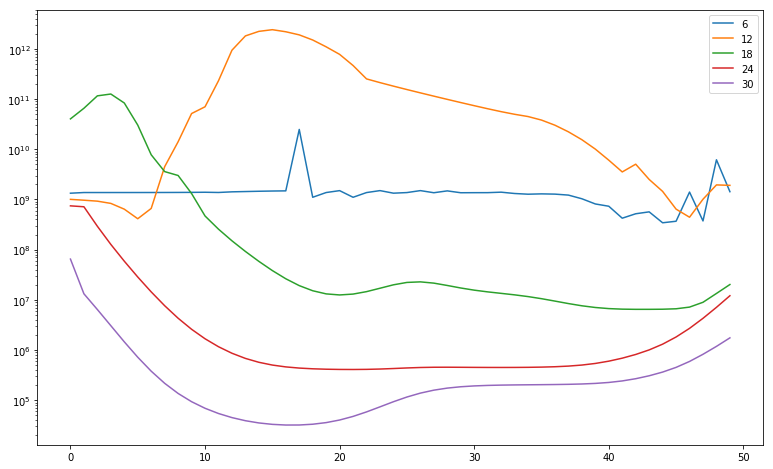

In [30]:
for fcv_val in fcv_vals:
    plt.plot(list(map(compare, fcv_val)))
plt.yscale('log')
plt.legend(js)

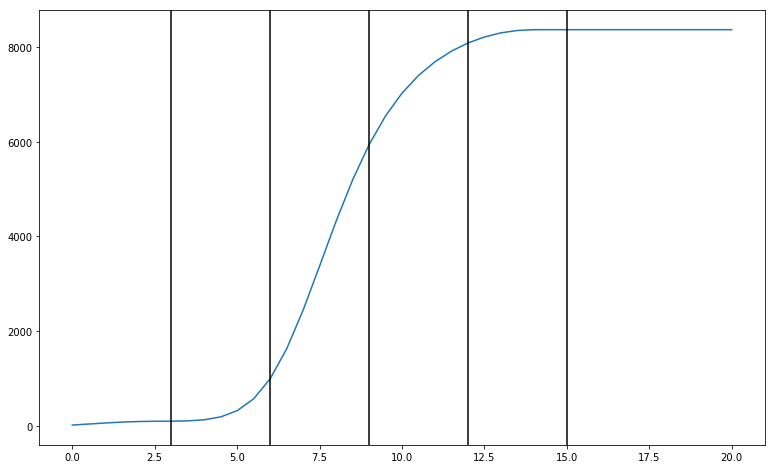

In [31]:
plt.plot(tofsol, data_pd.flatten())
for j in js:
    plt.axvline(tofsol[j], color='k')
    